In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy import interpolate
from math import pi, cos, sin,atan
import math
import os
import pickle
from sklearn.cluster import DBSCAN

from numpy.random import randint
from numpy.random import rand

import json

from paretoset import paretoset
import pandas as pd

import pygad

from bayes_opt import BayesianOptimization

import datetime

import warnings
warnings.filterwarnings('ignore')

C:\Users\DELL\anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


SystemError: initialization of _internal failed without raising an exception

## B-spline curve modeling

In [2]:
MasterColors = np.zeros((256,256,256)).astype(int)
MasterNonColors = np.zeros((256,256,256)).astype(int)

In [ ]:
#Getting a count of each pixel that is skin

def MSK(s):
    return s.replace('\\ORI\\','\\GT\\')
images = 0
for filename in os.scandir("..\\Data\\sfa\\ORI"):
    if filename.is_file() and filename.path[-4:]==".jpg":
            #print("Image "+str(images)+" -- "+file)
        images+=1
            
        img = cv2.cvtColor(cv2.cvtColor(cv2.imread(filename.path),cv2.COLOR_BGR2YCR_CB),cv2.COLOR_BGR2RGB)
        msk = cv2.imread(MSK(filename.path),0)
            
        skin = img[msk!=0]
        skin = skin.reshape(-1,3)
    
        for i in range(skin.shape[0]):
            MasterColors[skin[i,0],skin[i,1],skin[i,2]] += 1
print("Done processing ",images," images.")

In [ ]:
images = 0
for filename in os.scandir("..\\Data\\sfa\\ORI"):
    if filename.is_file() and filename.path[-4:]==".jpg":
            #print("Image "+str(images)+" -- "+file)
        images+=1
            
        img = cv2.cvtColor(cv2.cvtColor(cv2.imread(filename.path),cv2.COLOR_BGR2YCR_CB),cv2.COLOR_BGR2RGB)
        msk = cv2.imread(MSK(filename.path),0)
            
        skin = img[msk==0]
        skin = skin.reshape(-1,3)
    
        for i in range(skin.shape[0]):
            MasterNonColors[skin[i,0],skin[i,1],skin[i,2]] += 1
print("Done processing ",images," images.")

In [95]:
#Extracting the pixels that are skin
Points = np.argwhere(MasterColors>0)

In [2]:
class Ellipse:
    def __init__(self,clus,H1,H2,S1,S2,T):
        self.cluster = clus
        self.HMoy = H1
        self.SMoy = S1
        self.HEct = H2
        self.SEct = S2
        self.thet = 0 if np.isnan(T) else T
        self.Th = 2
    def __str__(self):
        return "Of cluster:"+str(self.cluster)+" with Th "+str(self.Th)+" At("+str(self.HMoy)+","+str(self.SMoy)+"),with("+str(self.HEct)+","+str(self.SEct)+"), theta "+str(self.thet)
    def is_it_in(self,H,S):
        return (pow((cos(self.thet)*(H-self.HMoy) + sin(self.thet)*(S-self.SMoy)),2) / pow(self.Th*self.HEct,2)) + (pow((-sin(self.thet)*(H-self.HMoy) + cos(self.thet)*(S-self.SMoy)),2) / pow(self.Th*self.SEct,2)) <= 1
    def are_they_in(self,H,S):
        return (np.power((cos(self.thet)*(H-self.HMoy) + sin(self.thet)*(S-self.SMoy)),2) / pow(self.Th*self.HEct,2)) + (np.power((-sin(self.thet)*(H-self.HMoy) + cos(self.thet)*(S-self.SMoy)),2) / pow(self.Th*self.SEct,2)) <= 1
    def F(self):
        print(Points)

In [3]:
class CLUSTER:
    def __init__(self,numero):
        self.id = numero
    def fit(self,points):
        valeurs = np.unique(points[:,2])
        self.nbVal = valeurs.shape[0]
        HuesMoyennes = []
        SatsMoyennes = []
        HuesEcartsTy = []
        SatsEcartsTy = []
        thetas = []
        for i in valeurs:
            Hues = points[(points[:,2]==i)][:,0];Sats = points[(points[:,2]==i)][:,1]
            HM = Hues.mean();HE = Hues.std()
            SM = Sats.mean();SE = Sats.std()
            theta = 0 if HE == SE else 0.5 * atan(2* np.corrcoef(Hues,Sats)[0,1] *HE*SE/(HE**2-SE**2))
                
            HuesMoyennes.append(HM);HuesEcartsTy.append(HE)
            SatsMoyennes.append(SM);SatsEcartsTy.append(SE)
            thetas.append(theta)
        
        self.min = valeurs.min()
        self.max = valeurs.max()
        K = min(3,valeurs.shape[0]-1)
        t, c, k = interpolate.splrep(valeurs, HuesMoyennes, s=0,k = K)
        self.HueMoy = interpolate.BSpline(t, c, k, extrapolate=True)
        t, c, k = interpolate.splrep(valeurs, SatsMoyennes, s=0,k = K)
        self.SatMoy = interpolate.BSpline(t, c, k, extrapolate=True)
        t, c, k = interpolate.splrep(valeurs, HuesEcartsTy, s=0,k = K)
        self.HueEct = interpolate.BSpline(t, c, k, extrapolate=True)
        t, c, k = interpolate.splrep(valeurs, SatsEcartsTy, s=0,k = K)
        self.SatEct = interpolate.BSpline(t, c, k, extrapolate=True)
        t, c, k = interpolate.splrep(valeurs, thetas, s=0,k = K)
        self.Theta = interpolate.BSpline(t, c, k, extrapolate=True)
    def __str__(self):
        return 'ID: '+str(self.id)+' Nb val '+str(self.nbVal)

In [4]:
#Finding which ellipses exist at each intensity level
ELLIPSES = {}
for i in range(256):
    ELLIPSES[i] = []
ELLIPSESFLAT = []

# Fonction cout

In [9]:
def EvaluationGlobale():
    P = np.argwhere(MasterColors!=0)
    t = 0;vt = 0
    st = 0;sst = 0
    
    for i in range(256):
        p = P[P[:,2]==i]
        if(p.shape[0]<1):
            continue
        R = np.zeros((p.shape[0],1))
        for e in ELLIPSES[i]:
            R = R + e.are_they_in(p[:,0],p[:,1]).reshape((-1,1))
        R=(R>0).flatten()
        t += R.sum()
        vt += p.shape[0]
        st += MasterColors[p[:,0],p[:,1],p[:,2]][R].sum()
    sst = MasterColors[P[:,0],P[:,1],P[:,2]].sum()
    print(t,vt,t/vt,st,sst,st/sst)
    P = np.argwhere(MasterNonColors!=0)
    f = 0;vf = 0
    sf = 0;ssf = 0
    
    for i in range(256):
        p = P[P[:,2]==i]
        if(p.shape[0]<1):
            continue
        R = np.zeros((p.shape[0],1))
        for e in ELLIPSES[i]:
            R = R + e.are_they_in(p[:,0],p[:,1]).reshape((-1,1))
        R = (R>0).flatten()
        f += (R>0).sum()
        vf += p.shape[0]
        sf += MasterNonColors[p[:,0],p[:,1],p[:,2]][R].sum()
    ssf = MasterNonColors[P[:,0],P[:,1],P[:,2]].sum()

    print(f,vf,f/vf,sf,ssf,sf/ssf)
    return (t/vt,f/vf,st/sst,sf/ssf)


In [10]:
def getMask(img):
    I = img.reshape((img.shape[0]*img.shape[1],3))
    msk = np.zeros((img.shape[0],img.shape[1]))
    for i in range(256):
        P = np.argwhere(img[:,:,2]==i)
        
        R = np.zeros((P.shape[0],1))
        for e in ELLIPSES[i]:
            R = R + e.are_they_in(img[P[:,0],P[:,1],0],img[P[:,0],P[:,1],1]).reshape((-1,1))
        R=(R>0).flatten()
        
        msk[P[:,0],P[:,1]] = 1+R-1
    return msk

# Trouver les seuils Th

In [13]:
ResV = {2:{},3:{}}
ResF = {2:{},3:{}}
RES  = {2:{},3:{}}

In [14]:
EPS = [2]*18+[3]*20
MIN_Sam = [i for i in range(9,27)]+[i for i in range(15,35)]

for ID in range(len(EPS)):
    clustering = DBSCAN(eps=EPS[ID], min_samples=MIN_Sam[ID]).fit(Points)
    nbCluster = clustering.labels_.max()
    try:
        Clusters = {}
        for C in range(nbCluster+1):
            Clus = CLUSTER(C)
            Clus.fit(Points[np.ravel(np.argwhere(clustering.labels_==C))] )
            Clusters[C] = Clus

        ELLIPSES = {}
        for i in range(256):
            ELLIPSES[i] = []
        ELLIPSESFLAT = []

        for C in range(nbCluster+1):
            Clus = Clusters[C]
            for v in range(Clus.min,Clus.max+1):
                e = Ellipse(C,Clus.HueMoy(v),Clus.HueEct(v),Clus.SatMoy(v),Clus.SatEct(v),Clus.Theta(v))
                ELLIPSES[v].append(e)
                ELLIPSESFLAT.append(e)
            
        ResV[EPS[ID]][MIN_Sam[ID]]={}
        ResF[EPS[ID]][MIN_Sam[ID]]={}
        RES[EPS[ID]][MIN_Sam[ID]]={}
            
        for Th in np.arange(0.1,2,0.1): #Pour chaque valeur de V
       
            for e in ELLIPSESFLAT:
                e.Th = Th
            print("Th = ",Th," eps = ",EPS[ID]," MinSamp = ",MIN_Sam[ID])
            V1,F1,V,F = EvaluationGlobale()
            ResV[EPS[ID]][MIN_Sam[ID]][Th] = [V1,V]
            ResF[EPS[ID]][MIN_Sam[ID]][Th] = [F1,F]
            RES[EPS[ID]][MIN_Sam[ID]][Th] = {"Clus":clustering}
            print("-----------------------------------------------")
    except:
        print("Failed for ",EPS[ID],MIN_Sam[ID])

Th =  0.1  eps =  2  MinSamp =  9
1925 439577 0.00437921001326275 4592562 131235458 0.03499482586482077
1935 807345 0.002396744886015272 684246 319095166 0.0021443320767823852
-----------------------------------------------
Th =  0.2  eps =  2  MinSamp =  9
7655 439577 0.01741446890988382 19697615 131235458 0.15009369647645074
7683 807345 0.009516377756721104 3892313 319095166 0.01219796917888753
-----------------------------------------------
Th =  0.30000000000000004  eps =  2  MinSamp =  9
17293 439577 0.03934009286200142 43873389 131235458 0.3343104803276566
17302 807345 0.02143073902730555 11523644 319095166 0.03611350226471309
-----------------------------------------------
Th =  0.4  eps =  2  MinSamp =  9
30698 439577 0.06983531895435839 66804302 131235458 0.5090415579606542
30632 807345 0.03794164824207743 25542949 319095166 0.08004806001981239
-----------------------------------------------
Th =  0.5  eps =  2  MinSamp =  9
47919 439577 0.10901161798729232 83451266 131235458 

349189 439577 0.7943750469201073 129529550 131235458 0.9870011654929417
437847 807345 0.5423294873938651 292951738 319095166 0.9180701220650895
-----------------------------------------------
Th =  1.8000000000000003  eps =  2  MinSamp =  10
364936 439577 0.8301981222857429 129857373 131235458 0.9894991413067649
469873 807345 0.581997782856152 295636524 319095166 0.9264838690787311
-----------------------------------------------
Th =  1.9000000000000001  eps =  2  MinSamp =  10
378442 439577 0.8609231147216528 130178053 131235458 0.9919426882329316
499636 807345 0.6188630634982566 298717159 319095166 0.9361381519643579
-----------------------------------------------
Th =  0.1  eps =  2  MinSamp =  11
1904 439577 0.004331436813118066 5039552 131235458 0.03840084133359751
1918 807345 0.002375688212598084 680725 319095166 0.0021332977510539913
-----------------------------------------------
Th =  0.2  eps =  2  MinSamp =  11
7569 439577 0.017218826280719874 21029251 131235458 0.1602406188

325136 807345 0.40272250401005766 279623872 319095166 0.8763024382512896
-----------------------------------------------
Th =  1.5000000000000002  eps =  2  MinSamp =  12
306908 439577 0.6981893957145164 128403477 131235458 0.9784206109906669
362458 807345 0.4489505725557228 284159881 319095166 0.8905176614301954
-----------------------------------------------
Th =  1.6  eps =  2  MinSamp =  12
328194 439577 0.7466132213468858 129076368 131235458 0.9835479676536809
398416 807345 0.4934891527166205 289229828 319095166 0.9064061722577145
-----------------------------------------------
Th =  1.7000000000000002  eps =  2  MinSamp =  12
346746 439577 0.7888174313032756 129516098 131235458 0.9868986627074521
432449 807345 0.5356433742699838 292641593 319095166 0.9170981706441771
-----------------------------------------------
Th =  1.8000000000000003  eps =  2  MinSamp =  12
362644 439577 0.8249840187270945 129837864 131235458 0.9893504848361941
464466 807345 0.575300522081638 295326382 3190

227390 439577 0.5172927609952295 124436103 131235458 0.9481896500867929
245028 807345 0.3034985043568735 151769198 319095166 0.4756236200707597
-----------------------------------------------
Th =  1.3000000000000003  eps =  2  MinSamp =  14
255055 439577 0.5802282649001199 126081350 131235458 0.9607262543328801
282183 807345 0.3495197220519109 157797471 319095166 0.49451539168725606
-----------------------------------------------
Th =  1.4000000000000001  eps =  2  MinSamp =  14
280560 439577 0.6382499539329856 127450740 131235458 0.9711608580662705
319672 807345 0.3959546414482037 279026335 319095166 0.8744298401562122
-----------------------------------------------
Th =  1.5000000000000002  eps =  2  MinSamp =  14
304197 439577 0.692022103067267 128351479 131235458 0.9780243918530006
356678 807345 0.4417913035938787 283654289 319095166 0.8889332062147253
-----------------------------------------------
Th =  1.6  eps =  2  MinSamp =  14
325569 439577 0.7406415713288002 129043472 1312

139302 439577 0.31690011078832603 115507411 131235458 0.8801539824701949
141403 807345 0.17514569360062923 122973167 319095166 0.38538085218125806
-----------------------------------------------
Th =  1.0  eps =  2  MinSamp =  16
167426 439577 0.3808798003535217 119366585 131235458 0.9095604710732978
172598 807345 0.21378468932117 135251430 319095166 0.4238592257458391
-----------------------------------------------
Th =  1.1  eps =  2  MinSamp =  16
196228 439577 0.44640188180910284 122209681 131235458 0.9312245551808109
206004 807345 0.25516229121379336 143838266 319095166 0.4507691789978417
-----------------------------------------------
Th =  1.2000000000000002  eps =  2  MinSamp =  16
224895 439577 0.5116168498351824 124351725 131235458 0.9475466988502452
241479 807345 0.29910261412407335 151146787 319095166 0.4736730703090626
-----------------------------------------------
Th =  1.3000000000000003  eps =  2  MinSamp =  16
252450 439577 0.5743021131678864 126031802 131235458 0.960

63868 439577 0.14529422604003395 94730007 131235458 0.7218324105669673
63357 807345 0.07847574457016517 67904767 319095166 0.21280412314362668
-----------------------------------------------
Th =  0.7000000000000001  eps =  2  MinSamp =  18
86153 439577 0.19599069105071468 103627300 131235458 0.7896288211986123
85620 807345 0.10605131635174554 89052057 319095166 0.27907679742161934
-----------------------------------------------
Th =  0.8  eps =  2  MinSamp =  18
110894 439577 0.2522743455640309 110442980 131235458 0.8415635658466631
110974 807345 0.13745548681171 106198938 319095166 0.3328127446468431
-----------------------------------------------
Th =  0.9  eps =  2  MinSamp =  18
137282 439577 0.3123047839172659 115516724 131235458 0.8802249465232178
138885 807345 0.1720268286791892 120776128 319095166 0.3784956366277263
-----------------------------------------------
Th =  1.0  eps =  2  MinSamp =  18
165145 439577 0.3756907208520919 119349785 131235458 0.909432456889814
169560 80

15751 439577 0.035832175022806015 44929454 131235458 0.3423575814396137
15737 807345 0.019492286445076144 10899977 319095166 0.03415901637319069
-----------------------------------------------
Th =  0.4  eps =  2  MinSamp =  20
28051 439577 0.06381362082183553 66682102 131235458 0.5081104071736466
27946 807345 0.034614693842161655 23599700 319095166 0.0739581871321736
-----------------------------------------------
Th =  0.5  eps =  2  MinSamp =  20
43768 439577 0.09956844875869302 82871666 131235458 0.6314731343414827
43459 807345 0.05382952764927014 43140998 319095166 0.135197905191707
-----------------------------------------------
Th =  0.6  eps =  2  MinSamp =  20
62837 439577 0.14294878940435918 94634990 131235458 0.7211083913007718
62268 807345 0.07712687884361705 67123445 319095166 0.21035556834477398
-----------------------------------------------
Th =  0.7000000000000001  eps =  2  MinSamp =  20
84845 439577 0.1930151031559886 103569415 131235458 0.7891877437574836
84242 8073

366137 439577 0.8329302943511603 130074406 131235458 0.9911529092998631
466704 807345 0.5780725712056184 296960260 319095166 0.9306322741347952
-----------------------------------------------
Th =  0.1  eps =  2  MinSamp =  22
1724 439577 0.003921952240449341 5585457 131235458 0.042560578407094825
1729 807345 0.002141587549312871 676273 319095166 0.0021193458004312104
-----------------------------------------------
Th =  0.2  eps =  2  MinSamp =  22
6823 439577 0.015521740218437271 22091678 131235458 0.16833619767608843
6836 807345 0.008467259969405892 3836056 319095166 0.012021667542277967
-----------------------------------------------
Th =  0.30000000000000004  eps =  2  MinSamp =  22
15420 439577 0.03507917839195408 45596174 131235458 0.34743791574987304
15402 807345 0.019077346115972726 10891905 319095166 0.03413371984456825
-----------------------------------------------
Th =  0.4  eps =  2  MinSamp =  22
27396 439577 0.0623235519601799 66866305 131235458 0.5095140141165202
27280

361593 807345 0.4478791594671423 286604843 319095166 0.8981798332852212
-----------------------------------------------
Th =  1.7000000000000002  eps =  2  MinSamp =  23
329378 439577 0.749306719869329 129436405 131235458 0.9862914106643343
394291 807345 0.48837981284333215 290233198 319095166 0.9095505946962543
-----------------------------------------------
Th =  1.8000000000000003  eps =  2  MinSamp =  23
346561 439577 0.7883965721591439 129780024 131235458 0.9889097502901998
425366 807345 0.5268701732221045 293113253 319095166 0.9185762876771377
-----------------------------------------------
Th =  1.9000000000000001  eps =  2  MinSamp =  23
361729 439577 0.8229024721493617 130059059 131235458 0.9910359668192723
454679 807345 0.5631780713325778 296483637 319095166 0.9291386037480743
-----------------------------------------------
Th =  0.1  eps =  2  MinSamp =  24
1657 439577 0.0037695329828448714 5668001 131235458 0.04318955476194551
1661 807345 0.0020573608556441175 725487 319095

259158 439577 0.5895622382426742 127258561 131235458 0.9696964748658096
283340 807345 0.3509528144721278 274520314 319095166 0.8603085952107467
-----------------------------------------------
Th =  1.5000000000000002  eps =  2  MinSamp =  25
283078 439577 0.6439781881217626 128206118 131235458 0.9769167567502984
317462 807345 0.39321727390396916 279883771 319095166 0.8771169256760223
-----------------------------------------------
Th =  1.6  eps =  2  MinSamp =  25
304889 439577 0.6935963437577489 128934364 131235458 0.9824659125279999
350779 807345 0.4344846379181143 285659804 319095166 0.8952182121116808
-----------------------------------------------
Th =  1.7000000000000002  eps =  2  MinSamp =  25
324645 439577 0.738539550522434 129419178 131235458 0.9861601427870202
383225 807345 0.4746731570765906 289412031 319095166 0.9069771711928722
-----------------------------------------------
Th =  1.8000000000000003  eps =  2  MinSamp =  25
342076 439577 0.7781935815568148 129763740 1312

225602 807345 0.2794369197802674 148388297 319095166 0.4650283451802589
-----------------------------------------------
Th =  1.2000000000000002  eps =  3  MinSamp =  15
239920 439577 0.5457974370815579 124901093 131235458 0.9517328236093023
263511 807345 0.3263920628727496 155104473 319095166 0.4860759094044063
-----------------------------------------------
Th =  1.3000000000000003  eps =  3  MinSamp =  15
267315 439577 0.6081187141274452 126405260 131235458 0.9631944135098001
302510 807345 0.37469731031962794 160616252 319095166 0.503349060449258
-----------------------------------------------
Th =  1.4000000000000001  eps =  3  MinSamp =  15
292498 439577 0.6654078807580924 127703050 131235458 0.9730834329850093
342044 807345 0.4236652236652237 281383955 319095166 0.8818182942953138
-----------------------------------------------
Th =  1.5000000000000002  eps =  3  MinSamp =  15
315701 439577 0.7181927170893837 128530207 131235458 0.9793862798878639
380598 807345 0.4714192817197109

123682 807345 0.15319596950498238 114580436 319095166 0.3590791970819138
-----------------------------------------------
Th =  0.9  eps =  3  MinSamp =  17
150567 439577 0.34252702029451043 116276428 131235458 0.8860138088594929
154740 807345 0.19166527321033758 129048226 319095166 0.4044192446337467
-----------------------------------------------
Th =  1.0  eps =  3  MinSamp =  17
180148 439577 0.40982125998403013 120041447 131235458 0.9147028465431957
188714 807345 0.23374641572066465 140364945 319095166 0.43988427264360375
-----------------------------------------------
Th =  1.1  eps =  3  MinSamp =  17
210306 439577 0.4784281252203823 122843711 131235458 0.936055795225708
224960 807345 0.27864172070180654 148300230 319095166 0.4647523554148733
-----------------------------------------------
Th =  1.2000000000000002  eps =  3  MinSamp =  17
239549 439577 0.5449534438790019 124897480 131235458 0.9517052929399614
262743 807345 0.32544079668543185 155023157 319095166 0.485821076336831

71062 439577 0.16165995946102732 95266441 131235458 0.7259199796445256
70646 807345 0.08750410295474673 76395794 319095166 0.23941382427585883
-----------------------------------------------
Th =  0.7000000000000001  eps =  3  MinSamp =  19
95339 439577 0.21688805374257525 104213829 131235458 0.7940981087596006
95385 807345 0.11814651728814819 98272815 319095166 0.30797337431304117
-----------------------------------------------
Th =  0.8  eps =  3  MinSamp =  19
121901 439577 0.27731432718272336 111012635 131235458 0.8459042753521689
123379 807345 0.1528206652670172 114417317 319095166 0.35856800475629896
-----------------------------------------------
Th =  0.9  eps =  3  MinSamp =  19
150263 439577 0.34183544634955876 116164068 131235458 0.8851576378085259
154378 807345 0.19121688992933628 128817847 319095166 0.40369726879535367
-----------------------------------------------
Th =  1.0  eps =  3  MinSamp =  19
179761 439577 0.40894086815279235 119935665 131235458 0.9138967991409761


17871 439577 0.040654993323126554 43085852 131235458 0.32830953354085146
17850 807345 0.02210950708804786 12041823 319095166 0.037737403392691944
-----------------------------------------------
Th =  0.4  eps =  3  MinSamp =  21
31717 439577 0.07215345661852189 66775657 131235458 0.5088232861579224
31605 807345 0.039146833138249446 26889480 319095166 0.0842679014447997
-----------------------------------------------
Th =  0.5  eps =  3  MinSamp =  21
49541 439577 0.11270152896989606 83350473 131235458 0.6351215919100157
49239 807345 0.060988796611114206 50014600 319095166 0.15673882066894113
-----------------------------------------------
Th =  0.6  eps =  3  MinSamp =  21
70872 439577 0.16122772574543254 95265413 131235458 0.7259121463956791
70450 807345 0.08726133189652503 76170829 319095166 0.2387088151626841
-----------------------------------------------
Th =  0.7000000000000001  eps =  3  MinSamp =  21
95084 439577 0.21630795059796123 104183168 131235458 0.7938644752548507
95104 

381477 439577 0.8678274795997061 130201895 131235458 0.9921243616949925
509280 807345 0.6308083904650428 299288113 319095166 0.9379274426238096
-----------------------------------------------
Th =  0.1  eps =  3  MinSamp =  23
1970 439577 0.004481581156429932 4348924 131235458 0.03313833064841363
1973 807345 0.002443812744241929 720767 319095166 0.0022587838262645445
-----------------------------------------------
Th =  0.2  eps =  3  MinSamp =  23
7896 439577 0.01796272325440139 19210558 131235458 0.1463823747999569
7908 807345 0.009795069022536834 4031725 319095166 0.012634867054049951
-----------------------------------------------
Th =  0.30000000000000004  eps =  3  MinSamp =  23
17802 439577 0.04049802423693687 43162714 131235458 0.32889521367007385
17781 807345 0.022024041766531038 11835086 319095166 0.037089518303765216
-----------------------------------------------
Th =  0.4  eps =  3  MinSamp =  23
31614 439577 0.07191914044638369 66776622 131235458 0.5088306393535807
31503 

412919 807345 0.5114529723971784 290291138 319095166 0.9097321706214754
-----------------------------------------------
Th =  1.7000000000000002  eps =  3  MinSamp =  24
352822 439577 0.8026398105451377 129569292 131235458 0.9873039952357998
446846 807345 0.5534758993986462 293617476 319095166 0.9201564526364526
-----------------------------------------------
Th =  1.8000000000000003  eps =  3  MinSamp =  24
368122 439577 0.8374459992219793 129887609 131235458 0.9897295363574683
478837 807345 0.5931008428862506 296202264 319095166 0.9282568197852299
-----------------------------------------------
Th =  1.9000000000000001  eps =  3  MinSamp =  24
381200 439577 0.8671973283406548 130200519 131235458 0.9921138767237738
508314 807345 0.6296118759638073 299240159 319095166 0.9377771614377888
-----------------------------------------------
Th =  0.1  eps =  3  MinSamp =  25
1968 439577 0.004477031327844724 4354020 131235458 0.033177161617403736
1969 807345 0.002438858232849649 710528 3190951

289405 439577 0.6583715708510682 127637908 131235458 0.9725870579885506
336315 807345 0.41656912472363117 280803561 319095166 0.8799994199849458
-----------------------------------------------
Th =  1.5000000000000002  eps =  3  MinSamp =  26
312782 439577 0.7115522422692725 128478338 131235458 0.9789910437162493
374486 807345 0.46384878831230764 285180806 319095166 0.8937170988043109
-----------------------------------------------
Th =  1.6  eps =  3  MinSamp =  26
333811 439577 0.7593914149284425 129129847 131235458 0.9839554718512127
410758 807345 0.5087762976174993 290129230 319095166 0.9092247734019261
-----------------------------------------------
Th =  1.7000000000000002  eps =  3  MinSamp =  26
351929 439577 0.8006083120818424 129551163 131235458 0.9871658542160153
444853 807345 0.5510073140974429 293446174 319095166 0.9196196159236082
-----------------------------------------------
Th =  1.8000000000000003  eps =  3  MinSamp =  26
367383 439577 0.835764837559745 129875556 131

220378 807345 0.27296632790195025 147307820 319095166 0.461642280096465
-----------------------------------------------
Th =  1.2000000000000002  eps =  3  MinSamp =  28
236032 439577 0.5369525703119135 124781563 131235458 0.9508220179335984
257764 807345 0.3192736686298918 154132799 319095166 0.4830308178344513
-----------------------------------------------
Th =  1.3000000000000003  eps =  3  MinSamp =  28
263658 439577 0.5997993525593923 126324822 131235458 0.9625814846472361
296282 807345 0.3669831360818485 159782034 319095166 0.5007347369217119
-----------------------------------------------
Th =  1.4000000000000001  eps =  3  MinSamp =  28
288939 439577 0.6573114607907147 127630140 131235458 0.9725278666684731
335135 807345 0.41510754386290866 280700623 319095166 0.8796768265677832
-----------------------------------------------
Th =  1.5000000000000002  eps =  3  MinSamp =  28
312269 439577 0.7103852112371667 128473383 131235458 0.9789532871520135
373176 807345 0.462226185831336

120805 807345 0.14963243718608527 113075218 319095166 0.3543620526047079
-----------------------------------------------
Th =  0.9  eps =  3  MinSamp =  30
147372 439577 0.33525866912964053 115854328 131235458 0.882797452499461
151197 807345 0.1872768147446259 127621937 319095166 0.3999494526971305
-----------------------------------------------
Th =  1.0  eps =  3  MinSamp =  30
176572 439577 0.4016861664736781 119720203 131235458 0.9122550019980118
184380 807345 0.22837820262712966 139186652 319095166 0.43619166578035845
-----------------------------------------------
Th =  1.1  eps =  3  MinSamp =  30
206278 439577 0.4692647704497733 122552200 131235458 0.9338345129256149
219929 807345 0.27241018399816685 147205662 319095166 0.4613221310911366
-----------------------------------------------
Th =  1.2000000000000002  eps =  3  MinSamp =  30
235460 439577 0.535651319336544 124707724 131235458 0.9502593727375113
257251 807345 0.31863825254383193 154034707 319095166 0.4827234111092739
-

48106 807345 0.059585431259251004 48960105 319095166 0.15343417957011607
-----------------------------------------------
Th =  0.6  eps =  3  MinSamp =  32
69189 439577 0.15739904499097995 94677394 131235458 0.7214315051957986
68844 807345 0.08527209557252476 74698746 319095166 0.23409551118051095
-----------------------------------------------
Th =  0.7000000000000001  eps =  3  MinSamp =  32
92996 439577 0.21155792955500402 103731737 131235458 0.7904246198462613
93024 807345 0.11522211693885513 96904743 319095166 0.30368602638123326
-----------------------------------------------
Th =  0.8  eps =  3  MinSamp =  32
119137 439577 0.2710264640779659 110588547 131235458 0.8426727706470915
120438 807345 0.1491778607658436 113031433 319095166 0.3542248364865546
-----------------------------------------------
Th =  0.9  eps =  3  MinSamp =  32
147056 439577 0.33453979621317764 115788050 131235458 0.8822924213058334
150775 807345 0.1867541137927404 127510543 319095166 0.39960035934859633
---

7735 807345 0.00958078640482074 4103581 319095166 0.012860053793481785
-----------------------------------------------
Th =  0.30000000000000004  eps =  3  MinSamp =  34
17329 439577 0.03942198977653517 44061766 131235458 0.33574589269921246
17329 807345 0.02146418197920344 11857850 319095166 0.03716085752298736
-----------------------------------------------
Th =  0.4  eps =  3  MinSamp =  34
30840 439577 0.07015835678390817 66693234 131235458 0.5081952318099884
30772 807345 0.038115056140807214 26722067 319095166 0.08374325231865154
-----------------------------------------------
Th =  0.5  eps =  3  MinSamp =  34
48140 439577 0.10951437404595782 82960720 131235458 0.6321517161924333
47912 807345 0.05934513745672544 48947523 319095166 0.15339474932691397
-----------------------------------------------
Th =  0.6  eps =  3  MinSamp =  34
68918 439577 0.15678254321768428 94760004 131235458 0.7220609844635129
68567 807345 0.0849289956586094 74591694 319095166 0.23376002505785373
--------

In [15]:
with open("ResV.json", "w") as write_file:
    json.dump(ResV, write_file, indent=4)
with open("ResF.json", "w") as write_file:
    json.dump(ResF, write_file, indent=4)
with open('RES.pkl', 'wb') as f:
    pickle.dump(RES, f)

# Loading data

In [16]:
with open("ResF.json", "r") as write_file:
    ResF = json.load(write_file)
with open("ResV.json", "r") as write_file:
    ResV = json.load(write_file)
with open('RES.pkl', 'rb') as f:
    RES = pickle.load(f)

# For global cost function 1 : 

In [23]:
#################################################################################################
# Creating the sets a.k.a the game
#################################################################################################
A = []
B = []
C = []
setV = []
setF = []
for a in ResV.keys():
    for b in ResV[a].keys():
        for c in ResV[a][b].keys():
            setV += [ResV[a][b][c][0]]
            setF += [ResF[a][b][c][0]]
            A += [a];B += [b];C += [c]
            
#################################################################################################
# Trouver l'equilibre
#################################################################################################
JEU = pd.DataFrame({"V": setV, 
                    "F": setF})
mask = paretoset(JEU, sense=["max", "min"])
paretoset_JEU = JEU[mask]
print("Il y a "+str(paretoset_JEU.shape[0])+" optimums de pareto !")
PS = paretoset_JEU.to_numpy()

#### LE MEILLEUR DANS LE SANS QUE la difference entre metric1 et metric2 soit maximale
PS[np.argmax(PS[:,0]-PS[:,1])]
idx = np.array([i for i in range(JEU.shape[0])])[mask][np.argmax(PS[:,0]-PS[:,1])]

bestEPS = A[idx]
bestMinSample = B[idx]
bestTh = C[idx]

print("Le meilleur résultat est ("+str(setV[idx])+", "+str(setF[idx])+") a "+str(idx)+". Pour ("+str(bestEPS)+","+str(bestMinSample)+","+str(bestTh)+")")

#################################################################################################
# Setting our model to the best solution
#################################################################################################
clustering = RES[int(bestEPS)][int(bestMinSample)][float(bestTh)]["Clus"]
nbCluster = clustering.labels_.max()
Clusters = {}
for C in range(nbCluster+1):
    Clus = CLUSTER(C)
    Clus.fit(Points[np.ravel(np.argwhere(clustering.labels_==C))] )
    Clusters[C] = Clus

ELLIPSES = {}
for i in range(256):
    ELLIPSES[i] = []
ELLIPSESFLAT = []

for C in range(nbCluster+1):
    Clus = Clusters[C]
    for v in range(Clus.min,Clus.max+1):
        e = Ellipse(C,Clus.HueMoy(v),Clus.HueEct(v),Clus.SatMoy(v),Clus.SatEct(v),Clus.Theta(v))
        ELLIPSES[v].append(e)
        ELLIPSESFLAT.append(e)

for e in ELLIPSESFLAT:
    e.Th = float(bestTh)
    
#################################################################################################
# Evaluer
#################################################################################################
_=EvaluationGlobale()

Il y a 443 optimums de pareto !
Le meilleur résultat est (0.7719785157094207, 0.5051248227213893) a 340. Pour (2,26,1.8000000000000003)
339344 439577 0.7719785157094207 129755100 131235458 0.9887198321051313
407810 807345 0.5051248227213893 291853648 319095166 0.914628860281763


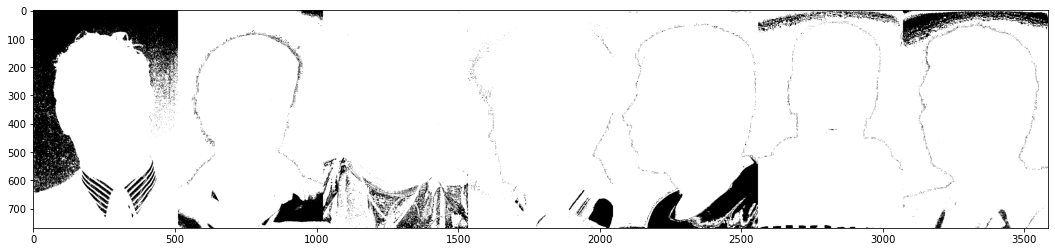

In [24]:
IMAGE = np.hstack([ np.hstack([np.hstack([np.hstack([np.hstack([np.hstack([cv2.imread("../Data/sfa/ORI/img (6).jpg"),
                                                                           cv2.imread("../Data/sfa/ORI/img (25).jpg")]),
                                                                cv2.imread("../Data/sfa/ORI/img (50).jpg")]),
                                                     cv2.imread("../Data/sfa/ORI/img (75).jpg")]),
                                          cv2.imread("../Data/sfa/ORI/img (89).jpg")]),
                             cv2.imread("../Data/sfa/ORI/img (118).jpg")]),
                  cv2.imread("../Data/sfa/ORI/img (110).jpg")])

MASK = getMask(cv2.cvtColor(cv2.cvtColor(IMAGE,cv2.COLOR_BGR2YCR_CB),cv2.COLOR_BGR2RGB))
plt.figure(figsize = (20,4))
plt.imshow(MASK,cmap='gray')

# For global cost function 2 (the weighted one):

In [96]:
#################################################################################################
# Creating the sets a.k.a the game
#################################################################################################
A = []
B = []
C = []
setV = []
setF = []
for a in ResV.keys():
    for b in ResV[a].keys():
        for c in ResV[a][b].keys():
            setV += [ResV[a][b][c][1]]
            setF += [ResF[a][b][c][1]]
            A += [a];B += [b];C += [c]
            
#################################################################################################
# Trouver l'equilibre
#################################################################################################
JEU = pd.DataFrame({"V": setV, 
                    "F": setF})
mask = paretoset(JEU, sense=["max", "min"])
paretoset_JEU = JEU[mask]
print("Il y a "+str(paretoset_JEU.shape[0])+" optimums de pareto !")
PS = paretoset_JEU.to_numpy()

#### LE MEILLEUR DANS LE SANS QUE la difference entre metric1 et metric2 soit maximale
PS[np.argmax(PS[:,0]-PS[:,1])]
idx = np.array([i for i in range(JEU.shape[0])])[mask][np.argmax(PS[:,0]-PS[:,1])]

bestEPS = A[idx]
bestMinSample = B[idx]
bestTh = C[idx]

print("Le meilleur résultat est ("+str(setV[idx])+", "+str(setF[idx])+") a "+str(idx)+". Pour ("+str(bestEPS)+","+str(bestMinSample)+","+str(bestTh)+")")

#################################################################################################
# Setting our model to the best solution
#################################################################################################
clustering = RES[int(bestEPS)][int(bestMinSample)][float(bestTh)]["Clus"]
nbCluster = clustering.labels_.max()
Clusters = {}
for C in range(nbCluster+1):
    Clus = CLUSTER(C)
    Clus.fit(Points[np.ravel(np.argwhere(clustering.labels_==C))] )
    Clusters[C] = Clus

ELLIPSES = {}
for i in range(256):
    ELLIPSES[i] = []
ELLIPSESFLAT = []

for C in range(nbCluster+1):
    Clus = Clusters[C]
    for v in range(Clus.min,Clus.max+1):
        e = Ellipse(C,Clus.HueMoy(v),Clus.HueEct(v),Clus.SatMoy(v),Clus.SatEct(v),Clus.Theta(v))
        ELLIPSES[v].append(e)
        ELLIPSESFLAT.append(e)

for e in ELLIPSESFLAT:
    e.Th = float(bestTh)
    
#################################################################################################
# Evaluer
#################################################################################################
_=EvaluationGlobale()

Il y a 225 optimums de pareto !
Le meilleur résultat est (0.8351944944635313, 0.2975966423759613) a 330. Pour (2,26,0.8)
99627 439577 0.22664288622926132 109607132 131235458 0.8351944944635313
98604 807345 0.12213366033108522 94961650 319095166 0.2975966423759613


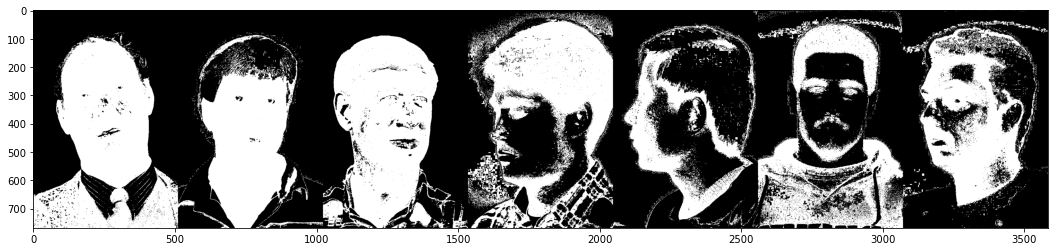

In [60]:
IMAGE = np.hstack([ np.hstack([np.hstack([np.hstack([np.hstack([np.hstack([cv2.imread("../Data/sfa/ORI/img (6).jpg"),
                                                                           cv2.imread("../Data/sfa/ORI/img (25).jpg")]),
                                                                cv2.imread("../Data/sfa/ORI/img (55).jpg")]),
                                                     cv2.imread("../Data/sfa/ORI/img (75).jpg")]),
                                          cv2.imread("../Data/sfa/ORI/img (89).jpg")]),
                             cv2.imread("../Data/sfa/ORI/img (118).jpg")]),
                  cv2.imread("../Data/sfa/ORI/img (110).jpg")])

MASK = getMask(cv2.cvtColor(cv2.cvtColor(IMAGE,cv2.COLOR_BGR2YCR_CB),cv2.COLOR_BGR2RGB))
plt.figure(figsize = (20,4))
plt.imshow(MASK,cmap='gray')

# Algorithme génetique

In [27]:
def setWeights(i,vals):
    j = 0
    for e in ELLIPSES[i]:
        e.Th = vals[j]
        j+=1
def getWeights(i):
    res = []
    for e in ELLIPSES[i]:
        res += [e.Th]
    return res

In [28]:
def Evaluer(Ellips,Points,i):
    P = np.argwhere(Points[:,:,i]!=0)    
    R = np.zeros((P.shape[0],1))
    for e in Ellips:
        R = R + e.are_they_in(P[:,0],P[:,1]).reshape((-1,1))
    R=(R>0).flatten()
    return R.sum()/P.shape[0]

# GA m1 - 1.85 m2

In [42]:
def Evaluation(i):
    return Evaluer(ELLIPSES[i],MasterColors,i) - 1.85*Evaluer(ELLIPSES[i],MasterNonColors,i)
EvaluationGlobale()

desired_output = 0
num_generations = 80
num_parents_mating = 4
sol_per_pop = 8
init_range_low = 0.8
init_range_high = 4.8
parent_selection_type = "sss"
keep_parents = 1
crossover_type = "single_point"
mutation_type = "random"
mutation_percent_genes = 10

for I in range(256):
    function_inputs = getWeights(I)
    num_genes = len(function_inputs)
    if(num_genes<1):
        continue
    def fitness_func(ga_instance, solution, solution_idx):
        setWeights(I,solution)
        return Evaluation(I)

    fitness_function = fitness_func
    
    ga_instance = pygad.GA(num_generations=num_generations,
                                   num_parents_mating=num_parents_mating,
                                   fitness_func=fitness_function,
                                   sol_per_pop=sol_per_pop,
                                   num_genes=num_genes,
                                   init_range_low=init_range_low,
                                   init_range_high=init_range_high,
                                   parent_selection_type=parent_selection_type,
                                   keep_parents=keep_parents,
                                   crossover_type=crossover_type,
                                   mutation_type=mutation_type,
                                   mutation_percent_genes=mutation_percent_genes)

    ga_instance.run()
    
    solution, solution_fitness, solution_idx = ga_instance.best_solution()
    setWeights(I,solution)

EvaluationGlobale()

99627 439577 0.22664288622926132 109607132 131235458 0.8351944944635313
98604 807345 0.12213366033108522 94961650 319095166 0.2975966423759613
97753 439577 0.22237969684492137 115123230 131235458 0.8772265647901347
97725 807345 0.12104490645263177 66752679 319095166 0.20919363911642586


(0.22237969684492137,
 0.12104490645263177,
 0.8772265647901347,
 0.20919363911642586)

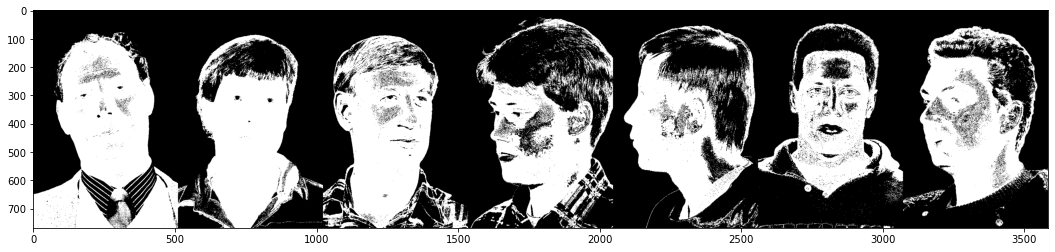

In [43]:
IMAGE = np.hstack([ np.hstack([np.hstack([np.hstack([np.hstack([np.hstack([cv2.imread("../Data/sfa/ORI/img (6).jpg"),
                                                                           cv2.imread("../Data/sfa/ORI/img (25).jpg")]),
                                                                cv2.imread("../Data/sfa/ORI/img (55).jpg")]),
                                                     cv2.imread("../Data/sfa/ORI/img (75).jpg")]),
                                          cv2.imread("../Data/sfa/ORI/img (89).jpg")]),
                             cv2.imread("../Data/sfa/ORI/img (118).jpg")]),
                  cv2.imread("../Data/sfa/ORI/img (110).jpg")])
MASK = getMask(cv2.cvtColor(cv2.cvtColor(IMAGE,cv2.COLOR_BGR2YCR_CB),cv2.COLOR_BGR2RGB))
plt.figure(figsize = (20,4))
plt.imshow(MASK,cmap='gray')

In [44]:
with open('Result GA 1.pkl', 'wb') as f:
    pickle.dump(ELLIPSES, f)

In [10]:
with open('Result GA 1.pkl', 'rb') as f:
    ELLIPSES = pickle.load(f)

In [11]:
%matplotlib qt
import random
 
def color_generator(seed):
    random.seed(seed*20+5)
    r = random.randint(0, 255)
    g = random.randint(0, 255)
    b = random.randint(0, 255)
    return (r/255, g/255, b/255)

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.set_xlabel('Cb')
ax.set_ylabel('Cr')
ax.set_zlabel('Y')

for i in range(256):
    for ELLI in ELLIPSES[i]:
        u=ELLI.HMoy      #x-position of the center
        v=ELLI.SMoy      #y-position of the center
        a=ELLI.Th*ELLI.HEct       #radius on the x-axis
        b=ELLI.Th*ELLI.SEct      #radius on the y-axis
        t_rot=ELLI.thet #rotation angle

        t = np.linspace(0, 2*pi, 100)
        Ell = np.array([a*np.cos(t) , b*np.sin(t)])  
        R_rot = np.array([[cos(t_rot) , -sin(t_rot)],[sin(t_rot) , cos(t_rot)]])  
    #2-D rotation matrix

        Ell_rot = np.zeros((2,Ell.shape[1]))
        for j in range(Ell.shape[1]):
            Ell_rot[:,j] = np.dot(R_rot,Ell[:,j])

        ax.plot( u + Ell_rot[0,:] , v + Ell_rot[1,:],np.ones((Ell_rot[0].shape))*i,color=color_generator(ELLI.cluster) )
plt.show()

# GA with m1-m2

In [55]:
def Evaluation(i):
    return Evaluer(ELLIPSES[i],MasterColors,i)-Evaluer(ELLIPSES[i],MasterNonColors,i)
EvaluationGlobale()

desired_output = 0
num_generations = 80
num_parents_mating = 4
sol_per_pop = 8
init_range_low = 0.8
init_range_high = 4.8
parent_selection_type = "sss"
keep_parents = 1
crossover_type = "single_point"
mutation_type = "random"
mutation_percent_genes = 10

for I in range(256):
    function_inputs = getWeights(I)
    num_genes = len(function_inputs)
    if(num_genes<1):
        continue
    def fitness_func(ga_instance, solution, solution_idx):
        setWeights(I,solution)
        return Evaluation(I)

    fitness_function = fitness_func
    
    ga_instance = pygad.GA(num_generations=num_generations,
                                   num_parents_mating=num_parents_mating,
                                   fitness_func=fitness_function,
                                   sol_per_pop=sol_per_pop,
                                   num_genes=num_genes,
                                   init_range_low=init_range_low,
                                   init_range_high=init_range_high,
                                   parent_selection_type=parent_selection_type,
                                   keep_parents=keep_parents,
                                   crossover_type=crossover_type,
                                   mutation_type=mutation_type,
                                   mutation_percent_genes=mutation_percent_genes)

    ga_instance.run()
    
    solution, solution_fitness, solution_idx = ga_instance.best_solution()
    setWeights(I,solution)

EvaluationGlobale()

99627 439577 0.22664288622926132 109607132 131235458 0.8351944944635313
98604 807345 0.12213366033108522 94961650 319095166 0.2975966423759613
329151 439577 0.7487903143249078 129937415 131235458 0.9901090526921467
382431 807345 0.47368968656522303 292145009 319095166 0.9155419452515304


(0.7487903143249078,
 0.47368968656522303,
 0.9901090526921467,
 0.9155419452515304)

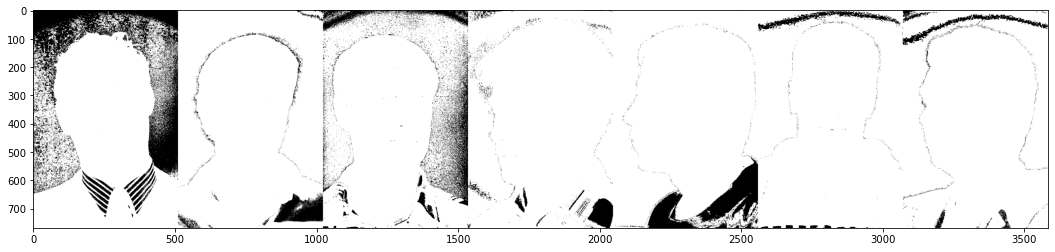

In [56]:
IMAGE = np.hstack([ np.hstack([np.hstack([np.hstack([np.hstack([np.hstack([cv2.imread("../Data/sfa/ORI/img (6).jpg"),
                                                                           cv2.imread("../Data/sfa/ORI/img (25).jpg")]),
                                                                cv2.imread("../Data/sfa/ORI/img (55).jpg")]),
                                                     cv2.imread("../Data/sfa/ORI/img (75).jpg")]),
                                          cv2.imread("../Data/sfa/ORI/img (89).jpg")]),
                             cv2.imread("../Data/sfa/ORI/img (118).jpg")]),
                  cv2.imread("../Data/sfa/ORI/img (110).jpg")])
MASK = getMask(cv2.cvtColor(cv2.cvtColor(IMAGE,cv2.COLOR_BGR2YCR_CB),cv2.COLOR_BGR2RGB))
plt.figure(figsize = (20,4))
plt.imshow(MASK,cmap='gray')

# Descente de gradient

In [5]:
def gradient_descent(cost_func, initial_params, learning_rate, num_iterations):
    params = initial_params.copy()  # Make a copy of the initial parameters
    history = []  # Track the cost function value at each iteration

    for _ in range(num_iterations):
        gradient = calculate_gradient(cost_func, params)  # Compute the gradient
        params -= learning_rate * gradient  # Update the parameters
        cost = cost_func(params)  # Compute the cost function
        history.append(cost)  # Store the cost in history

    return params, history

def calculate_gradient(cost_func, params, epsilon=1):
    num_params = len(params)
    gradient = np.zeros(num_params)

    for i in range(num_params):
        # Add a small epsilon to the i-th parameter
        params_plus = params.copy()
        params_plus[i] += epsilon

        # Subtract a small epsilon from the i-th parameter
        params_minus = params.copy()
        params_minus[i] -= epsilon

        # Calculate the partial derivative with respect to the i-th parameter
        gradient[i] = (cost_func(params_plus) - cost_func(params_minus)) / (2 * epsilon)

    return gradient

In [86]:
EvaluationGlobale()

99627 439577 0.22664288622926132 109607132 131235458 0.8351944944635313
98604 807345 0.12213366033108522 94961650 319095166 0.2975966423759613


(0.22664288622926132,
 0.12213366033108522,
 0.8351944944635313,
 0.2975966423759613)

In [87]:
def Evaluation(i):
    return Evaluer(ELLIPSES[i],MasterColors,i) - 1.6*Evaluer(ELLIPSES[i],MasterNonColors,i)

learning_rate = 0.25
num_iterations = 400

for I in range(256):
    def cost_function(params):
        setWeights(I,params)
        return 1-Evaluation(I)
    
    initial_params = getWeights(I)
    if(len(initial_params)==0):
        continue
    print('Iteration '+str(I)+' with '+str(len(initial_params))+' parameters  started at '+str(datetime.datetime.now()))
    optimized_params,hh = gradient_descent(cost_function, initial_params, learning_rate, num_iterations)
    setWeights(I,optimized_params)

Iteration 0 with 1 parameters  started at 2023-05-20 19:56:58.651607
Iteration 1 with 1 parameters  started at 2023-05-20 19:57:01.320230
Iteration 2 with 1 parameters  started at 2023-05-20 19:57:04.067768
Iteration 3 with 1 parameters  started at 2023-05-20 19:57:06.915139
Iteration 4 with 1 parameters  started at 2023-05-20 19:57:09.801688
Iteration 5 with 1 parameters  started at 2023-05-20 19:57:12.671758
Iteration 6 with 1 parameters  started at 2023-05-20 19:57:15.587874
Iteration 7 with 1 parameters  started at 2023-05-20 19:57:18.501744
Iteration 8 with 1 parameters  started at 2023-05-20 19:57:21.405464
Iteration 9 with 1 parameters  started at 2023-05-20 19:57:24.785681
Iteration 10 with 1 parameters  started at 2023-05-20 19:57:27.867806
Iteration 11 with 1 parameters  started at 2023-05-20 19:57:30.848805
Iteration 12 with 1 parameters  started at 2023-05-20 19:57:33.825965
Iteration 13 with 1 parameters  started at 2023-05-20 19:57:36.814799
Iteration 14 with 1 parameters

Iteration 117 with 4 parameters  started at 2023-05-20 20:17:20.548271
Iteration 118 with 5 parameters  started at 2023-05-20 20:17:37.759796
Iteration 119 with 4 parameters  started at 2023-05-20 20:18:02.652323
Iteration 120 with 4 parameters  started at 2023-05-20 20:18:19.833229
Iteration 121 with 3 parameters  started at 2023-05-20 20:18:36.993699
Iteration 122 with 2 parameters  started at 2023-05-20 20:18:48.539646
Iteration 123 with 2 parameters  started at 2023-05-20 20:18:55.408732
Iteration 124 with 2 parameters  started at 2023-05-20 20:19:02.234460
Iteration 125 with 2 parameters  started at 2023-05-20 20:19:09.051861
Iteration 126 with 2 parameters  started at 2023-05-20 20:19:15.812937
Iteration 127 with 3 parameters  started at 2023-05-20 20:19:22.978824
Iteration 128 with 2 parameters  started at 2023-05-20 20:19:34.198127
Iteration 129 with 2 parameters  started at 2023-05-20 20:19:41.327120
Iteration 130 with 2 parameters  started at 2023-05-20 20:19:48.427090
Iterat

Iteration 233 with 1 parameters  started at 2023-05-20 20:29:56.080542
Iteration 234 with 2 parameters  started at 2023-05-20 20:29:59.325293
Iteration 235 with 2 parameters  started at 2023-05-20 20:30:05.235431
Iteration 236 with 2 parameters  started at 2023-05-20 20:30:11.178336
Iteration 237 with 3 parameters  started at 2023-05-20 20:30:17.031253
Iteration 238 with 2 parameters  started at 2023-05-20 20:30:25.713430
Iteration 239 with 2 parameters  started at 2023-05-20 20:30:31.445370
Iteration 240 with 2 parameters  started at 2023-05-20 20:30:37.117498
Iteration 241 with 1 parameters  started at 2023-05-20 20:30:42.549333
Iteration 242 with 1 parameters  started at 2023-05-20 20:30:45.603303
Iteration 243 with 1 parameters  started at 2023-05-20 20:30:48.664352
Iteration 244 with 1 parameters  started at 2023-05-20 20:30:51.683469
Iteration 245 with 1 parameters  started at 2023-05-20 20:30:54.694290
Iteration 246 with 1 parameters  started at 2023-05-20 20:30:57.717951
Iterat

In [88]:
EvaluationGlobale()

94202 439577 0.21430147619188447 115596088 131235458 0.880829691621909
93610 807345 0.1159479528578241 43232861 319095166 0.13548579109468553


(0.21430147619188447,
 0.1159479528578241,
 0.880829691621909,
 0.13548579109468553)

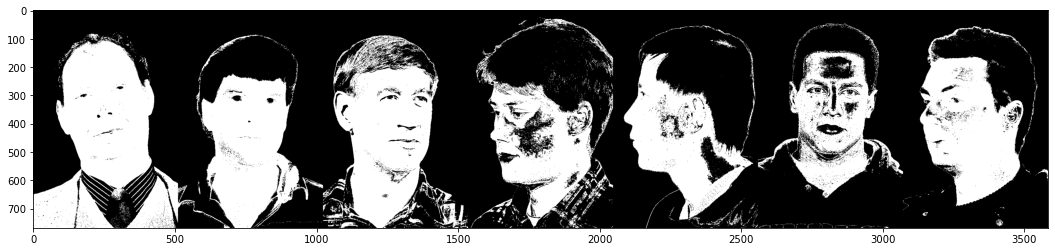

In [89]:
IMAGE = np.hstack([ np.hstack([np.hstack([np.hstack([np.hstack([np.hstack([cv2.imread("../Data/sfa/ORI/img (6).jpg"),
                                                                           cv2.imread("../Data/sfa/ORI/img (25).jpg")]),
                                                                cv2.imread("../Data/sfa/ORI/img (55).jpg")]),
                                                     cv2.imread("../Data/sfa/ORI/img (75).jpg")]),
                                          cv2.imread("../Data/sfa/ORI/img (89).jpg")]),
                             cv2.imread("../Data/sfa/ORI/img (118).jpg")]),
                  cv2.imread("../Data/sfa/ORI/img (110).jpg")])
MASK = getMask(cv2.cvtColor(cv2.cvtColor(IMAGE,cv2.COLOR_BGR2YCR_CB),cv2.COLOR_BGR2RGB))
plt.figure(figsize = (20,4))
plt.imshow(MASK,cmap='gray')

In [90]:
with open('Result GD.pkl', 'wb') as f:
    pickle.dump(ELLIPSES, f)

In [6]:
with open('Result GD.pkl', 'rb') as f:
    ELLIPSES = pickle.load(f)

In [7]:
%matplotlib qt
import random
 
def color_generator(seed):
    random.seed(seed*20+5)
    r = random.randint(0, 255)
    g = random.randint(0, 255)
    b = random.randint(0, 255)
    return (r/255, g/255, b/255)

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.set_xlabel('Cb')
ax.set_ylabel('Cr')
ax.set_zlabel('Y')

for i in range(256):
    for ELLI in ELLIPSES[i]:
        u=ELLI.HMoy      #x-position of the center
        v=ELLI.SMoy      #y-position of the center
        a=ELLI.Th*ELLI.HEct       #radius on the x-axis
        b=ELLI.Th*ELLI.SEct      #radius on the y-axis
        t_rot=ELLI.thet #rotation angle

        t = np.linspace(0, 2*pi, 100)
        Ell = np.array([a*np.cos(t) , b*np.sin(t)])  
        R_rot = np.array([[cos(t_rot) , -sin(t_rot)],[sin(t_rot) , cos(t_rot)]])  
    #2-D rotation matrix

        Ell_rot = np.zeros((2,Ell.shape[1]))
        for j in range(Ell.shape[1]):
            Ell_rot[:,j] = np.dot(R_rot,Ell[:,j])

        ax.plot( u + Ell_rot[0,:] , v + Ell_rot[1,:],np.ones((Ell_rot[0].shape))*i,color=color_generator(ELLI.cluster) )
plt.show()

# Bayesian optimisation

In [62]:
# BlackBox functions
def lesTh(nb):
    res = "Th0"
    for i in range(1,nb):
        res += ",Th"+str(i)
    return res
for i in range(1,10):
    print("def f"+str(i)+"("+lesTh(i)+"):")
    print("\tsetWeights(I,["+lesTh(i)+"])")
    print("\treturn Evaluation(I)")

def f1(Th0):
	setWeights(I,[Th0])
	return Evaluation(I)
def f2(Th0,Th1):
	setWeights(I,[Th0,Th1])
	return Evaluation(I)
def f3(Th0,Th1,Th2):
	setWeights(I,[Th0,Th1,Th2])
	return Evaluation(I)
def f4(Th0,Th1,Th2,Th3):
	setWeights(I,[Th0,Th1,Th2,Th3])
	return Evaluation(I)
def f5(Th0,Th1,Th2,Th3,Th4):
	setWeights(I,[Th0,Th1,Th2,Th3,Th4])
	return Evaluation(I)
def f6(Th0,Th1,Th2,Th3,Th4,Th5):
	setWeights(I,[Th0,Th1,Th2,Th3,Th4,Th5])
	return Evaluation(I)
def f7(Th0,Th1,Th2,Th3,Th4,Th5,Th6):
	setWeights(I,[Th0,Th1,Th2,Th3,Th4,Th5,Th6])
	return Evaluation(I)
def f8(Th0,Th1,Th2,Th3,Th4,Th5,Th6,Th7):
	setWeights(I,[Th0,Th1,Th2,Th3,Th4,Th5,Th6,Th7])
	return Evaluation(I)
def f9(Th0,Th1,Th2,Th3,Th4,Th5,Th6,Th7,Th8):
	setWeights(I,[Th0,Th1,Th2,Th3,Th4,Th5,Th6,Th7,Th8])
	return Evaluation(I)


In [63]:
def f1(Th0):
	setWeights(I,[Th0])
	return Evaluation(I)
def f2(Th0,Th1):
	setWeights(I,[Th0,Th1])
	return Evaluation(I)
def f3(Th0,Th1,Th2):
	setWeights(I,[Th0,Th1,Th2])
	return Evaluation(I)
def f4(Th0,Th1,Th2,Th3):
	setWeights(I,[Th0,Th1,Th2,Th3])
	return Evaluation(I)
def f5(Th0,Th1,Th2,Th3,Th4):
	setWeights(I,[Th0,Th1,Th2,Th3,Th4])
	return Evaluation(I)
def f6(Th0,Th1,Th2,Th3,Th4,Th5):
	setWeights(I,[Th0,Th1,Th2,Th3,Th4,Th5])
	return Evaluation(I)
def f7(Th0,Th1,Th2,Th3,Th4,Th5,Th6):
	setWeights(I,[Th0,Th1,Th2,Th3,Th4,Th5,Th6])
	return Evaluation(I)
def f8(Th0,Th1,Th2,Th3,Th4,Th5,Th6,Th7):
	setWeights(I,[Th0,Th1,Th2,Th3,Th4,Th5,Th6,Th7])
	return Evaluation(I)
def f9(Th0,Th1,Th2,Th3,Th4,Th5,Th6,Th7,Th8):
	setWeights(I,[Th0,Th1,Th2,Th3,Th4,Th5,Th6,Th7,Th8])
	return Evaluation(I)

In [92]:
def getBounds(nb):
    Bounds = {}
    for i in range(nb):
        Bounds['Th'+str(i)] = (0.1,5)
    return Bounds


def Evaluation(i):
    return Evaluer(ELLIPSES[i],MasterColors,i) - 1.6*Evaluer(ELLIPSES[i],MasterNonColors,i)

In [97]:
EvaluationGlobale()

99627 439577 0.22664288622926132 109607132 131235458 0.8351944944635313
98604 807345 0.12213366033108522 94961650 319095166 0.2975966423759613


(0.22664288622926132,
 0.12213366033108522,
 0.8351944944635313,
 0.2975966423759613)

In [98]:
for I in range(256):
    NB = len(ELLIPSES[I])
    if(NB==0):
        continue

    black_box_function = globals()["f"+str(NB)]

    # Bounded region of parameter space
    pbounds = getBounds(NB) #{'x': (2, 4), 'y': (-3, 3)}

    optimizer = BayesianOptimization(
        f=black_box_function,
        pbounds=pbounds,
        random_state=1,
        allow_duplicate_points=True
    )


    optimizer.maximize(
        init_points=20,
        n_iter=100,
    )

    print(optimizer.max)
    setWeights(I, list(optimizer.max['params'].values()))


|   iter    |  target   |    Th0    |
-------------------------------------
| 1         | -0.45     | 2.143     |
| 2         | -0.6      | 3.63      |
| 3         | 0.0       | 0.1006    |
| 4         | -0.45     | 1.581     |
| 5         | 0.0       | 0.8191    |
| 6         | 0.0       | 0.5525    |
| 7         | -0.15     | 1.013     |
| 8         | -0.45     | 1.793     |
| 9         | -0.45     | 2.044     |
| 10        | -0.45     | 2.74      |
| 11        | -0.45     | 2.154     |
| 12        | -0.45     | 3.458     |
| 13        | -0.15     | 1.102     |
| 14        | -0.6      | 4.403     |
| 15        | 0.0       | 0.2342    |
| 16        | -0.45     | 3.385     |
| 17        | -0.45     | 2.145     |
| 18        | -0.45     | 2.838     |
| 19        | 0.0       | 0.7879    |
| 20        | -0.15     | 1.071     |
| 21        | -0.6      | 5.0       |
| 22        | 0.0       | 0.4011    |
| 23        | 0.0       | 0.4787    |
| 24        | 0.0       | 0.1608    |
| 25        

| 21        | 0.0       | 0.3905    |
| 22        | 0.0       | 0.1593    |
| 23        | 0.0       | 0.3196    |
| 24        | -0.01074  | 0.4462    |
| 25        | -0.6      | 5.0       |
| 26        | 0.0       | 0.3584    |
| 27        | 0.0       | 0.275     |
| 28        | 0.0       | 0.126     |
| 29        | 0.0       | 0.1974    |
| 30        | 0.0       | 0.3738    |
| 31        | -0.02148  | 0.6216    |
| 32        | -0.07519  | 1.314     |
| 33        | 0.0       | 0.2967    |
| 34        | 0.0       | 0.2549    |
| 35        | 0.0       | 0.1787    |
| 36        | 0.0       | 0.375     |
| 37        | 0.0       | 0.2158    |
| 38        | 0.0       | 0.1418    |
| 39        | 0.0       | 0.1       |
| 40        | 0.0       | 0.116     |
| 41        | 0.0       | 0.3384    |
| 42        | 0.0       | 0.3741    |
| 43        | 0.0       | 0.3057    |
| 44        | 0.0       | 0.2795    |
| 45        | 0.0       | 0.2463    |
| 46        | 0.0       | 0.171     |
| 47        

| 28        | -0.2253   | 2.421     |
| 29        | -0.009123 | 1.679     |
| 30        | -0.000701 | 0.3159    |
| 31        | -0.002807 | 0.9173    |
| 32        | -0.000701 | 0.1578    |
| 33        | -0.000701 | 0.4769    |
| 34        | -0.000701 | 0.2338    |
| 35        | -0.004912 | 1.184     |
| 36        | -0.001404 | 0.7148    |
| 37        | -0.005614 | 1.314     |
| 38        | -0.000701 | 0.6034    |
| 39        | -0.000701 | 0.2752    |
| 40        | -0.002807 | 0.8716    |
| 41        | -0.000701 | 0.437     |
| 42        | -0.000701 | 0.1259    |
| 43        | -0.003509 | 0.9647    |
| 44        | -0.000701 | 0.3566    |
| 45        | -0.000701 | 0.316     |
| 46        | -0.000701 | 0.5157    |
| 47        | -0.007719 | 1.426     |
| 48        | -0.000701 | 0.1957    |
| 49        | -0.009123 | 1.634     |
| 50        | -0.000701 | 0.6846    |
| 51        | -0.000701 | 0.5786    |
| 52        | -0.000701 | 0.63      |
| 53        | -0.002105 | 0.7501    |
| 54        

| 26        | -0.02484  | 0.6612    |
| 27        | -0.01242  | 0.4484    |
| 28        | 0.0       | 0.3506    |
| 29        | 0.0       | 0.2709    |
| 30        | 0.0       | 0.1257    |
| 31        | 0.0       | 0.196     |
| 32        | 0.0       | 0.3698    |
| 33        | 0.0       | 0.2917    |
| 34        | 0.0       | 0.1767    |
| 35        | 0.0       | 0.2152    |
| 36        | 0.0       | 0.2529    |
| 37        | 0.0       | 0.3309    |
| 38        | 0.0       | 0.1131    |
| 39        | 0.0       | 0.1411    |
| 40        | 0.0       | 0.3713    |
| 41        | 0.0       | 0.1       |
| 42        | 0.0       | 0.3024    |
| 43        | 0.0       | 0.2794    |
| 44        | 0.0       | 0.168     |
| 45        | 0.0       | 0.2342    |
| 46        | 0.0       | 0.2045    |
| 47        | 0.0       | 0.3245    |
| 48        | 0.0       | 0.2576    |
| 49        | 0.0       | 0.1863    |
| 50        | 0.0       | 0.3766    |
| 51        | 0.0       | 0.1141    |
| 52        

Data point [0.1] is not unique. 1 duplicates registered. Continuing ...
| 33        | 0.0       | 0.1       |
| 34        | 0.0       | 0.1091    |
Data point [0.1] is not unique. 2 duplicates registered. Continuing ...
| 35        | 0.0       | 0.1       |
| 36        | 0.0       | 0.1176    |
| 37        | 0.0       | 0.109     |
| 38        | 0.0       | 0.1082    |
Data point [0.1] is not unique. 3 duplicates registered. Continuing ...
| 39        | 0.0       | 0.1       |
| 40        | 0.0       | 0.1178    |
| 41        | 0.0       | 0.1096    |
| 42        | 0.0       | 0.1095    |
Data point [0.1] is not unique. 4 duplicates registered. Continuing ...
| 43        | 0.0       | 0.1       |
| 44        | 0.0       | 0.1181    |
| 45        | 0.0       | 0.1096    |
Data point [0.1] is not unique. 5 duplicates registered. Continuing ...
| 46        | 0.0       | 0.1       |
| 47        | 0.0       | 0.1109    |
| 48        | 0.0       | 0.1187    |
| 49        | 0.0       | 0.1119

| 21        | -0.6      | 5.0       |
| 22        | -0.01783  | 0.3798    |
| 23        | -0.005944 | 0.1608    |
| 24        | -0.01189  | 0.2887    |
| 25        | -0.005944 | 0.1995    |
| 26        | -0.005944 | 0.1261    |
| 27        | -0.005944 | 0.215     |
| 28        | -0.005944 | 0.1004    |
| 29        | -0.005944 | 0.1257    |
| 30        | -0.005944 | 0.1822    |
| 31        | -0.005944 | 0.2149    |
| 32        | -0.005944 | 0.1481    |
| 33        | -0.005944 | 0.1003    |
| 34        | -0.005944 | 0.2156    |
| 35        | -0.005944 | 0.1172    |
| 36        | -0.005944 | 0.176     |
| 37        | -0.005944 | 0.1457    |
| 38        | -0.005944 | 0.2013    |
| 39        | -0.005944 | 0.2227    |
| 40        | -0.005944 | 0.1       |
| 41        | -0.005944 | 0.1177    |
| 42        | -0.005944 | 0.1621    |
| 43        | -0.005944 | 0.2004    |
| 44        | -0.005944 | 0.1397    |
| 45        | -0.005944 | 0.2212    |
| 46        | -0.005944 | 0.1001    |
| 47        

| 21        | -0.004957 | 0.1664    |
| 22        | -0.06735  | 0.6461    |
| 23        | -0.01487  | 0.3464    |
| 24        | -0.0347   | 0.4451    |
| 25        | -0.004957 | 0.1663    |
| 26        | -0.6      | 5.0       |
| 27        | -0.2942   | 1.307     |
| 28        | -0.6      | 4.014     |
| 29        | -0.6      | 4.701     |
| 30        | -0.5822   | 3.105     |
| 31        | -0.009915 | 0.2908    |
| 32        | -0.004957 | 0.1263    |
| 33        | 0.0       | 0.1       |
Data point [0.1] is not unique. 1 duplicates registered. Continuing ...
| 34        | 0.0       | 0.1       |
Data point [0.1] is not unique. 2 duplicates registered. Continuing ...
| 35        | 0.0       | 0.1       |
Data point [0.1] is not unique. 3 duplicates registered. Continuing ...
| 36        | 0.0       | 0.1       |
Data point [0.1] is not unique. 4 duplicates registered. Continuing ...
| 37        | 0.0       | 0.1       |
Data point [0.1] is not unique. 5 duplicates registered. Continuin

Data point [0.1] is not unique. 49 duplicates registered. Continuing ...
| 90        | 0.0       | 0.1       |
Data point [0.1] is not unique. 50 duplicates registered. Continuing ...
| 91        | 0.0       | 0.1       |
Data point [0.1] is not unique. 51 duplicates registered. Continuing ...
| 92        | 0.0       | 0.1       |
Data point [0.1] is not unique. 52 duplicates registered. Continuing ...
| 93        | 0.0       | 0.1       |
Data point [0.1] is not unique. 53 duplicates registered. Continuing ...
| 94        | 0.0       | 0.1       |
| 95        | 0.0       | 0.1001    |
Data point [0.1] is not unique. 54 duplicates registered. Continuing ...
| 96        | 0.0       | 0.1       |
Data point [0.1] is not unique. 55 duplicates registered. Continuing ...
| 97        | 0.0       | 0.1       |
| 98        | 0.0       | 0.1002    |
Data point [0.1] is not unique. 56 duplicates registered. Continuing ...
| 99        | 0.0       | 0.1       |
Data point [0.1] is not unique. 57 d

Data point [0.1] is not unique. 23 duplicates registered. Continuing ...
| 53        | 0.0       | 0.1       |
Data point [0.1] is not unique. 24 duplicates registered. Continuing ...
| 54        | 0.0       | 0.1       |
Data point [0.1] is not unique. 25 duplicates registered. Continuing ...
| 55        | 0.0       | 0.1       |
Data point [0.1] is not unique. 26 duplicates registered. Continuing ...
| 56        | 0.0       | 0.1       |
Data point [0.1] is not unique. 27 duplicates registered. Continuing ...
| 57        | 0.0       | 0.1       |
Data point [0.1] is not unique. 28 duplicates registered. Continuing ...
| 58        | 0.0       | 0.1       |
Data point [0.1] is not unique. 29 duplicates registered. Continuing ...
| 59        | 0.0       | 0.1       |
Data point [0.1] is not unique. 30 duplicates registered. Continuing ...
| 60        | 0.0       | 0.1       |
Data point [0.1] is not unique. 31 duplicates registered. Continuing ...
| 61        | 0.0       | 0.1       |
D

Data point [0.1] is not unique. 78 duplicates registered. Continuing ...
| 113       | 0.0       | 0.1       |
Data point [0.1] is not unique. 79 duplicates registered. Continuing ...
| 114       | 0.0       | 0.1       |
Data point [0.1] is not unique. 80 duplicates registered. Continuing ...
| 115       | 0.0       | 0.1       |
| 116       | 0.0       | 0.1005    |
Data point [0.1] is not unique. 81 duplicates registered. Continuing ...
| 117       | 0.0       | 0.1       |
Data point [0.1] is not unique. 82 duplicates registered. Continuing ...
| 118       | 0.0       | 0.1       |
| 119       | 0.0       | 0.1001    |
Data point [0.1] is not unique. 83 duplicates registered. Continuing ...
| 120       | 0.0       | 0.1       |
{'target': 0.0, 'params': {'Th0': 0.10056043660498995}}
|   iter    |  target   |    Th0    |
-------------------------------------
| 1         | -0.4781   | 2.143     |
| 2         | -0.6      | 3.63      |
| 3         | -0.002005 | 0.1006    |
| 4         

| 100       | -0.002005 | 0.1296    |
| 101       | -0.002005 | 0.192     |
| 102       | -0.002005 | 0.1798    |
| 103       | -0.002005 | 0.1644    |
| 104       | -0.002005 | 0.111     |
| 105       | -0.002005 | 0.1417    |
Data point [0.1] is not unique. 13 duplicates registered. Continuing ...
| 106       | -0.002005 | 0.1       |
| 107       | -0.002005 | 0.1816    |
| 108       | -0.002005 | 0.1278    |
| 109       | -0.002005 | 0.1498    |
| 110       | -0.002005 | 0.1113    |
| 111       | -0.002005 | 0.1819    |
Data point [0.1] is not unique. 14 duplicates registered. Continuing ...
| 112       | -0.002005 | 0.1       |
| 113       | -0.002005 | 0.1651    |
| 114       | -0.002005 | 0.129     |
| 115       | -0.002005 | 0.1926    |
| 116       | -0.002005 | 0.1816    |
| 117       | -0.002005 | 0.1444    |
| 118       | -0.002005 | 0.111     |
Data point [0.1] is not unique. 15 duplicates registered. Continuing ...
| 119       | -0.002005 | 0.1       |
| 120       | -0.0020

| 94        | -0.001597 | 0.1451    |
| 95        | -0.001597 | 0.174     |
| 96        | -0.001597 | 0.1276    |
| 97        | -0.001597 | 0.1113    |
Data point [0.1] is not unique. 11 duplicates registered. Continuing ...
| 98        | -0.001597 | 0.1       |
| 99        | -0.001597 | 0.1585    |
| 100       | -0.001597 | 0.1749    |
| 101       | -0.001597 | 0.1406    |
| 102       | -0.001597 | 0.1264    |
| 103       | -0.001597 | 0.185     |
| 104       | -0.001597 | 0.1107    |
| 105       | -0.001597 | 0.1736    |
Data point [0.1] is not unique. 12 duplicates registered. Continuing ...
| 106       | -0.001597 | 0.1       |
| 107       | -0.001597 | 0.1479    |
| 108       | -0.001597 | 0.1283    |
| 109       | -0.001597 | 0.1753    |
| 110       | -0.001597 | 0.1105    |
Data point [0.1] is not unique. 13 duplicates registered. Continuing ...
| 111       | -0.001597 | 0.1       |
| 112       | -0.001597 | 0.1591    |
| 113       | -0.001597 | 0.1394    |
| 114       | -0.0015

| 83        | -0.001147 | 0.1368    |
Data point [0.1] is not unique. 13 duplicates registered. Continuing ...
| 84        | -0.001147 | 0.1       |
| 85        | -0.001147 | 0.1625    |
| 86        | -0.001147 | 0.1136    |
| 87        | -0.001147 | 0.1781    |
| 88        | -0.001147 | 0.1635    |
| 89        | -0.001147 | 0.1353    |
| 90        | -0.001147 | 0.1132    |
| 91        | -0.001147 | 0.1       |
| 92        | -0.001147 | 0.1639    |
| 93        | -0.001147 | 0.1357    |
| 94        | -0.001147 | 0.1778    |
| 95        | -0.001147 | 0.1638    |
| 96        | -0.001147 | 0.1135    |
Data point [0.1] is not unique. 14 duplicates registered. Continuing ...
| 97        | -0.001147 | 0.1       |
| 98        | -0.001147 | 0.164     |
| 99        | -0.001147 | 0.1351    |
| 100       | -0.001147 | 0.1129    |
Data point [0.1] is not unique. 15 duplicates registered. Continuing ...
| 101       | -0.001147 | 0.1       |
| 102       | -0.001147 | 0.1778    |
| 103       | -0.0011

Data point [0.1] is not unique. 7 duplicates registered. Continuing ...
| 77        | -0.000543 | 0.1       |
| 78        | -0.000543 | 0.1358    |
| 79        | -0.000543 | 0.1876    |
| 80        | -0.000543 | 0.1145    |
| 81        | -0.000543 | 0.1733    |
Data point [0.1] is not unique. 8 duplicates registered. Continuing ...
| 82        | -0.000543 | 0.1       |
| 83        | -0.000543 | 0.1512    |
| 84        | -0.000543 | 0.1329    |
| 85        | -0.000543 | 0.1749    |
| 86        | -0.000543 | 0.1138    |
Data point [0.1] is not unique. 9 duplicates registered. Continuing ...
| 87        | -0.000543 | 0.1       |
| 88        | -0.000543 | 0.1895    |
| 89        | -0.000543 | 0.1748    |
| 90        | -0.000543 | 0.1339    |
| 91        | -0.000543 | 0.1137    |
| 92        | -0.000543 | 0.1561    |
| 93        | -0.000543 | 0.1765    |
Data point [0.1] is not unique. 10 duplicates registered. Continuing ...
| 94        | -0.000543 | 0.1       |
| 95        | -0.000543 | 0

Data point [0.1] is not unique. 8 duplicates registered. Continuing ...
| 68        | -9.682e-0 | 0.1       |
| 69        | -9.682e-0 | 0.1333    |
| 70        | -9.682e-0 | 0.113     |
| 71        | -9.682e-0 | 0.1       |
| 72        | -9.682e-0 | 0.1498    |
| 73        | -9.682e-0 | 0.1665    |
| 74        | -9.682e-0 | 0.1325    |
| 75        | -9.682e-0 | 0.1126    |
| 76        | -9.682e-0 | 0.1503    |
| 77        | -9.682e-0 | 0.1003    |
| 78        | -9.682e-0 | 0.166     |
| 79        | -9.682e-0 | 0.1479    |
| 80        | -9.682e-0 | 0.1125    |
Data point [0.1] is not unique. 9 duplicates registered. Continuing ...
| 81        | -9.682e-0 | 0.1       |
| 82        | -9.682e-0 | 0.1304    |
| 83        | -9.682e-0 | 0.1512    |
| 84        | -9.682e-0 | 0.1121    |
Data point [0.1] is not unique. 10 duplicates registered. Continuing ...
| 85        | -9.682e-0 | 0.1       |
| 86        | -9.682e-0 | 0.1312    |
| 87        | -9.682e-0 | 0.164     |
| 88        | -9.682e-0

| 64        | -0.000329 | 0.1109    |
| 65        | -0.000329 | 0.1336    |
Data point [0.1] is not unique. 6 duplicates registered. Continuing ...
| 66        | -0.000329 | 0.1       |
| 67        | -0.000329 | 0.1243    |
| 68        | -0.000329 | 0.1437    |
| 69        | -0.000329 | 0.1102    |
| 70        | -0.000329 | 0.1333    |
Data point [0.1] is not unique. 7 duplicates registered. Continuing ...
| 71        | -0.000329 | 0.1       |
| 72        | -0.000329 | 0.1246    |
| 73        | -0.000329 | 0.1422    |
| 74        | -0.000329 | 0.1088    |
| 75        | -0.000329 | 0.1337    |
| 76        | -0.000329 | 0.1102    |
| 77        | -0.000329 | 0.1248    |
Data point [0.1] is not unique. 8 duplicates registered. Continuing ...
| 78        | -0.000329 | 0.1       |
| 79        | -0.000329 | 0.1       |
| 80        | -0.000329 | 0.138     |
| 81        | -0.000329 | 0.1102    |
| 82        | -0.000329 | 0.125     |
| 83        | -0.000658 | 0.1448    |
| 84        | -0.000329 

| 51        | -0.000155 | 0.1373    |
Data point [0.1] is not unique. 5 duplicates registered. Continuing ...
| 52        | -7.766e-0 | 0.1       |
| 53        | -7.766e-0 | 0.1136    |
| 54        | -7.766e-0 | 0.1002    |
| 55        | -7.766e-0 | 0.1131    |
| 56        | -7.766e-0 | 0.1001    |
| 57        | -0.000233 | 0.1974    |
Data point [0.1] is not unique. 6 duplicates registered. Continuing ...
| 58        | -7.766e-0 | 0.1       |
| 59        | -0.000155 | 0.135     |
| 60        | -7.766e-0 | 0.112     |
| 61        | -0.000310 | 0.2417    |
Data point [0.1] is not unique. 7 duplicates registered. Continuing ...
| 62        | -7.766e-0 | 0.1       |
| 63        | -7.766e-0 | 0.112     |
Data point [0.1] is not unique. 8 duplicates registered. Continuing ...
| 64        | -7.766e-0 | 0.1       |
| 65        | -7.766e-0 | 0.112     |
| 66        | -7.766e-0 | 0.1002    |
Data point [0.1] is not unique. 9 duplicates registered. Continuing ...
| 67        | -7.766e-0 | 0.1   

| 26        | -2.226e-0 | 0.1       |
| 27        | -4.452e-0 | 0.1627    |
| 28        | -0.000779 | 0.6557    |
Data point [0.1] is not unique. 1 duplicates registered. Continuing ...
| 29        | -2.226e-0 | 0.1       |
| 30        | -0.000133 | 0.25      |
Data point [0.1] is not unique. 2 duplicates registered. Continuing ...
| 31        | -2.226e-0 | 0.1       |
| 32        | -4.452e-0 | 0.1515    |
Data point [0.1] is not unique. 3 duplicates registered. Continuing ...
| 33        | -2.226e-0 | 0.1       |
| 34        | -0.000400 | 0.4484    |
| 35        | -0.000200 | 0.3177    |
| 36        | -4.452e-0 | 0.1493    |
Data point [0.1] is not unique. 4 duplicates registered. Continuing ...
| 37        | -2.226e-0 | 0.1       |
| 38        | -6.678e-0 | 0.2078    |
| 39        | -4.452e-0 | 0.1428    |
Data point [0.1] is not unique. 5 duplicates registered. Continuing ...
| 40        | -2.226e-0 | 0.1       |
Data point [0.1] is not unique. 6 duplicates registered. Continuing ..

Data point [0.1] is not unique. 42 duplicates registered. Continuing ...
| 106       | -2.226e-0 | 0.1       |
| 107       | -4.452e-0 | 0.125     |
Data point [0.1] is not unique. 43 duplicates registered. Continuing ...
| 108       | -2.226e-0 | 0.1       |
Data point [0.1] is not unique. 44 duplicates registered. Continuing ...
| 109       | -2.226e-0 | 0.1       |
Data point [0.1] is not unique. 45 duplicates registered. Continuing ...
| 110       | -2.226e-0 | 0.1       |
Data point [0.1] is not unique. 46 duplicates registered. Continuing ...
| 111       | -2.226e-0 | 0.1       |
| 112       | -4.452e-0 | 0.125     |
Data point [0.1] is not unique. 47 duplicates registered. Continuing ...
| 113       | -2.226e-0 | 0.1       |
Data point [0.1] is not unique. 48 duplicates registered. Continuing ...
| 114       | -2.226e-0 | 0.1       |
Data point [0.1] is not unique. 49 duplicates registered. Continuing ...
| 115       | -2.226e-0 | 0.1       |
| 116       | -4.452e-0 | 0.1248    

| 101       | 0.002525  | 1.066     |
| 102       | 0.002516  | 1.075     |
| 103       | 0.002507  | 1.075     |
| 104       | 0.002525  | 1.066     |
| 105       | 0.002516  | 1.075     |
| 106       | 0.002525  | 1.066     |
| 107       | 0.002507  | 1.075     |
| 108       | 0.002525  | 1.066     |
| 109       | 0.002516  | 1.075     |
| 110       | 0.002525  | 1.066     |
| 111       | 0.002516  | 1.075     |
| 112       | 0.00249   | 1.102     |
| 113       | 0.002525  | 1.066     |
| 114       | 0.002516  | 1.074     |
| 115       | 0.002516  | 1.073     |
| 116       | 0.002525  | 1.065     |
| 117       | 0.002516  | 1.073     |
| 118       | 0.002525  | 1.065     |
| 119       | 0.002516  | 1.073     |
| 120       | 0.002516  | 1.073     |
{'target': 0.002525133752719122, 'params': {'Th0': 1.0706972965159063}}
|   iter    |  target   |    Th0    |
-------------------------------------
| 1         | -0.1658   | 2.143     |
| 2         | -0.5112   | 3.63      |
| 3         | 0.

| 110       | 0.02644   | 1.179     |
| 111       | 0.02644   | 1.179     |
| 112       | 0.02644   | 1.179     |
| 113       | 0.02644   | 1.179     |
| 114       | 0.02644   | 1.179     |
| 115       | 0.02644   | 1.179     |
| 116       | 0.02644   | 1.18      |
| 117       | 0.02644   | 1.179     |
| 118       | 0.02644   | 1.179     |
| 119       | 0.02644   | 1.179     |
| 120       | 0.02644   | 1.179     |
{'target': 0.02644198385781643, 'params': {'Th0': 1.1760974950677965}}
|   iter    |  target   |    Th0    |
-------------------------------------
| 1         | -0.1708   | 2.143     |
| 2         | -0.5358   | 3.63      |
| 3         | 0.0002197 | 0.1006    |
| 4         | -0.02919  | 1.581     |
| 5         | 0.01582   | 0.8191    |
| 6         | 0.007031  | 0.5525    |
| 7         | 0.02395   | 1.013     |
| 8         | -0.07521  | 1.793     |
| 9         | -0.1221   | 2.044     |
| 10        | -0.3578   | 2.74      |
| 11        | -0.1736   | 2.154     |
| 12        | -0.

| 119       | -0.4624   | 3.102     |
| 120       | 0.0254    | 1.164     |
{'target': 0.026056056687482898, 'params': {'Th0': 1.1719037998155224}}
|   iter    |  target   |    Th0    |
-------------------------------------
| 1         | -0.2661   | 2.143     |
| 2         | -0.5818   | 3.63      |
| 3         | 0.0001574 | 0.1006    |
| 4         | -0.1144   | 1.581     |
| 5         | 0.01417   | 0.8191    |
| 6         | 0.006612  | 0.5525    |
| 7         | 0.0001574 | 1.013     |
| 8         | -0.1697   | 1.793     |
| 9         | -0.2388   | 2.044     |
| 10        | -0.4398   | 2.74      |
| 11        | -0.2687   | 2.154     |
| 12        | -0.5584   | 3.458     |
| 13        | -0.009996 | 1.102     |
| 14        | -0.6      | 4.403     |
| 15        | 0.001259  | 0.2342    |
| 16        | -0.556    | 3.385     |
| 17        | -0.2687   | 2.145     |
| 18        | -0.4679   | 2.838     |
| 19        | 0.01338   | 0.7879    |
| 20        | -0.007871 | 1.071     |
| 21        | 0.

| 21        | -0.6      | 5.0       |
| 22        | -0.04885  | 1.32      |
| 23        | 0.002777  | 0.3963    |
| 24        | 0.007553  | 0.6669    |
| 25        | 0.001115  | 0.9137    |
| 26        | 0.003776  | 0.4743    |
| 27        | 0.008886  | 0.7307    |
| 28        | 0.0003332 | 0.1603    |
| 29        | 0.009774  | 0.769     |
| 30        | 0.01033   | 0.7901    |
| 31        | 0.01033   | 0.7891    |
| 32        | 0.01033   | 0.7895    |
| 33        | 0.01033   | 0.7889    |
| 34        | 0.01033   | 0.7883    |
| 35        | 0.01033   | 0.7837    |
| 36        | 0.00802   | 0.792     |
| 37        | 0.006331  | 0.6149    |
| 38        | 0.009774  | 0.7717    |
| 39        | 0.01022   | 0.7768    |
| 40        | 0.01022   | 0.777     |
| 41        | 0.01022   | 0.7768    |
| 42        | 0.01022   | 0.7764    |
| 43        | 0.01022   | 0.7771    |
| 44        | 0.01022   | 0.7773    |
| 45        | 0.01022   | 0.7775    |
| 46        | 0.01022   | 0.7775    |
| 47        

| 30        | 0.008492  | 0.636     |
| 31        | 0.008608  | 0.6374    |
| 32        | 0.008725  | 0.6391    |
| 33        | 0.008725  | 0.6411    |
| 34        | 0.008725  | 0.6425    |
| 35        | 0.008725  | 0.6437    |
| 36        | 0.008725  | 0.6445    |
| 37        | 0.008725  | 0.6451    |
| 38        | 0.008725  | 0.6456    |
| 39        | 0.008725  | 0.6455    |
| 40        | 0.008725  | 0.6461    |
| 41        | 0.008725  | 0.6463    |
| 42        | 0.008725  | 0.6464    |
| 43        | 0.008725  | 0.6464    |
| 44        | 0.008725  | 0.6465    |
| 45        | 0.008725  | 0.6465    |
| 46        | 0.005002  | 0.4863    |
| 47        | 0.008725  | 0.6464    |
| 48        | 0.008725  | 0.6465    |
| 49        | 0.008725  | 0.6465    |
| 50        | 0.008725  | 0.6465    |
| 51        | 0.008725  | 0.6465    |
| 52        | 0.008725  | 0.6465    |
| 53        | 0.008725  | 0.6465    |
| 54        | 0.008725  | 0.6465    |
| 55        | 0.008725  | 0.6465    |
| 56        

| 40        | 0.001921  | 0.5438    |
| 41        | 0.001921  | 0.5434    |
| 42        | 0.001889  | 0.5322    |
| 43        | 0.001921  | 0.5443    |
| 44        | 0.001921  | 0.544     |
| 45        | 0.001889  | 0.5332    |
| 46        | 0.001921  | 0.5445    |
| 47        | 0.001921  | 0.5444    |
| 48        | 0.001889  | 0.534     |
| 49        | 0.001952  | 0.5451    |
| 50        | 0.001952  | 0.5452    |
| 51        | 0.001952  | 0.5454    |
| 52        | 0.001952  | 0.5454    |
| 53        | 0.001952  | 0.5454    |
| 54        | 0.001889  | 0.5367    |
| 55        | 0.001952  | 0.5465    |
| 56        | 0.001952  | 0.5464    |
| 57        | 0.001952  | 0.5466    |
| 58        | 0.001952  | 0.5466    |
| 59        | 0.001921  | 0.5381    |
| 60        | 0.001952  | 0.5481    |
| 61        | 0.001952  | 0.5469    |
| 62        | 0.001921  | 0.5391    |
| 63        | 0.001952  | 0.5475    |
| 64        | 0.001952  | 0.547     |
| 65        | 0.001952  | 0.5474    |
| 66        

| 49        | 0.00475   | 0.5604    |
| 50        | 0.00475   | 0.5488    |
| 51        | 0.00156   | 0.3257    |
| 52        | 0.00475   | 0.5612    |
| 53        | 0.00475   | 0.5608    |
| 54        | 0.00475   | 0.5606    |
| 55        | 0.00475   | 0.5492    |
| 56        | 0.00475   | 0.561     |
| 57        | 0.00475   | 0.5609    |
| 58        | 0.00475   | 0.5486    |
| 59        | 0.00475   | 0.5611    |
| 60        | 0.00475   | 0.5608    |
| 61        | 0.00475   | 0.549     |
| 62        | 0.00475   | 0.561     |
| 63        | 0.00475   | 0.5607    |
| 64        | 0.00475   | 0.5498    |
| 65        | 0.00475   | 0.5609    |
| 66        | 0.00475   | 0.5609    |
| 67        | 0.00475   | 0.5495    |
| 68        | 0.00475   | 0.5607    |
| 69        | 0.00475   | 0.5606    |
| 70        | 0.00475   | 0.5493    |
| 71        | 0.00475   | 0.5607    |
| 72        | 0.00475   | 0.5606    |
| 73        | 0.00475   | 0.5603    |
| 74        | 0.00475   | 0.5494    |
| 75        

| 58        | 0.008202  | 0.6112    |
| 59        | 0.008202  | 0.6113    |
| 60        | 0.008202  | 0.6112    |
| 61        | 0.008202  | 0.6112    |
| 62        | 0.008202  | 0.6111    |
| 63        | 0.008202  | 0.611     |
| 64        | 0.0081    | 0.6035    |
| 65        | 0.008202  | 0.6115    |
| 66        | 0.008202  | 0.6115    |
| 67        | 0.008202  | 0.6114    |
| 68        | 0.008202  | 0.6113    |
| 69        | 0.008202  | 0.6113    |
| 70        | 0.008202  | 0.6112    |
| 71        | 0.008202  | 0.6112    |
| 72        | 0.008202  | 0.6111    |
| 73        | 0.008202  | 0.611     |
| 74        | 0.008202  | 0.6115    |
| 75        | 0.008202  | 0.6052    |
| 76        | 0.008202  | 0.611     |
| 77        | 0.008202  | 0.6109    |
| 78        | 0.008202  | 0.6108    |
| 79        | 0.008202  | 0.6054    |
| 80        | 0.008202  | 0.6109    |
| 81        | 0.008202  | 0.6106    |
| 82        | 0.008202  | 0.6108    |
| 83        | 0.008202  | 0.6055    |
| 84        

| 67        | 0.007152  | 0.706     |
| 68        | 0.007152  | 0.706     |
| 69        | 0.007152  | 0.706     |
| 70        | 0.007152  | 0.706     |
| 71        | 0.007152  | 0.706     |
| 72        | 0.007152  | 0.706     |
| 73        | 0.007152  | 0.706     |
| 74        | 0.007152  | 0.706     |
| 75        | 0.007084  | 0.7054    |
| 76        | 0.007152  | 0.706     |
| 77        | 0.007152  | 0.706     |
| 78        | 0.007152  | 0.706     |
| 79        | 0.007152  | 0.7059    |
| 80        | 0.007152  | 0.7059    |
| 81        | 0.007152  | 0.7059    |
| 82        | 0.007152  | 0.7059    |
| 83        | 0.007152  | 0.7059    |
| 84        | 0.007152  | 0.7059    |
| 85        | 0.007152  | 0.7059    |
| 86        | 0.007152  | 0.7059    |
| 87        | 0.007152  | 0.7059    |
| 88        | 0.007152  | 0.7059    |
| 89        | 0.007152  | 0.7059    |
| 90        | 0.007152  | 0.7059    |
| 91        | 0.007152  | 0.7058    |
| 92        | 0.007152  | 0.7058    |
| 93        

| 76        | 0.008802  | 0.8794    |
| 77        | 0.007732  | 0.5187    |
| 78        | 0.01221   | 0.68      |
| 79        | -0.5984   | 4.019     |
| 80        | 0.004142  | 0.3657    |
| 81        | 0.01221   | 0.6826    |
| 82        | 0.01221   | 0.6834    |
| 83        | 0.01035   | 0.5849    |
| 84        | 0.01235   | 0.6836    |
| 85        | 0.01235   | 0.6837    |
| 86        | 0.01221   | 0.6831    |
| 87        | 0.01235   | 0.6836    |
| 88        | 0.002071  | 0.2764    |
| 89        | 0.01235   | 0.6845    |
| 90        | 0.01235   | 0.6839    |
| 91        | 0.01221   | 0.6834    |
| 92        | 0.01235   | 0.6838    |
| 93        | 0.01235   | 0.6837    |
| 94        | 0.01235   | 0.6837    |
| 95        | -0.07669  | 1.447     |
| 96        | 0.01235   | 0.6839    |
| 97        | 0.01221   | 0.6833    |
| 98        | 0.01235   | 0.6839    |
| 99        | 0.01235   | 0.684     |
| 100       | 0.01235   | 0.684     |
| 101       | 0.01235   | 0.684     |
| 102       

| 85        | 0.00787   | 0.6184    |
| 86        | 0.00787   | 0.6182    |
| 87        | 0.00787   | 0.6183    |
| 88        | 0.00787   | 0.6181    |
| 89        | 0.00787   | 0.6181    |
| 90        | 0.00787   | 0.618     |
| 91        | 0.00787   | 0.6179    |
| 92        | 0.00787   | 0.6179    |
| 93        | 0.00787   | 0.6177    |
| 94        | 0.00787   | 0.6179    |
| 95        | 0.00787   | 0.6171    |
| 96        | 0.00787   | 0.6182    |
| 97        | 0.00787   | 0.6176    |
| 98        | -0.0668   | 1.291     |
| 99        | 0.0004523 | 0.1585    |
| 100       | 0.00787   | 0.6167    |
| 101       | 0.00787   | 0.6169    |
| 102       | 0.00787   | 0.617     |
| 103       | 0.00787   | 0.6169    |
| 104       | 0.00787   | 0.617     |
| 105       | 0.00787   | 0.617     |
| 106       | 0.00787   | 0.6168    |
| 107       | 0.00787   | 0.6171    |
| 108       | 0.00787   | 0.6176    |
| 109       | 0.00787   | 0.6171    |
| 110       | 0.00787   | 0.617     |
| 111       

| 94        | 0.004257  | 0.6683    |
| 95        | 0.004218  | 0.6629    |
| 96        | 0.004257  | 0.6686    |
| 97        | 0.004257  | 0.6686    |
| 98        | 0.004257  | 0.6688    |
| 99        | 0.004257  | 0.6634    |
| 100       | 0.004257  | 0.6682    |
| 101       | 0.004257  | 0.6635    |
| 102       | 0.004257  | 0.6685    |
| 103       | 0.004257  | 0.6636    |
| 104       | 0.004257  | 0.6686    |
| 105       | 0.004257  | 0.6639    |
| 106       | 0.004257  | 0.6687    |
| 107       | 0.004257  | 0.6636    |
| 108       | 0.004257  | 0.6685    |
| 109       | 0.004257  | 0.6638    |
| 110       | 0.004257  | 0.6685    |
| 111       | 0.004257  | 0.6639    |
| 112       | 0.004257  | 0.6682    |
| 113       | 0.004257  | 0.6684    |
| 114       | 0.004257  | 0.6639    |
| 115       | 0.004257  | 0.6684    |
| 116       | 0.004257  | 0.6641    |
| 117       | 0.004257  | 0.6681    |
| 118       | 0.004218  | 0.6632    |
| 119       | 0.004257  | 0.6685    |
| 120       

| 103       | 0.007001  | 0.5719    |
| 104       | 0.007001  | 0.5717    |
| 105       | 0.007001  | 0.5717    |
| 106       | 0.007001  | 0.5717    |
| 107       | 0.007001  | 0.5717    |
| 108       | 0.007001  | 0.5717    |
| 109       | 0.007001  | 0.5718    |
| 110       | 0.007001  | 0.5717    |
| 111       | 0.000472  | 0.1584    |
| 112       | 0.007001  | 0.572     |
| 113       | 0.007001  | 0.5719    |
| 114       | 0.007001  | 0.5719    |
| 115       | 0.007001  | 0.5719    |
| 116       | 0.007001  | 0.5718    |
| 117       | 0.007001  | 0.5717    |
| 118       | 0.007001  | 0.5719    |
| 119       | 0.007001  | 0.5719    |
| 120       | 0.007001  | 0.5718    |
{'target': 0.0070014305506492375, 'params': {'Th0': 0.5712619363211558}}
|   iter    |  target   |    Th0    |
-------------------------------------
| 1         | -0.2988   | 2.143     |
| 2         | -0.5834   | 3.63      |
| 3         | 0.0001876 | 0.1006    |
| 4         | -0.1423   | 1.581     |
| 5         | 0

| 112       | 0.01276   | 0.7002    |
| 113       | 0.01276   | 0.7004    |
| 114       | 0.01276   | 0.7008    |
| 115       | 0.01276   | 0.7019    |
| 116       | 0.01276   | 0.7002    |
| 117       | 0.01276   | 0.7003    |
| 118       | 0.01276   | 0.7019    |
| 119       | 0.01276   | 0.7       |
| 120       | 0.01276   | 0.7001    |
{'target': 0.013036370887512777, 'params': {'Th0': 0.7077033835784613}}
|   iter    |  target   |    Th0    |
-------------------------------------
| 1         | -0.3252   | 2.143     |
| 2         | -0.5913   | 3.63      |
| 3         | 0.0002259 | 0.1006    |
| 4         | -0.1857   | 1.581     |
| 5         | 0.0002635 | 0.8191    |
| 6         | 0.005684  | 0.5525    |
| 7         | -0.02082  | 1.013     |
| 8         | -0.2458   | 1.793     |
| 9         | -0.3018   | 2.044     |
| 10        | -0.4618   | 2.74      |
| 11        | -0.3301   | 2.154     |
| 12        | -0.5789   | 3.458     |
| 13        | -0.03497  | 1.102     |
| 14        | -0

| 21        | 0.01129   | 0.6815    |
| 22        | 0.01268   | 0.7267    |
| 23        | 0.01276   | 0.729     |
| 24        | 0.01276   | 0.7296    |
| 25        | 0.01276   | 0.7297    |
| 26        | 0.01276   | 0.7297    |
| 27        | 0.01276   | 0.7297    |
| 28        | 0.01276   | 0.7295    |
| 29        | 0.01276   | 0.7294    |
| 30        | 0.01276   | 0.7293    |
| 31        | 0.004674  | 0.4179    |
| 32        | 0.01276   | 0.7295    |
| 33        | 0.01276   | 0.7294    |
| 34        | 0.01276   | 0.7292    |
| 35        | 0.01276   | 0.7289    |
| 36        | 0.01276   | 0.7286    |
| 37        | 0.01276   | 0.7281    |
| 38        | 0.01276   | 0.7276    |
| 39        | 0.01268   | 0.7268    |
| 40        | 0.01268   | 0.7273    |
| 41        | 0.01268   | 0.7271    |
| 42        | 0.01276   | 0.7305    |
| 43        | 0.01242   | 0.7248    |
| 44        | 0.01302   | 0.7337    |
| 45        | 0.01302   | 0.735     |
| 46        | 0.01302   | 0.7361    |
| 47        

| 30        | 0.008311  | 0.7099    |
| 31        | 0.002196  | 0.3172    |
| 32        | 0.008377  | 0.7127    |
| 33        | 0.00851   | 0.715     |
| 34        | 0.007376  | 0.7178    |
| 35        | 0.008111  | 0.7001    |
| 36        | 0.008111  | 0.7007    |
| 37        | 0.008178  | 0.7013    |
| 38        | 0.008178  | 0.7016    |
| 39        | 0.008178  | 0.7019    |
| 40        | 0.008244  | 0.7023    |
| 41        | 0.008244  | 0.7026    |
| 42        | 0.008244  | 0.7028    |
| 43        | 0.008244  | 0.7031    |
| 44        | 0.008244  | 0.7035    |
| 45        | 0.008244  | 0.7042    |
| 46        | 0.008244  | 0.7045    |
| 47        | 0.008244  | 0.7058    |
| 48        | 0.008244  | 0.7061    |
| 49        | 0.008178  | 0.7018    |
| 50        | 0.008311  | 0.708     |
| 51        | 0.008311  | 0.7085    |
| 52        | 0.008311  | 0.7088    |
| 53        | 0.008311  | 0.7093    |
| 54        | 0.008311  | 0.7097    |
| 55        | 0.008311  | 0.7099    |
| 56        

| 39        | 0.01275   | 0.6586    |
| 40        | 0.01243   | 0.6578    |
| 41        | 0.01243   | 0.6578    |
| 42        | 0.01243   | 0.6576    |
| 43        | 0.01243   | 0.6575    |
| 44        | 0.01243   | 0.6574    |
| 45        | 0.01243   | 0.6572    |
| 46        | 0.01243   | 0.6571    |
| 47        | 0.01243   | 0.6571    |
| 48        | 0.01243   | 0.657     |
| 49        | 0.01243   | 0.6569    |
| 50        | 0.01243   | 0.6568    |
| 51        | 0.01243   | 0.6568    |
| 52        | 0.01243   | 0.6568    |
| 53        | 0.01243   | 0.6567    |
| 54        | 0.01243   | 0.6567    |
| 55        | 0.01243   | 0.6567    |
| 56        | 0.01243   | 0.6567    |
| 57        | 0.01243   | 0.6567    |
| 58        | 0.01243   | 0.6567    |
| 59        | 0.01243   | 0.6568    |
| 60        | 0.01243   | 0.6568    |
| 61        | 0.01243   | 0.6568    |
| 62        | 0.01243   | 0.6569    |
| 63        | 0.01243   | 0.657     |
| 64        | 0.01243   | 0.657     |
| 65        

| 48        | 0.009342  | 0.6602    |
| 49        | 0.009641  | 0.6505    |
| 50        | 0.00972   | 0.6518    |
| 51        | 0.009798  | 0.653     |
| 52        | 0.009342  | 0.6601    |
| 53        | 0.009641  | 0.6503    |
| 54        | 0.00972   | 0.6514    |
| 55        | 0.00972   | 0.6521    |
| 56        | 0.01019   | 0.6593    |
| 57        | 0.009342  | 0.6609    |
| 58        | 0.00972   | 0.6512    |
| 59        | 0.00972   | 0.6518    |
| 60        | 0.00972   | 0.6524    |
| 61        | 0.01019   | 0.6584    |
| 62        | 0.01027   | 0.6597    |
| 63        | 0.009342  | 0.6613    |
| 64        | 0.009877  | 0.6534    |
| 65        | 0.009798  | 0.6533    |
| 66        | 0.009877  | 0.6537    |
| 67        | 0.009877  | 0.6535    |
| 68        | 0.009877  | 0.6535    |
| 69        | 0.009798  | 0.6533    |
| 70        | 0.009877  | 0.6535    |
| 71        | 0.009877  | 0.6535    |
| 72        | 0.009798  | 0.6531    |
| 73        | 0.01011   | 0.6574    |
| 74        

| 57        | 0.01265   | 0.7169    |
| 58        | 0.01275   | 0.7178    |
| 59        | 0.01265   | 0.7171    |
| 60        | 0.01275   | 0.7177    |
| 61        | 0.01275   | 0.7178    |
| 62        | 0.01275   | 0.7179    |
| 63        | 0.005556  | 0.951     |
| 64        | 0.01275   | 0.7177    |
| 65        | 0.01275   | 0.7179    |
| 66        | 0.01275   | 0.7181    |
| 67        | 0.01275   | 0.718     |
| 68        | 0.004512  | 0.3665    |
| 69        | 0.01275   | 0.718     |
| 70        | 0.01275   | 0.7175    |
| 71        | 0.01275   | 0.7179    |
| 72        | 0.01275   | 0.7184    |
| 73        | 0.01275   | 0.7185    |
| 74        | 0.01275   | 0.7183    |
| 75        | 0.01275   | 0.719     |
| 76        | 0.01275   | 0.7188    |
| 77        | 0.01275   | 0.7186    |
| 78        | 0.01275   | 0.719     |
| 79        | 0.01275   | 0.7193    |
| 80        | 0.0109    | 0.8013    |
| 81        | 0.01275   | 0.7194    |
| 82        | -0.5971   | 4.019     |
| 83        

| 66        | 0.02248   | 0.8257    |
| 67        | 0.02248   | 0.8255    |
| 68        | -0.6      | 4.7       |
| 69        | 0.02261   | 0.8271    |
| 70        | 0.02261   | 0.827     |
| 71        | 0.02275   | 0.8282    |
| 72        | 0.02289   | 0.829     |
| 73        | 0.02289   | 0.83      |
| 74        | -0.5076   | 3.1       |
| 75        | 0.02289   | 0.8311    |
| 76        | 0.02289   | 0.8315    |
| 77        | 0.02303   | 0.8328    |
| 78        | 0.02038   | 0.6553    |
| 79        | -0.01628  | 1.229     |
| 80        | 0.005497  | 0.3281    |
| 81        | -0.07163  | 1.457     |
| 82        | 0.02238   | 0.8347    |
| 83        | 0.0233    | 0.8342    |
| 84        | 0.001374  | 0.1631    |
| 85        | 0.0216    | 0.836     |
| 86        | 0.02316   | 0.8331    |
| 87        | 0.01223   | 0.4884    |
| 88        | 0.02072   | 0.9514    |
| 89        | 0.02281   | 0.7126    |
| 90        | -0.002102 | 1.168     |
| 91        | 0.01855   | 0.6042    |
| 92        

| 75        | 0.03136   | 0.8942    |
| 76        | 0.03047   | 0.8944    |
| 77        | 0.03047   | 0.8942    |
| 78        | 0.03136   | 0.8941    |
| 79        | 0.03047   | 0.8943    |
| 80        | 0.03136   | 0.8941    |
| 81        | 0.03047   | 0.8943    |
| 82        | 0.03136   | 0.894     |
| 83        | 0.03047   | 0.8943    |
| 84        | 0.03136   | 0.8942    |
| 85        | 0.03047   | 0.8943    |
| 86        | 0.03136   | 0.8942    |
| 87        | 0.03047   | 0.8943    |
| 88        | 0.03136   | 0.8942    |
| 89        | 0.03136   | 0.8936    |
| 90        | 0.02978   | 0.8389    |
| 91        | 0.03047   | 0.895     |
| 92        | 0.02798   | 1.033     |
| 93        | 0.03047   | 0.8947    |
| 94        | 0.03047   | 0.8943    |
| 95        | 0.02722   | 1.052     |
| 96        | 0.03047   | 0.8944    |
| 97        | 0.03047   | 0.8942    |
| 98        | 0.03136   | 0.8941    |
| 99        | 0.0295    | 0.8032    |
| 100       | 0.03124   | 0.8566    |
| 101       

| 85        | 0.005732  | 1.341     |
| 86        | 0.0385    | 0.9516    |
| 87        | 0.03934   | 0.9514    |
| 88        | -0.5841   | 4.016     |
| 89        | 0.03934   | 0.9513    |
| 90        | 0.0385    | 0.9517    |
| 91        | 0.0385    | 0.9515    |
| 92        | 0.03934   | 0.9513    |
| 93        | -0.2942   | 2.443     |
| 94        | 0.03934   | 0.9514    |
| 95        | 0.03934   | 0.9514    |
| 96        | 0.002041  | 0.1676    |
| 97        | -0.01808  | 1.491     |
| 98        | 0.0385    | 0.952     |
| 99        | 0.02442   | 1.219     |
| 100       | 0.0385    | 0.9515    |
| 101       | 0.03934   | 0.9514    |
| 102       | -0.5967   | 4.701     |
| 103       | 0.03934   | 0.951     |
| 104       | -0.4733   | 3.11      |
| 105       | -0.59     | 4.209     |
| 106       | 0.039     | 0.9495    |
| 107       | 0.03866   | 0.9489    |
| 108       | 0.039     | 0.9496    |
| 109       | 0.039     | 0.9493    |
| 110       | 0.03883   | 0.9491    |
| 111       

| 94        | -0.01037  | 1.482     |
| 95        | 0.03844   | 1.074     |
| 96        | -0.5992   | 4.702     |
| 97        | 0.03763   | 1.075     |
| 98        | 0.03844   | 1.074     |
| 99        | 0.03844   | 1.074     |
| 100       | 0.03844   | 1.075     |
| 101       | 0.03763   | 1.075     |
| 102       | 0.03844   | 1.074     |
| 103       | -0.4666   | 3.11      |
| 104       | 0.03844   | 1.075     |
| 105       | 0.03763   | 1.075     |
| 106       | 0.03829   | 1.074     |
| 107       | 0.03844   | 1.074     |
| 108       | 0.03844   | 1.074     |
| 109       | 0.02775   | 0.722     |
| 110       | -0.5751   | 3.823     |
| 111       | 0.03844   | 1.074     |
| 112       | 0.03844   | 1.074     |
| 113       | 0.03844   | 1.074     |
| 114       | 0.03763   | 1.075     |
| 115       | 0.03829   | 1.073     |
| 116       | 0.03829   | 1.073     |
| 117       | 0.03829   | 1.073     |
| 118       | 0.03829   | 1.073     |
| 119       | 0.001503  | 0.1675    |
| 120       

| 78        | 0.05169   | 0.9727    | 1.268     |
| 79        | 0.05348   | 0.9863    | 0.6442    |
| 80        | 0.05423   | 1.052     | 3.177     |
| 81        | 0.02947   | 0.6416    | 2.794     |
| 82        | 0.0493    | 1.222     | 3.273     |
| 83        | 0.04786   | 1.255     | 3.712     |
| 84        | 0.05453   | 1.078     | 2.871     |
| 85        | 0.05499   | 1.044     | 2.421     |
| 86        | 0.0542    | 1.037     | 1.678     |
| 87        | 0.03066   | 1.419     | 1.569     |
| 88        | 0.05056   | 1.127     | 1.77      |
| 89        | 0.02827   | 0.6255    | 3.674     |
| 90        | 0.0009955 | 0.1066    | 2.898     |
| 91        | 0.0482    | 1.247     | 0.4328    |
| 92        | 0.05127   | 1.165     | 2.119     |
| 93        | 0.04341   | 0.7767    | 0.1       |
| 94        | 0.05095   | 1.13      | 1.507     |
| 95        | -0.1243   | 2.007     | 1.147     |
| 96        | 0.0233    | 0.5725    | 4.18      |
| 97        | 0.01115   | 0.3868    | 1.19      |


| 55        | 0.05149   | 1.095     | 0.8802    |
| 56        | 0.05207   | 1.094     | 0.4369    |
| 57        | 0.0513    | 1.124     | 0.4683    |
| 58        | 0.04635   | 1.036     | 0.8531    |
| 59        | 0.03337   | 0.8076    | 3.041     |
| 60        | 0.0359    | 1.159     | 4.703     |
| 61        | 0.02757   | 0.8006    | 3.883     |
| 62        | 0.02352   | 1.347     | 4.16      |
| 63        | 0.01498   | 0.4755    | 1.267     |
| 64        | 0.04103   | 1.187     | 3.316     |
| 65        | 0.04922   | 1.168     | 0.9212    |
| 66        | 0.03252   | 1.366     | 1.537     |
| 67        | -0.01324  | 0.1       | 4.424     |
| 68        | 0.0394    | 1.179     | 3.656     |
| 69        | 0.05092   | 1.148     | 0.764     |
| 70        | 0.04148   | 0.9099    | 0.3604    |
| 71        | 0.04947   | 1.178     | 1.332     |
| 72        | 0.05155   | 1.128     | 1.888     |
| 73        | 0.01544   | 0.5206    | 2.692     |
| 74        | 0.05054   | 1.111     | 2.392     |


| 26        | 0.001802  | 0.1406    | 4.851     | 0.2008    |
| 27        | 0.02249   | 0.5141    | 3.397     | 1.665     |
| 28        | 0.001126  | 0.1       | 0.1       | 0.1       |
| 29        | 0.02866   | 1.389     | 0.1       | 5.0       |
| 30        | -0.009034 | 0.1       | 4.05      | 3.822     |
| 31        | 0.03686   | 0.6714    | 1.427     | 0.7756    |
| 32        | 0.02506   | 0.5963    | 0.1       | 3.094     |
| 33        | 0.04489   | 0.7513    | 3.54      | 0.1       |
| 34        | 0.06234   | 0.9326    | 5.0       | 1.002     |
| 35        | 0.02998   | 0.8098    | 3.469     | 4.99      |
| 36        | 0.04568   | 0.7711    | 0.9682    | 2.269     |
| 37        | -0.02051  | 0.1       | 3.414     | 5.0       |
| 38        | 0.05286   | 0.9113    | 5.0       | 3.402     |
| 39        | 0.03586   | 1.322     | 5.0       | 5.0       |
| 40        | 0.07062   | 1.057     | 0.136     | 0.5437    |
| 41        | 0.07311   | 1.156     | 5.0       | 0.1       |
| 42    

| 107       | 0.05742   | 0.8933    | 0.1       | 0.8068    |
| 108       | 0.0745    | 1.149     | 0.5903    | 1.538     |
| 109       | 0.07139   | 1.099     | 1.0       | 1.141     |
| 110       | 0.06645   | 1.162     | 0.1205    | 3.272     |
| 111       | 0.0684    | 1.041     | 2.576     | 0.1426    |
| 112       | 0.061     | 1.291     | 5.0       | 2.141     |
| 113       | 0.06933   | 1.203     | 3.847     | 2.455     |
| 114       | 0.07136   | 1.081     | 3.921     | 0.1161    |
| 115       | 0.07159   | 1.081     | 3.588     | 0.4711    |
| 116       | 0.06881   | 1.212     | 0.3556    | 1.305     |
| 117       | 0.06945   | 1.049     | 0.5525    | 1.862     |
| 118       | 0.06757   | 1.182     | 4.606     | 2.684     |
| 119       | 0.06796   | 1.004     | 3.975     | 0.3069    |
| 120       | 0.06134   | 1.29      | 3.241     | 0.1382    |
{'target': 0.0745002300301893, 'params': {'Th0': 1.1491419187389804, 'Th1': 0.5903422653782241, 'Th2': 1.5382879562250487}}
|   iter

| 54        | 0.02985   | 0.6504    | 0.365     | 1.743     | 0.1       |
| 55        | -0.01115  | 1.589     | 5.0       | 5.0       | 2.913     |
| 56        | -0.02052  | 1.656     | 5.0       | 5.0       | 0.1       |
| 57        | 0.03468   | 0.7065    | 1.301     | 0.1       | 1.733     |
| 58        | 0.05992   | 1.054     | 2.45      | 2.826     | 0.9609    |
| 59        | 0.05938   | 1.041     | 2.602     | 2.401     | 0.1       |
| 60        | 0.03366   | 0.9767    | 5.0       | 3.422     | 3.55      |
| 61        | 0.048     | 1.249     | 5.0       | 2.537     | 2.052     |
| 62        | 0.03315   | 1.38      | 5.0       | 2.716     | 0.1       |
| 63        | 0.02956   | 0.709     | 1.407     | 1.109     | 2.831     |
| 64        | 0.05257   | 0.9598    | 0.7571    | 4.944     | 0.976     |
| 65        | 0.04712   | 1.109     | 4.528     | 3.618     | 2.399     |
| 66        | 0.04247   | 0.7986    | 1.103     | 3.92      | 0.7972    |
| 67        | 0.04653   | 0.9553    | 

| 21        | 0.001336  | 0.1       | 2.295     | 0.1       |
| 22        | -0.01301  | 0.1       | 5.0       | 2.074     |
| 23        | 0.001186  | 0.1       | 0.1       | 1.315     |
| 24        | -0.04884  | 0.1       | 5.0       | 5.0       |
| 25        | -0.004169 | 0.1       | 2.04      | 2.863     |
| 26        | 0.01184   | 0.442     | 3.416     | 1.437     |
| 27        | 0.0008288 | 0.1       | 0.1       | 0.1       |
| 28        | -0.01163  | 0.1       | 5.0       | 0.1       |
| 29        | 0.0418    | 0.7069    | 1.395     | 0.733     |
| 30        | 0.01924   | 0.5641    | 0.1       | 2.905     |
| 31        | 0.03961   | 0.7484    | 3.457     | 0.1       |
| 32        | 0.006072  | 1.406     | 0.2261    | 4.946     |
| 33        | -0.02475  | 0.1       | 4.001     | 3.759     |
| 34        | 0.04461   | 0.8999    | 5.0       | 1.031     |
| 35        | 0.06474   | 1.104     | 0.1       | 0.4742    |
| 36        | 0.04807   | 0.8014    | 0.9111    | 2.061     |
| 37    

| 102       | 0.05788   | 0.9217    | 2.476     | 0.1       |
| 103       | 0.06085   | 1.158     | 3.094     | 0.4822    |
| 104       | 0.06538   | 1.087     | 0.4804    | 0.4379    |
| 105       | 0.06734   | 1.155     | 2.148     | 0.29      |
| 106       | 0.06531   | 1.104     | 1.0       | 1.006     |
| 107       | 0.06626   | 1.171     | 1.01      | 2.051     |
| 108       | 0.06877   | 1.124     | 1.719     | 1.479     |
| 109       | 0.06406   | 1.27      | 0.8876    | 1.773     |
| 110       | 0.06657   | 1.091     | 1.378     | 1.037     |
| 111       | 0.06766   | 1.088     | 1.892     | 0.7656    |
| 112       | 0.06129   | 1.069     | 3.487     | 1.981     |
| 113       | 0.06748   | 1.204     | 2.139     | 1.114     |
| 114       | 0.06228   | 1.224     | 2.383     | 2.241     |
| 115       | 0.06881   | 1.136     | 2.127     | 0.8657    |
| 116       | 0.06734   | 1.095     | 1.971     | 0.1148    |
| 117       | 0.06557   | 1.107     | 1.163     | 0.4493    |
| 118   

| 59        | 0.06181   | 1.13      | 2.944     | 0.1       |
| 60        | 0.04773   | 0.9439    | 1.623     | 3.025     |
| 61        | 0.06216   | 1.013     | 1.447     | 1.762     |
| 62        | 0.06608   | 1.175     | 2.254     | 1.758     |
| 63        | 0.06123   | 1.109     | 3.41      | 0.5864    |
| 64        | 0.06171   | 1.055     | 2.882     | 2.023     |
| 65        | 0.06331   | 1.142     | 1.484     | 0.8149    |
| 66        | 0.05968   | 1.246     | 3.001     | 0.977     |
| 67        | 0.06731   | 1.189     | 0.8097    | 1.839     |
| 68        | 0.0636    | 1.229     | 0.4666    | 1.5       |
| 69        | 0.06164   | 1.211     | 1.252     | 2.113     |
| 70        | 0.064     | 1.149     | 0.372     | 1.918     |
| 71        | 0.06582   | 1.134     | 1.965     | 1.571     |
| 72        | 0.06602   | 1.151     | 0.7772    | 1.318     |
| 73        | 0.06577   | 1.162     | 2.347     | 1.036     |
| 74        | 0.06374   | 1.043     | 0.4076    | 0.5111    |
| 75    

| 21        | -0.04409  | 1.858     | 0.1       |
| 22        | 0.05645   | 1.428     | 1.189     |
| 23        | 0.0241    | 1.172     | 5.0       |
| 24        | 0.05897   | 1.046     | 3.003     |
| 25        | 0.07081   | 1.198     | 2.166     |
| 26        | 0.06821   | 1.308     | 1.747     |
| 27        | 0.045     | 1.003     | 3.603     |
| 28        | 0.07306   | 1.201     | 0.7403    |
| 29        | 0.07091   | 1.074     | 0.1202    |
| 30        | 0.07161   | 1.206     | 0.4198    |
| 31        | 0.07467   | 1.137     | 1.345     |
| 32        | -0.04779  | 0.1       | 5.0       |
| 33        | 0.07396   | 1.149     | 1.064     |
| 34        | 0.06649   | 1.13      | 2.515     |
| 35        | 0.07404   | 1.135     | 1.511     |
| 36        | 0.07469   | 1.162     | 1.237     |
| 37        | 0.07372   | 1.188     | 1.38      |
| 38        | 0.07266   | 1.122     | 0.5674    |
| 39        | 0.07318   | 1.107     | 1.219     |
| 40        | 0.07413   | 1.167     | 1.884     |


| 21        | -0.02736  | 1.85      | 0.1       |
| 22        | 0.05838   | 1.451     | 1.157     |
| 23        | 0.06075   | 1.088     | 2.844     |
| 24        | 0.04084   | 1.001     | 3.639     |
| 25        | 0.01768   | 1.197     | 5.0       |
| 26        | 0.0717    | 1.246     | 2.129     |
| 27        | 0.07014   | 1.307     | 1.68      |
| 28        | 0.06935   | 1.104     | 0.1       |
| 29        | 0.07144   | 1.231     | 0.5112    |
| 30        | 0.072     | 1.163     | 0.9838    |
| 31        | 0.07263   | 1.154     | 1.389     |
| 32        | 0.06896   | 1.139     | 2.362     |
| 33        | 0.07151   | 1.17      | 1.929     |
| 34        | 0.06935   | 1.103     | 0.343     |
| 35        | 0.07222   | 1.162     | 0.7452    |
| 36        | -0.05264  | 0.1       | 5.0       |
| 37        | 0.07365   | 1.145     | 1.608     |
| 38        | 0.07271   | 1.192     | 1.536     |
| 39        | 0.07483   | 1.078     | 1.53      |
| 40        | 0.06914   | 1.006     | 1.488     |


| 21        | -0.02515  | 1.839     | 0.1       |
| 22        | 0.05807   | 1.457     | 1.21      |
| 23        | 0.06006   | 1.102     | 2.863     |
| 24        | 0.04731   | 1.016     | 3.656     |
| 25        | 0.06879   | 1.273     | 2.075     |
| 26        | 0.07259   | 1.097     | 0.1041    |
| 27        | 0.01561   | 1.203     | 5.0       |
| 28        | 0.07227   | 1.243     | 0.5395    |
| 29        | 0.07373   | 1.194     | 1.53      |
| 30        | 0.075     | 1.163     | 0.9838    |
| 31        | 0.07336   | 1.17      | 1.245     |
| 32        | 0.07355   | 1.177     | 0.7701    |
| 33        | 0.07308   | 1.198     | 1.788     |
| 34        | 0.07143   | 1.125     | 0.3121    |
| 35        | 0.07052   | 1.273     | 0.9507    |
| 36        | -0.05607  | 0.1       | 5.0       |
| 37        | 0.07138   | 1.237     | 0.1       |
| 38        | 0.06865   | 1.124     | 2.328     |
| 39        | 0.07205   | 1.114     | 0.9807    |
| 40        | -0.6      | 5.0       | 0.1       |


| 21        | -0.02153  | 1.807     | 0.1       |
| 22        | 0.05081   | 1.413     | 1.155     |
| 23        | 0.05415   | 1.055     | 2.958     |
| 24        | 0.07234   | 1.085     | 0.1       |
| 25        | 0.03671   | 1.006     | 3.637     |
| 26        | 0.0001645 | 1.119     | 5.0       |
| 27        | 0.06934   | 1.207     | 0.4356    |
| 28        | 0.07033   | 1.092     | 1.462     |
| 29        | 0.06529   | 1.187     | 2.132     |
| 30        | 0.06896   | 1.229     | 1.73      |
| 31        | 0.06949   | 1.128     | 0.2422    |
| 32        | 0.0704    | 1.136     | 0.833     |
| 33        | 0.06826   | 1.194     | 0.1       |
| 34        | 0.06949   | 1.128     | 0.6167    |
| 35        | 0.06616   | 0.9628    | 0.1       |
| 36        | -0.06616  | 0.1       | 5.0       |
| 37        | -0.6      | 4.969     | 0.1102    |
| 38        | 0.06896   | 1.112     | 1.075     |
| 39        | 0.06012   | 1.1       | 2.508     |
| 40        | 0.06876   | 1.105     | 1.65      |


| 21        | -0.02616  | 1.805     | 0.1       |
| 22        | 0.0558    | 1.427     | 1.17      |
| 23        | 0.062     | 1.158     | 2.426     |
| 24        | 0.06202   | 1.343     | 1.88      |
| 25        | 0.04463   | 1.046     | 3.007     |
| 26        | 0.06957   | 1.259     | 0.7413    |
| 27        | 0.06643   | 1.105     | 0.1       |
| 28        | -0.005279 | 1.145     | 4.99      |
| 29        | 0.07148   | 1.209     | 0.3782    |
| 30        | 0.07094   | 1.162     | 1.337     |
| 31        | 0.07287   | 1.162     | 1.051     |
| 32        | 0.07029   | 1.143     | 0.4868    |
| 33        | 0.07281   | 1.167     | 1.158     |
| 34        | 0.07253   | 1.165     | 0.94      |
| 35        | 0.07242   | 1.223     | 1.039     |
| 36        | 0.0732    | 1.165     | 1.079     |
| 37        | 0.07152   | 1.151     | 1.084     |
| 38        | 0.07131   | 1.202     | 1.145     |
| 39        | 0.06834   | 1.123     | 0.3018    |
| 40        | 0.07265   | 1.21      | 1.01      |


| 14        | 0.02245   | 0.5167    | 0.2914    |
| 15        | 0.006712  | 0.9322    | 4.403     |
| 16        | 0.02242   | 0.5819    | 2.163     |
| 17        | -0.6      | 4.794     | 2.713     |
| 18        | -0.5308   | 3.49      | 1.646     |
| 19        | -0.5297   | 3.464     | 4.19      |
| 20        | -0.03444  | 0.1896    | 3.776     |
| 21        | -0.04065  | 1.81      | 0.1       |
| 22        | 0.04374   | 1.404     | 1.194     |
| 23        | -0.003827 | 1.184     | 5.0       |
| 24        | 0.0555    | 1.148     | 2.345     |
| 25        | 0.05581   | 1.276     | 1.859     |
| 26        | 0.06449   | 1.045     | 0.1       |
| 27        | 0.06684   | 1.184     | 0.4541    |
| 28        | 0.06583   | 1.143     | 0.8094    |
| 29        | 0.06707   | 1.068     | 1.396     |
| 30        | 0.04282   | 1.021     | 2.968     |
| 31        | 0.06818   | 1.093     | 1.145     |
| 32        | 0.06707   | 1.111     | 0.2806    |
| 33        | 0.06742   | 1.113     | 0.4618    |


| 114       | 0.06884   | 1.105     | 1.08      |
| 115       | 0.06812   | 1.082     | 1.015     |
| 116       | 0.0689    | 1.097     | 1.074     |
| 117       | 0.0689    | 1.097     | 1.074     |
| 118       | 0.06722   | 1.156     | 0.5035    |
| 119       | 0.0689    | 1.096     | 1.073     |
| 120       | 0.0689    | 1.097     | 1.073     |
{'target': 0.06922128267699362, 'params': {'Th0': 1.078143971594209, 'Th1': 1.075396683132603}}
|   iter    |  target   |    Th0    |    Th1    |
-------------------------------------------------
| 1         | -0.1622   | 2.143     | 3.63      |
| 2         | 4.971e-05 | 0.1006    | 1.581     |
| 3         | 0.05347   | 0.8191    | 0.5525    |
| 4         | 0.06327   | 1.013     | 1.793     |
| 5         | -0.1104   | 2.044     | 2.74      |
| 6         | -0.1646   | 2.154     | 3.458     |
| 7         | 0.005927  | 1.102     | 4.403     |
| 8         | -0.02475  | 0.2342    | 3.385     |
| 9         | -0.1458   | 2.145     | 2.838     |
| 10

| 91        | 0.0669    | 1.157     | 0.9981    |
| 92        | 0.06674   | 1.015     | 0.4408    |
| 93        | 0.06808   | 1.091     | 1.48      |
| 94        | 0.06487   | 1.12      | 0.6834    |
| 95        | -0.009767 | 0.6618    | 3.969     |
| 96        | -0.01179  | 1.71      | 2.036     |
| 97        | 0.02727   | 0.569     | 0.819     |
| 98        | 0.05347   | 1.068     | 2.615     |
| 99        | 0.03343   | 0.638     | 0.1       |
| 100       | 0.06636   | 0.9991    | 0.5927    |
| 101       | 0.06509   | 0.9983    | 1.659     |
| 102       | 0.06595   | 1.156     | 0.131     |
| 103       | 0.06899   | 1.079     | 1.046     |
| 104       | 0.0483    | 1.028     | 2.834     |
| 105       | 0.06766   | 1.072     | 1.067     |
| 106       | 0.06646   | 1.057     | 0.6143    |
| 107       | -0.053    | 1.627     | 4.405     |
| 108       | 0.01226   | 0.424     | 1.796     |
| 109       | 0.05777   | 0.8602    | 0.8167    |
| 110       | 0.00318   | 1.66      | 1.115     |


| 68        | 0.01906   | 1.146     | 3.903     |
| 69        | 0.06787   | 1.068     | 0.6149    |
| 70        | -0.4099   | 2.902     | 0.1234    |
| 71        | 0.04608   | 0.7706    | 0.1005    |
| 72        | 0.06864   | 1.115     | 0.6641    |
| 73        | 0.06965   | 1.077     | 1.343     |
| 74        | 0.06913   | 1.111     | 1.084     |
| 75        | 0.06827   | 1.069     | 1.14      |
| 76        | 0.07042   | 1.096     | 1.28      |
| 77        | 0.07042   | 1.096     | 1.279     |
| 78        | 0.06953   | 1.094     | 1.484     |
| 79        | 0.07042   | 1.096     | 1.279     |
| 80        | 0.07107   | 1.094     | 0.8346    |
| 81        | 0.01416   | 0.4072    | 1.163     |
| 82        | -0.03689  | 1.736     | 1.792     |
| 83        | -0.04     | 0.7695    | 5.0       |
| 84        | 0.07099   | 1.087     | 0.8355    |
| 85        | -0.007029 | 0.1       | 2.044     |
| 86        | 0.06945   | 1.105     | 0.1901    |
| 87        | 0.06884   | 1.07      | 0.8402    |


| 45        | 0.0744    | 1.103     | 0.5709    |
| 46        | 0.07384   | 1.173     | 0.8421    |
| 47        | 0.05244   | 0.9072    | 2.635     |
| 48        | 0.07429   | 1.069     | 1.018     |
| 49        | 0.0718    | 1.188     | 0.637     |
| 50        | -0.1492   | 1.957     | 5.0       |
| 51        | 0.002312  | 0.1124    | 0.8771    |
| 52        | 0.001067  | 0.1127    | 0.1477    |
| 53        | -0.01006  | 0.1041    | 2.597     |
| 54        | 0.05058   | 1.307     | 2.796     |
| 55        | -0.01172  | 1.708     | 0.7897    |
| 56        | 0.04967   | 1.389     | 2.231     |
| 57        | 0.03341   | 1.19      | 3.961     |
| 58        | 0.07279   | 1.051     | 0.452     |
| 59        | 0.07193   | 1.225     | 0.2703    |
| 60        | 0.07453   | 1.036     | 1.24      |
| 61        | 0.07237   | 1.026     | 0.6835    |
| 62        | 0.06615   | 1.279     | 1.521     |
| 63        | 0.0768    | 1.13      | 0.9535    |
| 64        | 0.04916   | 1.195     | 3.314     |


| 22        | 0.009396  | 1.13      | 4.998     |
| 23        | 0.03925   | 1.392     | 1.138     |
| 24        | 0.06749   | 1.046     | 0.1       |
| 25        | 0.06611   | 1.156     | 0.4178    |
| 26        | 0.06021   | 1.134     | 2.322     |
| 27        | 0.05123   | 1.01      | 2.954     |
| 28        | 0.05385   | 1.242     | 1.861     |
| 29        | 0.06562   | 1.038     | 1.439     |
| 30        | 0.06792   | 1.031     | 0.2751    |
| 31        | 0.06922   | 1.092     | 0.7819    |
| 32        | -0.05862  | 0.1       | 5.0       |
| 33        | 0.06942   | 1.082     | 1.03      |
| 34        | 0.0692    | 1.064     | 0.5754    |
| 35        | 0.06423   | 0.9361    | 0.1077    |
| 36        | 0.06816   | 1.066     | 0.95      |
| 37        | 0.06922   | 1.086     | 1.148     |
| 38        | 0.0708    | 1.109     | 0.6671    |
| 39        | 0.03555   | 0.9274    | 3.586     |
| 40        | 0.06703   | 1.174     | 0.7066    |
| 41        | -0.6      | 4.952     | 0.1182    |


| 21        | -0.05449  | 1.759     | 0.1       |
| 22        | 0.02812   | 1.008     | 4.999     |
| 23        | 0.03772   | 1.344     | 1.197     |
| 24        | -0.03405  | 0.1       | 5.0       |
| 25        | 0.06433   | 0.9978    | 0.1       |
| 26        | 0.06166   | 0.9332    | 1.54      |
| 27        | 0.04485   | 0.8948    | 3.488     |
| 28        | 0.05992   | 1.039     | 2.569     |
| 29        | 0.06055   | 1.114     | 2.164     |
| 30        | 0.05985   | 1.129     | 0.395     |
| 31        | 0.05374   | 0.9513    | 2.954     |
| 32        | 0.05923   | 1.141     | 1.696     |
| 33        | 0.06165   | 0.9771    | 0.2418    |
| 34        | 0.06429   | 1.072     | 0.7878    |
| 35        | 0.06379   | 0.9828    | 1.966     |
| 36        | 0.05723   | 0.8974    | 0.1       |
| 37        | 0.05893   | 1.138     | 0.1       |
| 38        | -0.6      | 5.0       | 0.1       |
| 39        | -0.04542  | 1.565     | 5.0       |
| 40        | 0.001378  | 0.1       | 0.7863    |


| 21        | -0.02642  | 1.79      | 0.1       |
| 22        | 0.04915   | 1.041     | 5.0       |
| 23        | -0.02075  | 0.1       | 5.0       |
| 24        | 0.0459    | 1.4       | 1.138     |
| 25        | 0.07077   | 1.069     | 0.1       |
| 26        | 0.07145   | 1.159     | 0.4063    |
| 27        | 0.07219   | 1.054     | 1.506     |
| 28        | 0.05843   | 0.9659    | 3.651     |
| 29        | 0.06624   | 1.212     | 1.727     |
| 30        | 0.07005   | 1.031     | 0.2751    |
| 31        | 0.06592   | 1.031     | 2.937     |
| 32        | 0.06927   | 1.108     | 2.412     |
| 33        | 0.07065   | 1.108     | 0.7537    |
| 34        | 0.07067   | 1.095     | 2.102     |
| 35        | 0.07094   | 1.071     | 0.5161    |
| 36        | 0.07317   | 1.079     | 1.235     |
| 37        | 0.06546   | 1.199     | 0.1       |
| 38        | 0.01352   | 1.462     | 4.995     |
| 39        | 0.07168   | 1.079     | 1.114     |
| 40        | 0.07095   | 1.096     | 1.314     |


| 21        | 0.0009522 | 0.1       | 2.411     | 0.1       |
| 22        | 0.001722  | 0.1       | 5.0       | 2.095     |
| 23        | 0.002222  | 0.1       | 0.1       | 1.4       |
| 24        | -0.02768  | 0.1       | 5.0       | 5.0       |
| 25        | -0.003609 | 0.1       | 2.06      | 2.916     |
| 26        | 0.001587  | 0.1406    | 4.851     | 0.2008    |
| 27        | -0.0154   | 1.558     | 0.1       | 5.0       |
| 28        | 0.0009522 | 0.1       | 0.1       | 0.1       |
| 29        | 0.02856   | 0.5661    | 3.403     | 1.76      |
| 30        | 0.03807   | 0.6822    | 1.439     | 0.7811    |
| 31        | 0.03049   | 0.6518    | 0.1       | 3.031     |
| 32        | -0.009433 | 0.1       | 4.106     | 3.743     |
| 33        | 0.04564   | 0.7692    | 3.513     | 0.1       |
| 34        | 0.05838   | 0.9195    | 5.0       | 1.045     |
| 35        | 0.05098   | 0.8272    | 0.8844    | 2.2       |
| 36        | 0.06644   | 1.063     | 0.1       | 0.7389    |
| 37    

| 102       | 0.05848   | 1.234     | 2.555     | 0.1       |
| 103       | 0.06625   | 1.143     | 3.875     | 0.1       |
| 104       | 0.06665   | 1.113     | 1.028     | 1.183     |
| 105       | 0.05199   | 1.222     | 3.647     | 3.435     |
| 106       | 0.06388   | 1.187     | 0.1       | 2.019     |
| 107       | 0.06121   | 1.227     | 1.535     | 1.661     |
| 108       | 0.06149   | 1.029     | 1.463     | 2.581     |
| 109       | 0.06442   | 1.175     | 4.628     | 0.1       |
| 110       | 0.06601   | 1.113     | 0.4758    | 0.75      |
| 111       | 0.06582   | 1.05      | 2.85      | 1.443     |
| 112       | 0.0655    | 1.04      | 4.671     | 2.096     |
| 113       | 0.06127   | 1.12      | 2.661     | 3.006     |
| 114       | 0.06397   | 1.008     | 4.263     | 1.908     |
| 115       | 0.05428   | 1.062     | 2.253     | 3.838     |
| 116       | 0.06511   | 1.146     | 3.481     | 0.2939    |
| 117       | 0.06654   | 1.146     | 4.561     | 1.528     |
| 118   

| 60        | 0.05993   | 0.91      | 2.251     | 1.623     |
| 61        | 0.06176   | 1.154     | 3.539     | 1.887     |
| 62        | 0.04058   | 1.341     | 2.564     | 5.0       |
| 63        | 0.05444   | 0.8505    | 1.931     | 0.1       |
| 64        | 0.05537   | 1.033     | 2.071     | 3.928     |
| 65        | 0.06268   | 0.9136    | 0.3021    | 0.4405    |
| 66        | 0.06503   | 1.245     | 2.126     | 0.6528    |
| 67        | 0.06598   | 0.9801    | 0.1       | 1.495     |
| 68        | 0.06778   | 1.177     | 1.119     | 1.82      |
| 69        | 0.06405   | 1.154     | 3.211     | 1.125     |
| 70        | 0.06652   | 1.069     | 1.323     | 1.447     |
| 71        | 0.05398   | 1.365     | 2.323     | 0.1284    |
| 72        | 0.06711   | 1.177     | 1.549     | 0.4338    |
| 73        | 0.0562    | 0.9757    | 0.1       | 4.054     |
| 74        | 0.06034   | 0.9785    | 2.335     | 3.011     |
| 75        | 0.06389   | 1.29      | 0.162     | 1.496     |
| 76    

| 18        | -0.5898   | 4.49      | 2.198     | 4.828     | 3.351     | 3.146     |
| 19        | 0.03139   | 0.6623    | 4.752     | 2.305     | 2.934     | 2.1       |
| 20        | 0.06323   | 1.261     | 4.527     | 2.911     | 0.1141    | 3.124     |
| 21        | -0.0353   | 0.1       | 0.1       | 0.1       | 5.0       | 0.1       |
| 22        | -0.008771 | 0.1       | 5.0       | 5.0       | 0.1       | 5.0       |
| 23        | -0.008771 | 0.1       | 5.0       | 5.0       | 0.1       | 0.1       |
| 24        | -0.04484  | 0.1       | 0.1       | 5.0       | 5.0       | 0.1       |
| 25        | -0.04484  | 0.1       | 5.0       | 4.612     | 5.0       | 5.0       |
| 26        | -0.008771 | 0.1       | 0.1       | 5.0       | 0.1       | 5.0       |
| 27        | -0.0353   | 0.1       | 5.0       | 0.1       | 5.0       | 0.1       |
| 28        | 0.0008822 | 0.1       | 0.1       | 0.1       | 0.1       | 0.1       |
| 29        | -0.03645  | 0.1       | 0.1       | 2.75

| 76        | -0.002611 | 0.1       | 1.263     | 3.322     | 1.33      | 1.132     |
| 77        | 0.06859   | 1.178     | 5.0       | 1.433     | 0.1       | 2.035     |
| 78        | 0.05538   | 0.9774    | 4.214     | 4.444     | 2.799     | 4.196     |
| 79        | 0.05531   | 0.7907    | 3.851     | 0.1       | 1.722     | 5.0       |
| 80        | 0.07109   | 1.062     | 3.035     | 1.001     | 1.104     | 4.44      |
| 81        | 0.07064   | 1.225     | 3.51      | 0.1       | 1.197     | 3.639     |
| 82        | 0.06971   | 1.013     | 4.012     | 0.8803    | 1.028     | 4.183     |
| 83        | 0.06732   | 0.9845    | 4.334     | 2.079     | 2.371     | 3.599     |
| 84        | 0.05911   | 1.342     | 2.542     | 0.1       | 0.1       | 3.853     |
| 85        | 0.0423    | 1.462     | 4.04      | 0.9269    | 0.1       | 2.934     |
| 86        | 0.05612   | 0.8072    | 1.823     | 0.1       | 1.402     | 4.246     |
| 87        | 0.07059   | 1.017     | 5.0       | 0.1 

| 20        | -0.5914   | 4.645     | 1.804     | 3.779     | 3.657     |
| 21        | -0.04769  | 0.1       | 2.325     | 0.1       | 5.0       |
| 22        | -0.02133  | 0.1       | 0.1       | 5.0       | 0.1       |
| 23        | 0.0003752 | 0.1       | 2.44      | 0.1       | 0.1       |
| 24        | -0.03634  | 0.1       | 5.0       | 5.0       | 0.1       |
| 25        | -0.007913 | 0.1       | 2.724     | 0.1       | 2.626     |
| 26        | -0.06361  | 0.1       | 5.0       | 2.118     | 5.0       |
| 27        | 0.001572  | 0.1       | 0.1       | 1.858     | 0.1       |
| 28        | -0.01435  | 0.1       | 5.0       | 0.1       | 0.1       |
| 29        | -0.007047 | 0.1       | 2.541     | 3.506     | 0.1       |
| 30        | -0.06155  | 0.1       | 0.1       | 5.0       | 5.0       |
| 31        | -0.07404  | 2.088     | 0.1       | 0.1       | 0.1       |
| 32        | -0.04715  | 0.1       | 0.1       | 1.493     | 5.0       |
| 33        | -0.07656  | 0.1       | 

| 88        | 0.06904   | 1.011     | 1.888     | 1.066     | 2.097     |
| 89        | 0.06857   | 0.9591    | 1.865     | 0.7352    | 0.4492    |
| 90        | 0.06667   | 0.9672    | 0.7461    | 2.234     | 0.1       |
| 91        | 0.05646   | 1.025     | 0.1       | 4.215     | 1.308     |
| 92        | 0.05081   | 1.25      | 5.0       | 0.1       | 0.1       |
| 93        | 0.0675    | 0.9527    | 1.408     | 0.1       | 0.1       |
| 94        | 0.06757   | 1.09      | 0.1       | 2.553     | 0.7759    |
| 95        | 0.06202   | 1.0       | 4.256     | 0.8759    | 0.7624    |
| 96        | 0.05523   | 1.062     | 5.0       | 1.392     | 1.48      |
| 97        | 0.06747   | 1.198     | 2.097     | 2.043     | 1.226     |
| 98        | 0.06793   | 1.022     | 2.304     | 0.1       | 2.137     |
| 99        | 0.06577   | 0.9817    | 2.223     | 2.661     | 0.1       |
| 100       | 0.06645   | 1.071     | 3.06      | 1.344     | 1.993     |
| 101       | 0.04462   | 1.023     | 

| 32        | -0.03314  | 0.1       | 0.1       | 1.486     | 5.0       |
| 33        | -0.07496  | 0.1       | 5.0       | 5.0       | 5.0       |
| 34        | -0.006784 | 0.1       | 0.1       | 0.1       | 3.092     |
| 35        | -0.03493  | 0.1       | 5.0       | 0.1       | 3.384     |
| 36        | -0.02641  | 0.1       | 0.1       | 5.0       | 2.405     |
| 37        | -0.03334  | 0.211     | 4.979     | 3.315     | 2.676     |
| 38        | -0.004345 | 0.1       | 0.1       | 2.693     | 2.042     |
| 39        | 0.02549   | 0.53      | 2.066     | 1.76      | 1.332     |
| 40        | -0.003631 | 1.706     | 0.1       | 3.423     | 0.1       |
| 41        | -0.05363  | 0.1       | 2.436     | 5.0       | 5.0       |
| 42        | 0.01811   | 0.6812    | 3.499     | 1.232     | 3.524     |
| 43        | -0.02535  | 0.1       | 5.0       | 2.446     | 0.1       |
| 44        | 0.02098   | 1.365     | 0.4105    | 0.1398    | 4.97      |
| 45        | 0.001328  | 0.1       | 

| 100       | 0.05865   | 1.008     | 1.058     | 2.957     | 0.1       |
| 101       | 0.06536   | 1.013     | 2.134     | 0.1       | 1.909     |
| 102       | 0.06576   | 1.075     | 0.1       | 1.196     | 2.554     |
| 103       | 0.05029   | 0.8682    | 0.1       | 1.792     | 3.281     |
| 104       | 0.06294   | 1.047     | 0.8637    | 1.643     | 2.63      |
| 105       | 0.06579   | 1.058     | 0.1       | 1.754     | 1.976     |
| 106       | 0.06672   | 1.202     | 0.1       | 1.11      | 1.753     |
| 107       | 0.06618   | 1.005     | 0.8559    | 1.703     | 0.1       |
| 108       | 0.06708   | 0.9683    | 0.1       | 1.56      | 1.112     |
| 109       | 0.06126   | 0.946     | 1.851     | 0.1       | 2.641     |
| 110       | 0.06711   | 1.028     | 1.372     | 0.5629    | 0.5774    |
| 111       | 0.06564   | 1.036     | 1.423     | 1.886     | 1.991     |
| 112       | 0.06761   | 0.9899    | 0.1       | 0.427     | 1.533     |
| 113       | 0.04525   | 0.9181    | 

| 38        | -0.03318  | 0.1       | 5.0       | 2.488     | 2.047     | 5.0       |
| 39        | -0.003329 | 0.1       | 2.334     | 0.1       | 2.512     | 0.1       |
| 40        | -0.008961 | 0.1       | 0.1       | 0.1       | 0.1       | 3.243     |
| 41        | -0.06509  | 0.1       | 0.1       | 5.0       | 2.354     | 5.0       |
| 42        | -0.0321   | 0.1       | 0.1       | 5.0       | 1.575     | 0.1       |
| 43        | -0.03675  | 0.1       | 0.1       | 0.1       | 3.035     | 5.0       |
| 44        | -0.01509  | 0.1       | 5.0       | 0.1       | 3.027     | 2.582     |
| 45        | 0.01108   | 0.7351    | 5.0       | 5.0       | 1.714     | 2.519     |
| 46        | 0.07327   | 1.176     | 5.0       | 0.1       | 0.1       | 2.514     |
| 47        | -0.005068 | 0.1       | 0.1       | 0.1       | 2.674     | 2.011     |
| 48        | -0.000763 | 0.2141    | 5.0       | 1.633     | 0.1       | 2.619     |
| 49        | -0.03747  | 0.1       | 3.093     | 5.0 

| 96        | 0.07755   | 1.082     | 1.257     | 0.1       | 1.136     | 0.1       |
| 97        | 0.05297   | 0.7638    | 0.9109    | 0.62      | 0.8429    | 1.334     |
| 98        | -0.008853 | 1.782     | 0.1       | 0.1       | 0.1       | 0.1       |
| 99        | 0.07366   | 1.195     | 2.732     | 0.1       | 0.1       | 1.849     |
| 100       | 0.07507   | 0.9599    | 2.224     | 0.1       | 1.009     | 0.8426    |
| 101       | 0.06101   | 0.9853    | 2.589     | 0.6789    | 1.041     | 3.744     |
| 102       | 0.0722    | 1.011     | 0.1       | 0.1       | 2.391     | 0.1       |
| 103       | 0.0746    | 1.112     | 5.0       | 2.329     | 0.1       | 1.323     |
| 104       | 0.07256   | 1.115     | 1.166     | 0.1       | 2.456     | 0.824     |
| 105       | 0.05831   | 1.251     | 0.9396    | 0.1       | 3.346     | 0.1       |
| 106       | -0.01811  | 1.633     | 5.0       | 5.0       | 2.101     | 0.1       |
| 107       | -0.02609  | 0.2771    | 2.218     | 5.0 

| 31        | -0.02239  | 0.1       | 0.1       | 5.0       | 0.1       | 0.1       |
| 32        | -0.03548  | 0.1       | 2.661     | 2.6       | 5.0       | 2.005     |
| 33        | -0.0449   | 0.1       | 5.0       | 0.1       | 0.1       | 5.0       |
| 34        | -0.06964  | 0.1       | 5.0       | 0.1       | 5.0       | 5.0       |
| 35        | -0.01733  | 0.1       | 2.714     | 3.949     | 0.1       | 2.538     |
| 36        | -0.06468  | 0.1       | 5.0       | 5.0       | 5.0       | 0.1       |
| 37        | -0.004156 | 0.1       | 0.1       | 2.16      | 2.508     | 0.1       |
| 38        | -0.02999  | 0.1       | 0.1       | 0.1       | 0.1       | 5.0       |
| 39        | -0.03819  | 0.1       | 3.376     | 2.839     | 1.901     | 5.0       |
| 40        | -0.004731 | 0.1       | 2.336     | 0.1       | 2.54      | 0.1       |
| 41        | -0.02719  | 0.1       | 0.1       | 5.0       | 2.423     | 2.116     |
| 42        | -0.014    | 0.1       | 0.1       | 0.1 

| 89        | 0.06501   | 0.8634    | 0.1       | 0.1       | 1.04      | 1.881     |
| 90        | 0.07481   | 1.046     | 1.14      | 0.1       | 1.067     | 0.9011    |
| 91        | 0.02685   | 1.59      | 0.1       | 0.1       | 0.1       | 0.1       |
| 92        | 0.06413   | 0.8664    | 0.1       | 1.004     | 1.196     | 1.09      |
| 93        | 0.07218   | 1.106     | 0.7614    | 0.1       | 2.168     | 1.261     |
| 94        | 0.05636   | 0.8022    | 1.344     | 0.8802    | 1.78      | 1.219     |
| 95        | 0.07599   | 1.083     | 1.104     | 0.1       | 1.376     | 2.027     |
| 96        | 0.04277   | 1.477     | 0.1       | 0.1       | 1.832     | 0.1       |
| 97        | 0.07482   | 1.159     | 0.1       | 0.1       | 1.378     | 1.09      |
| 98        | 0.0516    | 1.276     | 5.0       | 2.499     | 0.1       | 1.785     |
| 99        | 0.07496   | 1.155     | 0.817     | 0.1       | 0.1       | 1.541     |
| 100       | 0.07555   | 1.096     | 2.021     | 0.1 

| 24        | -0.05443  | 0.1       | 0.1       | 5.0       | 5.0       | 0.1       |
| 25        | -0.01106  | 0.1       | 0.1       | 5.0       | 0.1       | 2.392     |
| 26        | -0.07013  | 0.1       | 5.0       | 0.1       | 5.0       | 0.1       |
| 27        | 0.001084  | 0.1       | 0.1       | 0.1       | 0.1       | 0.1       |
| 28        | -0.09016  | 0.1       | 5.0       | 4.857     | 5.0       | 5.0       |
| 29        | -0.06342  | 0.1       | 0.1       | 2.851     | 5.0       | 5.0       |
| 30        | -0.0255   | 0.1       | 5.0       | 0.1       | 0.1       | 0.1       |
| 31        | -0.0298   | 0.1       | 1.103     | 2.876     | 0.1       | 5.0       |
| 32        | -0.04837  | 0.1       | 2.587     | 2.754     | 5.0       | 1.926     |
| 33        | -0.05535  | 0.1       | 5.0       | 0.1       | 0.1       | 5.0       |
| 34        | -0.003776 | 0.1       | 0.1       | 2.409     | 2.321     | 0.1       |
| 35        | -0.08752  | 0.1       | 5.0       | 0.1 

| 82        | 0.07287   | 1.307     | 2.076     | 0.1       | 0.1       | 1.107     |
| 83        | 0.05409   | 1.42      | 2.983     | 0.1       | 0.1       | 1.32      |
| 84        | 0.01361   | 1.694     | 0.1       | 0.1       | 0.1       | 0.1       |
| 85        | 0.0821    | 1.09      | 1.225     | 0.1       | 1.183     | 0.1       |
| 86        | 0.07333   | 0.9406    | 1.363     | 0.9001    | 0.907     | 0.8403    |
| 87        | 0.07425   | 1.17      | 0.1397    | 0.1       | 2.474     | 0.1       |
| 88        | 0.07203   | 1.067     | 1.024     | 0.8471    | 2.446     | 0.1       |
| 89        | 0.0818    | 1.165     | 1.051     | 0.1       | 2.105     | 0.958     |
| 90        | 0.06308   | 1.229     | 1.079     | 0.1       | 3.11      | 0.1       |
| 91        | 0.07981   | 1.211     | 0.9608    | 0.1       | 0.1       | 1.815     |
| 92        | 0.08112   | 1.085     | 1.521     | 0.8755    | 0.1       | 1.856     |
| 93        | 0.08377   | 1.143     | 1.398     | 0.18

| 18        | -0.5888   | 4.49      | 2.198     | 4.828     | 3.351     | 3.146     |
| 19        | 0.001412  | 0.6623    | 4.752     | 2.305     | 2.934     | 2.1       |
| 20        | 0.0455    | 1.261     | 4.527     | 2.911     | 0.1141    | 3.124     |
| 21        | -0.05127  | 0.1       | 0.1       | 0.1       | 5.0       | 0.1       |
| 22        | -0.06101  | 0.1       | 5.0       | 5.0       | 0.1       | 5.0       |
| 23        | -0.03579  | 0.1       | 5.0       | 5.0       | 0.1       | 0.1       |
| 24        | -0.05867  | 0.1       | 0.1       | 5.0       | 5.0       | 0.1       |
| 25        | -0.009173 | 0.1       | 0.1       | 5.0       | 0.1       | 2.649     |
| 26        | -0.08396  | 0.1       | 5.0       | 0.1       | 5.0       | 0.1       |
| 27        | 0.001093  | 0.1       | 0.1       | 0.1       | 0.1       | 0.1       |
| 28        | -0.0648   | 0.1       | 0.1       | 2.961     | 5.0       | 5.0       |
| 29        | -0.1015   | 0.1       | 5.0       | 5.0 

| 76        | 0.07088   | 1.264     | 0.9281    | 0.1       | 2.734     | 0.1       |
| 77        | 0.08321   | 1.176     | 1.402     | 0.6768    | 1.467     | 0.1       |
| 78        | 0.08416   | 1.286     | 1.574     | 0.1       | 1.045     | 0.9562    |
| 79        | 0.06905   | 1.432     | 1.538     | 0.1       | 1.295     | 0.1       |
| 80        | 0.07184   | 0.9567    | 0.9675    | 0.9838    | 2.393     | 0.8455    |
| 81        | 0.04462   | 0.6961    | 0.4879    | 0.4445    | 2.107     | 0.1       |
| 82        | 0.0617    | 1.47      | 2.253     | 0.1       | 0.1       | 1.199     |
| 83        | 0.07846   | 1.058     | 1.694     | 0.1       | 2.342     | 1.738     |
| 84        | 0.02513   | 0.8668    | 2.031     | 0.1       | 4.355     | 1.375     |
| 85        | 0.07778   | 0.9564    | 1.751     | 1.053     | 1.356     | 1.322     |
| 86        | 0.08362   | 1.171     | 0.9145    | 0.1       | 1.307     | 1.898     |
| 87        | 0.08374   | 1.072     | 0.685     | 0.90

| 18        | -0.5866   | 4.49      | 2.198     | 4.828     | 3.351     | 3.146     |
| 19        | -0.000523 | 0.6623    | 4.752     | 2.305     | 2.934     | 2.1       |
| 20        | 0.04878   | 1.261     | 4.527     | 2.911     | 0.1141    | 3.124     |
| 21        | -0.04652  | 0.1       | 0.1       | 0.1       | 5.0       | 0.1       |
| 22        | -0.0603   | 0.1       | 5.0       | 5.0       | 0.1       | 5.0       |
| 23        | -0.04238  | 0.1       | 5.0       | 5.0       | 0.1       | 0.1       |
| 24        | -0.06343  | 0.1       | 0.1       | 5.0       | 5.0       | 0.1       |
| 25        | -0.01698  | 0.1       | 0.1       | 5.0       | 0.1       | 2.61      |
| 26        | 0.00118   | 0.1       | 0.1       | 0.1       | 0.1       | 0.1       |
| 27        | -0.0817   | 0.1       | 5.0       | 0.1       | 5.0       | 0.1       |
| 28        | -0.05781  | 0.1       | 0.1       | 2.919     | 5.0       | 5.0       |
| 29        | -0.09811  | 0.1       | 5.0       | 5.0 

| 76        | 0.07444   | 1.263     | 2.747     | 0.5131    | 1.008     | 3.232     |
| 77        | 0.02998   | 1.666     | 0.1       | 0.1       | 0.1       | 0.1       |
| 78        | 0.0756    | 0.9814    | 2.04      | 0.1       | 0.7555    | 0.7521    |
| 79        | 0.06591   | 0.8822    | 1.403     | 0.1       | 1.289     | 3.066     |
| 80        | 0.07647   | 1.038     | 1.37      | 0.1       | 0.1       | 0.1       |
| 81        | 0.07439   | 0.9202    | 1.659     | 0.8429    | 0.9233    | 1.982     |
| 82        | 0.078     | 1.23      | 0.1       | 0.1       | 2.487     | 0.1       |
| 83        | 0.07036   | 1.304     | 1.122     | 0.1       | 2.909     | 0.1       |
| 84        | 0.08032   | 1.189     | 0.8616    | 0.1       | 2.222     | 1.139     |
| 85        | 0.07629   | 1.084     | 0.8227    | 0.9223    | 2.263     | 0.1       |
| 86        | 0.05739   | 0.8214    | 0.7016    | 0.1       | 2.182     | 0.1       |
| 87        | 0.03695   | 1.462     | 0.1       | 1.38

| 17        | -0.5897   | 4.527     | 2.911     | 0.1141    | 3.124     | 1.701     | 2.683     |
| 18        | -0.5844   | 4.441     | 1.851     | 4.552     | 3.154     | 0.1775    | 4.654     |
| 19        | -0.4775   | 3.485     | 4.987     | 0.9445    | 0.772     | 4.67      | 3.514     |
| 20        | -0.02719  | 0.4234    | 3.802     | 3.794     | 4.623     | 3.586     | 0.7089    |
| 21        | -0.03401  | 0.1       | 0.1       | 0.1       | 0.1       | 4.054     | 0.1       |
| 22        | -0.05519  | 0.1       | 0.1       | 0.1461    | 5.0       | 4.914     | 2.66      |
| 23        | -0.00663  | 0.1       | 2.847     | 0.1       | 5.0       | 0.1       | 0.1       |
| 24        | -0.001718 | 0.1       | 0.1       | 0.1       | 0.4431    | 0.1       | 3.171     |
| 25        | -0.08561  | 0.1       | 5.0       | 5.0       | 5.0       | 5.0       | 5.0       |
| 26        | 0.002646  | 0.1       | 0.1       | 2.965     | 2.588     | 0.8839    | 0.1       |
| 27        | -0.014

| 68        | 0.06199   | 1.289     | 0.1       | 1.549     | 3.916     | 2.723     | 1.835     |
| 69        | 0.05445   | 1.307     | 2.721     | 0.1       | 4.182     | 2.928     | 0.1       |
| 70        | 0.001158  | 0.1       | 0.1       | 2.767     | 0.1       | 0.1       | 2.084     |
| 71        | 0.04351   | 0.8227    | 0.1       | 2.09      | 5.0       | 1.772     | 5.0       |
| 72        | -0.03334  | 0.1       | 0.1       | 5.0       | 5.0       | 3.275     | 5.0       |
| 73        | -0.04944  | 0.1       | 1.61      | 2.916     | 0.1       | 5.0       | 2.742     |
| 74        | 0.03045   | 0.8191    | 5.0       | 1.516     | 5.0       | 2.14      | 2.088     |
| 75        | 0.04197   | 0.6659    | 2.163     | 2.419     | 2.588     | 2.326     | 1.662     |
| 76        | -0.03456  | 1.937     | 0.1       | 0.1       | 2.599     | 3.26      | 0.1       |
| 77        | 0.02438   | 0.8653    | 5.0       | 0.1       | 2.814     | 3.059     | 0.1       |
| 78        | 0.0741

| 119       | 0.06473   | 1.377     | 0.1       | 3.63      | 5.0       | 0.1       | 2.779     |
| 120       | 0.06161   | 0.8474    | 0.1       | 5.0       | 2.034     | 2.225     | 0.1       |
{'target': 0.08179578169102769, 'params': {'Th0': 1.2579943371985556, 'Th1': 1.9792157080935424, 'Th2': 1.4020344702541792, 'Th3': 3.7548326800302734, 'Th4': 1.4264240367291905, 'Th5': 0.1}}
|   iter    |  target   |    Th0    |    Th1    |    Th2    |    Th3    |    Th4    |
-------------------------------------------------------------------------------------
| 1         | -0.04521  | 2.143     | 3.63      | 0.1006    | 1.581     | 0.8191    |
| 2         | 0.01867   | 0.5525    | 1.013     | 1.793     | 2.044     | 2.74      |
| 3         | -0.048    | 2.154     | 3.458     | 1.102     | 4.403     | 0.2342    |
| 4         | -0.4181   | 3.385     | 2.145     | 2.838     | 0.7879    | 1.071     |
| 5         | -0.5589   | 4.024     | 4.844     | 1.636     | 3.492     | 4.394     |
| 6        

| 54        | 0.03373   | 0.889     | 5.0       | 0.1       | 3.129     | 1.953     |
| 55        | 0.04752   | 1.378     | 5.0       | 0.1       | 0.1       | 2.314     |
| 56        | 0.000309  | 0.1       | 0.1       | 2.364     | 0.1       | 1.759     |
| 57        | -0.001381 | 0.1       | 1.542     | 3.247     | 2.544     | 1.888     |
| 58        | 0.06857   | 0.8326    | 1.587     | 1.804     | 5.0       | 0.1       |
| 59        | 0.08538   | 1.181     | 2.049     | 3.811     | 5.0       | 0.1       |
| 60        | 0.05136   | 1.612     | 2.99      | 5.0       | 5.0       | 0.1       |
| 61        | -0.02828  | 2.098     | 0.1       | 5.0       | 5.0       | 0.1       |
| 62        | 0.05789   | 0.8251    | 2.139     | 5.0       | 5.0       | 1.633     |
| 63        | 0.07508   | 0.9168    | 2.283     | 0.1       | 5.0       | 0.1       |
| 64        | 0.03962   | 0.6803    | 2.08      | 5.0       | 5.0       | 0.1       |
| 65        | -0.03955  | 0.1       | 1.736     | 5.0 

| 112       | 0.09317   | 1.349     | 0.1       | 2.482     | 2.618     | 0.1       |
| 113       | 0.08775   | 1.195     | 0.1       | 1.119     | 3.456     | 2.191     |
| 114       | 0.07138   | 1.036     | 0.1       | 3.268     | 2.04      | 2.648     |
| 115       | 0.09652   | 1.322     | 1.1       | 0.1       | 0.1       | 0.7447    |
| 116       | 0.09634   | 1.313     | 0.1       | 0.8555    | 2.741     | 1.209     |
| 117       | 0.09546   | 1.279     | 1.851     | 0.1       | 2.783     | 0.1       |
| 118       | 0.09043   | 1.146     | 1.909     | 0.1       | 1.086     | 0.1       |
| 119       | -0.05459  | 2.085     | 5.0       | 5.0       | 5.0       | 0.1       |
| 120       | 0.09652   | 1.305     | 0.1       | 0.1       | 0.8226    | 1.175     |
{'target': 0.09711351976860894, 'params': {'Th0': 1.2099959697818208, 'Th1': 0.1, 'Th2': 1.7674120481921123, 'Th3': 3.5093749824673326, 'Th4': 1.171725077525721}}
|   iter    |  target   |    Th0    |    Th1    |    Th2    |  

| 55        | 0.07101   | 1.48      | 0.1       | 5.0       | 0.9714    |
| 56        | 0.013     | 0.363     | 0.1       | 0.1       | 0.1       |
| 57        | 0.06873   | 1.216     | 3.581     | 3.478     | 0.1       |
| 58        | 0.08459   | 1.313     | 2.573     | 2.599     | 0.1       |
| 59        | 0.08663   | 1.164     | 1.512     | 0.1       | 2.115     |
| 60        | 0.07687   | 1.408     | 1.289     | 5.0       | 1.151     |
| 61        | 0.08552   | 1.315     | 1.399     | 0.9514    | 2.335     |
| 62        | 0.08804   | 1.184     | 1.126     | 1.212     | 0.1       |
| 63        | 0.0911    | 1.212     | 0.1       | 1.673     | 0.1       |
| 64        | 0.0878    | 1.324     | 0.2312    | 4.019     | 1.538     |
| 65        | 0.06411   | 1.464     | 0.1       | 5.0       | 2.203     |
| 66        | 0.09314   | 1.231     | 0.7703    | 2.029     | 0.1       |
| 67        | 0.07852   | 1.28      | 3.294     | 3.796     | 1.22      |
| 68        | 0.05126   | 1.268     | 

| 21        | -0.007073 | 0.1       | 0.1       | 5.0       | 0.1       |
| 22        | -0.05532  | 0.1       | 2.007     | 0.1       | 5.0       |
| 23        | -0.001425 | 0.1       | 2.205     | 0.1       | 0.1       |
| 24        | -0.06656  | 0.1       | 5.0       | 5.0       | 0.1       |
| 25        | -0.003838 | 0.1       | 2.266     | 3.55      | 0.1       |
| 26        | -0.1198   | 0.1       | 5.0       | 5.0       | 5.0       |
| 27        | -0.01194  | 2.001     | 0.1       | 0.1       | 0.1       |
| 28        | -0.02551  | 0.1       | 2.609     | 0.1       | 2.646     |
| 29        | -0.06034  | 0.1       | 0.1       | 5.0       | 5.0       |
| 30        | 0.002039  | 0.1       | 0.1       | 2.06      | 0.1       |
| 31        | -0.05119  | 0.1       | 0.1       | 1.667     | 5.0       |
| 32        | -0.06656  | 0.1       | 5.0       | 0.1       | 0.1       |
| 33        | -0.1198   | 0.1       | 5.0       | 1.357     | 5.0       |
| 34        | -0.01137  | 0.1       | 

| 89        | 0.08768   | 1.106     | 1.042     | 0.1       | 1.533     |
| 90        | 0.08812   | 1.317     | 1.317     | 2.133     | 1.07      |
| 91        | 0.07866   | 1.074     | 0.1       | 2.632     | 2.145     |
| 92        | 0.08888   | 1.169     | 1.21      | 0.5173    | 1.035     |
| 93        | 0.08949   | 1.267     | 0.9781    | 1.116     | 0.1       |
| 94        | 0.08768   | 1.312     | 0.9047    | 0.8301    | 1.648     |
| 95        | 0.08942   | 1.234     | 0.1       | 1.212     | 1.208     |
| 96        | 0.08617   | 1.127     | 0.1       | 1.284     | 0.1       |
| 97        | 0.08673   | 1.108     | 0.7619    | 1.97      | 0.1       |
| 98        | 0.08789   | 1.173     | 0.1       | 0.7845    | 0.8158    |
| 99        | 0.08249   | 1.266     | 1.73      | 2.199     | 2.244     |
| 100       | 0.08156   | 1.04      | 0.1       | 2.526     | 0.1       |
| 101       | 0.0867    | 1.283     | 0.4684    | 0.9725    | 0.7795    |
| 102       | 0.08776   | 1.153     | 

| 29        | -0.1209   | 0.1       | 5.0       | 5.0       | 5.0       | 5.0       |
| 30        | -0.002145 | 0.1       | 1.537     | 3.154     | 0.1       | 5.0       |
| 31        | -0.05967  | 0.1       | 5.0       | 0.1       | 0.1       | 0.1       |
| 32        | -0.01657  | 0.1       | 2.895     | 4.114     | 0.1       | 2.505     |
| 33        | -0.1147   | 0.1       | 4.605     | 5.0       | 5.0       | 0.1       |
| 34        | -0.001928 | 0.1       | 0.1       | 2.325     | 2.285     | 0.1       |
| 35        | -0.06437  | 0.1       | 2.344     | 2.513     | 5.0       | 2.166     |
| 36        | -0.06504  | 0.1       | 5.0       | 0.1       | 0.1       | 5.0       |
| 37        | -0.005951 | 0.1       | 2.081     | 0.1       | 2.368     | 0.1       |
| 38        | -0.01105  | 0.1       | 0.1       | 5.0       | 1.987     | 5.0       |
| 39        | -0.003059 | 0.1       | 0.1       | 0.1       | 0.1       | 4.311     |
| 40        | -0.002318 | 0.1       | 0.1       | 5.0 

| 87        | 0.09389   | 1.342     | 0.1       | 3.731     | 1.741     | 3.004     |
| 88        | 0.09623   | 1.269     | 0.9947    | 4.342     | 1.843     | 2.949     |
| 89        | 0.07711   | 1.158     | 0.9496    | 3.564     | 2.752     | 4.35      |
| 90        | 0.08638   | 1.241     | 1.356     | 5.0       | 1.971     | 5.0       |
| 91        | 0.0692    | 1.309     | 0.1       | 3.354     | 3.705     | 2.482     |
| 92        | 0.08802   | 1.214     | 0.8268    | 3.957     | 2.502     | 1.495     |
| 93        | 0.08669   | 1.349     | 0.1       | 5.0       | 1.64      | 5.0       |
| 94        | 0.07124   | 1.084     | 2.802     | 2.964     | 0.1       | 4.252     |
| 95        | -0.05012  | 0.3219    | 0.1       | 0.1       | 5.0       | 3.106     |
| 96        | 0.09444   | 1.184     | 0.1       | 2.787     | 1.656     | 1.513     |
| 97        | 0.09505   | 1.157     | 0.2153    | 1.647     | 0.1445    | 1.814     |
| 98        | 0.09557   | 1.412     | 0.1       | 1.02

| 22        | -0.07184  | 0.1       | 5.0       | 5.0       | 0.1       | 5.0       |
| 23        | 0.001138  | 0.1       | 0.1       | 5.0       | 0.1       | 2.519     |
| 24        | -0.05253  | 0.1       | 0.1       | 5.0       | 5.0       | 0.1       |
| 25        | -0.05331  | 0.1       | 0.1       | 3.047     | 5.0       | 5.0       |
| 26        | -0.06742  | 0.1       | 5.0       | 5.0       | 0.1       | 0.1       |
| 27        | 0.0011    | 0.1       | 0.1       | 0.1       | 0.1       | 0.1       |
| 28        | -0.1211   | 0.1       | 5.0       | 0.1       | 5.0       | 0.1       |
| 29        | -0.1218   | 0.1       | 5.0       | 5.0       | 5.0       | 5.0       |
| 30        | -0.004392 | 0.1       | 1.4       | 3.148     | 0.1       | 5.0       |
| 31        | -0.06742  | 0.1       | 5.0       | 0.1       | 0.1       | 0.1       |
| 32        | -0.0602   | 0.1       | 2.271     | 2.724     | 5.0       | 2.062     |
| 33        | -0.01507  | 0.1       | 2.847     | 4.14

| 80        | -0.05253  | 0.1       | 0.1       | 0.1       | 5.0       | 3.093     |
| 81        | 0.07945   | 0.9711    | 1.044     | 4.202     | 0.5432    | 1.086     |
| 82        | 0.08683   | 1.418     | 0.1       | 5.0       | 0.1       | 2.766     |
| 83        | 0.05471   | 0.9914    | 0.1       | 3.203     | 3.491     | 2.346     |
| 84        | 0.03417   | 1.414     | 0.1       | 2.948     | 5.0       | 0.1       |
| 85        | 0.07209   | 1.245     | 0.1       | 3.733     | 3.275     | 0.1       |
| 86        | 0.0915    | 1.17      | 0.5142    | 4.546     | 0.8886    | 2.337     |
| 87        | 0.07449   | 1.045     | 0.3243    | 4.451     | 2.463     | 0.7527    |
| 88        | 0.05709   | 0.7745    | 1.525     | 5.0       | 0.1       | 0.7534    |
| 89        | 0.06168   | 1.505     | 2.61      | 5.0       | 1.897     | 0.1       |
| 90        | 0.08101   | 1.261     | 2.532     | 5.0       | 1.035     | 1.518     |
| 91        | 0.07291   | 1.54      | 1.795     | 4.96

| 21        | -0.002866 | 0.1       | 2.113     | 0.1       | 5.0       |
| 22        | -0.03897  | 0.1       | 0.1       | 5.0       | 0.1       |
| 23        | 0.0001211 | 0.1       | 2.25      | 0.1       | 0.1       |
| 24        | -0.09581  | 0.1       | 5.0       | 5.0       | 0.1       |
| 25        | -0.007058 | 0.1012    | 2.55      | 0.1       | 2.756     |
| 26        | -0.06057  | 0.1       | 5.0       | 2.011     | 5.0       |
| 27        | -0.01084  | 2.079     | 0.1       | 0.1       | 0.1       |
| 28        | -0.002571 | 0.1       | 0.1       | 1.852     | 5.0       |
| 29        | 0.002128  | 0.1       | 0.1       | 2.063     | 0.1       |
| 30        | -0.01864  | 0.1       | 2.434     | 3.407     | 0.1       |
| 31        | -0.03897  | 0.1       | 0.1       | 5.0       | 5.0       |
| 32        | -0.0558   | 0.1       | 5.0       | 0.1       | 0.1       |
| 33        | -0.09581  | 0.1       | 5.0       | 5.0       | 5.0       |
| 34        | 0.06411   | 1.619     | 

| 89        | 0.09533   | 1.226     | 2.031     | 0.1       | 0.7066    |
| 90        | 0.09244   | 1.115     | 1.746     | 0.1       | 1.523     |
| 91        | 0.09687   | 1.227     | 0.9221    | 1.682     | 2.208     |
| 92        | 0.09197   | 1.161     | 0.691     | 1.115     | 4.362     |
| 93        | 0.08812   | 1.193     | 2.467     | 2.026     | 2.041     |
| 94        | 0.09631   | 1.181     | 1.976     | 1.054     | 0.1       |
| 95        | 0.08862   | 1.41      | 0.1       | 1.131     | 1.746     |
| 96        | 0.08382   | 1.068     | 0.9833    | 0.1       | 5.0       |
| 97        | 0.09755   | 1.223     | 1.969     | 1.828     | 0.5225    |
| 98        | 0.09043   | 1.342     | 0.1       | 1.524     | 2.852     |
| 99        | 0.089     | 1.046     | 1.773     | 0.2668    | 0.32      |
| 100       | 0.08856   | 1.454     | 1.834     | 0.1       | 1.259     |
| 101       | 0.0676    | 1.074     | 3.087     | 1.3       | 5.0       |
| 102       | 0.09382   | 1.191     | 

| 40        | 0.09932   | 1.185     | 1.362     | 0.1       |
| 41        | 0.09226   | 1.443     | 1.745     | 2.082     |
| 42        | 0.09255   | 1.121     | 0.1       | 1.855     |
| 43        | 0.09697   | 1.149     | 0.5327    | 1.399     |
| 44        | 0.0977    | 1.397     | 1.656     | 0.5459    |
| 45        | 0.09972   | 1.304     | 1.558     | 1.326     |
| 46        | 0.08571   | 1.099     | 2.227     | 2.746     |
| 47        | 0.08708   | 1.535     | 1.583     | 0.1       |
| 48        | 0.09392   | 1.225     | 1.33      | 2.522     |
| 49        | 0.0959    | 1.122     | 2.076     | 0.5017    |
| 50        | 0.09499   | 1.261     | 2.285     | 1.634     |
| 51        | 0.07791   | 1.14      | 0.1027    | 3.58      |
| 52        | 0.09662   | 1.381     | 0.9944    | 1.132     |
| 53        | 0.07311   | 1.314     | 3.142     | 1.574     |
| 54        | 0.09902   | 1.16      | 1.757     | 0.1432    |
| 55        | 0.08971   | 1.391     | 2.288     | 0.3971    |
| 56    

| 20        | -0.5845   | 4.645     | 1.804     | 3.779     | 3.657     |
| 21        | -0.002038 | 0.1       | 2.085     | 0.1       | 5.0       |
| 22        | -0.05199  | 0.1       | 0.1       | 5.0       | 0.1       |
| 23        | -0.002639 | 0.1       | 2.205     | 0.1       | 0.1       |
| 24        | -0.117    | 0.1       | 5.0       | 5.0       | 0.1       |
| 25        | 0.003354  | 0.3227    | 2.499     | 0.1       | 2.778     |
| 26        | -0.06696  | 0.1       | 5.0       | 2.037     | 5.0       |
| 27        | -0.02814  | 2.184     | 0.1       | 0.1       | 0.1       |
| 28        | -0.000526 | 0.1       | 0.1       | 1.751     | 5.0       |
| 29        | -0.001907 | 0.1       | 0.1       | 2.049     | 0.1       |
| 30        | 0.0274    | 1.979     | 0.1       | 0.1       | 5.0       |
| 31        | -0.02425  | 0.1       | 2.399     | 3.315     | 0.1       |
| 32        | -0.0638   | 0.1       | 5.0       | 0.1       | 0.1       |
| 33        | -0.05199  | 0.1       | 

| 88        | 0.08269   | 1.369     | 2.935     | 1.339     | 5.0       |
| 89        | 0.09358   | 1.253     | 1.551     | 2.417     | 1.357     |
| 90        | 0.09207   | 1.435     | 1.575     | 2.2       | 5.0       |
| 91        | 0.1008    | 1.192     | 0.1       | 1.479     | 3.037     |
| 92        | 0.1009    | 1.253     | 0.9941    | 0.1287    | 4.27      |
| 93        | 0.1007    | 1.169     | 0.1       | 0.6572    | 3.167     |
| 94        | 0.1004    | 1.248     | 0.1       | 1.476     | 0.1       |
| 95        | 0.09919   | 1.351     | 0.1       | 1.682     | 0.9426    |
| 96        | 0.09758   | 1.248     | 0.5311    | 2.012     | 5.0       |
| 97        | 0.102     | 1.333     | 1.145     | 1.37      | 2.879     |
| 98        | 0.1037    | 1.347     | 1.52      | 0.354     | 2.491     |
| 99        | 0.1021    | 1.201     | 0.1       | 1.566     | 3.796     |
| 100       | 0.102     | 1.335     | 0.6865    | 0.8274    | 0.9084    |
| 101       | 0.1024    | 1.389     | 

| 32        | -0.06158  | 0.1       | 5.0       | 0.1       | 0.1       |
| 33        | -0.001122 | 0.1       | 0.1       | 0.1       | 3.746     |
| 34        | -0.03826  | 0.2164    | 0.6498    | 4.925     | 3.886     |
| 35        | -0.1119   | 0.1       | 5.0       | 5.0       | 5.0       |
| 36        | 0.03046   | 1.896     | 0.1       | 3.11      | 0.1       |
| 37        | -0.05338  | 2.256     | 0.1       | 0.1       | 2.556     |
| 38        | 0.1015    | 1.075     | 1.518     | 1.291     | 3.823     |
| 39        | 0.09071   | 1.581     | 1.858     | 0.1       | 4.303     |
| 40        | -0.06882  | 0.1       | 5.0       | 0.1       | 5.0       |
| 41        | 0.1076    | 1.224     | 1.83      | 1.554     | 2.082     |
| 42        | 0.05162   | 0.7785    | 0.1       | 2.865     | 1.796     |
| 43        | 0.09949   | 1.477     | 1.98      | 0.6822    | 3.129     |
| 44        | 0.109     | 1.379     | 0.9345    | 1.818     | 0.972     |
| 45        | 0.06896   | 0.8027    | 

| 99        | 0.1053    | 1.289     | 1.653     | 1.816     | 3.904     |
| 100       | 0.1113    | 1.368     | 1.47      | 1.104     | 1.057     |
| 101       | 0.1087    | 1.316     | 1.598     | 1.417     | 3.252     |
| 102       | 0.1049    | 1.437     | 1.344     | 0.8851    | 0.1       |
| 103       | 0.105     | 1.238     | 0.9555    | 0.1       | 2.901     |
| 104       | 0.1028    | 1.168     | 1.116     | 2.269     | 1.152     |
| 105       | 0.108     | 1.265     | 0.1       | 1.803     | 0.7384    |
| 106       | 0.09848   | 1.253     | 2.295     | 2.239     | 0.1       |
| 107       | 0.1102    | 1.316     | 0.5132    | 1.366     | 0.8779    |
| 108       | 0.08527   | 1.207     | 3.068     | 0.1       | 2.815     |
| 109       | 0.1099    | 1.311     | 0.3946    | 1.858     | 1.368     |
| 110       | 0.1079    | 1.247     | 1.664     | 1.55      | 0.1       |
| 111       | 0.1055    | 1.327     | 1.694     | 2.158     | 1.834     |
| 112       | 0.1107    | 1.34      | 

| 43        | 0.03095   | 1.811     | 0.1       | 3.878     | 0.1       |
| 44        | 0.07979   | 1.393     | 2.275     | 0.3763    | 3.37      |
| 45        | 0.06507   | 0.8277    | 0.8859    | 2.359     | 1.412     |
| 46        | 0.01502   | 0.3711    | 0.1       | 0.1       | 0.1       |
| 47        | 0.06583   | 1.042     | 2.959     | 1.384     | 2.719     |
| 48        | 0.08184   | 1.295     | 1.011     | 0.9552    | 5.0       |
| 49        | 0.09169   | 1.091     | 1.368     | 1.117     | 0.8107    |
| 50        | 0.09435   | 1.161     | 1.53      | 0.1       | 1.868     |
| 51        | 0.09113   | 1.304     | 1.513     | 0.8498    | 2.554     |
| 52        | 0.06292   | 1.084     | 2.429     | 1.711     | 5.0       |
| 53        | 0.08377   | 1.162     | 1.109     | 0.1       | 4.288     |
| 54        | 0.08548   | 1.201     | 0.1       | 2.884     | 0.1       |
| 55        | 0.07672   | 0.9466    | 2.147     | 0.8583    | 1.496     |
| 56        | 0.08346   | 1.236     | 

| 111       | 0.05687   | 1.047     | 3.242     | 0.1       | 2.978     |
| 112       | 0.09223   | 1.318     | 1.797     | 1.377     | 2.139     |
| 113       | 0.09366   | 1.253     | 0.1       | 1.247     | 1.204     |
| 114       | 0.09259   | 1.161     | 1.963     | 0.1       | 0.3797    |
| 115       | 0.09098   | 1.298     | 0.6253    | 1.651     | 2.013     |
| 116       | 0.09158   | 1.1       | 0.116     | 0.2352    | 1.356     |
| 117       | 0.09422   | 1.204     | 0.3416    | 0.7967    | 0.1172    |
| 118       | 0.09039   | 1.348     | 1.172     | 1.475     | 3.414     |
| 119       | 0.09321   | 1.246     | 0.6844    | 0.6223    | 1.513     |
| 120       | 0.0934    | 1.157     | 0.1       | 0.5883    | 2.091     |
{'target': 0.09622541201488571, 'params': {'Th0': 1.220119152402398, 'Th1': 1.3190473931937483, 'Th2': 0.7548818553362042, 'Th3': 1.6302182468545863}}
|   iter    |  target   |    Th0    |    Th1    |    Th2    |    Th3    |
-----------------------------------

| 55        | 0.09111   | 1.429     | 2.517     | 2.459     | 0.1       |
| 56        | 0.1017    | 1.097     | 0.7507    | 1.997     | 2.089     |
| 57        | 0.07529   | 1.714     | 1.345     | 2.127     | 0.1334    |
| 58        | -0.05384  | 0.1       | 2.404     | 5.0       | 5.0       |
| 59        | 0.09152   | 1.56      | 0.132     | 2.075     | 1.124     |
| 60        | 0.04878   | 0.6743    | 0.1       | 0.1       | 0.1       |
| 61        | 0.09908   | 1.327     | 0.4748    | 0.9834    | 3.777     |
| 62        | 0.08953   | 1.246     | 2.669     | 2.728     | 1.084     |
| 63        | 0.09342   | 1.309     | 2.82      | 1.188     | 2.384     |
| 64        | 0.06623   | 0.9549    | 2.984     | 1.548     | 0.1       |
| 65        | 0.09249   | 1.299     | 1.639     | 3.797     | 0.1       |
| 66        | 0.09296   | 1.181     | 0.8779    | 3.769     | 0.9628    |
| 67        | 0.09677   | 1.42      | 1.389     | 0.6679    | 4.127     |
| 68        | 0.1067    | 1.174     | 

| 20        | -0.5803   | 4.645     | 1.804     | 3.779     | 3.657     |
| 21        | -0.02925  | 0.1       | 2.067     | 0.1       | 5.0       |
| 22        | -0.02434  | 0.1       | 0.1       | 5.0       | 0.1       |
| 23        | -0.007705 | 0.1       | 2.335     | 0.1       | 0.1       |
| 24        | -0.06655  | 0.1       | 5.0       | 5.0       | 0.1       |
| 25        | 0.02177   | 0.5863    | 2.48      | 0.1       | 2.715     |
| 26        | -0.06884  | 0.1       | 5.0       | 2.293     | 5.0       |
| 27        | -0.01695  | 2.219     | 0.1       | 0.1       | 0.1       |
| 28        | -0.02424  | 0.1       | 0.1       | 2.093     | 5.0       |
| 29        | -0.000254 | 0.1       | 0.1       | 2.115     | 0.1       |
| 30        | -0.0178   | 0.1       | 2.479     | 3.523     | 0.1       |
| 31        | -0.041    | 0.1       | 5.0       | 0.1       | 0.1       |
| 32        | 0.03353   | 2.007     | 0.1       | 0.1       | 5.0       |
| 33        | -0.04906  | 0.1       | 

| 87        | 0.09981   | 1.267     | 0.7843    | 0.1       | 1.678     |
| 88        | 0.06029   | 1.011     | 0.1       | 0.1       | 5.0       |
| 89        | 0.09731   | 1.257     | 0.1       | 0.7076    | 0.9787    |
| 90        | 0.09964   | 1.364     | 0.1       | 1.191     | 1.467     |
| 91        | 0.098     | 1.334     | 1.168     | 0.4754    | 1.63      |
| 92        | 0.08283   | 1.225     | 2.908     | 0.1       | 0.1       |
| 93        | 0.09531   | 1.321     | 1.558     | 1.703     | 0.8516    |
| 94        | 0.1004    | 1.309     | 0.5535    | 0.7459    | 2.087     |
| 95        | 0.09181   | 1.44      | 0.1       | 1.998     | 2.083     |
| 96        | 0.0968    | 1.269     | 1.014     | 0.1       | 0.6018    |
| 97        | 0.09515   | 1.386     | 1.303     | 1.369     | 2.398     |
| 98        | 0.09533   | 1.244     | 0.6762    | 0.1       | 2.575     |
| 99        | 0.09712   | 1.196     | 0.4057    | 0.1       | 1.282     |
| 100       | 0.09821   | 1.252     | 

| 32        | -0.01279  | 0.1       | 5.0       | 0.1       | 0.1       |
| 33        | 0.001882  | 0.1       | 0.1       | 2.0       | 0.1       |
| 34        | 0.08119   | 1.619     | 0.3108    | 0.1075    | 4.982     |
| 35        | -0.01779  | 0.1       | 0.1       | 5.0       | 2.41      |
| 36        | -0.0031   | 0.2479    | 0.1       | 0.1       | 3.525     |
| 37        | 0.06143   | 1.855     | 0.1       | 3.097     | 0.1       |
| 38        | -0.0226   | 0.1       | 5.0       | 0.1       | 3.633     |
| 39        | -0.1231   | 2.556     | 0.1       | 0.1       | 2.73      |
| 40        | 0.08954   | 1.476     | 1.954     | 1.236     | 5.0       |
| 41        | 0.09002   | 1.114     | 1.635     | 1.343     | 3.476     |
| 42        | 0.08353   | 1.661     | 1.95      | 0.1       | 4.376     |
| 43        | 0.006706  | 0.4866    | 5.0       | 3.155     | 2.32      |
| 44        | 0.076     | 1.039     | 3.557     | 1.326     | 3.606     |
| 45        | -0.03968  | 0.1       | 

| 99        | 0.1025    | 1.194     | 1.281     | 0.1       | 2.296     |
| 100       | 0.0916    | 1.128     | 3.938     | 0.1       | 1.022     |
| 101       | 0.1044    | 1.214     | 2.1       | 1.428     | 2.407     |
| 102       | 0.09767   | 1.28      | 1.401     | 3.297     | 0.1       |
| 103       | 0.08355   | 1.352     | 5.0       | 0.1       | 0.1       |
| 104       | 0.09566   | 1.176     | 1.747     | 2.316     | 2.932     |
| 105       | 0.103     | 1.4       | 2.086     | 0.116     | 1.847     |
| 106       | 0.1029    | 1.199     | 1.737     | 0.7999    | 0.1       |
| 107       | 0.1015    | 1.364     | 2.648     | 1.994     | 1.83      |
| 108       | 0.108     | 1.265     | 1.323     | 1.344     | 1.658     |
| 109       | 0.09626   | 1.084     | 1.405     | 1.737     | 2.054     |
| 110       | 0.07509   | 0.9464    | 0.1       | 2.555     | 3.079     |
| 111       | 0.09444   | 1.385     | 2.92      | 3.111     | 2.217     |
| 112       | 0.1026    | 1.422     | 

| 43        | 0.09296   | 1.062     | 3.558     | 1.336     | 3.261     |
| 44        | 0.07787   | 1.677     | 1.871     | 0.1446    | 4.943     |
| 45        | -0.001062 | 0.1       | 5.0       | 0.1       | 2.868     |
| 46        | 0.09801   | 1.087     | 0.1       | 2.668     | 1.497     |
| 47        | 0.0987    | 1.529     | 0.7509    | 1.842     | 0.9292    |
| 48        | -0.01892  | 0.1       | 5.0       | 5.0       | 2.393     |
| 49        | 0.09498   | 1.048     | 0.7141    | 1.728     | 2.917     |
| 50        | 0.09346   | 1.549     | 2.065     | 0.5281    | 3.388     |
| 51        | 0.09148   | 1.223     | 1.136     | 0.1       | 4.27      |
| 52        | 0.08661   | 1.258     | 3.201     | 1.685     | 5.0       |
| 53        | 0.08898   | 0.9665    | 1.176     | 2.303     | 1.469     |
| 54        | -0.04541  | 0.1       | 2.553     | 5.0       | 5.0       |
| 55        | 0.1054    | 1.237     | 1.85      | 1.389     | 0.1622    |
| 56        | 0.09083   | 0.9722    | 

| 111       | 0.101     | 1.188     | 4.985     | 0.6371    | 2.741     |
| 112       | 0.1083    | 1.357     | 2.586     | 1.544     | 1.925     |
| 113       | 0.1091    | 1.344     | 0.8793    | 1.831     | 2.042     |
| 114       | 0.1017    | 1.185     | 5.0       | 0.1       | 0.1       |
| 115       | 0.1054    | 1.318     | 3.327     | 1.925     | 2.654     |
| 116       | 0.1072    | 1.359     | 1.352     | 1.345     | 1.786     |
| 117       | 0.09847   | 1.366     | 3.399     | 2.941     | 2.38      |
| 118       | 0.09824   | 1.318     | 2.74      | 3.302     | 0.7654    |
| 119       | 0.101     | 1.195     | 0.1       | 2.588     | 0.1       |
| 120       | 0.107     | 1.293     | 4.492     | 1.569     | 2.52      |
{'target': 0.10995478896369953, 'params': {'Th0': 1.2377502693857072, 'Th1': 5.0, 'Th2': 1.5466105852303085, 'Th3': 1.9959592679243843}}
|   iter    |  target   |    Th0    |    Th1    |    Th2    |
-------------------------------------------------------------

| 66        | 0.1058    | 1.474     | 1.51      | 0.6299    |
| 67        | 0.1012    | 1.071     | 0.1       | 1.308     |
| 68        | 0.1015    | 1.57      | 2.401     | 0.489     |
| 69        | 0.09721   | 1.37      | 3.058     | 2.904     |
| 70        | 0.1137    | 1.298     | 1.698     | 1.717     |
| 71        | 0.07786   | 1.363     | 4.246     | 5.0       |
| 72        | 0.1093    | 1.212     | 1.409     | 1.709     |
| 73        | 0.1119    | 1.261     | 1.97      | 1.559     |
| 74        | 0.1119    | 1.276     | 1.679     | 1.467     |
| 75        | 0.1008    | 1.326     | 2.263     | 3.22      |
| 76        | 0.0914    | 1.408     | 2.671     | 4.225     |
| 77        | 0.09537   | 1.442     | 1.738     | 4.461     |
| 78        | 0.1068    | 1.164     | 0.4017    | 1.723     |
| 79        | 0.1044    | 1.206     | 0.2752    | 2.43      |
| 80        | 0.09107   | 1.371     | 1.695     | 5.0       |
| 81        | 0.1099    | 1.359     | 1.848     | 1.663     |
| 82    

| 24        | -0.0436   | 0.1       | 5.0       | 5.0       |
| 25        | 0.08398   | 0.9016    | 0.1       | 2.412     |
| 26        | 0.1207    | 1.353     | 1.917     | 0.1       |
| 27        | 0.08633   | 1.766     | 0.1       | 5.0       |
| 28        | 0.08091   | 0.9283    | 3.308     | 1.598     |
| 29        | 0.0933    | 0.9726    | 1.337     | 0.732     |
| 30        | 0.117     | 1.385     | 0.1       | 0.9159    |
| 31        | 0.1038    | 1.161     | 3.12      | 0.1       |
| 32        | 0.1162    | 1.38      | 2.402     | 0.83      |
| 33        | 0.07356   | 1.874     | 0.1       | 0.1       |
| 34        | -0.01961  | 0.1       | 5.0       | 0.1       |
| 35        | 0.1115    | 1.299     | 0.1       | 3.953     |
| 36        | 0.0947    | 1.183     | 5.0       | 1.036     |
| 37        | 0.07174   | 1.015     | 0.1       | 5.0       |
| 38        | 0.1239    | 1.286     | 0.5971    | 1.478     |
| 39        | 0.122     | 1.295     | 1.014     | 2.54      |
| 40    

| 105       | 0.1215    | 1.269     | 1.664     | 0.2383    |
| 106       | 0.08913   | 1.316     | 5.0       | 4.135     |
| 107       | 0.1247    | 1.289     | 0.6169    | 1.909     |
| 108       | 0.1223    | 1.34      | 2.017     | 1.724     |
| 109       | 0.1205    | 1.31      | 1.083     | 0.4451    |
| 110       | 0.1226    | 1.253     | 2.14      | 1.467     |
| 111       | 0.1234    | 1.275     | 0.6388    | 1.758     |
| 112       | 0.1235    | 1.28      | 2.182     | 1.856     |
| 113       | 0.1229    | 1.279     | 0.5317    | 2.093     |
| 114       | 0.1224    | 1.249     | 2.383     | 1.756     |
| 115       | 0.1242    | 1.254     | 0.645     | 1.963     |
| 116       | 0.1232    | 1.289     | 0.521     | 1.201     |
| 117       | 0.1246    | 1.295     | 1.268     | 1.777     |
| 118       | 0.1244    | 1.261     | 1.38      | 1.948     |
| 119       | 0.1081    | 1.171     | 0.1       | 3.336     |
| 120       | 0.123     | 1.272     | 1.462     | 1.788     |
{'target

| 63        | 0.1065    | 1.399     | 3.648     | 5.0       |
| 64        | 0.1039    | 1.559     | 4.843     | 4.96      |
| 65        | 0.1054    | 1.329     | 4.386     | 4.25      |
| 66        | 0.09779   | 1.657     | 2.436     | 5.0       |
| 67        | 0.09908   | 1.267     | 4.977     | 4.187     |
| 68        | 0.08805   | 1.148     | 4.363     | 4.955     |
| 69        | 0.06091   | 1.906     | 3.981     | 5.0       |
| 70        | 0.1123    | 1.416     | 3.271     | 4.24      |
| 71        | 0.1097    | 1.487     | 3.547     | 3.34      |
| 72        | 0.1034    | 1.309     | 3.003     | 5.0       |
| 73        | 0.1191    | 1.481     | 2.063     | 2.055     |
| 74        | 0.1172    | 1.467     | 0.1       | 0.8109    |
| 75        | 0.1162    | 1.502     | 3.021     | 2.041     |
| 76        | 0.1213    | 1.37      | 2.113     | 1.348     |
| 77        | 0.1164    | 1.457     | 3.857     | 2.569     |
| 78        | 0.1154    | 1.224     | 2.051     | 0.4637    |
| 79    

| 20        | -0.5569   | 4.645     | 1.804     | 3.779     | 3.657     |
| 21        | 0.000944  | 0.1       | 2.171     | 0.1       | 5.0       |
| 22        | -0.01251  | 0.1       | 0.1       | 5.0       | 0.1       |
| 23        | 0.000944  | 0.1       | 2.452     | 0.1       | 0.1       |
| 24        | -0.01251  | 0.1       | 5.0       | 5.0       | 0.1       |
| 25        | -0.01251  | 0.1       | 5.0       | 5.0       | 5.0       |
| 26        | 0.00321   | 0.1       | 5.0       | 1.643     | 5.0       |
| 27        | 0.09102   | 0.9498    | 2.496     | 0.1       | 2.806     |
| 28        | -0.05657  | 2.488     | 0.1       | 0.1       | 0.1       |
| 29        | 0.003465  | 0.1       | 0.1       | 2.132     | 5.0       |
| 30        | 0.01902   | 2.21      | 0.1       | 0.1       | 5.0       |
| 31        | -0.002893 | 0.1       | 2.451     | 3.39      | 0.1       |
| 32        | -0.01251  | 0.1       | 0.1       | 5.0       | 5.0       |
| 33        | 0.003465  | 0.1       | 

| 88        | 0.09597   | 1.864     | 0.1       | 5.0       | 0.1       |
| 89        | 0.1237    | 1.67      | 3.936     | 2.881     | 1.129     |
| 90        | 0.1298    | 1.27      | 0.864     | 1.172     | 4.883     |
| 91        | 0.1317    | 1.409     | 0.1       | 2.885     | 5.0       |
| 92        | 0.1245    | 1.25      | 1.22      | 2.929     | 5.0       |
| 93        | 0.1212    | 1.691     | 5.0       | 4.301     | 1.771     |
| 94        | 0.1321    | 1.307     | 0.5457    | 2.165     | 4.532     |
| 95        | 0.1268    | 1.551     | 2.592     | 4.363     | 0.1       |
| 96        | 0.1279    | 1.277     | 0.1       | 0.1       | 4.12      |
| 97        | 0.1381    | 1.441     | 0.1       | 1.873     | 2.112     |
| 98        | 0.1353    | 1.473     | 2.517     | 1.161     | 2.669     |
| 99        | 0.1215    | 1.256     | 4.267     | 3.65      | 1.063     |
| 100       | 0.1329    | 1.459     | 5.0       | 2.92      | 0.1       |
| 101       | 0.135     | 1.391     | 

| 33        | 0.001773  | 0.1       | 0.1       | 2.166     | 0.1       |
| 34        | -0.001203 | 0.1       | 0.1       | 0.1       | 3.686     |
| 35        | 0.001319  | 0.1       | 5.0       | 0.1       | 0.1       |
| 36        | 0.07988   | 1.97      | 0.1       | 3.284     | 0.1       |
| 37        | -0.004517 | 0.1       | 5.0       | 0.1       | 5.0       |
| 38        | 0.1259    | 1.256     | 1.652     | 1.328     | 3.579     |
| 39        | -0.02262  | 2.408     | 0.1       | 0.1       | 2.653     |
| 40        | 0.06129   | 0.7619    | 5.0       | 2.972     | 2.613     |
| 41        | 0.09076   | 0.9479    | 3.489     | 1.402     | 3.608     |
| 42        | 0.1314    | 1.517     | 1.9       | 1.67      | 2.071     |
| 43        | 0.1235    | 1.228     | 0.1       | 2.858     | 1.519     |
| 44        | -0.01525  | 0.1       | 0.1       | 5.0       | 2.495     |
| 45        | 0.118     | 1.686     | 1.807     | 0.1       | 4.079     |
| 46        | -0.01525  | 0.1       | 

| 101       | 0.1306    | 1.471     | 5.0       | 0.9106    | 1.081     |
| 102       | 0.1324    | 1.5       | 4.914     | 1.618     | 2.268     |
| 103       | 0.1335    | 1.423     | 5.0       | 0.1       | 2.462     |
| 104       | 0.1286    | 1.52      | 5.0       | 0.1       | 0.1       |
| 105       | 0.1356    | 1.434     | 3.636     | 1.213     | 0.2019    |
| 106       | 0.1305    | 1.328     | 4.128     | 0.2055    | 0.6072    |
| 107       | 0.1327    | 1.412     | 2.986     | 2.151     | 0.1       |
| 108       | 0.1202    | 1.618     | 0.7893    | 5.0       | 1.104     |
| 109       | 0.1265    | 1.524     | 0.1       | 4.159     | 1.16      |
| 110       | 0.1319    | 1.33      | 2.28      | 1.304     | 0.1       |
| 111       | 0.1288    | 1.523     | 3.172     | 0.2566    | 0.2046    |
| 112       | 0.1246    | 1.452     | 2.564     | 4.19      | 0.1       |
| 113       | 0.115     | 1.724     | 1.16      | 4.275     | 0.729     |
| 114       | 0.1314    | 1.399     | 

| 45        | 0.05364   | 0.7738    | 5.0       | 3.353     | 2.486     |
| 46        | 0.01323   | 2.274     | 0.1       | 0.1       | 2.662     |
| 47        | 0.1229    | 1.643     | 1.988     | 0.1       | 3.96      |
| 48        | 0.09494   | 0.9294    | 0.1       | 2.226     | 2.806     |
| 49        | 0.1334    | 1.512     | 1.019     | 2.668     | 1.227     |
| 50        | 0.129     | 1.492     | 0.932     | 0.8928    | 4.071     |
| 51        | 0.1196    | 1.721     | 1.477     | 0.7347    | 3.215     |
| 52        | 0.1425    | 1.309     | 2.661     | 1.968     | 1.742     |
| 53        | 0.1243    | 1.116     | 1.922     | 1.8       | 1.155     |
| 54        | -0.008846 | 0.1       | 5.0       | 0.1       | 3.027     |
| 55        | 0.1349    | 1.47      | 3.17      | 1.257     | 2.391     |
| 56        | -0.02498  | 0.1       | 5.0       | 5.0       | 2.435     |
| 57        | 0.1317    | 1.455     | 3.655     | 2.316     | 2.208     |
| 58        | 0.1325    | 1.55      | 

| 113       | 0.121     | 1.405     | 4.014     | 3.562     | 3.617     |
| 114       | 0.1248    | 1.558     | 4.396     | 0.1       | 0.1       |
| 115       | 0.1181    | 1.465     | 3.963     | 2.758     | 5.0       |
| 116       | 0.1204    | 1.455     | 3.965     | 0.1       | 5.0       |
| 117       | 0.1133    | 1.615     | 5.0       | 3.796     | 3.587     |
| 118       | 0.1394    | 1.376     | 2.083     | 1.288     | 0.1       |
| 119       | 0.1377    | 1.398     | 2.683     | 1.535     | 0.6798    |
| 120       | 0.1259    | 1.376     | 3.348     | 0.7505    | 5.0       |
{'target': 0.14245994400773454, 'params': {'Th0': 1.3085234583751741, 'Th1': 2.66127834994406, 'Th2': 1.967924888100085, 'Th3': 1.7418525513267273}}
|   iter    |  target   |    Th0    |    Th1    |    Th2    |    Th3    |
-------------------------------------------------------------------------
| 1         | 0.04837   | 2.143     | 3.63      | 0.1006    | 1.581     |
| 2         | 0.07468   | 0.8191    |

| 57        | 0.1394    | 1.489     | 3.742     | 3.509     | 1.351     |
| 58        | 0.1335    | 1.516     | 5.0       | 3.539     | 1.081     |
| 59        | 0.09798   | 1.802     | 5.0       | 4.518     | 2.084     |
| 60        | 0.1183    | 1.677     | 4.367     | 4.512     | 0.1122    |
| 61        | 0.1156    | 1.694     | 5.0       | 5.0       | 0.8342    |
| 62        | 0.1358    | 1.453     | 2.663     | 5.0       | 0.1       |
| 63        | 0.1258    | 1.651     | 1.191     | 5.0       | 0.1       |
| 64        | 0.1349    | 1.548     | 3.75      | 5.0       | 0.98      |
| 65        | 0.1149    | 1.757     | 0.1       | 5.0       | 1.132     |
| 66        | 0.1197    | 1.722     | 2.534     | 4.368     | 0.8306    |
| 67        | 0.1172    | 1.262     | 4.459     | 4.232     | 1.11      |
| 68        | 0.1099    | 1.749     | 4.427     | 2.828     | 1.65      |
| 69        | 0.1446    | 1.356     | 2.566     | 2.134     | 2.529     |
| 70        | 0.1371    | 1.544     | 

| 19        | 0.06669   | 0.7825    | 4.056     | 2.049     | 0.9102    |
| 20        | -0.5439   | 4.645     | 1.804     | 3.779     | 3.657     |
| 21        | -0.007188 | 0.1       | 2.115     | 0.1       | 5.0       |
| 22        | -0.01088  | 0.1       | 0.1       | 5.0       | 0.1       |
| 23        | 0.002217  | 0.1       | 2.461     | 0.1       | 0.1       |
| 24        | -0.01646  | 0.1       | 5.0       | 5.0       | 0.1       |
| 25        | -0.02398  | 0.1       | 5.0       | 5.0       | 5.0       |
| 26        | 0.08856   | 0.9256    | 2.492     | 0.1       | 2.765     |
| 27        | -0.01075  | 0.1       | 5.0       | 1.622     | 5.0       |
| 28        | -0.04317  | 2.472     | 0.1       | 0.1       | 0.1       |
| 29        | -0.006415 | 0.1       | 0.1       | 2.216     | 5.0       |
| 30        | 0.02154   | 2.184     | 0.1       | 0.1       | 5.0       |
| 31        | -0.000857 | 0.1       | 2.424     | 3.418     | 0.1       |
| 32        | -0.01933  | 0.1       | 

| 86        | 0.1265    | 1.293     | 0.3184    | 0.5846    | 3.865     |
| 87        | 0.1287    | 1.434     | 1.548     | 0.1       | 5.0       |
| 88        | 0.1158    | 1.698     | 4.295     | 3.257     | 1.365     |
| 89        | 0.1293    | 1.263     | 0.5377    | 2.387     | 1.175     |
| 90        | 0.1253    | 1.411     | 3.901     | 4.412     | 1.774     |
| 91        | 0.1394    | 1.451     | 1.921     | 2.453     | 1.077     |
| 92        | 0.1369    | 1.385     | 3.069     | 1.778     | 2.499     |
| 93        | 0.1268    | 1.372     | 1.835     | 0.9962    | 5.0       |
| 94        | 0.1209    | 1.631     | 3.316     | 4.548     | 0.8586    |
| 95        | 0.1344    | 1.426     | 2.242     | 3.128     | 0.6191    |
| 96        | 0.1327    | 1.534     | 1.876     | 2.062     | 1.929     |
| 97        | 0.1196    | 1.698     | 0.1       | 2.49      | 1.335     |
| 98        | 0.1336    | 1.448     | 3.083     | 3.641     | 0.1       |
| 99        | 0.1374    | 1.472     | 

| 30        | 0.106     | 1.766     | 0.1       | 0.1       | 5.0       |
| 31        | -0.006348 | 0.1       | 0.1       | 1.769     | 5.0       |
| 32        | 0.002096  | 0.1336    | 1.927     | 3.66      | 0.2871    |
| 33        | 0.1193    | 1.733     | 0.1       | 3.079     | 0.1       |
| 34        | -0.002478 | 0.1       | 0.1       | 0.1       | 3.627     |
| 35        | 0.001143  | 0.1       | 5.0       | 0.1       | 0.1       |
| 36        | 0.008764  | 0.2696    | 0.1       | 2.102     | 0.1       |
| 37        | -0.1126   | 2.643     | 0.1784    | 0.1958    | 3.462     |
| 38        | 0.1269    | 1.547     | 1.642     | 1.136     | 5.0       |
| 39        | 0.0009687 | 0.1       | 5.0       | 5.0       | 2.484     |
| 40        | 0.1217    | 1.142     | 1.437     | 1.337     | 3.511     |
| 41        | 0.01135   | 2.242     | 0.1       | 5.0       | 0.1       |
| 42        | 0.0823    | 0.8858    | 2.557     | 5.0       | 5.0       |
| 43        | 0.07946   | 0.8185    | 

| 98        | 0.1273    | 1.179     | 0.1       | 1.452     | 3.145     |
| 99        | 0.1311    | 1.237     | 2.976     | 4.195     | 0.1       |
| 100       | 0.1276    | 1.626     | 0.1       | 4.119     | 1.753     |
| 101       | 0.1321    | 1.586     | 1.115     | 5.0       | 2.089     |
| 102       | 0.1159    | 1.751     | 1.018     | 2.26      | 0.1       |
| 103       | 0.1356    | 1.303     | 2.668     | 1.852     | 0.1       |
| 104       | 0.1268    | 1.539     | 5.0       | 1.2       | 5.0       |
| 105       | 0.1013    | 1.792     | 1.663     | 0.1       | 5.0       |
| 106       | 0.1314    | 1.394     | 0.1452    | 1.257     | 4.806     |
| 107       | 0.1309    | 1.341     | 0.4552    | 2.882     | 4.919     |
| 108       | 0.1251    | 1.221     | 1.062     | 2.304     | 4.299     |
| 109       | 0.1347    | 1.285     | 1.768     | 5.0       | 0.1       |
| 110       | 0.1331    | 1.321     | 3.17      | 0.1       | 4.072     |
| 111       | 0.1252    | 1.238     | 

| 63        | 0.1304    | 1.457     | 1.626     |
| 64        | -0.5781   | 5.0       | 0.1       |
| 65        | 0.1298    | 1.454     | 0.1       |
| 66        | 0.1324    | 1.432     | 0.8845    |
| 67        | 0.13      | 1.427     | 2.657     |
| 68        | 0.1302    | 1.473     | 0.8863    |
| 69        | 0.09323   | 1.815     | 1.633     |
| 70        | 0.01606   | 2.188     | 4.995     |
| 71        | 0.1283    | 1.29      | 1.454     |
| 72        | 0.1298    | 1.447     | 2.205     |
| 73        | 0.1297    | 1.458     | 1.77      |
| 74        | 0.1028    | 1.066     | 3.407     |
| 75        | 0.1215    | 1.321     | 4.101     |
| 76        | 0.1284    | 1.301     | 2.019     |
| 77        | 0.1312    | 1.426     | 0.8963    |
| 78        | 0.1315    | 1.412     | 0.8342    |
| 79        | 0.1317    | 1.418     | 0.9228    |
| 80        | 0.132     | 1.418     | 0.9217    |
| 81        | 0.1311    | 1.421     | 0.934     |
| 82        | 0.1313    | 1.408     | 1.987     |


| 40        | 0.1397    | 1.48      | 1.267     |
| 41        | 0.1382    | 1.533     | 2.262     |
| 42        | 0.1397    | 1.373     | 0.8537    |
| 43        | 0.138     | 1.306     | 0.2756    |
| 44        | 0.1389    | 1.515     | 1.542     |
| 45        | 0.1398    | 1.324     | 2.682     |
| 46        | 0.1387    | 1.486     | 0.9533    |
| 47        | 0.14      | 1.325     | 1.149     |
| 48        | 0.1396    | 1.373     | 0.4965    |
| 49        | 0.1388    | 1.408     | 3.411     |
| 50        | 0.141     | 1.358     | 1.488     |
| 51        | 0.1399    | 1.387     | 1.047     |
| 52        | 0.1389    | 1.306     | 3.159     |
| 53        | 0.1403    | 1.351     | 1.337     |
| 54        | 0.1395    | 1.408     | 3.009     |
| 55        | 0.1418    | 1.443     | 2.563     |
| 56        | 0.1423    | 1.43      | 1.909     |
| 57        | -0.5764   | 5.0       | 0.1       |
| 58        | 0.141     | 1.405     | 1.896     |
| 59        | 0.1403    | 1.465     | 1.997     |


| 21        | 0.05849   | 2.085     | 0.1       |
| 22        | 0.1162    | 1.629     | 4.994     |
| 23        | 0.1248    | 1.701     | 1.252     |
| 24        | 0.14      | 1.538     | 1.942     |
| 25        | 0.1361    | 1.354     | 2.725     |
| 26        | 0.1388    | 1.388     | 0.1       |
| 27        | 0.136     | 1.498     | 0.552     |
| 28        | 0.127     | 1.25      | 3.685     |
| 29        | 0.1406    | 1.418     | 1.534     |
| 30        | 0.1192    | 1.629     | 4.42      |
| 31        | 0.1405    | 1.415     | 2.282     |
| 32        | 0.1395    | 1.413     | 1.037     |
| 33        | 0.1418    | 1.389     | 1.926     |
| 34        | 0.1337    | 1.372     | 3.163     |
| 35        | 0.1414    | 1.441     | 1.785     |
| 36        | 0.1411    | 1.44      | 2.076     |
| 37        | 0.1186    | 1.239     | 5.0       |
| 38        | 0.1399    | 1.419     | 1.282     |
| 39        | 0.1385    | 1.362     | 0.3059    |
| 40        | 0.1385    | 1.478     | 2.47      |


| 21        | 0.0377    | 2.164     | 0.1       |
| 22        | 0.1178    | 1.629     | 4.994     |
| 23        | 0.1199    | 1.731     | 1.282     |
| 24        | 0.1372    | 1.362     | 2.731     |
| 25        | 0.1341    | 1.554     | 2.045     |
| 26        | 0.1276    | 1.262     | 3.334     |
| 27        | 0.1381    | 1.516     | 0.6828    |
| 28        | 0.1402    | 1.399     | 0.1       |
| 29        | 0.1426    | 1.451     | 0.3367    |
| 30        | 0.1245    | 1.598     | 4.48      |
| 31        | 0.1396    | 1.465     | 2.416     |
| 32        | 0.1317    | 1.387     | 3.925     |
| 33        | 0.1443    | 1.416     | 1.307     |
| 34        | 0.1406    | 1.461     | 1.549     |
| 35        | 0.1406    | 1.394     | 1.029     |
| 36        | 0.1376    | 1.347     | 0.3744    |
| 37        | 0.1343    | 1.549     | 0.1       |
| 38        | 0.1163    | 1.21      | 5.0       |
| 39        | 0.1351    | 1.514     | 2.949     |
| 40        | 0.1403    | 1.467     | 1.207     |


| 21        | 0.001172  | 0.1       | 0.1       | 0.6618    |
| 22        | 0.002511  | 0.1616    | 2.564     | 0.1       |
| 23        | 0.0008059 | 0.1       | 5.0       | 2.354     |
| 24        | -0.01072  | 0.1       | 5.0       | 5.0       |
| 25        | 0.09888   | 1.029     | 0.1       | 2.292     |
| 26        | 0.09851   | 1.865     | 0.1       | 0.1       |
| 27        | 0.0916    | 1.839     | 0.1       | 5.0       |
| 28        | 0.1057    | 1.07      | 3.585     | 1.664     |
| 29        | 0.1368    | 1.493     | 2.061     | 0.1       |
| 30        | 0.1327    | 1.34      | 2.691     | 0.8164    |
| 31        | 0.114     | 1.149     | 1.503     | 0.6345    |
| 32        | 0.1207    | 1.227     | 3.254     | 0.1       |
| 33        | 0.1202    | 1.193     | 5.0       | 1.12      |
| 34        | 0.1013    | 1.846     | 1.301     | 0.1       |
| 35        | 0.1342    | 1.346     | 0.1       | 1.044     |
| 36        | 0.1138    | 1.147     | 0.1       | 0.1       |
| 37    

| 102       | 0.1332    | 1.457     | 0.1       | 3.222     |
| 103       | 0.1254    | 1.557     | 1.862     | 4.2       |
| 104       | 0.1368    | 1.49      | 4.097     | 1.039     |
| 105       | 0.1356    | 1.523     | 2.488     | 2.61      |
| 106       | 0.1352    | 1.558     | 4.887     | 1.741     |
| 107       | 0.1261    | 1.623     | 5.0       | 3.757     |
| 108       | 0.1388    | 1.407     | 0.1       | 1.498     |
| 109       | 0.1247    | 1.639     | 0.1       | 3.623     |
| 110       | 0.1387    | 1.422     | 1.424     | 1.629     |
| 111       | 0.1191    | 1.234     | 0.1       | 3.475     |
| 112       | 0.1341    | 1.539     | 0.1       | 2.585     |
| 113       | 0.1363    | 1.469     | 0.522     | 2.694     |
| 114       | 0.1294    | 1.406     | 0.115     | 4.356     |
| 115       | 0.1356    | 1.476     | 5.0       | 0.613     |
| 116       | 0.1373    | 1.476     | 4.346     | 1.581     |
| 117       | 0.139     | 1.437     | 0.3505    | 1.879     |
| 118   

| 50        | -0.01719  | 0.1       | 5.0       | 5.0       | 2.484     |
| 51        | 0.1336    | 1.406     | 0.8399    | 3.534     | 0.7623    |
| 52        | 0.09824   | 1.023     | 2.502     | 2.56      | 5.0       |
| 53        | 0.139     | 1.393     | 2.953     | 1.098     | 5.0       |
| 54        | 0.1411    | 1.525     | 3.954     | 2.152     | 5.0       |
| 55        | -0.02003  | 2.311     | 5.0       | 5.0       | 5.0       |
| 56        | 0.1459    | 1.485     | 1.324     | 0.9096    | 5.0       |
| 57        | 0.1378    | 1.557     | 5.0       | 1.347     | 5.0       |
| 58        | 0.1241    | 1.721     | 5.0       | 2.744     | 5.0       |
| 59        | 0.1356    | 1.331     | 5.0       | 1.676     | 3.996     |
| 60        | 0.1259    | 1.177     | 2.241     | 1.782     | 1.588     |
| 61        | 0.1372    | 1.325     | 0.8832    | 0.4784    | 4.238     |
| 62        | 0.124     | 1.761     | 2.138     | 1.59      | 5.0       |
| 63        | 0.1415    | 1.446     | 

| 118       | 0.1341    | 1.652     | 4.93      | 1.561     | 1.568     |
| 119       | 0.1256    | 1.701     | 5.0       | 2.979     | 1.186     |
| 120       | 0.1419    | 1.5       | 5.0       | 0.9534    | 2.764     |
{'target': 0.1459198805394024, 'params': {'Th0': 1.4854340883693855, 'Th1': 1.3239838462520928, 'Th2': 0.9096426070566862, 'Th3': 5.0}}
|   iter    |  target   |    Th0    |    Th1    |    Th2    |    Th3    |    Th4    |
-------------------------------------------------------------------------------------
| 1         | 0.04427   | 2.143     | 3.63      | 0.1006    | 1.581     | 0.8191    |
| 2         | 0.03406   | 0.5525    | 1.013     | 1.793     | 2.044     | 2.74      |
| 3         | 0.03629   | 2.154     | 3.458     | 1.102     | 4.403     | 0.2342    |
| 4         | -0.2798   | 3.385     | 2.145     | 2.838     | 0.7879    | 1.071     |
| 5         | -0.3998   | 4.024     | 4.844     | 1.636     | 3.492     | 4.394     |
| 6         | -0.486    | 4.484     | 0.

| 54        | 0.1086    | 1.784     | 5.0       | 1.442     | 0.1       | 3.607     |
| 55        | 0.01753   | 0.5335    | 5.0       | 0.1       | 5.0       | 2.698     |
| 56        | 0.1197    | 1.258     | 2.59      | 0.1       | 5.0       | 1.886     |
| 57        | 0.1245    | 1.296     | 3.813     | 0.6905    | 3.935     | 1.621     |
| 58        | -0.01811  | 0.1       | 0.1       | 5.0       | 3.299     | 5.0       |
| 59        | 0.1231    | 1.645     | 5.0       | 0.1       | 1.694     | 3.152     |
| 60        | 0.08247   | 1.868     | 2.651     | 5.0       | 0.1       | 5.0       |
| 61        | 0.1277    | 1.384     | 3.343     | 0.7492    | 5.0       | 3.234     |
| 62        | 0.02668   | 0.5745    | 3.121     | 2.101     | 5.0       | 5.0       |
| 63        | 0.1347    | 1.428     | 5.0       | 0.1       | 1.754     | 1.453     |
| 64        | 0.1316    | 1.59      | 3.614     | 0.1       | 0.1       | 3.817     |
| 65        | 0.1286    | 1.626     | 3.369     | 1.98

| 112       | 0.106     | 1.093     | 5.0       | 2.151     | 0.1       | 1.735     |
| 113       | 0.1129    | 1.51      | 5.0       | 5.0       | 2.546     | 5.0       |
| 114       | 0.1052    | 1.543     | 5.0       | 5.0       | 5.0       | 2.92      |
| 115       | 0.1285    | 1.293     | 1.489     | 3.277     | 0.1731    | 4.102     |
| 116       | 0.1359    | 1.407     | 0.9417    | 2.275     | 0.8102    | 4.351     |
| 117       | 0.1165    | 1.242     | 3.346     | 0.1       | 5.0       | 0.5043    |
| 118       | 0.01095   | 2.163     | 5.0       | 5.0       | 5.0       | 5.0       |
| 119       | 0.1128    | 1.264     | 5.0       | 3.312     | 5.0       | 3.065     |
| 120       | 0.1283    | 1.275     | 1.622     | 2.553     | 0.6454    | 4.593     |
{'target': 0.13844596318762759, 'params': {'Th0': 1.3761671547320802, 'Th1': 2.6739693173603336, 'Th2': 1.6594548677894156, 'Th3': 1.983012976401918, 'Th4': 5.0}}
|   iter    |  target   |    Th0    |    Th1    |    Th2    |  

| 47        | 0.09539   | 1.106     | 3.208     | 0.1       | 5.0       | 1.944     |
| 48        | -0.009179 | 0.1       | 5.0       | 0.1       | 4.235     | 2.638     |
| 49        | 0.1191    | 1.495     | 5.0       | 1.557     | 5.0       | 1.594     |
| 50        | 0.06351   | 1.91      | 4.962     | 0.2086    | 4.155     | 0.2416    |
| 51        | 0.119     | 1.546     | 4.265     | 0.6566    | 4.075     | 1.822     |
| 52        | -0.01082  | 0.1       | 0.1       | 5.0       | 2.57      | 2.12      |
| 53        | -0.003642 | 0.1       | 0.1       | 2.538     | 2.01      | 5.0       |
| 54        | -0.02094  | 2.371     | 5.0       | 0.1       | 0.1       | 0.1       |
| 55        | 0.0007319 | 0.1       | 0.1       | 0.1       | 2.685     | 2.46      |
| 56        | 0.124     | 1.505     | 5.0       | 1.614     | 0.1       | 3.826     |
| 57        | 0.119     | 1.59      | 5.0       | 0.1       | 1.676     | 3.273     |
| 58        | 0.1241    | 1.357     | 5.0       | 1.44

| 105       | 0.1039    | 1.622     | 2.297     | 5.0       | 2.425     | 5.0       |
| 106       | 0.1198    | 1.454     | 5.0       | 3.608     | 3.664     | 0.704     |
| 107       | 0.1034    | 1.136     | 4.432     | 0.1       | 0.8662    | 2.758     |
| 108       | 0.1087    | 1.7       | 5.0       | 0.9272    | 2.162     | 2.479     |
| 109       | 0.1168    | 1.504     | 1.333     | 3.941     | 2.632     | 5.0       |
| 110       | 0.03684   | 2.003     | 1.132     | 5.0       | 2.285     | 5.0       |
| 111       | 0.06074   | 0.9069    | 2.459     | 4.189     | 3.64      | 5.0       |
| 112       | 0.1166    | 1.397     | 0.1       | 3.757     | 3.172     | 4.105     |
| 113       | 0.002473  | 0.1       | 2.196     | 1.913     | 0.1       | 0.1       |
| 114       | 0.07499   | 0.9588    | 3.688     | 2.85      | 4.203     | 0.1       |
| 115       | 0.1165    | 1.395     | 3.261     | 0.1       | 5.0       | 3.989     |
| 116       | 0.1084    | 1.251     | 0.1571    | 3.53

| 40        | -0.01019  | 0.1       | 5.0       | 2.667     | 2.197     | 5.0       |
| 41        | 0.08841   | 1.913     | 5.0       | 0.1       | 0.1       | 2.332     |
| 42        | 0.0002925 | 0.1       | 0.1       | 2.488     | 2.615     | 0.1       |
| 43        | 0.1345    | 1.338     | 5.0       | 0.1       | 3.192     | 1.905     |
| 44        | 0.1036    | 1.789     | 4.81      | 0.2065    | 4.809     | 2.507     |
| 45        | -0.01149  | 0.1       | 0.1       | 0.1       | 5.0       | 3.682     |
| 46        | 0.1246    | 1.706     | 5.0       | 0.1       | 3.014     | 0.1       |
| 47        | 0.1064    | 1.155     | 3.29      | 0.1       | 5.0       | 1.87      |
| 48        | 0.1344    | 1.475     | 5.0       | 4.521     | 0.1       | 2.474     |
| 49        | -0.01092  | 0.1       | 0.1       | 0.1       | 0.1       | 5.0       |
| 50        | 0.07414   | 0.8906    | 5.0       | 5.0       | 1.862     | 2.703     |
| 51        | 0.06491   | 1.978     | 5.0       | 0.1 

| 98        | 0.1162    | 1.265     | 1.212     | 0.1       | 2.91      | 5.0       |
| 99        | 0.1304    | 1.497     | 3.474     | 0.558     | 4.302     | 3.312     |
| 100       | 0.07235   | 0.9838    | 2.475     | 3.08      | 3.532     | 5.0       |
| 101       | 0.1132    | 1.162     | 5.0       | 1.461     | 3.526     | 0.1       |
| 102       | 0.1387    | 1.426     | 4.19      | 1.106     | 0.7271    | 3.508     |
| 103       | 0.07576   | 0.8611    | 4.349     | 0.1       | 0.1       | 2.921     |
| 104       | 0.1399    | 1.442     | 2.852     | 0.9876    | 0.8249    | 3.482     |
| 105       | 0.08586   | 1.944     | 5.0       | 0.1       | 2.095     | 2.149     |
| 106       | 0.03054   | 0.5464    | 5.0       | 0.1       | 2.581     | 0.1       |
| 107       | 0.135     | 1.367     | 3.441     | 0.1       | 1.861     | 3.771     |
| 108       | 0.08328   | 1.056     | 2.789     | 5.0       | 1.232     | 5.0       |
| 109       | 0.1262    | 1.366     | 5.0       | 2.55

| 29        | -0.01687  | 0.1       | 0.1       | 5.0       | 0.1       | 5.0       | 5.0       |
| 30        | -0.000958 | 0.1       | 5.0       | 1.212     | 3.497     | 4.498     | 2.997     |
| 31        | 0.0009421 | 0.1       | 0.1       | 0.1       | 5.0       | 0.1422    | 3.99      |
| 32        | 0.001883  | 0.1       | 2.515     | 0.1       | 2.099     | 2.393     | 1.673     |
| 33        | -0.008207 | 0.1       | 0.1       | 3.348     | 5.0       | 5.0       | 4.509     |
| 34        | 0.001563  | 0.1       | 3.026     | 2.153     | 5.0       | 1.929     | 2.782     |
| 35        | 0.1263    | 1.639     | 5.0       | 0.1       | 5.0       | 3.36      | 0.1       |
| 36        | 0.0588    | 2.03      | 0.1       | 0.1       | 5.0       | 3.186     | 0.1       |
| 37        | -0.005522 | 0.1       | 0.1       | 3.527     | 2.274     | 1.633     | 5.0       |
| 38        | -0.04378  | 2.498     | 0.1       | 0.1       | 5.0       | 0.1       | 0.1       |
| 39        | -0.014

| 80        | 0.1126    | 1.758     | 3.969     | 0.9358    | 2.044     | 3.411     | 0.1       |
| 81        | 0.001099  | 0.1       | 0.1       | 0.1       | 3.458     | 0.9284    | 0.7852    |
| 82        | 0.0009421 | 0.1       | 0.1       | 0.1       | 1.538     | 0.1       | 5.0       |
| 83        | 0.1354    | 1.443     | 1.522     | 1.598     | 2.916     | 1.365     | 1.185     |
| 84        | 0.0101    | 2.269     | 0.1       | 2.171     | 0.1       | 0.1       | 0.1       |
| 85        | 0.11      | 1.133     | 1.36      | 1.861     | 3.856     | 3.553     | 0.1       |
| 86        | -0.00773  | 0.1       | 0.1       | 3.808     | 2.939     | 3.117     | 2.536     |
| 87        | 0.1151    | 1.151     | 1.981     | 0.8857    | 3.442     | 0.1       | 2.214     |
| 88        | 0.1273    | 1.596     | 2.722     | 1.994     | 3.491     | 0.1       | 0.1       |
| 89        | 0.1282    | 1.63      | 1.318     | 1.639     | 5.0       | 2.0       | 1.207     |
| 90        | -0.016

| 15        | -0.4776   | 4.527     | 0.7736    | 0.7825    | 4.056     | 2.049     |
| 16        | 0.06804   | 0.9102    | 4.645     | 1.804     | 3.779     | 3.657     |
| 17        | -0.4611   | 4.428     | 3.156     | 3.78      | 1.81      | 1.423     |
| 18        | -0.4708   | 4.49      | 2.198     | 4.828     | 3.351     | 3.146     |
| 19        | 0.03549   | 0.6623    | 4.752     | 2.305     | 2.934     | 2.1       |
| 20        | 0.1099    | 1.261     | 4.527     | 2.911     | 0.1141    | 3.124     |
| 21        | 0.0009015 | 0.1       | 0.1       | 0.1       | 5.0       | 0.1       |
| 22        | -0.02115  | 0.1       | 5.0       | 5.0       | 0.1       | 5.0       |
| 23        | -0.009273 | 0.1       | 5.0       | 0.1       | 5.0       | 0.1       |
| 24        | -0.01097  | 0.1       | 0.1       | 5.0       | 0.1       | 5.0       |
| 25        | -0.01988  | 0.1       | 5.0       | 4.632     | 5.0       | 5.0       |
| 26        | -0.01763  | 0.1       | 5.0       | 5.0 

| 73        | 0.08879   | 1.062     | 3.068     | 3.225     | 3.282     | 5.0       |
| 74        | 0.1007    | 1.086     | 1.706     | 0.1       | 5.0       | 3.287     |
| 75        | 0.1093    | 1.61      | 5.0       | 0.1       | 2.986     | 0.1       |
| 76        | 0.1273    | 1.406     | 2.739     | 0.1       | 4.05      | 4.07      |
| 77        | 0.1002    | 1.166     | 5.0       | 1.906     | 3.787     | 0.1       |
| 78        | 0.1123    | 1.566     | 5.0       | 0.1       | 3.921     | 3.818     |
| 79        | 0.1002    | 1.694     | 2.698     | 3.313     | 1.007     | 5.0       |
| 80        | 0.08748   | 1.065     | 1.929     | 5.0       | 1.828     | 5.0       |
| 81        | 0.1288    | 1.354     | 2.41      | 0.1       | 3.864     | 1.722     |
| 82        | 0.1275    | 1.371     | 3.094     | 1.152     | 3.717     | 1.894     |
| 83        | 0.1075    | 1.117     | 1.649     | 1.029     | 4.59      | 1.649     |
| 84        | 0.09729   | 1.698     | 5.0       | 0.84

| 19        | 0.05614   | 0.7825    | 4.056     | 2.049     | 0.9102    |
| 20        | -0.4836   | 4.645     | 1.804     | 3.779     | 3.657     |
| 21        | -0.0118   | 0.1       | 1.898     | 0.1       | 5.0       |
| 22        | -0.008516 | 0.1       | 0.1       | 5.0       | 0.1       |
| 23        | 0.001413  | 0.1       | 2.458     | 0.1       | 0.1       |
| 24        | -0.009897 | 0.1       | 5.0       | 5.0       | 0.1       |
| 25        | -0.01953  | 0.1       | 5.0       | 5.0       | 5.0       |
| 26        | 0.08933   | 1.037     | 2.411     | 0.1       | 2.811     |
| 27        | -0.0136   | 0.1       | 5.0       | 1.679     | 5.0       |
| 28        | -0.04178  | 2.508     | 0.1       | 0.1       | 0.1       |
| 29        | 0.02322   | 2.159     | 0.1       | 0.1       | 5.0       |
| 30        | -0.01815  | 0.1       | 0.1       | 5.0       | 5.0       |
| 31        | -0.005424 | 0.2184    | 0.1       | 1.602     | 4.374     |
| 32        | -0.000532 | 0.1       | 

| 87        | 0.1202    | 1.286     | 1.919     | 2.012     | 3.146     |
| 88        | 0.09323   | 1.895     | 4.393     | 3.563     | 0.5984    |
| 89        | 0.1177    | 1.266     | 5.0       | 2.934     | 1.213     |
| 90        | 0.116     | 1.29      | 5.0       | 4.119     | 1.953     |
| 91        | 0.1111    | 1.223     | 3.494     | 2.96      | 0.1121    |
| 92        | 0.1315    | 1.582     | 2.44      | 1.031     | 3.035     |
| 93        | 0.1094    | 1.275     | 3.805     | 5.0       | 0.1       |
| 94        | 0.05615   | 0.8781    | 3.319     | 5.0       | 3.586     |
| 95        | 0.0226    | 2.152     | 2.654     | 4.935     | 4.453     |
| 96        | 0.1056    | 1.24      | 1.518     | 5.0       | 0.1       |
| 97        | 0.1218    | 1.613     | 1.587     | 5.0       | 2.808     |
| 98        | 0.1063    | 1.239     | 1.85      | 4.148     | 3.715     |
| 99        | 0.1227    | 1.364     | 3.802     | 3.134     | 3.484     |
| 100       | 0.1253    | 1.637     | 

| 38        | 0.1141    | 1.571     | 3.641     | 5.0       |
| 39        | 0.1074    | 1.502     | 4.927     | 4.469     |
| 40        | 0.02268   | 2.016     | 5.0       | 5.0       |
| 41        | 0.1088    | 1.321     | 4.345     | 3.53      |
| 42        | 0.07141   | 1.003     | 4.085     | 4.418     |
| 43        | 0.08156   | 1.822     | 2.639     | 5.0       |
| 44        | 0.1329    | 1.551     | 0.8413    | 1.797     |
| 45        | 0.109     | 1.355     | 5.0       | 3.144     |
| 46        | 0.1316    | 1.549     | 2.305     | 1.038     |
| 47        | 0.09002   | 1.148     | 5.0       | 1.191     |
| 48        | 0.1234    | 1.688     | 1.564     | 1.368     |
| 49        | 0.08445   | 1.815     | 3.743     | 4.217     |
| 50        | 0.1202    | 1.425     | 0.1       | 4.099     |
| 51        | 0.1025    | 1.8       | 2.06      | 0.1912    |
| 52        | 0.06781   | 0.9871    | 5.0       | 3.79      |
| 53        | 0.1142    | 1.346     | 4.288     | 2.379     |
| 54    

| 119       | 0.1267    | 1.518     | 3.093     | 1.348     |
| 120       | 0.1287    | 1.469     | 0.1       | 0.8286    |
{'target': 0.13293166593115935, 'params': {'Th0': 1.5512551046239569, 'Th1': 0.841334093852755, 'Th2': 1.7970147746348}}
|   iter    |  target   |    Th0    |    Th1    |    Th2    |
-------------------------------------------------------------
| 1         | 0.03716   | 2.143     | 3.63      | 0.1006    |
| 2         | 0.1462    | 1.581     | 0.8191    | 0.5525    |
| 3         | 0.09316   | 1.013     | 1.793     | 2.044     |
| 4         | -0.1125   | 2.74      | 2.154     | 3.458     |
| 5         | 0.08501   | 1.102     | 4.403     | 0.2342    |
| 6         | -0.2588   | 3.385     | 2.145     | 2.838     |
| 7         | 0.04835   | 0.7879    | 1.071     | 4.024     |
| 8         | -0.5131   | 4.844     | 1.636     | 3.492     |
| 9         | -0.429    | 4.394     | 4.484     | 0.5167    |
| 10        | -0.004185 | 0.2914    | 0.9322    | 4.403     |
| 11       

| 77        | 0.134     | 1.56      | 1.58      | 4.224     |
| 78        | 0.1407    | 1.613     | 1.218     | 3.559     |
| 79        | 0.1131    | 1.247     | 3.55      | 0.2116    |
| 80        | 0.1306    | 1.505     | 4.024     | 1.238     |
| 81        | 0.1485    | 1.532     | 1.594     | 1.821     |
| 82        | 0.1475    | 1.526     | 0.8543    | 1.796     |
| 83        | 0.1353    | 1.38      | 0.5692    | 0.46      |
| 84        | 0.129     | 1.786     | 0.1292    | 0.9408    |
| 85        | 0.1457    | 1.509     | 0.1       | 2.09      |
| 86        | 0.1403    | 1.551     | 0.5279    | 3.455     |
| 87        | 0.1477    | 1.521     | 0.329     | 1.685     |
| 88        | 0.138     | 1.528     | 2.189     | 3.904     |
| 89        | 0.1394    | 1.563     | 3.205     | 2.064     |
| 90        | 0.1457    | 1.581     | 1.7       | 2.18      |
| 91        | 0.14      | 1.614     | 3.174     | 1.328     |
| 92        | 0.1398    | 1.623     | 2.683     | 2.018     |
| 93    

| 29        | 0.007539  | 2.209     | 0.1       | 0.1       | 5.0       |
| 30        | -0.04449  | 0.1       | 0.1       | 5.0       | 5.0       |
| 31        | -0.00919  | 0.1       | 0.1       | 0.1       | 3.696     |
| 32        | 0.001162  | 0.1       | 5.0       | 0.1       | 0.1       |
| 33        | -0.006811 | 0.1       | 2.401     | 3.236     | 0.1       |
| 34        | -0.01652  | 2.41      | 0.1       | 0.1       | 2.746     |
| 35        | 0.1083    | 1.191     | 1.275     | 1.39      | 3.83      |
| 36        | 8.968e-05 | 0.1       | 0.1       | 2.089     | 0.1       |
| 37        | 0.06987   | 2.011     | 0.1       | 3.296     | 0.1       |
| 38        | 0.1502    | 1.534     | 1.923     | 1.478     | 2.342     |
| 39        | 0.0886    | 1.042     | 5.0       | 2.819     | 2.71      |
| 40        | 0.09273   | 1.225     | 5.0       | 5.0       | 2.541     |
| 41        | 0.1188    | 1.797     | 1.742     | 0.4251    | 3.644     |
| 42        | -0.008228 | 0.1       | 

| 96        | 0.1284    | 1.524     | 5.0       | 2.951     | 4.347     |
| 97        | 0.1058    | 1.349     | 3.883     | 2.862     | 5.0       |
| 98        | 0.1357    | 1.32      | 3.503     | 0.5755    | 0.6994    |
| 99        | 0.1449    | 1.428     | 5.0       | 1.324     | 1.128     |
| 100       | 0.1153    | 1.352     | 4.013     | 3.691     | 3.607     |
| 101       | 0.1216    | 1.266     | 2.237     | 1.437     | 2.912     |
| 102       | 0.149     | 1.494     | 2.262     | 0.1       | 0.1       |
| 103       | 0.1253    | 1.235     | 1.534     | 0.8292    | 0.1085    |
| 104       | 0.1378    | 1.45      | 3.517     | 2.68      | 2.611     |
| 105       | 0.141     | 1.379     | 2.598     | 0.775     | 0.1448    |
| 106       | 0.1317    | 1.708     | 0.7728    | 0.803     | 3.696     |
| 107       | 0.1523    | 1.603     | 4.946     | 0.1685    | 0.7045    |
| 108       | 0.1438    | 1.486     | 3.208     | 2.821     | 1.582     |
| 109       | 0.09865   | 1.932     | 

| 40        | 0.08778   | 1.922     | 0.5379    | 2.296     | 1.07      |
| 41        | 0.03087   | 0.7054    | 0.1       | 5.0       | 2.278     |
| 42        | 0.07537   | 0.9902    | 4.925     | 2.57      | 2.666     |
| 43        | -0.0229   | 0.1       | 5.0       | 5.0       | 2.411     |
| 44        | 0.1293    | 1.377     | 0.7687    | 3.681     | 0.7021    |
| 45        | 0.1129    | 1.639     | 1.794     | 0.3888    | 3.854     |
| 46        | 0.1051    | 1.209     | 3.359     | 1.403     | 2.922     |
| 47        | 0.1023    | 1.146     | 0.1       | 3.603     | 0.7348    |
| 48        | 0.108     | 1.803     | 1.692     | 3.389     | 0.1       |
| 49        | -0.01709  | 0.1       | 5.0       | 0.1       | 3.205     |
| 50        | 0.09719   | 1.108     | 0.4165    | 2.775     | 2.222     |
| 51        | 0.1305    | 1.656     | 1.125     | 3.229     | 1.269     |
| 52        | 0.1352    | 1.397     | 2.262     | 1.802     | 2.026     |
| 53        | 0.1237    | 1.673     | 

| 108       | 0.113     | 1.578     | 1.128     | 5.0       | 3.385     |
| 109       | 0.1334    | 1.411     | 0.1       | 2.435     | 0.1       |
| 110       | 0.1273    | 1.392     | 2.951     | 2.606     | 2.622     |
| 111       | 0.1182    | 1.411     | 3.729     | 5.0       | 0.1       |
| 112       | 0.1337    | 1.399     | 2.443     | 2.75      | 0.1       |
| 113       | 0.09478   | 1.841     | 4.083     | 4.131     | 0.4216    |
| 114       | 0.0746    | 1.057     | 1.595     | 5.0       | 3.133     |
| 115       | 0.0744    | 1.232     | 1.855     | 3.736     | 5.0       |
| 116       | 0.02597   | 1.966     | 1.003     | 5.0       | 5.0       |
| 117       | 0.1113    | 1.368     | 0.1       | 4.092     | 3.429     |
| 118       | 0.08366   | 1.164     | 1.584     | 3.135     | 3.778     |
| 119       | 0.07963   | 1.034     | 3.534     | 5.0       | 0.7205    |
| 120       | 0.1206    | 1.474     | 3.64      | 4.799     | 2.442     |
{'target': 0.14028701114116726, 'param

| 45        | 0.1013    | 1.195     | 5.0       | 0.1       | 3.263     | 1.957     |
| 46        | 0.09238   | 1.097     | 3.799     | 0.1       | 5.0       | 2.223     |
| 47        | -0.009051 | 0.1       | 0.1       | 0.1       | 0.1       | 3.54      |
| 48        | 0.0821    | 1.019     | 5.0       | 1.399     | 5.0       | 2.154     |
| 49        | -0.01865  | 0.1       | 0.1       | 5.0       | 5.0       | 3.339     |
| 50        | 0.005645  | 2.032     | 2.682     | 5.0       | 0.1       | 5.0       |
| 51        | 0.1182    | 1.391     | 5.0       | 0.1       | 2.911     | 0.1       |
| 52        | -0.007875 | 0.1       | 0.1       | 5.0       | 2.272     | 1.937     |
| 53        | 0.0008649 | 0.1       | 0.1       | 2.608     | 0.1       | 2.075     |
| 54        | 0.07224   | 1.901     | 5.0       | 0.1       | 5.0       | 0.9306    |
| 55        | 0.09364   | 1.754     | 3.707     | 1.919     | 0.1       | 3.719     |
| 56        | 0.1124    | 1.291     | 4.088     | 0.1 

| 103       | 0.1118    | 1.582     | 3.591     | 0.1       | 5.0       | 3.923     |
| 104       | 0.1083    | 1.54      | 2.022     | 0.1311    | 4.9       | 4.879     |
| 105       | 0.03692   | 0.8468    | 2.601     | 0.1       | 5.0       | 5.0       |
| 106       | 0.01372   | 2.05      | 0.1       | 0.1       | 5.0       | 5.0       |
| 107       | -0.0131   | 2.225     | 2.372     | 0.1       | 5.0       | 4.221     |
| 108       | 0.1042    | 1.295     | 3.838     | 1.015     | 5.0       | 3.337     |
| 109       | 0.07663   | 1.133     | 0.7656    | 0.1738    | 3.255     | 4.858     |
| 110       | 0.05745   | 0.9822    | 1.031     | 0.1       | 5.0       | 5.0       |
| 111       | 0.1331    | 1.527     | 0.1       | 0.1       | 2.872     | 0.1       |
| 112       | 0.03775   | 2.061     | 0.1       | 0.1       | 5.0       | 0.1       |
| 113       | 0.1069    | 1.178     | 0.1       | 0.1       | 3.288     | 1.314     |
| 114       | 0.02098   | 2.15      | 0.1       | 0.1 

| 38        | -0.1989   | 2.924     | 5.0       | 5.0       | 0.1       | 5.0       |
| 39        | 0.0009989 | 0.1       | 2.346     | 0.1       | 2.783     | 0.1       |
| 40        | -0.01464  | 0.1       | 0.1       | 0.1       | 0.1       | 5.0       |
| 41        | -0.01625  | 0.1       | 3.707     | 3.096     | 2.381     | 5.0       |
| 42        | 0.001056  | 0.1       | 0.1       | 2.589     | 2.751     | 0.1       |
| 43        | -0.02003  | 0.1       | 0.1       | 0.1       | 5.0       | 5.0       |
| 44        | 0.1015    | 1.758     | 5.0       | 0.1       | 0.1       | 2.468     |
| 45        | 0.09866   | 1.185     | 5.0       | 0.1       | 3.056     | 2.084     |
| 46        | 0.1095    | 1.321     | 5.0       | 0.1       | 5.0       | 2.348     |
| 47        | 0.07746   | 1.018     | 3.207     | 0.1       | 5.0       | 1.973     |
| 48        | 0.03765   | 0.7489    | 5.0       | 1.634     | 5.0       | 2.302     |
| 49        | -0.005965 | 0.1       | 2.694     | 5.0 

| 96        | -0.004361 | 0.1       | 2.627     | 5.0       | 0.1       | 0.1       |
| 97        | 0.114     | 1.69      | 0.1       | 5.0       | 1.9       | 0.1       |
| 98        | 0.08608   | 1.071     | 0.1       | 5.0       | 2.271     | 1.711     |
| 99        | -0.04598  | 2.395     | 0.1       | 5.0       | 0.1       | 0.1       |
| 100       | 0.04529   | 1.988     | 0.1       | 5.0       | 3.668     | 0.1       |
| 101       | 0.007534  | 0.3841    | 0.1       | 5.0       | 2.516     | 0.1       |
| 102       | 0.1089    | 1.728     | 1.667     | 5.0       | 1.727     | 0.1       |
| 103       | 0.08929   | 1.057     | 2.491     | 0.1       | 0.1       | 0.1       |
| 104       | 0.1123    | 1.313     | 0.7027    | 3.825     | 1.711     | 3.452     |
| 105       | 0.1129    | 1.262     | 1.632     | 3.478     | 0.8384    | 2.403     |
| 106       | 0.106     | 1.186     | 2.12      | 1.752     | 0.1       | 1.841     |
| 107       | 0.1192    | 1.355     | 1.287     | 5.0 

| 31        | 0.0007864 | 0.1       | 0.1       | 5.0       | 0.1       | 0.1       |
| 32        | -0.007761 | 0.1       | 2.712     | 2.464     | 5.0       | 1.848     |
| 33        | -4.163e-0 | 0.1       | 2.733     | 4.244     | 0.1       | 2.671     |
| 34        | -0.01874  | 0.1       | 5.0       | 0.1       | 5.0       | 5.0       |
| 35        | -0.008638 | 0.2114    | 5.0       | 0.1       | 0.1       | 5.0       |
| 36        | -0.008631 | 0.1       | 5.0       | 5.0       | 5.0       | 0.1       |
| 37        | 0.0711    | 0.9821    | 3.19      | 2.862     | 0.1       | 5.0       |
| 38        | -0.1839   | 2.901     | 5.0       | 5.0       | 0.1       | 5.0       |
| 39        | -0.000172 | 0.1       | 2.381     | 0.1       | 2.774     | 0.1       |
| 40        | -0.01211  | 0.1       | 4.063     | 3.063     | 2.392     | 5.0       |
| 41        | -0.01205  | 0.1       | 0.1       | 0.1       | 0.1       | 5.0       |
| 42        | -0.000434 | 0.1       | 0.1       | 2.60

| 89        | -0.01533  | 0.2106    | 2.621     | 0.1       | 5.0       | 5.0       |
| 90        | 0.1122    | 1.607     | 3.407     | 0.1       | 3.488     | 5.0       |
| 91        | 0.03761   | 0.6464    | 3.136     | 3.219     | 0.1       | 0.1       |
| 92        | 0.08677   | 1.79      | 1.762     | 4.263     | 0.1       | 5.0       |
| 93        | 0.0732    | 1.825     | 3.681     | 0.1       | 5.0       | 5.0       |
| 94        | 0.1144    | 1.524     | 2.364     | 1.368     | 3.036     | 5.0       |
| 95        | 0.1092    | 1.378     | 1.729     | 0.1       | 2.969     | 5.0       |
| 96        | 0.1229    | 1.578     | 2.918     | 0.1       | 1.999     | 3.997     |
| 97        | 0.1223    | 1.544     | 3.575     | 1.423     | 2.068     | 3.76      |
| 98        | 0.1194    | 1.554     | 2.201     | 2.741     | 1.258     | 4.536     |
| 99        | 0.09151   | 1.153     | 2.998     | 0.1       | 1.92      | 5.0       |
| 100       | 0.09139   | 1.149     | 2.325     | 5.0 

| 33        | 0.1222    | 1.377     | 0.1       | 1.003     |
| 34        | 0.09043   | 1.182     | 5.0       | 1.091     |
| 35        | 0.1275    | 1.475     | 2.515     | 0.8086    |
| 36        | 0.0975    | 1.126     | 0.1       | 0.1       |
| 37        | 0.09065   | 1.871     | 1.409     | 0.1       |
| 38        | 0.1224    | 1.389     | 0.6505    | 1.584     |
| 39        | 0.127     | 1.458     | 3.199     | 0.7864    |
| 40        | 0.1276    | 1.56      | 1.757     | 1.501     |
| 41        | 0.1252    | 1.581     | 1.339     | 2.179     |
| 42        | 0.125     | 1.582     | 2.229     | 2.092     |
| 43        | 0.1186    | 1.401     | 1.876     | 2.828     |
| 44        | 0.1148    | 1.69      | 0.1       | 1.524     |
| 45        | 0.1278    | 1.543     | 2.542     | 1.397     |
| 46        | 0.04283   | 0.9203    | 0.1       | 5.0       |
| 47        | 0.1133    | 1.282     | 1.074     | 0.1       |
| 48        | 0.1147    | 1.379     | 4.054     | 1.138     |
| 49    

| 114       | 0.1286    | 1.477     | 0.9668    | 1.077     |
| 115       | 0.1272    | 1.58      | 2.004     | 0.3978    |
| 116       | 0.1276    | 1.457     | 2.132     | 1.732     |
| 117       | 0.1183    | 1.349     | 0.5921    | 0.855     |
| 118       | 0.1303    | 1.511     | 0.499     | 0.1       |
| 119       | 0.1252    | 1.605     | 1.226     | 0.8585    |
| 120       | 0.1123    | 1.657     | 3.859     | 0.9556    |
{'target': 0.13026238344214325, 'params': {'Th0': 1.511099786294189, 'Th1': 0.49896545362756217, 'Th2': 0.1}}
|   iter    |  target   |    Th0    |    Th1    |    Th2    |
-------------------------------------------------------------
| 1         | 0.01062   | 2.143     | 3.63      | 0.1006    |
| 2         | 0.1195    | 1.581     | 0.8191    | 0.5525    |
| 3         | 0.0769    | 1.013     | 1.793     | 2.044     |
| 4         | -0.1621   | 2.74      | 2.154     | 3.458     |
| 5         | 0.0757    | 1.102     | 4.403     | 0.2342    |
| 6         | -0.2825 

| 72        | 0.09957   | 1.34      | 1.87      | 3.177     |
| 73        | 0.1164    | 1.452     | 3.093     | 0.6212    |
| 74        | 0.1203    | 1.452     | 1.377     | 0.936     |
| 75        | 0.1154    | 1.435     | 2.881     | 1.506     |
| 76        | 0.1057    | 1.717     | 2.142     | 0.1118    |
| 77        | 0.1163    | 1.546     | 3.579     | 1.844     |
| 78        | 0.1195    | 1.517     | 0.1       | 2.423     |
| 79        | 0.04668   | 1.864     | 4.085     | 4.5       |
| 80        | 0.1136    | 1.373     | 0.4758    | 0.4479    |
| 81        | 0.1149    | 1.401     | 2.082     | 1.477     |
| 82        | 0.07771   | 1.381     | 0.7573    | 5.0       |
| 83        | 0.1182    | 1.43      | 1.315     | 1.677     |
| 84        | 0.1079    | 1.364     | 3.636     | 0.9802    |
| 85        | 0.1102    | 1.538     | 4.661     | 0.651     |
| 86        | 0.1019    | 1.291     | 1.4       | 2.675     |
| 87        | 0.1201    | 1.564     | 2.03      | 1.995     |
| 88    

| 25        | -0.0332   | 0.1       | 5.0       | 2.333     | 5.0       |
| 26        | 0.03635   | 0.6913    | 2.465     | 0.1       | 2.757     |
| 27        | -0.03236  | 2.261     | 0.1       | 0.1       | 0.1       |
| 28        | -0.006625 | 0.1       | 2.426     | 3.419     | 0.1       |
| 29        | -0.04317  | 0.1       | 0.1       | 5.0       | 5.0       |
| 30        | 0.005515  | 1.955     | 0.1       | 0.1       | 5.0       |
| 31        | -0.04317  | 0.1       | 5.0       | 5.0       | 5.0       |
| 32        | 0.0006987 | 0.1       | 5.0       | 0.1       | 0.1       |
| 33        | -0.01234  | 0.1       | 0.1       | 0.1       | 3.64      |
| 34        | 0.0006585 | 0.1       | 0.1       | 2.174     | 0.1       |
| 35        | -0.05527  | 2.341     | 0.1       | 0.1       | 2.639     |
| 36        | 0.06322   | 0.9974    | 1.023     | 1.498     | 3.936     |
| 37        | -0.00473  | 0.1       | 5.0       | 3.04      | 2.269     |
| 38        | -0.0332   | 0.1       | 

| 92        | 0.05917   | 1.877     | 5.0       | 0.1       | 0.1       |
| 93        | 0.1214    | 1.461     | 3.964     | 0.5934    | 0.2376    |
| 94        | 0.09518   | 1.168     | 3.37      | 0.1       | 0.1       |
| 95        | 0.1146    | 1.43      | 1.468     | 0.1       | 2.851     |
| 96        | 0.05194   | 1.89      | 5.0       | 3.231     | 0.1       |
| 97        | 0.1147    | 1.589     | 5.0       | 0.9105    | 2.046     |
| 98        | 0.08442   | 1.172     | 1.458     | 0.5088    | 3.471     |
| 99        | -0.0332   | 0.1       | 0.1       | 2.216     | 5.0       |
| 100       | 0.1155    | 1.598     | 1.269     | 1.117     | 1.925     |
| 101       | 0.1186    | 1.485     | 2.661     | 2.572     | 2.172     |
| 102       | 0.09821   | 1.18      | 1.557     | 0.8009    | 0.1       |
| 103       | 0.1092    | 1.286     | 1.782     | 0.2636    | 1.577     |
| 104       | 0.1183    | 1.401     | 4.688     | 0.7092    | 0.6989    |
| 105       | 0.09474   | 1.194     | 

| 37        | -0.004153 | 0.1       | 5.0       | 2.44      | 2.35      |
| 38        | -0.03613  | 0.1       | 5.0       | 0.1       | 5.0       |
| 39        | -0.03838  | 0.1       | 2.862     | 5.0       | 5.0       |
| 40        | 0.074     | 1.758     | 0.1519    | 3.202     | 0.1887    |
| 41        | -0.01271  | 0.1       | 0.1       | 5.0       | 2.432     |
| 42        | 0.07677   | 1.623     | 1.777     | 0.1       | 4.189     |
| 43        | 0.007466  | 2.02      | 0.1       | 5.0       | 0.1       |
| 44        | 0.1009    | 1.387     | 1.681     | 1.145     | 2.851     |
| 45        | 0.06807   | 1.058     | 3.471     | 1.259     | 3.349     |
| 46        | 0.1045    | 1.573     | 0.6137    | 1.742     | 0.1       |
| 47        | 0.1088    | 1.477     | 0.6271    | 2.194     | 1.147     |
| 48        | 0.09684   | 1.249     | 1.641     | 1.744     | 1.417     |
| 49        | -0.02426  | 2.19      | 0.1       | 2.08      | 0.1       |
| 50        | 0.08683   | 1.214     | 

| 104       | 0.09237   | 1.667     | 3.932     | 1.927     | 0.1       |
| 105       | 0.09919   | 1.509     | 1.123     | 5.0       | 1.249     |
| 106       | 0.09393   | 1.506     | 1.464     | 5.0       | 2.594     |
| 107       | 0.0933    | 1.522     | 2.97      | 5.0       | 2.645     |
| 108       | 0.06367   | 1.772     | 2.399     | 5.0       | 1.516     |
| 109       | 0.08371   | 1.559     | 2.483     | 5.0       | 3.927     |
| 110       | 0.04755   | 1.702     | 1.243     | 5.0       | 5.0       |
| 111       | 0.08402   | 1.545     | 0.5478    | 4.908     | 3.78      |
| 112       | 0.07755   | 1.236     | 2.098     | 4.242     | 3.309     |
| 113       | 0.04759   | 1.003     | 1.582     | 4.956     | 3.945     |
| 114       | 0.08592   | 1.296     | 1.647     | 5.0       | 0.1       |
| 115       | 0.07082   | 1.458     | 3.284     | 3.793     | 5.0       |
| 116       | 0.08836   | 1.335     | 0.1       | 4.155     | 2.844     |
| 117       | 0.05551   | 1.203     | 

| 42        | -0.08414  | 2.274     | 5.0       | 3.664     | 0.1       | 5.0       |
| 43        | -0.01874  | 0.1       | 0.1       | 0.1       | 5.0       | 3.612     |
| 44        | 0.005639  | 0.5446    | 5.0       | 4.039     | 1.787     | 3.29      |
| 45        | 0.09773   | 1.544     | 5.0       | 0.1       | 0.1       | 2.271     |
| 46        | 0.07835   | 1.06      | 5.0       | 0.1       | 3.266     | 2.023     |
| 47        | 0.07304   | 1.016     | 3.975     | 0.1       | 5.0       | 2.082     |
| 48        | 0.03805   | 0.732     | 5.0       | 1.553     | 5.0       | 2.228     |
| 49        | -0.004275 | 0.1       | 2.579     | 5.0       | 3.289     | 0.1       |
| 50        | 0.06266   | 0.9219    | 5.0       | 1.655     | 0.1       | 1.932     |
| 51        | -0.01591  | 0.1       | 0.1       | 5.0       | 5.0       | 3.029     |
| 52        | -0.005441 | 0.1       | 0.1       | 5.0       | 2.262     | 1.855     |
| 53        | -0.003309 | 0.1       | 0.1       | 2.21

| 100       | 0.08777   | 1.139     | 3.885     | 3.607     | 5.0       | 0.1       |
| 101       | 0.08177   | 1.089     | 5.0       | 3.567     | 3.901     | 0.1       |
| 102       | 0.08343   | 1.099     | 3.989     | 3.545     | 4.047     | 1.0       |
| 103       | 0.07839   | 1.043     | 2.975     | 0.1       | 0.1       | 0.1       |
| 104       | 0.09794   | 1.37      | 2.786     | 5.0       | 2.019     | 0.9806    |
| 105       | 0.0854    | 1.652     | 2.902     | 5.0       | 2.991     | 0.1       |
| 106       | 0.08418   | 1.685     | 1.839     | 5.0       | 5.0       | 0.1       |
| 107       | 0.1014    | 1.424     | 1.882     | 3.932     | 4.769     | 0.2883    |
| 108       | 0.03052   | 1.99      | 0.1       | 3.968     | 5.0       | 0.1       |
| 109       | 0.09752   | 1.537     | 1.032     | 5.0       | 3.361     | 0.1       |
| 110       | 0.09463   | 1.279     | 1.599     | 4.717     | 4.11      | 1.159     |
| 111       | 0.1       | 1.421     | 1.799     | 4.20

| 41        | 0.02132   | 0.5813    | 0.1353    | 4.674     | 2.036     |
| 42        | 0.02604   | 0.7361    | 5.0       | 2.039     | 2.949     |
| 43        | 0.1068    | 1.36      | 1.652     | 1.447     | 2.667     |
| 44        | 0.1125    | 1.369     | 0.1       | 2.671     | 1.201     |
| 45        | 0.0825    | 1.815     | 0.1       | 2.085     | 0.1       |
| 46        | -0.0731   | 2.307     | 5.0       | 5.0       | 5.0       |
| 47        | 0.1161    | 1.571     | 1.102     | 2.192     | 1.344     |
| 48        | -0.01778  | 0.1       | 5.0       | 0.1       | 3.28      |
| 49        | 0.09581   | 1.44      | 1.836     | 0.1261    | 4.049     |
| 50        | 0.0955    | 1.288     | 3.269     | 1.357     | 2.804     |
| 51        | 0.1027    | 1.283     | 0.7618    | 3.206     | 0.9332    |
| 52        | 0.09816   | 1.194     | 2.159     | 1.878     | 1.512     |
| 53        | 0.08551   | 1.098     | 0.6663    | 2.315     | 2.101     |
| 54        | 0.1043    | 1.425     | 

| 109       | 0.1047    | 1.644     | 1.87      | 4.385     | 2.352     |
| 110       | 0.1033    | 1.309     | 0.9976    | 4.516     | 0.5267    |
| 111       | 0.1091    | 1.553     | 4.304     | 1.937     | 1.878     |
| 112       | 0.1155    | 1.548     | 1.519     | 1.887     | 1.927     |
| 113       | 0.1013    | 1.342     | 4.99      | 1.911     | 1.404     |
| 114       | 0.0896    | 1.179     | 4.629     | 0.1       | 0.1       |
| 115       | 0.1068    | 1.318     | 2.652     | 0.7276    | 0.1243    |
| 116       | 0.1084    | 1.334     | 1.489     | 1.121     | 0.1       |
| 117       | 0.1141    | 1.387     | 1.903     | 0.1       | 0.1       |
| 118       | 0.02908   | 0.6098    | 0.1       | 0.1       | 0.1       |
| 119       | 0.09287   | 1.229     | 4.048     | 5.0       | 0.1       |
| 120       | 0.107     | 1.38      | 1.309     | 0.1       | 2.649     |
{'target': 0.11608552805662764, 'params': {'Th0': 1.5714913928074121, 'Th1': 1.1022369975184103, 'Th2': 2.192273

| 46        | 0.02052   | 0.6319    | 5.0       | 5.0       | 1.669     | 2.745     |
| 47        | -0.001507 | 0.1       | 0.1       | 5.0       | 2.718     | 2.294     |
| 48        | -0.01569  | 0.1       | 3.263     | 2.552     | 5.0       | 5.0       |
| 49        | 0.001224  | 0.1       | 2.7       | 2.319     | 0.1       | 0.1       |
| 50        | 0.09389   | 1.556     | 5.0       | 0.1       | 0.1       | 2.44      |
| 51        | 0.06473   | 1.171     | 5.0       | 0.1       | 5.0       | 2.377     |
| 52        | 0.06606   | 1.072     | 5.0       | 0.1       | 2.532     | 2.395     |
| 53        | -0.001179 | 0.1       | 0.1       | 0.1       | 2.63      | 2.627     |
| 54        | 0.04159   | 0.8717    | 3.022     | 0.1       | 5.0       | 1.836     |
| 55        | 0.0491    | 0.8428    | 3.519     | 3.731     | 1.052     | 3.655     |
| 56        | -0.01184  | 0.1       | 0.1       | 5.0       | 5.0       | 5.0       |
| 57        | -0.001973 | 0.1       | 2.598     | 5.0 

| 104       | -0.02433  | 2.218     | 0.1       | 5.0       | 0.1       | 0.1       |
| 105       | 0.07825   | 1.084     | 1.966     | 3.992     | 0.1       | 1.203     |
| 106       | 0.07464   | 1.149     | 5.0       | 0.1       | 2.246     | 5.0       |
| 107       | 0.07882   | 1.07      | 2.007     | 5.0       | 1.163     | 1.149     |
| 108       | 0.07221   | 1.07      | 3.88      | 3.742     | 0.6601    | 0.1       |
| 109       | 0.09206   | 1.665     | 2.5       | 5.0       | 0.1       | 3.099     |
| 110       | 0.0709    | 1.039     | 3.245     | 0.1       | 1.817     | 5.0       |
| 111       | 0.09609   | 1.417     | 2.949     | 5.0       | 0.1       | 1.26      |
| 112       | 0.08479   | 1.135     | 0.4087    | 5.0       | 0.1       | 2.487     |
| 113       | 0.07819   | 1.139     | 4.078     | 1.433     | 1.584     | 5.0       |
| 114       | 0.08898   | 1.281     | 3.445     | 3.592     | 0.1       | 5.0       |
| 115       | 0.08263   | 1.253     | 4.61      | 3.75

| 46        | 0.05537   | 0.9925    | 5.0       | 2.454     | 3.122     |
| 47        | 0.06439   | 1.019     | 3.643     | 1.379     | 3.761     |
| 48        | 0.0788    | 1.095     | 0.1       | 3.132     | 1.239     |
| 49        | 0.06456   | 1.739     | 5.0       | 3.711     | 5.0       |
| 50        | -0.08829  | 2.364     | 5.0       | 5.0       | 5.0       |
| 51        | 0.08307   | 1.547     | 4.98      | 1.554     | 4.918     |
| 52        | 0.08045   | 1.173     | 0.891     | 0.4959    | 4.998     |
| 53        | 0.08023   | 1.251     | 3.785     | 0.1       | 5.0       |
| 54        | 0.07442   | 1.245     | 5.0       | 0.1       | 5.0       |
| 55        | 0.08561   | 1.735     | 0.1       | 2.06      | 0.1       |
| 56        | -0.01045  | 0.1       | 5.0       | 2.725     | 0.1       |
| 57        | 0.08393   | 1.592     | 4.3       | 2.625     | 5.0       |
| 58        | 0.1038    | 1.405     | 1.44      | 0.1       | 3.014     |
| 59        | 0.103     | 1.328     | 

| 114       | 0.1056    | 1.519     | 1.482     | 3.203     | 1.393     |
| 115       | 0.08351   | 1.711     | 0.1       | 5.0       | 0.1       |
| 116       | 0.1063    | 1.399     | 2.08      | 2.383     | 1.912     |
| 117       | 0.01817   | 1.986     | 1.171     | 0.1       | 5.0       |
| 118       | 0.101     | 1.4       | 2.537     | 0.4553    | 4.118     |
| 119       | 0.09833   | 1.328     | 0.1       | 0.7674    | 4.21      |
| 120       | 0.07682   | 1.125     | 2.386     | 0.8524    | 5.0       |
{'target': 0.1063200436497781, 'params': {'Th0': 1.399135892723771, 'Th1': 2.079879072338365, 'Th2': 2.3826154180387995, 'Th3': 1.9123635424659258}}
|   iter    |  target   |    Th0    |    Th1    |    Th2    |    Th3    |
-------------------------------------------------------------------------
| 1         | -0.02898  | 2.143     | 3.63      | 0.1006    | 1.581     |
| 2         | 0.0451    | 0.8191    | 0.5525    | 1.013     | 1.793     |
| 3         | -0.008605 | 2.044     |

| 58        | 0.0716    | 1.633     | 1.086     | 0.7827    | 3.504     |
| 59        | 0.0117    | 0.4689    | 0.1       | 2.712     | 2.786     |
| 60        | 0.08033   | 1.417     | 3.046     | 0.1       | 3.33      |
| 61        | 0.08221   | 1.354     | 2.698     | 1.428     | 2.643     |
| 62        | 0.05878   | 1.077     | 0.2313    | 0.1776    | 4.157     |
| 63        | 0.08413   | 1.271     | 0.5968    | 1.988     | 0.1       |
| 64        | 0.06594   | 1.023     | 0.8063    | 3.555     | 0.9463    |
| 65        | 0.08814   | 1.406     | 0.1       | 5.0       | 1.082     |
| 66        | 0.04595   | 1.843     | 0.1       | 5.0       | 0.1       |
| 67        | 0.08156   | 1.238     | 1.018     | 5.0       | 0.8777    |
| 68        | 0.09021   | 1.433     | 0.7294    | 5.0       | 1.984     |
| 69        | 0.0779    | 1.645     | 0.1       | 5.0       | 2.182     |
| 70        | 0.07574   | 1.665     | 0.4784    | 4.424     | 1.679     |
| 71        | -0.01791  | 2.022     | 

| 21        | 0.0007285 | 0.1       | 2.201     | 0.1       |
| 22        | -0.000647 | 0.1       | 5.0       | 2.256     |
| 23        | 0.001275  | 0.1       | 0.1       | 1.141     |
| 24        | -0.02785  | 0.1       | 5.0       | 5.0       |
| 25        | 0.02459   | 0.5823    | 3.487     | 1.405     |
| 26        | 0.09091   | 1.308     | 1.823     | 0.1       |
| 27        | -0.007653 | 0.1       | 1.752     | 3.124     |
| 28        | 0.0367    | 0.7234    | 0.813     | 0.1       |
| 29        | 0.04397   | 0.8207    | 0.1       | 2.588     |
| 30        | 0.05263   | 1.847     | 0.1       | 0.1       |
| 31        | 0.06455   | 1.553     | 0.1       | 5.0       |
| 32        | 0.06839   | 0.9983    | 3.291     | 0.1       |
| 33        | 0.07409   | 1.058     | 5.0       | 1.073     |
| 34        | 0.086     | 1.249     | 2.239     | 0.9186    |
| 35        | 0.0007285 | 0.1       | 5.0       | 0.1       |
| 36        | 0.06447   | 0.9665    | 1.33      | 1.129     |
| 37    

| 102       | 0.09337   | 1.326     | 1.24      | 0.1003    |
| 103       | 0.09506   | 1.512     | 2.66      | 0.9541    |
| 104       | 0.09239   | 1.484     | 0.6325    | 2.508     |
| 105       | 0.09331   | 1.334     | 0.4148    | 0.1       |
| 106       | 0.09788   | 1.382     | 0.873     | 1.309     |
| 107       | 0.0934    | 1.558     | 2.027     | 1.111     |
| 108       | 0.09454   | 1.513     | 2.265     | 0.4981    |
| 109       | 0.09017   | 1.33      | 1.519     | 2.486     |
| 110       | 0.09815   | 1.39      | 2.279     | 0.1183    |
| 111       | 0.09638   | 1.488     | 2.729     | 0.1       |
| 112       | 0.09715   | 1.382     | 3.794     | 0.1054    |
| 113       | 0.09799   | 1.419     | 4.76      | 1.245     |
| 114       | 0.09639   | 1.451     | 3.27      | 0.2775    |
| 115       | 0.09778   | 1.42      | 4.145     | 0.1       |
| 116       | 0.09636   | 1.465     | 2.8       | 0.525     |
| 117       | 0.09781   | 1.399     | 2.026     | 1.48      |
| 118   

| 74        | 0.04738   | 1.049     | 3.998     |
| 75        | 0.08068   | 1.394     | 2.794     |
| 76        | 0.09028   | 1.446     | 0.9424    |
| 77        | 0.08776   | 1.404     | 0.1       |
| 78        | 0.02154   | 0.6851    | 2.914     |
| 79        | 0.04003   | 0.8048    | 0.1063    |
| 80        | -0.02232  | 0.1004    | 4.391     |
| 81        | 0.02865   | 0.819     | 3.432     |
| 82        | 0.02137   | 0.5974    | 1.55      |
| 83        | 0.06646   | 1.488     | 4.275     |
| 84        | 0.05247   | 1.679     | 4.01      |
| 85        | 0.07677   | 1.617     | 1.55      |
| 86        | 0.005511  | 0.3083    | 1.07      |
| 87        | 0.08948   | 1.472     | 0.603     |
| 88        | 0.07398   | 1.422     | 3.665     |
| 89        | 0.08885   | 1.479     | 0.7129    |
| 90        | 0.08927   | 1.432     | 1.246     |
| 91        | 0.08818   | 1.415     | 1.451     |
| 92        | 0.08981   | 1.44      | 0.8896    |
| 93        | 0.09037   | 1.462     | 0.426     |


| 51        | 0.08797   | 1.418     | 1.252     |
| 52        | 0.08973   | 1.45      | 0.8379    |
| 53        | 0.08998   | 1.468     | 0.1       |
| 54        | 0.08982   | 1.444     | 0.6856    |
| 55        | 0.08748   | 1.401     | 1.047     |
| 56        | -0.07412  | 2.131     | 4.986     |
| 57        | 0.02079   | 1.013     | 4.977     |
| 58        | 0.07964   | 1.375     | 2.538     |
| 59        | 0.06259   | 1.106     | 2.475     |
| 60        | 0.07457   | 1.523     | 2.948     |
| 61        | 0.08583   | 1.538     | 1.082     |
| 62        | 0.0006745 | 0.1014    | 0.7945    |
| 63        | 0.07343   | 1.359     | 3.27      |
| 64        | 0.08583   | 1.542     | 0.3157    |
| 65        | 0.09034   | 1.432     | 1.151     |
| 66        | 0.0007617 | 0.1       | 0.1       |
| 67        | 0.04723   | 1.588     | 4.386     |
| 68        | 0.08214   | 1.571     | 0.1       |
| 69        | -0.008378 | 0.1024    | 2.659     |
| 70        | 0.06549   | 1.462     | 3.963     |


| 28        | 0.07718   | 1.381     | 2.305     |
| 29        | 0.08214   | 1.411     | 1.684     |
| 30        | 0.07442   | 1.254     | 0.1018    |
| 31        | 0.08189   | 1.378     | 0.6316    |
| 32        | 0.07974   | 1.317     | 1.071     |
| 33        | 0.08185   | 1.399     | 0.3664    |
| 34        | 0.07567   | 1.274     | 0.4351    |
| 35        | 0.07628   | 1.558     | 0.6478    |
| 36        | 0.08292   | 1.498     | 0.1       |
| 37        | 0.07846   | 1.356     | 1.934     |
| 38        | 0.08271   | 1.343     | 1.413     |
| 39        | 0.08097   | 1.481     | 0.2211    |
| 40        | -0.5811   | 5.0       | 0.1       |
| 41        | 0.08268   | 1.428     | 0.1       |
| 42        | 0.08355   | 1.452     | 0.4882    |
| 43        | 0.08168   | 1.341     | 1.573     |
| 44        | 0.08298   | 1.421     | 1.482     |
| 45        | 0.08219   | 1.397     | 1.275     |
| 46        | 0.08355   | 1.452     | 0.4919    |
| 47        | 0.08256   | 1.444     | 0.5336    |


| 11        | -0.4481   | 4.024     | 4.844     |
| 12        | 0.04894   | 1.636     | 3.492     |
| 13        | -0.5166   | 4.394     | 4.484     |
| 14        | 0.01703   | 0.5167    | 0.2914    |
| 15        | 0.02467   | 0.9322    | 4.403     |
| 16        | 0.01974   | 0.5819    | 2.163     |
| 17        | -0.5722   | 4.794     | 2.713     |
| 18        | -0.3582   | 3.49      | 1.646     |
| 19        | -0.3775   | 3.464     | 4.19      |
| 20        | -0.01839  | 0.1896    | 3.776     |
| 21        | -0.04587  | 2.106     | 0.1       |
| 22        | 0.06297   | 1.185     | 2.952     |
| 23        | 0.06628   | 1.61      | 1.269     |
| 24        | 0.04992   | 1.133     | 3.719     |
| 25        | 0.03221   | 1.508     | 5.0       |
| 26        | 0.07678   | 1.462     | 1.95      |
| 27        | 0.07957   | 1.374     | 1.568     |
| 28        | 0.07413   | 1.208     | 0.1       |
| 29        | 0.08019   | 1.369     | 0.6253    |
| 30        | 0.07775   | 1.312     | 1.022     |


| 111       | -0.1588   | 2.423     | 4.276     |
| 112       | 0.0453    | 1.456     | 4.649     |
| 113       | 0.005643  | 0.3033    | 1.174     |
| 114       | -0.3229   | 3.064     | 5.0       |
| 115       | -0.01639  | 0.5283    | 4.694     |
| 116       | 0.03595   | 1.747     | 3.08      |
| 117       | 0.03025   | 1.834     | 1.643     |
| 118       | -0.001798 | 1.809     | 4.779     |
| 119       | 0.05897   | 1.2       | 3.38      |
| 120       | 0.0612    | 1.596     | 2.485     |
{'target': 0.08172526319533352, 'params': {'Th0': 1.3557607209490672, 'Th1': 0.7033683698451211}}
|   iter    |  target   |    Th0    |    Th1    |
-------------------------------------------------
| 1         | -0.074    | 2.143     | 3.63      |
| 2         | -0.000222 | 0.1006    | 1.581     |
| 3         | 0.03789   | 0.8191    | 0.5525    |
| 4         | 0.05478   | 1.013     | 1.793     |
| 5         | -0.03895  | 2.044     | 2.74      |
| 6         | -0.07324  | 2.154     | 3.458     |
| 

| 88        | 0.007635  | 0.6405    | 3.996     |
| 89        | 0.01883   | 0.5924    | 1.571     |
| 90        | -0.5836   | 4.987     | 4.991     |
| 91        | -0.009314 | 0.514     | 4.708     |
| 92        | 0.03805   | 0.853     | 2.499     |
| 93        | 0.0003357 | 0.1151    | 1.177     |
| 94        | 0.03246   | 0.7578    | 0.1168    |
| 95        | 0.02124   | 1.807     | 0.8871    |
| 96        | -0.0181   | 1.97      | 1.532     |
| 97        | -0.2293   | 2.82      | 1.017     |
| 98        | 0.03516   | 1.113     | 4.721     |
| 99        | -0.006218 | 0.1003    | 3.051     |
| 100       | 0.01782   | 1.813     | 2.207     |
| 101       | 0.02698   | 1.735     | 3.076     |
| 102       | 0.05226   | 0.9734    | 1.378     |
| 103       | 0.01563   | 1.748     | 3.935     |
| 104       | 0.05018   | 0.9575    | 2.144     |
| 105       | 0.04866   | 1.06      | 3.384     |
| 106       | 0.01834   | 1.666     | 4.952     |
| 107       | 0.0403    | 1.068     | 4.066     |


| 52        | 0.07665   | 1.372     | 0.5241    | 4.977     |
| 53        | 0.05798   | 1.188     | 4.985     | 2.816     |
| 54        | 0.06428   | 1.191     | 3.433     | 4.984     |
| 55        | 0.08022   | 1.433     | 2.158     | 4.994     |
| 56        | 0.06549   | 1.169     | 1.413     | 5.0       |
| 57        | 0.04638   | 1.025     | 4.642     | 4.997     |
| 58        | 0.08007   | 1.437     | 2.012     | 1.07      |
| 59        | 0.05932   | 1.089     | 2.421     | 0.7438    |
| 60        | 0.05507   | 1.683     | 1.388     | 0.1       |
| 61        | 0.06755   | 1.56      | 2.155     | 1.735     |
| 62        | 0.07095   | 1.278     | 0.9186    | 1.37      |
| 63        | 0.01268   | 0.5991    | 4.674     | 3.322     |
| 64        | 0.06146   | 1.561     | 4.239     | 3.771     |
| 65        | 0.07072   | 1.511     | 3.533     | 4.369     |
| 66        | 0.06284   | 1.154     | 1.035     | 0.1       |
| 67        | 0.05898   | 1.091     | 0.115     | 0.98      |
| 68    

| 19        | -0.3522   | 3.464     | 4.19      |
| 20        | -0.008097 | 0.1896    | 3.776     |
| 21        | -0.03823  | 2.1       | 0.1       |
| 22        | 0.05716   | 1.191     | 2.973     |
| 23        | 0.05839   | 1.616     | 1.286     |
| 24        | 0.05167   | 1.429     | 5.0       |
| 25        | -0.01809  | 0.1       | 5.0       |
| 26        | 0.05349   | 1.178     | 3.625     |
| 27        | 0.06674   | 1.476     | 1.964     |
| 28        | 0.0666    | 1.332     | 2.358     |
| 29        | 0.07026   | 1.392     | 0.8652    |
| 30        | 0.06321   | 1.254     | 0.1018    |
| 31        | 0.06957   | 1.435     | 0.508     |
| 32        | 0.06737   | 1.337     | 1.381     |
| 33        | 0.06802   | 1.306     | 0.6092    |
| 34        | 0.06729   | 1.488     | 0.7287    |
| 35        | 0.07106   | 1.387     | 1.111     |
| 36        | 0.06916   | 1.351     | 0.3435    |
| 37        | 0.06647   | 1.32      | 2.069     |
| 38        | 0.06588   | 1.295     | 1.055     |


| 119       | -0.09161  | 2.297     | 1.97      |
| 120       | 0.05958   | 1.328     | 3.801     |
{'target': 0.07181745659041128, 'params': {'Th0': 1.3752515709374862, 'Th1': 0.1}}
|   iter    |  target   |    Th0    |    Th1    |
-------------------------------------------------
| 1         | -0.0526   | 2.143     | 3.63      |
| 2         | 0.0009003 | 0.1006    | 1.581     |
| 3         | 0.03288   | 0.8191    | 0.5525    |
| 4         | 0.0487    | 1.013     | 1.793     |
| 5         | -0.0234   | 2.044     | 2.74      |
| 6         | -0.05738  | 2.154     | 3.458     |
| 7         | 0.04804   | 1.102     | 4.403     |
| 8         | -0.000185 | 0.2342    | 3.385     |
| 9         | -0.05167  | 2.145     | 2.838     |
| 10        | 0.03066   | 0.7879    | 1.071     |
| 11        | -0.4241   | 4.024     | 4.844     |
| 12        | 0.05085   | 1.636     | 3.492     |
| 13        | -0.4959   | 4.394     | 4.484     |
| 14        | 0.0129    | 0.5167    | 0.2914    |
| 15        | 0.0

| 96        | 0.06272   | 1.37      | 2.933     |
| 97        | 0.06486   | 1.397     | 0.1231    |
| 98        | 0.06452   | 1.487     | 1.744     |
| 99        | 0.06027   | 1.362     | 3.903     |
| 100       | 0.06394   | 1.372     | 2.291     |
| 101       | 0.06063   | 1.352     | 3.118     |
| 102       | 0.05192   | 1.623     | 2.511     |
| 103       | 0.06441   | 1.442     | 2.473     |
| 104       | 0.05942   | 1.53      | 3.192     |
| 105       | 0.06456   | 1.414     | 1.356     |
| 106       | 0.05907   | 1.228     | 1.899     |
| 107       | 0.06557   | 1.398     | 0.9929    |
| 108       | 0.0652    | 1.409     | 1.848     |
| 109       | 0.06613   | 1.387     | 1.66      |
| 110       | 0.06409   | 1.342     | 0.7128    |
| 111       | 0.06581   | 1.442     | 2.124     |
| 112       | 0.06261   | 1.354     | 2.561     |
| 113       | 0.06097   | 1.283     | 2.225     |
| 114       | 0.06695   | 1.433     | 0.2119    |
| 115       | -0.2822   | 3.116     | 0.1       |


| 73        | 0.06383   | 1.453     | 0.4814    |
| 74        | 0.06488   | 1.472     | 0.8919    |
| 75        | 0.06453   | 1.47      | 1.763     |
| 76        | 0.06499   | 1.475     | 0.8783    |
| 77        | 0.06413   | 1.478     | 0.8911    |
| 78        | 0.06444   | 1.478     | 0.9068    |
| 79        | 0.06488   | 1.471     | 0.8875    |
| 80        | 0.06328   | 1.486     | 0.8513    |
| 81        | 0.06277   | 1.503     | 2.349     |
| 82        | 0.06397   | 1.502     | 1.243     |
| 83        | 0.06529   | 1.474     | 0.9153    |
| 84        | 0.06527   | 1.461     | 0.9007    |
| 85        | 0.0592    | 1.424     | 3.004     |
| 86        | 0.06476   | 1.459     | 0.8996    |
| 87        | 0.06522   | 1.46      | 0.9006    |
| 88        | 0.06491   | 1.461     | 0.9127    |
| 89        | 0.06476   | 1.459     | 0.899     |
| 90        | 0.06424   | 1.481     | 0.9024    |
| 91        | 0.06477   | 1.465     | 0.8995    |
| 92        | 0.06476   | 1.458     | 0.8976    |


| 50        | -0.002581 | 0.1       | 2.622     |
| 51        | 0.0003274 | 0.1158    | 0.734     |
| 52        | -0.07883  | 2.217     | 0.9358    |
| 53        | 0.000624  | 0.117     | 0.1092    |
| 54        | 0.02442   | 1.713     | 4.366     |
| 55        | -0.01391  | 0.1169    | 4.407     |
| 56        | 0.01719   | 0.667     | 2.787     |
| 57        | 0.04774   | 1.492     | 3.973     |
| 58        | 0.02004   | 0.7525    | 3.44      |
| 59        | 0.01774   | 0.6174    | 1.54      |
| 60        | -0.004803 | 0.5672    | 4.992     |
| 61        | 0.05168   | 1.545     | 2.809     |
| 62        | 0.04313   | 1.4       | 4.687     |
| 63        | 0.04818   | 1.618     | 0.1416    |
| 64        | -0.000108 | 0.1144    | 2.109     |
| 65        | 0.04533   | 0.9927    | 2.549     |
| 66        | 0.03405   | 1.747     | 0.6051    |
| 67        | 0.01033   | 0.6753    | 3.99      |
| 68        | 0.04945   | 1.019     | 1.384     |
| 69        | 0.04344   | 1.675     | 0.9904    |


| 27        | 0.06276   | 1.41      | 2.141     |
| 28        | 0.05026   | 1.145     | 4.99      |
| 29        | 0.06447   | 1.399     | 1.734     |
| 30        | 0.06532   | 1.368     | 3.149     |
| 31        | 0.0572    | 1.468     | 4.677     |
| 32        | 0.06241   | 1.408     | 2.725     |
| 33        | 0.0582    | 1.171     | 0.1219    |
| 34        | 0.06679   | 1.359     | 0.6422    |
| 35        | 0.06515   | 1.302     | 1.036     |
| 36        | 0.06471   | 1.276     | 1.445     |
| 37        | 0.06684   | 1.373     | 0.4155    |
| 38        | 0.06512   | 1.277     | 0.4782    |
| 39        | 0.06385   | 1.445     | 0.824     |
| 40        | 0.06382   | 1.416     | 0.5324    |
| 41        | 0.0632    | 1.451     | 0.1       |
| 42        | -0.58     | 5.0       | 0.1       |
| 43        | 0.06489   | 1.275     | 0.8354    |
| 44        | 0.006561  | 1.865     | 5.0       |
| 45        | 0.06113   | 1.228     | 2.365     |
| 46        | 0.06646   | 1.338     | 0.2444    |


| 21        | -0.02821  | 2.114     | 0.1       |
| 22        | 0.07203   | 1.533     | 4.99      |
| 23        | 0.06638   | 1.222     | 2.979     |
| 24        | 0.06112   | 1.638     | 1.293     |
| 25        | 0.0004391 | 0.1       | 5.0       |
| 26        | 0.06305   | 1.201     | 3.663     |
| 27        | 0.06157   | 1.153     | 5.0       |
| 28        | 0.07591   | 1.476     | 2.019     |
| 29        | 0.07484   | 1.354     | 2.387     |
| 30        | 0.0727    | 1.517     | 4.637     |
| 31        | 0.0752    | 1.464     | 1.688     |
| 32        | 0.07527   | 1.449     | 4.135     |
| 33        | 0.07397   | 1.35      | 2.032     |
| 34        | 0.07642   | 1.424     | 2.7       |
| 35        | 0.07492   | 1.461     | 3.01      |
| 36        | 0.07591   | 1.475     | 4.313     |
| 37        | 0.07574   | 1.472     | 2.432     |
| 38        | 0.06872   | 1.283     | 0.1043    |
| 39        | 0.07565   | 1.413     | 0.5653    |
| 40        | 0.07116   | 1.344     | 0.9412    |


| 21        | 0.07459   | 1.368     |
| 22        | 0.07475   | 1.46      |
| 23        | 0.06838   | 1.283     |
| 24        | 0.07683   | 1.414     |
| 25        | 0.07683   | 1.414     |
| 26        | 0.07683   | 1.414     |
| 27        | 0.07683   | 1.414     |
| 28        | 0.07683   | 1.414     |
| 29        | 0.07683   | 1.414     |
| 30        | 0.07683   | 1.414     |
| 31        | 0.0774    | 1.416     |
| 32        | 0.07782   | 1.419     |
| 33        | 0.07683   | 1.426     |
| 34        | 0.07692   | 1.423     |
| 35        | 0.07686   | 1.422     |
| 36        | 0.07757   | 1.421     |
| 37        | 0.07738   | 1.423     |
| 38        | 0.07683   | 1.425     |
| 39        | 0.07738   | 1.423     |
| 40        | 0.07683   | 1.424     |
| 41        | 0.07738   | 1.423     |
| 42        | 0.07708   | 1.424     |
| 43        | 0.07702   | 1.424     |
| 44        | 0.07702   | 1.423     |
| 45        | 0.07738   | 1.423     |
| 46        | 0.07708   | 1.424     |
| 47        

| 30        | 0.07372   | 1.427     |
| 31        | 0.07342   | 1.409     |
| 32        | 0.07448   | 1.436     |
| 33        | 0.07494   | 1.438     |
| 34        | 0.07452   | 1.45      |
| 35        | 0.07396   | 1.448     |
| 36        | 0.07438   | 1.435     |
| 37        | 0.07438   | 1.435     |
| 38        | 0.07438   | 1.435     |
| 39        | 0.07433   | 1.435     |
| 40        | 0.07433   | 1.434     |
| 41        | 0.07428   | 1.434     |
| 42        | 0.07428   | 1.434     |
| 43        | 0.07387   | 1.434     |
| 44        | 0.07377   | 1.433     |
| 45        | 0.07372   | 1.433     |
| 46        | -0.5696   | 5.0       |
| 47        | 0.07428   | 1.434     |
| 48        | 0.07387   | 1.434     |
| 49        | 0.07479   | 1.432     |
| 50        | 0.07438   | 1.432     |
| 51        | 0.07438   | 1.432     |
| 52        | 0.07438   | 1.431     |
| 53        | 0.07438   | 1.431     |
| 54        | 0.07438   | 1.431     |
| 55        | 0.07438   | 1.431     |
| 56        

| 39        | 0.07487   | 1.436     |
| 40        | 0.07502   | 1.44      |
| 41        | 0.07513   | 1.435     |
| 42        | 0.07502   | 1.44      |
| 43        | 0.07502   | 1.434     |
| 44        | 0.07502   | 1.44      |
| 45        | 0.07507   | 1.434     |
| 46        | 0.07502   | 1.44      |
| 47        | 0.07507   | 1.434     |
| 48        | 0.07502   | 1.44      |
| 49        | 0.07502   | 1.434     |
| 50        | 0.07502   | 1.44      |
| 51        | 0.07507   | 1.434     |
| 52        | 0.07502   | 1.44      |
| 53        | 0.07507   | 1.434     |
| 54        | 0.07502   | 1.439     |
| 55        | 0.07507   | 1.434     |
| 56        | 0.07548   | 1.435     |
| 57        | 0.07528   | 1.433     |
| 58        | 0.07523   | 1.433     |
| 59        | 0.07523   | 1.432     |
| 60        | 0.07518   | 1.432     |
| 61        | 0.07518   | 1.432     |
| 62        | 0.07518   | 1.432     |
| 63        | 0.07518   | 1.432     |
| 64        | 0.07518   | 1.432     |
| 65        

| 50        | -0.5657   | 5.0       |
| 51        | 0.08739   | 1.469     |
| 52        | 0.08738   | 1.453     |
| 53        | 0.08779   | 1.462     |
| 54        | 0.0881    | 1.457     |
| 55        | 0.0881    | 1.457     |
| 56        | 0.08846   | 1.457     |
| 57        | 0.08792   | 1.456     |
| 58        | -0.3943   | 4.012     |
| 59        | 0.08779   | 1.463     |
| 60        | 0.08792   | 1.455     |
| 61        | 0.08842   | 1.457     |
| 62        | 0.08792   | 1.455     |
| 63        | 0.08842   | 1.457     |
| 64        | 0.08792   | 1.455     |
| 65        | 0.08842   | 1.457     |
| 66        | 0.08792   | 1.455     |
| 67        | 0.0881    | 1.457     |
| 68        | -0.1021   | 2.438     |
| 69        | 0.08765   | 1.46      |
| 70        | -0.5259   | 4.7       |
| 71        | 0.08779   | 1.463     |
| 72        | 0.08742   | 1.454     |
| 73        | 0.08865   | 1.465     |
| 74        | 0.0877    | 1.468     |
| 75        | 0.0882    | 1.464     |
| 76        

| 59        | 0.07866   | 1.525     |
| 60        | 0.0787    | 1.525     |
| 61        | 0.07806   | 1.526     |
| 62        | 0.0783    | 1.525     |
| 63        | 0.0783    | 1.525     |
| 64        | 0.07866   | 1.525     |
| 65        | 0.0787    | 1.525     |
| 66        | 0.07806   | 1.526     |
| 67        | 0.07866   | 1.525     |
| 68        | 0.0787    | 1.525     |
| 69        | 0.07806   | 1.526     |
| 70        | 0.07866   | 1.524     |
| 71        | 0.07866   | 1.525     |
| 72        | 0.0787    | 1.525     |
| 73        | 0.07802   | 1.526     |
| 74        | 0.07826   | 1.523     |
| 75        | 0.07866   | 1.524     |
| 76        | 0.07737   | 1.539     |
| 77        | 0.07652   | 1.494     |
| 78        | 0.07683   | 1.506     |
| 79        | 0.07666   | 1.569     |
| 80        | 0.07791   | 1.555     |
| 81        | 0.07783   | 1.469     |
| 82        | 0.07728   | 1.457     |
| 83        | 0.07592   | 1.444     |
| 84        | 0.07493   | 1.594     |
| 85        

| 68        | 0.08427   | 1.49      |
| 69        | 0.0849    | 1.489     |
| 70        | 0.08443   | 1.486     |
| 71        | 0.08403   | 1.486     |
| 72        | 0.08441   | 1.491     |
| 73        | 0.08441   | 1.491     |
| 74        | 0.08404   | 1.491     |
| 75        | 0.08447   | 1.488     |
| 76        | 0.08483   | 1.487     |
| 77        | 0.08403   | 1.486     |
| 78        | 0.08427   | 1.49      |
| 79        | 0.08427   | 1.49      |
| 80        | 0.08487   | 1.488     |
| 81        | 0.08443   | 1.487     |
| 82        | 0.08443   | 1.487     |
| 83        | 0.08443   | 1.486     |
| 84        | 0.08443   | 1.486     |
| 85        | 0.08403   | 1.486     |
| 86        | 0.08427   | 1.49      |
| 87        | 0.08457   | 1.489     |
| 88        | 0.08427   | 1.49      |
| 89        | 0.08447   | 1.488     |
| 90        | 0.08447   | 1.488     |
| 91        | 0.08483   | 1.487     |
| 92        | 0.08443   | 1.486     |
| 93        | 0.07626   | 1.374     |
| 94        

| 78        | 0.08476   | 1.536     |
| 79        | 0.08476   | 1.536     |
| 80        | 0.08476   | 1.536     |
| 81        | 0.0801    | 1.44      |
| 82        | 0.08313   | 1.614     |
| 83        | 0.08473   | 1.535     |
| 84        | 0.08073   | 1.647     |
| 85        | 0.08476   | 1.536     |
| 86        | 0.07919   | 1.681     |
| 87        | -0.5544   | 5.0       |
| 88        | 0.08509   | 1.534     |
| 89        | 0.08466   | 1.533     |
| 90        | 0.08466   | 1.534     |
| 91        | 0.08509   | 1.534     |
| 92        | 0.08466   | 1.534     |
| 93        | 0.08506   | 1.534     |
| 94        | 0.08466   | 1.534     |
| 95        | 0.08466   | 1.534     |
| 96        | 0.08509   | 1.534     |
| 97        | 0.08466   | 1.534     |
| 98        | 0.08506   | 1.534     |
| 99        | 0.08466   | 1.534     |
| 100       | 0.08466   | 1.534     |
| 101       | 0.08509   | 1.534     |
| 102       | 0.08466   | 1.534     |
| 103       | 0.08509   | 1.534     |
| 104       

| 66        | 0.07428   | 1.431     | 4.46      |
| 67        | 0.07426   | 1.401     | 2.907     |
| 68        | 0.07414   | 1.465     | 3.602     |
| 69        | 0.07528   | 1.453     | 2.411     |
| 70        | 0.07327   | 1.499     | 1.599     |
| 71        | 0.0706    | 1.591     | 0.8921    |
| 72        | 0.0003025 | 0.1039    | 0.8853    |
| 73        | 0.0002723 | 0.1       | 2.601     |
| 74        | 0.059     | 1.731     | 2.101     |
| 75        | 0.07322   | 1.477     | 1.141     |
| 76        | 0.0002723 | 0.1       | 0.1       |
| 77        | 0.07297   | 1.49      | 0.9439    |
| 78        | -0.1241   | 2.526     | 5.0       |
| 79        | 0.0003933 | 0.1222    | 4.39      |
| 80        | 0.01485   | 0.6771    | 5.0       |
| 81        | 0.02407   | 0.7989    | 3.691     |
| 82        | 0.0192    | 0.7342    | 2.837     |
| 83        | 0.07558   | 1.542     | 0.6952    |
| 84        | 0.0592    | 1.214     | 1.114     |
| 85        | 0.06741   | 1.293     | 4.765     |


| 43        | 0.08929   | 1.63      | 0.5464    |
| 44        | 0.08952   | 1.568     | 0.1056    |
| 45        | 0.08583   | 1.476     | 3.397     |
| 46        | 0.0829    | 1.564     | 4.075     |
| 47        | 0.08793   | 1.51      | 2.798     |
| 48        | 0.09178   | 1.588     | 0.2589    |
| 49        | 0.09122   | 1.538     | 0.2141    |
| 50        | 0.08565   | 1.4       | 1.494     |
| 51        | 0.08954   | 1.549     | 1.194     |
| 52        | 0.09091   | 1.544     | 1.508     |
| 53        | 0.09143   | 1.54      | 0.9198    |
| 54        | 0.08821   | 1.568     | 2.086     |
| 55        | -0.06095  | 2.285     | 5.0       |
| 56        | 0.09044   | 1.586     | 2.51      |
| 57        | 0.08057   | 1.51      | 4.796     |
| 58        | 0.08486   | 1.576     | 3.78      |
| 59        | 0.08447   | 1.444     | 2.598     |
| 60        | 0.08925   | 1.639     | 0.8036    |
| 61        | 0.08887   | 1.547     | 1.9       |
| 62        | 0.05969   | 1.792     | 2.114     |


| 21        | -0.0636   | 2.331     | 0.1       |
| 22        | 0.07014   | 1.727     | 4.996     |
| 23        | 0.07107   | 1.275     | 2.978     |
| 24        | 0.06513   | 1.794     | 1.421     |
| 25        | 0.06615   | 1.241     | 3.688     |
| 26        | -0.001707 | 0.1       | 5.0       |
| 27        | 0.06481   | 1.233     | 5.0       |
| 28        | 0.08797   | 1.584     | 2.053     |
| 29        | -0.547    | 5.0       | 0.1       |
| 30        | 0.08985   | 1.457     | 2.386     |
| 31        | 0.08559   | 1.622     | 4.518     |
| 32        | 0.08578   | 1.565     | 4.066     |
| 33        | 0.08541   | 1.406     | 2.201     |
| 34        | 0.09169   | 1.526     | 2.698     |
| 35        | 0.08732   | 1.57      | 3.084     |
| 36        | 0.08713   | 1.564     | 2.512     |
| 37        | 0.08075   | 1.37      | 0.1119    |
| 38        | 0.08778   | 1.543     | 0.5927    |
| 39        | 0.08825   | 1.44      | 1.037     |
| 40        | 0.08987   | 1.479     | 1.588     |


| 1         | -0.008411 | 2.143     |
| 2         | -0.286    | 3.63      |
| 3         | 0.0001851 | 0.1006    |
| 4         | 0.08277   | 1.581     |
| 5         | 0.02326   | 0.8191    |
| 6         | 0.006596  | 0.5525    |
| 7         | 0.04154   | 1.013     |
| 8         | 0.06008   | 1.793     |
| 9         | 0.01192   | 2.044     |
| 10        | -0.1532   | 2.74      |
| 11        | -0.0124   | 2.154     |
| 12        | -0.2631   | 3.458     |
| 13        | 0.05175   | 1.102     |
| 14        | -0.4457   | 4.403     |
| 15        | 0.001064  | 0.2342    |
| 16        | -0.2544   | 3.385     |
| 17        | -0.008761 | 2.145     |
| 18        | -0.1693   | 2.838     |
| 19        | 0.02105   | 0.7879    |
| 20        | 0.04789   | 1.071     |
| 21        | 0.07743   | 1.399     |
| 22        | 0.08045   | 1.507     |
| 23        | 0.08084   | 1.647     |
| 24        | 0.08283   | 1.597     |
| 25        | 0.08244   | 1.583     |
| 26        | 0.08141   | 1.601     |
| 27        

| 21        | -0.05892  | 2.28      | 0.1       |
| 22        | 0.06811   | 1.727     | 4.996     |
| 23        | 0.07086   | 1.241     | 3.029     |
| 24        | 0.06414   | 1.755     | 1.387     |
| 25        | 0.06969   | 1.229     | 3.716     |
| 26        | 0.0001859 | 0.1       | 5.0       |
| 27        | 0.07151   | 1.237     | 5.0       |
| 28        | 0.07775   | 1.562     | 2.021     |
| 29        | 0.07824   | 1.568     | 4.576     |
| 30        | 0.08153   | 1.456     | 3.308     |
| 31        | 0.08058   | 1.414     | 2.469     |
| 32        | 0.08239   | 1.515     | 4.027     |
| 33        | 0.08371   | 1.494     | 3.696     |
| 34        | 0.08242   | 1.488     | 2.858     |
| 35        | 0.083     | 1.506     | 1.634     |
| 36        | -0.5554   | 5.0       | 0.1       |
| 37        | 0.08292   | 1.439     | 1.17      |
| 38        | 0.07848   | 1.358     | 0.1       |
| 39        | 0.08278   | 1.516     | 0.5658    |
| 40        | 0.08255   | 1.439     | 0.8268    |


| 22        | 0.04821   | 1.727     | 4.996     |
| 23        | 0.06541   | 1.265     | 2.868     |
| 24        | 0.05229   | 1.758     | 1.47      |
| 25        | 0.05701   | 1.183     | 3.701     |
| 26        | 0.07266   | 1.504     | 2.13      |
| 27        | 0.05417   | 1.208     | 5.0       |
| 28        | -0.009913 | 0.1       | 5.0       |
| 29        | 0.06234   | 1.569     | 4.414     |
| 30        | 0.07299   | 1.434     | 3.216     |
| 31        | 0.07787   | 1.465     | 1.747     |
| 32        | -0.5604   | 5.0       | 0.1       |
| 33        | 0.07457   | 1.36      | 0.1037    |
| 34        | 0.07512   | 1.489     | 0.5733    |
| 35        | 0.07654   | 1.387     | 1.111     |
| 36        | 0.07468   | 1.375     | 1.427     |
| 37        | 0.07458   | 1.547     | 0.9041    |
| 38        | 0.07693   | 1.388     | 0.7798    |
| 39        | 0.06195   | 1.166     | 0.1071    |
| 40        | 0.07122   | 1.504     | 2.731     |
| 41        | 0.0746    | 1.384     | 1.888     |


| 22        | 0.02169   | 1.629     | 4.994     |
| 23        | 0.03553   | 1.678     | 1.311     |
| 24        | 0.04534   | 1.143     | 3.07      |
| 25        | 0.04071   | 1.131     | 3.754     |
| 26        | 0.05758   | 1.404     | 2.124     |
| 27        | 0.05391   | 1.492     | 1.791     |
| 28        | 0.05555   | 1.298     | 2.541     |
| 29        | 0.04504   | 1.486     | 4.323     |
| 30        | 0.05773   | 1.254     | 0.1018    |
| 31        | 0.05851   | 1.421     | 0.4361    |
| 32        | -0.02004  | 0.1       | 5.0       |
| 33        | 0.05554   | 1.367     | 0.8608    |
| 34        | 0.05735   | 1.4       | 0.1406    |
| 35        | 0.05695   | 1.341     | 1.345     |
| 36        | 0.0556    | 1.333     | 0.3183    |
| 37        | 0.03015   | 1.141     | 5.0       |
| 38        | 0.04797   | 1.569     | 0.6176    |
| 39        | -0.5604   | 5.0       | 0.1       |
| 40        | 0.05545   | 1.224     | 2.248     |
| 41        | 0.05549   | 1.326     | 0.5902    |


| 1         | -0.02526  | 2.143     | 3.63      |
| 2         | -0.000200 | 0.1006    | 1.581     |
| 3         | 0.02214   | 0.8191    | 0.5525    |
| 4         | 0.04144   | 1.013     | 1.793     |
| 5         | 0.0006955 | 2.044     | 2.74      |
| 6         | -0.02748  | 2.154     | 3.458     |
| 7         | 0.03721   | 1.102     | 4.403     |
| 8         | -0.006815 | 0.2342    | 3.385     |
| 9         | -0.02076  | 2.145     | 2.838     |
| 10        | 0.01907   | 0.7879    | 1.071     |
| 11        | -0.3949   | 4.024     | 4.844     |
| 12        | 0.06392   | 1.636     | 3.492     |
| 13        | -0.464    | 4.394     | 4.484     |
| 14        | 0.003806  | 0.5167    | 0.2914    |
| 15        | 0.01674   | 0.9322    | 4.403     |
| 16        | 0.005367  | 0.5819    | 2.163     |
| 17        | -0.5256   | 4.794     | 2.713     |
| 18        | -0.2758   | 3.49      | 1.646     |
| 19        | -0.284    | 3.464     | 4.19      |
| 20        | -0.009245 | 0.1896    | 3.776     |


| 102       | 0.05527   | 1.506     | 5.0       |
| 103       | 0.0635    | 1.252     | 0.7563    |
| 104       | 0.07002   | 1.293     | 1.124     |
| 105       | 0.0721    | 1.668     | 1.583     |
| 106       | 0.07516   | 1.591     | 0.7081    |
| 107       | -0.06522  | 2.318     | 0.9633    |
| 108       | 0.061     | 1.179     | 0.2519    |
| 109       | 0.05722   | 1.207     | 3.339     |
| 110       | 0.06243   | 1.206     | 2.415     |
| 111       | 0.05292   | 1.781     | 1.763     |
| 112       | 0.05211   | 1.081     | 1.364     |
| 113       | 0.06661   | 1.532     | 4.175     |
| 114       | 0.07834   | 1.548     | 1.33      |
| 115       | 0.07552   | 1.586     | 1.211     |
| 116       | 0.06095   | 1.226     | 2.777     |
| 117       | 0.06358   | 1.344     | 3.914     |
| 118       | 0.07466   | 1.507     | 1.046     |
| 119       | 0.06771   | 1.265     | 1.972     |
| 120       | 0.0785    | 1.532     | 1.286     |
{'target': 0.07850168392366019, 'params': {'Th0': 

| 79        | 0.0749    | 1.401     | 0.4459    |
| 80        | -0.02098  | 0.1004    | 4.391     |
| 81        | 0.0497    | 1.403     | 4.79      |
| 82        | 0.07038   | 1.333     | 1.812     |
| 83        | 0.006718  | 0.5689    | 1.565     |
| 84        | 0.07343   | 1.397     | 1.986     |
| 85        | 0.073     | 1.386     | 2.235     |
| 86        | 0.06707   | 1.483     | 2.791     |
| 87        | 0.07424   | 1.383     | 0.8188    |
| 88        | 0.07413   | 1.396     | 1.561     |
| 89        | 0.06595   | 1.299     | 2.304     |
| 90        | 0.07474   | 1.393     | 0.2017    |
| 91        | -0.016    | 0.6978    | 5.0       |
| 92        | 0.0735    | 1.45      | 0.868     |
| 93        | 0.07419   | 1.446     | 0.4723    |
| 94        | 0.07126   | 1.34      | 1.472     |
| 95        | 0.006491  | 0.6544    | 2.709     |
| 96        | 0.06504   | 1.493     | 3.247     |
| 97        | 0.07363   | 1.408     | 1.667     |
| 98        | 0.07079   | 1.321     | 0.5093    |


| 56        | 6.17e-05  | 0.1       | 0.1       |
| 57        | 0.01276   | 0.7968    | 2.748     |
| 58        | 0.04432   | 1.451     | 4.68      |
| 59        | -0.0183   | 0.1       | 4.409     |
| 60        | 0.05502   | 1.517     | 3.149     |
| 61        | 0.05052   | 1.072     | 1.399     |
| 62        | 0.05674   | 1.549     | 2.353     |
| 63        | 0.05496   | 1.344     | 3.412     |
| 64        | 0.05224   | 1.414     | 3.832     |
| 65        | 0.06396   | 1.306     | 1.777     |
| 66        | 0.0637    | 1.392     | 2.22      |
| 67        | 0.06393   | 1.306     | 1.558     |
| 68        | 0.06622   | 1.428     | 0.6638    |
| 69        | 0.06081   | 1.5       | 0.3112    |
| 70        | 0.04085   | 0.9814    | 0.1182    |
| 71        | 0.05774   | 1.179     | 2.253     |
| 72        | 0.0568    | 1.62      | 0.1       |
| 73        | 0.05903   | 1.259     | 2.684     |
| 74        | 0.06504   | 1.262     | 1.233     |
| 75        | 0.06502   | 1.457     | 1.5       |


| 34        | 0.07986   | 1.409     | 1.342     |
| 35        | 0.07738   | 1.338     | 0.7259    |
| 36        | 0.07585   | 1.333     | 0.3183    |
| 37        | 0.07588   | 1.346     | 1.107     |
| 38        | 0.05601   | 1.582     | 4.343     |
| 39        | 0.07806   | 1.447     | 1.66      |
| 40        | 0.07639   | 1.547     | 0.9126    |
| 41        | 0.07453   | 1.572     | 0.1       |
| 42        | 0.06992   | 1.531     | 2.904     |
| 43        | 0.0793    | 1.488     | 1.211     |
| 44        | 0.08042   | 1.481     | 1.462     |
| 45        | 0.07205   | 1.329     | 2.198     |
| 46        | 0.08104   | 1.423     | 0.8853    |
| 47        | 0.07957   | 1.446     | 1.036     |
| 48        | 0.06594   | 1.45      | 3.947     |
| 49        | 0.08004   | 1.484     | 0.2682    |
| 50        | 0.07978   | 1.379     | 0.9422    |
| 51        | 0.08107   | 1.442     | 0.164     |
| 52        | 0.07891   | 1.484     | 1.355     |
| 53        | 2.257e-05 | 0.113     | 0.7686    |


| 21        | 5.74e-05  | 0.1       | 0.1       | 0.6754    |
| 22        | 5.74e-05  | 0.1       | 2.58      | 0.1       |
| 23        | 0.0001033 | 0.1       | 5.0       | 2.253     |
| 24        | -0.00999  | 0.1       | 5.0       | 5.0       |
| 25        | 0.008302  | 0.5955    | 3.548     | 1.45      |
| 26        | -0.001019 | 0.1       | 0.1       | 2.684     |
| 27        | 0.06416   | 1.184     | 1.705     | 0.1325    |
| 28        | -0.003645 | 0.1       | 1.875     | 3.242     |
| 29        | 0.0746    | 1.324     | 0.1       | 1.098     |
| 30        | 0.02975   | 1.917     | 0.1       | 0.1       |
| 31        | 0.02917   | 0.8679    | 0.9777    | 0.9295    |
| 32        | 0.05641   | 1.084     | 5.0       | 1.097     |
| 33        | 0.06623   | 1.343     | 0.1       | 5.0       |
| 34        | 0.0434    | 1.018     | 5.0       | 3.552     |
| 35        | 0.07277   | 1.579     | 4.354     | 4.975     |
| 36        | 0.01472   | 0.8401    | 3.737     | 5.0       |
| 37    

| 102       | 0.07306   | 1.28      | 5.0       | 0.1       |
| 103       | 0.07433   | 1.291     | 3.602     | 1.999     |
| 104       | 0.07688   | 1.579     | 5.0       | 3.778     |
| 105       | 0.0791    | 1.64      | 2.757     | 1.462     |
| 106       | 0.08313   | 1.474     | 1.537     | 0.6132    |
| 107       | 0.08135   | 1.49      | 4.669     | 0.4537    |
| 108       | 0.08194   | 1.466     | 4.945     | 1.436     |
| 109       | 0.08143   | 1.597     | 5.0       | 1.006     |
| 110       | 0.07339   | 1.695     | 1.557     | 0.9802    |
| 111       | 0.06767   | 1.232     | 4.992     | 1.718     |
| 112       | 0.08388   | 1.519     | 4.59      | 2.522     |
| 113       | 0.08195   | 1.469     | 4.679     | 1.145     |
| 114       | 0.07876   | 1.641     | 3.042     | 2.069     |
| 115       | 0.08069   | 1.455     | 0.9759    | 1.015     |
| 116       | 0.07231   | 1.44      | 3.409     | 3.749     |
| 117       | 0.07147   | 1.675     | 3.343     | 2.745     |
| 118   

| 60        | 0.05632   | 1.157     | 0.95      | 2.664     |
| 61        | 0.07737   | 1.374     | 3.153     | 0.8285    |
| 62        | 0.06743   | 1.521     | 4.141     | 3.14      |
| 63        | 0.06033   | 1.637     | 5.0       | 0.1       |
| 64        | 0.03551   | 0.9749    | 0.3812    | 1.925     |
| 65        | 0.0629    | 1.683     | 1.362     | 2.051     |
| 66        | 0.06058   | 1.709     | 0.1       | 1.791     |
| 67        | 0.07182   | 1.589     | 0.7736    | 1.412     |
| 68        | 0.03898   | 1.73      | 3.862     | 4.084     |
| 69        | 0.05465   | 1.634     | 5.0       | 2.976     |
| 70        | 0.05021   | 1.166     | 4.617     | 2.777     |
| 71        | 0.06408   | 1.658     | 2.499     | 1.572     |
| 72        | 0.07727   | 1.408     | 2.338     | 0.4337    |
| 73        | 0.07316   | 1.508     | 3.389     | 2.039     |
| 74        | 0.07825   | 1.347     | 1.975     | 0.7175    |
| 75        | 0.0561    | 1.118     | 2.517     | 0.5978    |
| 76    

| 21        | 2.123e-06 | 0.1       | 0.1       | 0.7079    |
| 22        | -0.01332  | 0.1       | 5.0       | 2.272     |
| 23        | -0.002662 | 0.1       | 2.506     | 0.1       |
| 24        | -0.02284  | 0.1       | 5.0       | 5.0       |
| 25        | 0.001224  | 0.5977    | 3.519     | 1.436     |
| 26        | 0.001173  | 0.3547    | 0.1       | 2.604     |
| 27        | 0.06886   | 1.214     | 1.685     | 0.1283    |
| 28        | 0.07956   | 1.289     | 0.1362    | 0.6997    |
| 29        | 0.02645   | 0.8859    | 1.0       | 0.725     |
| 30        | -0.04362  | 2.269     | 0.1       | 0.1       |
| 31        | -0.004945 | 0.1       | 1.907     | 3.259     |
| 32        | 0.07199   | 1.406     | 0.2261    | 4.946     |
| 33        | -0.1026   | 2.468     | 0.1       | 5.0       |
| 34        | -0.006813 | 0.4159    | 0.1       | 5.0       |
| 35        | 0.04445   | 1.112     | 5.0       | 3.574     |
| 36        | 0.05987   | 1.619     | 4.127     | 4.969     |
| 37    

| 102       | 0.07273   | 1.367     | 3.179     | 1.666     |
| 103       | 0.07004   | 1.299     | 4.171     | 0.95      |
| 104       | 0.08613   | 1.572     | 0.1       | 0.9428    |
| 105       | 0.07765   | 1.283     | 1.952     | 1.067     |
| 106       | 0.08193   | 1.533     | 1.054     | 0.1       |
| 107       | 0.06902   | 1.691     | 0.1       | 1.502     |
| 108       | 0.067     | 1.313     | 4.995     | 0.4548    |
| 109       | 0.07389   | 1.406     | 1.75      | 4.445     |
| 110       | 0.08305   | 1.474     | 1.306     | 1.227     |
| 111       | 0.08421   | 1.519     | 0.7834    | 2.228     |
| 112       | 0.07168   | 1.623     | 3.853     | 2.451     |
| 113       | 0.08309   | 1.583     | 0.1483    | 0.5934    |
| 114       | 0.07808   | 1.431     | 1.216     | 1.616     |
| 115       | 0.0842    | 1.494     | 1.238     | 0.8861    |
| 116       | 0.0804    | 1.516     | 1.23      | 3.513     |
| 117       | 0.07511   | 1.654     | 1.179     | 1.997     |
| 118   

| 60        | 0.03052   | 1.848     | 1.71      | 0.1       |
| 61        | 0.04371   | 0.984     | 3.408     | 4.999     |
| 62        | 0.07249   | 1.561     | 3.429     | 4.265     |
| 63        | 0.06495   | 1.663     | 5.0       | 0.1       |
| 64        | 0.0742    | 1.47      | 4.014     | 3.508     |
| 65        | 0.05971   | 1.702     | 5.0       | 3.98      |
| 66        | 0.07396   | 1.509     | 3.164     | 2.761     |
| 67        | 0.07782   | 1.452     | 2.335     | 2.599     |
| 68        | 0.07271   | 1.314     | 1.087     | 2.645     |
| 69        | 0.07664   | 1.46      | 0.7484    | 1.918     |
| 70        | 0.06984   | 1.552     | 4.977     | 3.082     |
| 71        | 0.05138   | 1.043     | 2.642     | 0.7203    |
| 72        | 0.03331   | 1.833     | 3.064     | 5.0       |
| 73        | 0.07578   | 1.414     | 2.348     | 4.255     |
| 74        | 0.07371   | 1.33      | 2.21      | 3.347     |
| 75        | 0.07852   | 1.406     | 1.665     | 4.657     |
| 76    

| 29        | -0.5418   | 5.0       |
| 30        | 0.08437   | 1.434     |
| 31        | 0.08438   | 1.433     |
| 32        | 0.08401   | 1.432     |
| 33        | 0.08438   | 1.433     |
| 34        | 0.08401   | 1.432     |
| 35        | 0.08438   | 1.433     |
| 36        | 0.08438   | 1.433     |
| 37        | 0.08401   | 1.432     |
| 38        | 0.08438   | 1.433     |
| 39        | 0.08438   | 1.433     |
| 40        | 0.08401   | 1.432     |
| 41        | 0.08438   | 1.433     |
| 42        | 0.08438   | 1.433     |
| 43        | 0.08438   | 1.433     |
| 44        | 0.08401   | 1.432     |
| 45        | 0.08438   | 1.433     |
| 46        | 0.08438   | 1.433     |
| 47        | 0.08438   | 1.433     |
| 48        | 0.08401   | 1.432     |
| 49        | 0.08438   | 1.433     |
| 50        | 0.08438   | 1.433     |
| 51        | 0.08438   | 1.433     |
| 52        | 0.08401   | 1.432     |
| 53        | 0.08438   | 1.433     |
| 54        | 0.08438   | 1.433     |
| 55        

| 38        | 0.08669   | 1.622     |
| 39        | 0.08825   | 1.619     |
| 40        | 0.08826   | 1.615     |
| 41        | -0.5348   | 5.0       |
| 42        | 0.08828   | 1.614     |
| 43        | -0.0834   | 2.442     |
| 44        | 0.08793   | 1.61      |
| 45        | 0.08833   | 1.608     |
| 46        | 0.07774   | 1.255     |
| 47        | 0.08156   | 1.711     |
| 48        | 0.08333   | 1.41      |
| 49        | 0.08919   | 1.603     |
| 50        | 0.08197   | 1.673     |
| 51        | -0.3406   | 3.998     |
| 52        | -6.56e-05 | 0.3965    |
| 53        | -0.1974   | 3.094     |
| 54        | 0.04465   | 1.912     |
| 55        | 0.07248   | 1.194     |
| 56        | 0.08565   | 1.508     |
| 57        | 0.0816    | 1.308     |
| 58        | 0.08846   | 1.599     |
| 59        | 0.08807   | 1.602     |
| 60        | 0.08918   | 1.603     |
| 61        | 0.08919   | 1.603     |
| 62        | 0.08881   | 1.603     |
| 63        | 0.08881   | 1.603     |
| 64        

| 47        | 0.03514   | 0.9208    |
| 48        | 0.0921    | 1.56      |
| 49        | -0.115    | 2.585     |
| 50        | -0.3827   | 4.192     |
| 51        | -0.3126   | 3.808     |
| 52        | 0.03396   | 1.964     |
| 53        | -0.000746 | 0.3165    |
| 54        | 0.0008165 | 0.4773    |
| 55        | 0.0943    | 1.564     |
| 56        | -0.217    | 3.235     |
| 57        | -0.1821   | 2.966     |
| 58        | 0.06367   | 1.841     |
| 59        | -0.000295 | 0.1619    |
| 60        | 0.06187   | 1.154     |
| 61        | 0.08411   | 1.347     |
| 62        | 0.08228   | 1.726     |
| 63        | 0.08797   | 1.446     |
| 64        | 0.07541   | 1.757     |
| 65        | 0.09042   | 1.52      |
| 66        | 0.09416   | 1.57      |
| 67        | 0.09498   | 1.569     |
| 68        | 0.09498   | 1.569     |
| 69        | 0.08915   | 1.672     |
| 70        | 0.09498   | 1.568     |
| 71        | 0.09498   | 1.568     |
| 72        | 0.09498   | 1.568     |
| 73        

| 56        | 0.08489   | 1.485     |
| 57        | 0.08489   | 1.486     |
| 58        | 0.08451   | 1.486     |
| 59        | 0.08489   | 1.486     |
| 60        | -0.4904   | 4.695     |
| 61        | 0.08489   | 1.484     |
| 62        | 0.08489   | 1.484     |
| 63        | 0.08489   | 1.484     |
| 64        | 0.08489   | 1.484     |
| 65        | 0.08489   | 1.484     |
| 66        | 0.08489   | 1.484     |
| 67        | 0.08489   | 1.484     |
| 68        | 0.08489   | 1.484     |
| 69        | 0.08489   | 1.486     |
| 70        | 0.08489   | 1.485     |
| 71        | 0.08489   | 1.485     |
| 72        | 0.08489   | 1.485     |
| 73        | 0.08489   | 1.485     |
| 74        | 0.08489   | 1.485     |
| 75        | 0.08489   | 1.485     |
| 76        | 0.08489   | 1.485     |
| 77        | 0.08451   | 1.486     |
| 78        | 0.08489   | 1.485     |
| 79        | -0.1299   | 2.589     |
| 80        | 0.08489   | 1.485     |
| 81        | 0.08489   | 1.484     |
| 82        

| 66        | 0.08925   | 1.533     |
| 67        | 0.07357   | 1.281     |
| 68        | 0.08998   | 1.534     |
| 69        | 0.08567   | 1.436     |
| 70        | 0.08956   | 1.536     |
| 71        | 0.08956   | 1.536     |
| 72        | 0.08956   | 1.536     |
| 73        | 0.08956   | 1.536     |
| 74        | 0.08656   | 1.48      |
| 75        | 0.08953   | 1.537     |
| 76        | 0.08953   | 1.537     |
| 77        | 0.08953   | 1.537     |
| 78        | 0.08953   | 1.537     |
| 79        | 0.08953   | 1.537     |
| 80        | 0.0863    | 1.603     |
| 81        | 0.08953   | 1.537     |
| 82        | 0.08953   | 1.537     |
| 83        | 0.08917   | 1.536     |
| 84        | 0.0837    | 1.618     |
| 85        | 0.08953   | 1.537     |
| 86        | 0.08953   | 1.537     |
| 87        | 0.08953   | 1.537     |
| 88        | 0.08953   | 1.537     |
| 89        | 0.08953   | 1.537     |
| 90        | 0.07558   | 1.248     |
| 91        | 0.08953   | 1.537     |
| 92        

| 75        | 0.08883   | 1.52      |
| 76        | 0.08883   | 1.52      |
| 77        | 0.08883   | 1.52      |
| 78        | 0.08884   | 1.52      |
| 79        | 0.08883   | 1.52      |
| 80        | 0.08883   | 1.52      |
| 81        | 0.08883   | 1.52      |
| 82        | 0.08883   | 1.52      |
| 83        | 0.08884   | 1.519     |
| 84        | 0.08883   | 1.52      |
| 85        | 0.08884   | 1.519     |
| 86        | 0.08922   | 1.52      |
| 87        | 0.08884   | 1.52      |
| 88        | 0.08884   | 1.52      |
| 89        | 0.08884   | 1.52      |
| 90        | 0.08922   | 1.52      |
| 91        | 0.08884   | 1.52      |
| 92        | 0.08884   | 1.52      |
| 93        | 0.08884   | 1.52      |
| 94        | 0.08883   | 1.52      |
| 95        | 0.08884   | 1.52      |
| 96        | 0.08884   | 1.519     |
| 97        | 0.08884   | 1.519     |
| 98        | 0.08883   | 1.52      |
| 99        | 0.08884   | 1.519     |
| 100       | 0.08884   | 1.52      |
| 101       

| 84        | -0.4046   | 4.195     |
| 85        | 0.07133   | 1.41      |
| 86        | 0.07131   | 1.411     |
| 87        | 0.07088   | 1.411     |
| 88        | 0.07088   | 1.411     |
| 89        | 0.07088   | 1.412     |
| 90        | -0.0707   | 2.296     |
| 91        | 0.07088   | 1.412     |
| 92        | 0.07088   | 1.412     |
| 93        | 0.07088   | 1.413     |
| 94        | 0.07088   | 1.413     |
| 95        | 0.07088   | 1.413     |
| 96        | 0.07086   | 1.413     |
| 97        | 0.07046   | 1.414     |
| 98        | 0.07088   | 1.412     |
| 99        | 0.07088   | 1.413     |
| 100       | 0.07088   | 1.413     |
| 101       | 0.07088   | 1.413     |
| 102       | 0.07088   | 1.413     |
| 103       | 0.07088   | 1.413     |
| 104       | 0.07088   | 1.413     |
| 105       | 0.07088   | 1.413     |
| 106       | 0.07088   | 1.413     |
| 107       | 0.07088   | 1.412     |
| 108       | 0.07088   | 1.413     |
| 109       | 0.07088   | 1.413     |
| 110       

| 93        | -0.4055   | 4.205     |
| 94        | 0.05811   | 1.402     |
| 95        | 0.05831   | 1.399     |
| 96        | 0.05851   | 1.401     |
| 97        | 0.05866   | 1.399     |
| 98        | 0.05866   | 1.399     |
| 99        | 0.05853   | 1.401     |
| 100       | 0.05868   | 1.399     |
| 101       | -0.1417   | 2.582     |
| 102       | 0.05866   | 1.399     |
| 103       | -0.07919  | 2.285     |
| 104       | -0.1986   | 2.97      |
| 105       | 0.05893   | 1.401     |
| 106       | 0.05851   | 1.401     |
| 107       | 0.05866   | 1.399     |
| 108       | 0.05866   | 1.4       |
| 109       | -0.2346   | 3.246     |
| 110       | 0.05853   | 1.401     |
| 111       | 0.05868   | 1.399     |
| 112       | 0.05866   | 1.399     |
| 113       | 0.05893   | 1.401     |
| 114       | 0.05851   | 1.401     |
| 115       | 0.05868   | 1.399     |
| 116       | -0.001291 | 0.314     |
| 117       | 0.05866   | 1.399     |
| 118       | 0.05893   | 1.401     |
| 119       

| 102       | 0.06903   | 1.403     |
| 103       | 0.06903   | 1.403     |
| 104       | 0.06901   | 1.404     |
| 105       | 0.06861   | 1.404     |
| 106       | 0.06901   | 1.404     |
| 107       | 0.06901   | 1.404     |
| 108       | -0.2142   | 2.967     |
| 109       | -0.001473 | 0.3159    |
| 110       | 0.06943   | 1.403     |
| 111       | 0.04034   | 1.73      |
| 112       | 0.06861   | 1.404     |
| 113       | 0.0522    | 1.159     |
| 114       | 0.0537    | 1.626     |
| 115       | 0.06905   | 1.403     |
| 116       | -0.5378   | 4.846     |
| 117       | 0.06901   | 1.404     |
| 118       | 0.06903   | 1.403     |
| 119       | 0.06903   | 1.403     |
| 120       | 0.06903   | 1.403     |
{'target': 0.06942537244378655, 'params': {'Th0': 1.4026041660512751}}
|   iter    |  target   |    Th0    |
-------------------------------------
| 1         | -0.05784  | 2.143     |
| 2         | -0.3179   | 3.63      |
| 3         | -0.000259 | 0.1006    |
| 4         | 0.0

| 111       | 0.05869   | 1.504     |
| 112       | 0.05832   | 1.504     |
| 113       | 0.05832   | 1.504     |
| 114       | 0.05832   | 1.504     |
| 115       | 0.05832   | 1.504     |
| 116       | 0.05832   | 1.504     |
| 117       | 0.05832   | 1.504     |
| 118       | 0.05835   | 1.503     |
| 119       | -0.418    | 4.201     |
| 120       | 0.05832   | 1.504     |
{'target': 0.05890872791687363, 'params': {'Th0': 1.5065254107150168}}
|   iter    |  target   |    Th0    |    Th1    |
-------------------------------------------------
| 1         | -0.06977  | 2.143     | 3.63      |
| 2         | -0.000364 | 0.1006    | 1.581     |
| 3         | 0.009217  | 0.8191    | 0.5525    |
| 4         | 0.02418   | 1.013     | 1.793     |
| 5         | -0.05017  | 2.044     | 2.74      |
| 6         | -0.07038  | 2.154     | 3.458     |
| 7         | 0.03439   | 1.102     | 4.403     |
| 8         | -0.001822 | 0.2342    | 3.385     |
| 9         | -0.07021  | 2.145     | 2.838     |

| 91        | 0.05131   | 1.308     | 4.888     |
| 92        | 0.05182   | 1.369     | 2.653     |
| 93        | 0.04828   | 1.396     | 0.715     |
| 94        | 0.04898   | 1.389     | 0.184     |
| 95        | 0.04918   | 1.386     | 3.3       |
| 96        | 0.01225   | 0.8697    | 0.1       |
| 97        | 0.05144   | 1.348     | 1.018     |
| 98        | 0.05223   | 1.367     | 4.485     |
| 99        | 0.05073   | 1.304     | 3.857     |
| 100       | 0.04905   | 1.388     | 1.802     |
| 101       | 0.05096   | 1.299     | 2.194     |
| 102       | 0.05156   | 1.374     | 4.882     |
| 103       | 0.0513    | 1.343     | 1.392     |
| 104       | 0.04991   | 1.375     | 0.3901    |
| 105       | 0.05097   | 1.317     | 4.477     |
| 106       | 0.05151   | 1.347     | 3.457     |
| 107       | 0.0511    | 1.34      | 3.663     |
| 108       | -0.000430 | 0.1121    | 3.018     |
| 109       | 0.05097   | 1.317     | 2.651     |
| 110       | 0.05043   | 1.303     | 2.504     |


| 68        | 0.04658   | 1.242     | 0.4294    |
| 69        | 0.04568   | 1.368     | 0.1999    |
| 70        | 0.04365   | 1.396     | 3.813     |
| 71        | 0.04598   | 1.366     | 2.431     |
| 72        | 0.04763   | 1.38      | 1.89      |
| 73        | -0.05081  | 2.039     | 1.741     |
| 74        | 0.04587   | 1.249     | 1.952     |
| 75        | 0.007917  | 0.7956    | 2.805     |
| 76        | 0.04453   | 1.502     | 4.757     |
| 77        | 0.04769   | 1.295     | 1.758     |
| 78        | 0.04961   | 1.359     | 0.3894    |
| 79        | 0.04849   | 1.343     | 0.3921    |
| 80        | 0.04885   | 1.315     | 2.136     |
| 81        | 0.02316   | 0.9701    | 0.1103    |
| 82        | 0.04766   | 1.305     | 2.977     |
| 83        | 0.04772   | 1.297     | 0.8995    |
| 84        | -0.003857 | 0.1008    | 4.51      |
| 85        | 0.01731   | 1.724     | 4.436     |
| 86        | 0.04419   | 1.492     | 0.9784    |
| 87        | 0.04518   | 1.205     | 0.6979    |


| 46        | 0.0373    | 1.313     | 0.8164    |
| 47        | 0.03872   | 1.333     | 0.3097    |
| 48        | 0.03532   | 1.255     | 1.15      |
| 49        | 0.03329   | 1.414     | 0.9332    |
| 50        | 0.03954   | 1.288     | 0.5215    |
| 51        | 0.03887   | 1.347     | 1.61      |
| 52        | 0.03115   | 1.341     | 3.458     |
| 53        | 0.03984   | 1.347     | 0.4447    |
| 54        | 0.03437   | 1.404     | 1.504     |
| 55        | 0.03313   | 1.22      | 1.599     |
| 56        | -0.111    | 2.298     | 4.998     |
| 57        | 0.03769   | 1.326     | 1.763     |
| 58        | 0.02559   | 1.395     | 4.778     |
| 59        | 0.03466   | 1.405     | 1.217     |
| 60        | 0.03399   | 1.283     | 2.772     |
| 61        | 0.03289   | 1.203     | 0.8944    |
| 62        | -0.01402  | 0.1079    | 4.435     |
| 63        | 0.03852   | 1.337     | 0.6111    |
| 64        | 0.03778   | 1.313     | 0.4386    |
| 65        | -0.004534 | 0.5952    | 2.812     |


| 25        | 0.02299   | 1.611     | 1.278     |
| 26        | 0.02092   | 1.137     | 5.0       |
| 27        | 0.03835   | 1.303     | 3.867     |
| 28        | 0.03598   | 1.175     | 0.1       |
| 29        | 0.03856   | 1.437     | 0.6077    |
| 30        | 0.04583   | 1.333     | 0.9784    |
| 31        | 0.04136   | 1.261     | 1.278     |
| 32        | -0.5792   | 5.0       | 0.1       |
| 33        | 0.04322   | 1.289     | 0.8241    |
| 34        | 0.03969   | 1.416     | 0.9107    |
| 35        | -0.000376 | 0.1       | 0.1       |
| 36        | 0.03831   | 1.246     | 2.486     |
| 37        | 0.03863   | 1.433     | 2.054     |
| 38        | 0.03515   | 1.477     | 0.1       |
| 39        | -0.001936 | 0.1075    | 2.539     |
| 40        | 0.0309    | 1.52      | 4.269     |
| 41        | 0.04389   | 1.321     | 0.3427    |
| 42        | 0.04094   | 1.237     | 1.051     |
| 43        | -0.000413 | 0.1       | 0.8342    |
| 44        | 0.03932   | 1.415     | 1.647     |


| 22        | 0.02006   | 1.629     | 4.994     |
| 23        | 0.0218    | 1.025     | 3.541     |
| 24        | -0.000337 | 0.1       | 5.0       |
| 25        | 0.03005   | 1.105     | 5.0       |
| 26        | 0.02412   | 1.592     | 1.279     |
| 27        | 0.04131   | 1.37      | 3.991     |
| 28        | 0.03301   | 1.482     | 4.442     |
| 29        | 0.0329    | 1.493     | 1.789     |
| 30        | 0.03793   | 1.21      | 2.608     |
| 31        | -0.000337 | 0.1       | 0.7115    |
| 32        | 0.04128   | 1.292     | 2.24      |
| 33        | 0.04185   | 1.344     | 3.766     |
| 34        | 0.03346   | 1.144     | 2.34      |
| 35        | -0.5783   | 5.0       | 0.1       |
| 36        | 0.04142   | 1.305     | 3.055     |
| 37        | 0.04037   | 1.238     | 0.1115    |
| 38        | 0.0329    | 1.486     | 0.5572    |
| 39        | 0.03727   | 1.442     | 0.1       |
| 40        | -0.000337 | 0.1       | 0.1       |
| 41        | 0.04035   | 1.373     | 2.829     |


| 1         | -0.09159  | 2.143     |
| 2         | -0.3564   | 3.63      |
| 3         | -0.000547 | 0.1006    |
| 4         | 0.02384   | 1.581     |
| 5         | 4.896e-05 | 0.8191    |
| 6         | -0.005057 | 0.5525    |
| 7         | 0.01572   | 1.013     |
| 8         | -0.01491  | 1.793     |
| 9         | -0.07012  | 2.044     |
| 10        | -0.2205   | 2.74      |
| 11        | -0.09233  | 2.154     |
| 12        | -0.3312   | 3.458     |
| 13        | 0.0238    | 1.102     |
| 14        | -0.5055   | 4.403     |
| 15        | -0.002511 | 0.2342    |
| 16        | -0.3179   | 3.385     |
| 17        | -0.09164  | 2.145     |
| 18        | -0.2342   | 2.838     |
| 19        | -0.000651 | 0.7879    |
| 20        | 0.02199   | 1.071     |
| 21        | 0.03888   | 1.386     |
| 22        | 0.03463   | 1.451     |
| 23        | 0.04251   | 1.302     |
| 24        | 0.04091   | 1.322     |
| 25        | 0.03651   | 1.25      |
| 26        | -0.5843   | 5.0       |
| 27        

| 22        | 0.03209   | 1.341     |
| 23        | 0.03112   | 1.374     |
| 24        | 0.02956   | 1.327     |
| 25        | -0.5836   | 5.0       |
| 26        | -0.004179 | 0.3945    |
| 27        | 0.02998   | 1.388     |
| 28        | 0.03295   | 1.355     |
| 29        | 0.03268   | 1.354     |
| 30        | 0.03279   | 1.354     |
| 31        | 0.03268   | 1.354     |
| 32        | 0.03268   | 1.354     |
| 33        | 0.03268   | 1.354     |
| 34        | 0.03268   | 1.354     |
| 35        | 0.03268   | 1.354     |
| 36        | 0.03268   | 1.354     |
| 37        | 0.03268   | 1.354     |
| 38        | 0.03268   | 1.354     |
| 39        | 0.03268   | 1.354     |
| 40        | 0.03268   | 1.354     |
| 41        | 0.03268   | 1.354     |
| 42        | 0.03268   | 1.354     |
| 43        | 0.03279   | 1.354     |
| 44        | 0.03268   | 1.354     |
| 45        | 0.03274   | 1.354     |
| 46        | 0.03279   | 1.353     |
| 47        | 0.03268   | 1.354     |
| 48        

| 32        | 0.02792   | 1.302     |
| 33        | 0.02792   | 1.302     |
| 34        | 0.02792   | 1.302     |
| 35        | 0.02792   | 1.301     |
| 36        | 0.02792   | 1.301     |
| 37        | 0.02802   | 1.301     |
| 38        | 0.02748   | 1.3       |
| 39        | 0.02832   | 1.309     |
| 40        | 0.02844   | 1.313     |
| 41        | 0.02757   | 1.319     |
| 42        | 0.02827   | 1.311     |
| 43        | 0.02854   | 1.312     |
| 44        | 0.02829   | 1.314     |
| 45        | 0.02772   | 1.316     |
| 46        | 0.02812   | 1.313     |
| 47        | 0.02807   | 1.313     |
| 48        | 0.02812   | 1.313     |
| 49        | 0.02812   | 1.313     |
| 50        | 0.02807   | 1.313     |
| 51        | 0.02812   | 1.313     |
| 52        | 0.02812   | 1.313     |
| 53        | 0.02812   | 1.313     |
| 54        | 0.02812   | 1.313     |
| 55        | 0.02812   | 1.313     |
| 56        | 0.02812   | 1.313     |
| 57        | 0.02812   | 1.313     |
| 58        

| 42        | -0.00294  | 0.315     |
| 43        | 0.02353   | 1.254     |
| 44        | 0.002342  | 0.9208    |
| 45        | 0.02238   | 1.467     |
| 46        | 0.0215    | 1.167     |
| 47        | -0.00137  | 0.1576    |
| 48        | 0.02401   | 1.282     |
| 49        | 0.02594   | 1.373     |
| 50        | 0.02594   | 1.373     |
| 51        | -0.004064 | 0.477     |
| 52        | 0.02577   | 1.372     |
| 53        | 0.02552   | 1.374     |
| 54        | 0.02604   | 1.373     |
| 55        | 0.02594   | 1.373     |
| 56        | 0.02594   | 1.373     |
| 57        | 0.02594   | 1.373     |
| 58        | 0.02552   | 1.374     |
| 59        | 0.02468   | 1.374     |
| 60        | 0.02594   | 1.373     |
| 61        | 0.02594   | 1.373     |
| 62        | 0.02604   | 1.373     |
| 63        | 0.02567   | 1.373     |
| 64        | 0.02594   | 1.373     |
| 65        | 0.02594   | 1.373     |
| 66        | 0.02594   | 1.373     |
| 67        | 0.02552   | 1.374     |
| 68        

| 51        | 0.01061   | 1.219     |
| 52        | 0.01037   | 1.221     |
| 53        | 0.01091   | 1.215     |
| 54        | 0.009059  | 1.215     |
| 55        | -0.5927   | 5.0       |
| 56        | 0.01075   | 1.225     |
| 57        | 0.01125   | 1.227     |
| 58        | 0.01114   | 1.232     |
| 59        | 0.009614  | 1.17      |
| 60        | 0.01195   | 1.237     |
| 61        | -0.01255  | 0.6558    |
| 62        | -0.001557 | 0.1606    |
| 63        | 0.002354  | 1.499     |
| 64        | -0.009126 | 0.4616    |
| 65        | 0.01196   | 1.241     |
| 66        | 0.01147   | 1.241     |
| 67        | 0.01165   | 1.24      |
| 68        | 0.01165   | 1.24      |
| 69        | 0.01165   | 1.24      |
| 70        | 0.01165   | 1.24      |
| 71        | 0.01165   | 1.24      |
| 72        | 0.01165   | 1.24      |
| 73        | 0.01165   | 1.24      |
| 74        | 0.01165   | 1.24      |
| 75        | 0.01165   | 1.24      |
| 76        | 0.01165   | 1.24      |
| 77        

| 60        | 0.01402   | 1.32      |
| 61        | -0.002003 | 0.967     |
| 62        | -0.01052  | 0.6029    |
| 63        | 0.01369   | 1.135     |
| 64        | 0.007617  | 1.387     |
| 65        | 0.01491   | 1.303     |
| 66        | 0.01308   | 1.122     |
| 67        | 0.01623   | 1.307     |
| 68        | 0.002999  | 1.463     |
| 69        | -0.006395 | 0.8721    |
| 70        | -0.000894 | 0.1288    |
| 71        | 0.01604   | 1.31      |
| 72        | 0.01604   | 1.31      |
| 73        | -0.007163 | 0.4255    |
| 74        | 0.01604   | 1.31      |
| 75        | 0.01604   | 1.31      |
| 76        | 0.01604   | 1.31      |
| 77        | 0.01604   | 1.31      |
| 78        | 0.01604   | 1.31      |
| 79        | 0.01604   | 1.31      |
| 80        | 0.01604   | 1.31      |
| 81        | 0.01604   | 1.31      |
| 82        | 0.01609   | 1.31      |
| 83        | 0.01604   | 1.31      |
| 84        | 0.01604   | 1.31      |
| 85        | 0.01609   | 1.31      |
| 86        

Data point [0.1] is not unique. 21 duplicates registered. Continuing ...
| 46        | -0.000732 | 0.1       |
Data point [0.1] is not unique. 22 duplicates registered. Continuing ...
| 47        | -0.000732 | 0.1       |
Data point [0.1] is not unique. 23 duplicates registered. Continuing ...
| 48        | -0.000732 | 0.1       |
Data point [0.1] is not unique. 24 duplicates registered. Continuing ...
| 49        | -0.000732 | 0.1       |
Data point [0.1] is not unique. 25 duplicates registered. Continuing ...
| 50        | -0.000732 | 0.1       |
Data point [0.1] is not unique. 26 duplicates registered. Continuing ...
| 51        | -0.000732 | 0.1       |
Data point [0.1] is not unique. 27 duplicates registered. Continuing ...
| 52        | -0.000732 | 0.1       |
Data point [0.1] is not unique. 28 duplicates registered. Continuing ...
| 53        | -0.000732 | 0.1       |
| 54        | -0.000793 | 0.1099    |
Data point [0.1] is not unique. 29 duplicates registered. Continuing ...
|

Data point [0.1] is not unique. 75 duplicates registered. Continuing ...
| 109       | -0.000732 | 0.1       |
Data point [0.1] is not unique. 76 duplicates registered. Continuing ...
| 110       | -0.000732 | 0.1       |
Data point [0.1] is not unique. 77 duplicates registered. Continuing ...
| 111       | -0.000732 | 0.1       |
Data point [0.1] is not unique. 78 duplicates registered. Continuing ...
| 112       | -0.000732 | 0.1       |
| 113       | -0.000732 | 0.1074    |
| 114       | -0.000732 | 0.1069    |
| 115       | -0.000732 | 0.1069    |
| 116       | -0.000732 | 0.1066    |
| 117       | -0.000732 | 0.1069    |
| 118       | -0.000732 | 0.107     |
Data point [0.1] is not unique. 79 duplicates registered. Continuing ...
| 119       | -0.000732 | 0.1       |
| 120       | -0.000732 | 0.1072    |
{'target': -0.0007322562706006753, 'params': {'Th0': 0.10056043660498995}}
|   iter    |  target   |    Th0    |
-------------------------------------
| 1         | -0.1768   | 2.

Data point [0.1] is not unique. 37 duplicates registered. Continuing ...
| 66        | -0.000540 | 0.1       |
Data point [0.1] is not unique. 38 duplicates registered. Continuing ...
| 67        | -0.000540 | 0.1       |
Data point [0.1] is not unique. 39 duplicates registered. Continuing ...
| 68        | -0.000540 | 0.1       |
Data point [0.1] is not unique. 40 duplicates registered. Continuing ...
| 69        | -0.000540 | 0.1       |
Data point [0.1] is not unique. 41 duplicates registered. Continuing ...
| 70        | -0.000540 | 0.1       |
Data point [0.1] is not unique. 42 duplicates registered. Continuing ...
| 71        | -0.000540 | 0.1       |
Data point [0.1] is not unique. 43 duplicates registered. Continuing ...
| 72        | -0.000540 | 0.1       |
Data point [0.1] is not unique. 44 duplicates registered. Continuing ...
| 73        | -0.000540 | 0.1       |
Data point [0.1] is not unique. 45 duplicates registered. Continuing ...
| 74        | -0.000540 | 0.1       |
|

| 22        | -0.006678 | 0.3705    |
| 23        | -0.001405 | 0.1491    |
| 24        | -0.000624 | 0.1       |
Data point [0.1] is not unique. 1 duplicates registered. Continuing ...
| 25        | -0.000624 | 0.1       |
| 26        | -0.000624 | 0.1       |
| 27        | -0.000624 | 0.1       |
Data point [0.1] is not unique. 2 duplicates registered. Continuing ...
| 28        | -0.000624 | 0.1       |
Data point [0.1] is not unique. 3 duplicates registered. Continuing ...
| 29        | -0.000624 | 0.1       |
| 30        | -0.000624 | 0.1001    |
Data point [0.1] is not unique. 4 duplicates registered. Continuing ...
| 31        | -0.000624 | 0.1       |
| 32        | -0.000728 | 0.1124    |
Data point [0.1] is not unique. 5 duplicates registered. Continuing ...
| 33        | -0.000624 | 0.1       |
Data point [0.1] is not unique. 6 duplicates registered. Continuing ...
| 34        | -0.000624 | 0.1       |
Data point [0.1] is not unique. 7 duplicates registered. Continuing ...
| 

Data point [0.1] is not unique. 52 duplicates registered. Continuing ...
| 87        | -0.000624 | 0.1       |
Data point [0.1] is not unique. 53 duplicates registered. Continuing ...
| 88        | -0.000624 | 0.1       |
Data point [0.1] is not unique. 54 duplicates registered. Continuing ...
| 89        | -0.000624 | 0.1       |
Data point [0.1] is not unique. 55 duplicates registered. Continuing ...
| 90        | -0.000624 | 0.1       |
Data point [0.1] is not unique. 56 duplicates registered. Continuing ...
| 91        | -0.000624 | 0.1       |
Data point [0.1] is not unique. 57 duplicates registered. Continuing ...
| 92        | -0.000624 | 0.1       |
Data point [0.1] is not unique. 58 duplicates registered. Continuing ...
| 93        | -0.000624 | 0.1       |
Data point [0.1] is not unique. 59 duplicates registered. Continuing ...
| 94        | -0.000624 | 0.1       |
Data point [0.1] is not unique. 60 duplicates registered. Continuing ...
| 95        | -0.000624 | 0.1       |
D

Data point [0.1] is not unique. 12 duplicates registered. Continuing ...
| 38        | -0.000548 | 0.1       |
Data point [0.1] is not unique. 13 duplicates registered. Continuing ...
| 39        | -0.000548 | 0.1       |
Data point [0.1] is not unique. 14 duplicates registered. Continuing ...
| 40        | -0.000548 | 0.1       |
Data point [0.1] is not unique. 15 duplicates registered. Continuing ...
| 41        | -0.000548 | 0.1       |
| 42        | -0.000658 | 0.1095    |
Data point [0.1] is not unique. 16 duplicates registered. Continuing ...
| 43        | -0.000548 | 0.1       |
Data point [0.1] is not unique. 17 duplicates registered. Continuing ...
| 44        | -0.000548 | 0.1       |
| 45        | -0.000548 | 0.1003    |
| 46        | -0.000548 | 0.1001    |
| 47        | -0.000548 | 0.1007    |
Data point [0.1] is not unique. 18 duplicates registered. Continuing ...
| 48        | -0.000548 | 0.1       |
Data point [0.1] is not unique. 19 duplicates registered. Continuing ..

Data point [0.1] is not unique. 65 duplicates registered. Continuing ...
| 103       | -0.000548 | 0.1       |
Data point [0.1] is not unique. 66 duplicates registered. Continuing ...
| 104       | -0.000548 | 0.1       |
Data point [0.1] is not unique. 67 duplicates registered. Continuing ...
| 105       | -0.000548 | 0.1       |
Data point [0.1] is not unique. 68 duplicates registered. Continuing ...
| 106       | -0.000548 | 0.1       |
Data point [0.1] is not unique. 69 duplicates registered. Continuing ...
| 107       | -0.000548 | 0.1       |
Data point [0.1] is not unique. 70 duplicates registered. Continuing ...
| 108       | -0.000548 | 0.1       |
Data point [0.1] is not unique. 71 duplicates registered. Continuing ...
| 109       | -0.000548 | 0.1       |
Data point [0.1] is not unique. 72 duplicates registered. Continuing ...
| 110       | -0.000548 | 0.1       |
Data point [0.1] is not unique. 73 duplicates registered. Continuing ...
| 111       | -0.000548 | 0.1       |
|

Data point [0.1] is not unique. 26 duplicates registered. Continuing ...
| 61        | -0.000575 | 0.1       |
Data point [0.1] is not unique. 27 duplicates registered. Continuing ...
| 62        | -0.000575 | 0.1       |
Data point [0.1] is not unique. 28 duplicates registered. Continuing ...
| 63        | -0.000575 | 0.1       |
Data point [0.1] is not unique. 29 duplicates registered. Continuing ...
| 64        | -0.000575 | 0.1       |
Data point [0.1] is not unique. 30 duplicates registered. Continuing ...
| 65        | -0.000575 | 0.1       |
| 66        | -0.000623 | 0.1082    |
Data point [0.1] is not unique. 31 duplicates registered. Continuing ...
| 67        | -0.000575 | 0.1       |
Data point [0.1] is not unique. 32 duplicates registered. Continuing ...
| 68        | -0.000575 | 0.1       |
Data point [0.1] is not unique. 33 duplicates registered. Continuing ...
| 69        | -0.000575 | 0.1       |
Data point [0.1] is not unique. 34 duplicates registered. Continuing ...
|

| 22        | -0.000622 | 0.1       |
Data point [0.1] is not unique. 1 duplicates registered. Continuing ...
| 23        | -0.000622 | 0.1       |
| 24        | -0.000622 | 0.1       |
| 25        | -0.000622 | 0.1       |
Data point [0.1] is not unique. 2 duplicates registered. Continuing ...
| 26        | -0.000622 | 0.1       |
Data point [0.1] is not unique. 3 duplicates registered. Continuing ...
| 27        | -0.000622 | 0.1       |
Data point [0.1] is not unique. 4 duplicates registered. Continuing ...
| 28        | -0.000622 | 0.1       |
Data point [0.1] is not unique. 5 duplicates registered. Continuing ...
| 29        | -0.000622 | 0.1       |
Data point [0.1] is not unique. 6 duplicates registered. Continuing ...
| 30        | -0.000622 | 0.1       |
Data point [0.1] is not unique. 7 duplicates registered. Continuing ...
| 31        | -0.000622 | 0.1       |
Data point [0.1] is not unique. 8 duplicates registered. Continuing ...
| 32        | -0.000622 | 0.1       |
Data p

Data point [0.1] is not unique. 56 duplicates registered. Continuing ...
| 82        | -0.000622 | 0.1       |
Data point [0.1] is not unique. 57 duplicates registered. Continuing ...
| 83        | -0.000622 | 0.1       |
Data point [0.1] is not unique. 58 duplicates registered. Continuing ...
| 84        | -0.000622 | 0.1       |
Data point [0.1] is not unique. 59 duplicates registered. Continuing ...
| 85        | -0.000622 | 0.1       |
Data point [0.1] is not unique. 60 duplicates registered. Continuing ...
| 86        | -0.000622 | 0.1       |
Data point [0.1] is not unique. 61 duplicates registered. Continuing ...
| 87        | -0.000622 | 0.1       |
Data point [0.1] is not unique. 62 duplicates registered. Continuing ...
| 88        | -0.000622 | 0.1       |
Data point [0.1] is not unique. 63 duplicates registered. Continuing ...
| 89        | -0.000622 | 0.1       |
Data point [0.1] is not unique. 64 duplicates registered. Continuing ...
| 90        | -0.000622 | 0.1       |
D

Data point [0.1] is not unique. 10 duplicates registered. Continuing ...
| 33        | -0.000557 | 0.1       |
Data point [0.1] is not unique. 11 duplicates registered. Continuing ...
| 34        | -0.000557 | 0.1       |
Data point [0.1] is not unique. 12 duplicates registered. Continuing ...
| 35        | -0.000557 | 0.1       |
Data point [0.1] is not unique. 13 duplicates registered. Continuing ...
| 36        | -0.000557 | 0.1       |
Data point [0.1] is not unique. 14 duplicates registered. Continuing ...
| 37        | -0.000557 | 0.1       |
Data point [0.1] is not unique. 15 duplicates registered. Continuing ...
| 38        | -0.000557 | 0.1       |
| 39        | -0.000557 | 0.1       |
Data point [0.1] is not unique. 16 duplicates registered. Continuing ...
| 40        | -0.000557 | 0.1       |
Data point [0.1] is not unique. 17 duplicates registered. Continuing ...
| 41        | -0.000557 | 0.1       |
Data point [0.1] is not unique. 18 duplicates registered. Continuing ...
|

Data point [0.1] is not unique. 67 duplicates registered. Continuing ...
| 93        | -0.000557 | 0.1       |
Data point [0.1] is not unique. 68 duplicates registered. Continuing ...
| 94        | -0.000557 | 0.1       |
Data point [0.1] is not unique. 69 duplicates registered. Continuing ...
| 95        | -0.000557 | 0.1       |
Data point [0.1] is not unique. 70 duplicates registered. Continuing ...
| 96        | -0.000557 | 0.1       |
Data point [0.1] is not unique. 71 duplicates registered. Continuing ...
| 97        | -0.000557 | 0.1       |
Data point [0.1] is not unique. 72 duplicates registered. Continuing ...
| 98        | -0.000557 | 0.1       |
Data point [0.1] is not unique. 73 duplicates registered. Continuing ...
| 99        | -0.000557 | 0.1       |
Data point [0.1] is not unique. 74 duplicates registered. Continuing ...
| 100       | -0.000557 | 0.1       |
Data point [0.1] is not unique. 75 duplicates registered. Continuing ...
| 101       | -0.000557 | 0.1       |
D

Data point [0.1] is not unique. 19 duplicates registered. Continuing ...
| 46        | -0.000541 | 0.1       |
Data point [0.1] is not unique. 20 duplicates registered. Continuing ...
| 47        | -0.000541 | 0.1       |
| 48        | -0.000541 | 0.1       |
Data point [0.1] is not unique. 21 duplicates registered. Continuing ...
| 49        | -0.000541 | 0.1       |
Data point [0.1] is not unique. 22 duplicates registered. Continuing ...
| 50        | -0.000541 | 0.1       |
Data point [0.1] is not unique. 23 duplicates registered. Continuing ...
| 51        | -0.000541 | 0.1       |
Data point [0.1] is not unique. 24 duplicates registered. Continuing ...
| 52        | -0.000541 | 0.1       |
Data point [0.1] is not unique. 25 duplicates registered. Continuing ...
| 53        | -0.000541 | 0.1       |
Data point [0.1] is not unique. 26 duplicates registered. Continuing ...
| 54        | -0.000541 | 0.1       |
Data point [0.1] is not unique. 27 duplicates registered. Continuing ...
|

Data point [0.1] is not unique. 73 duplicates registered. Continuing ...
| 111       | -0.000541 | 0.1       |
Data point [0.1] is not unique. 74 duplicates registered. Continuing ...
| 112       | -0.000541 | 0.1       |
Data point [0.1] is not unique. 75 duplicates registered. Continuing ...
| 113       | -0.000541 | 0.1       |
Data point [0.1] is not unique. 76 duplicates registered. Continuing ...
| 114       | -0.000541 | 0.1       |
| 115       | -0.000541 | 0.1007    |
| 116       | -0.000541 | 0.1005    |
Data point [0.1] is not unique. 77 duplicates registered. Continuing ...
| 117       | -0.000541 | 0.1       |
Data point [0.1] is not unique. 78 duplicates registered. Continuing ...
| 118       | -0.000541 | 0.1       |
Data point [0.1] is not unique. 79 duplicates registered. Continuing ...
| 119       | -0.000541 | 0.1       |
Data point [0.1] is not unique. 80 duplicates registered. Continuing ...
| 120       | -0.000541 | 0.1       |
{'target': -0.0005412054433683988, '

| 75        | 0.002835  | 0.1087    | 4.869     |
| 76        | 0.002891  | 0.1       | 4.909     |
| 77        | 0.002891  | 0.1       | 4.927     |
Data point [0.1 5. ] is not unique. 11 duplicates registered. Continuing ...
| 78        | 0.002835  | 0.1       | 5.0       |
| 79        | 0.002891  | 0.1       | 4.889     |
| 80        | 0.002891  | 0.1       | 4.932     |
| 81        | 0.002891  | 0.1       | 4.887     |
| 82        | 0.002723  | 0.1213    | 4.836     |
| 83        | 0.002891  | 0.1063    | 4.929     |
| 84        | 0.002835  | 0.1005    | 4.965     |
Data point [0.1 5. ] is not unique. 12 duplicates registered. Continuing ...
| 85        | 0.002835  | 0.1       | 5.0       |
| 86        | 0.002891  | 0.1       | 4.884     |
| 87        | 0.002611  | 0.1317    | 4.859     |
| 88        | 0.002891  | 0.1       | 4.93      |
| 89        | 0.002891  | 0.1       | 4.925     |
| 90        | 0.002723  | 0.1174    | 4.87      |
| 91        | 0.002891  | 0.1       | 4.885   

| 37        | -0.000670 | 0.1       | 2.549     | 4.231     |
| 38        | -0.000410 | 0.1       | 1.19      | 0.1       |
| 39        | 0.001077  | 0.1       | 2.343     | 1.636     |
| 40        | 0.0001351 | 0.1179    | 4.404     | 2.567     |
| 41        | -0.000761 | 0.1015    | 4.273     | 4.351     |
| 42        | -0.001172 | 0.1       | 1.645     | 5.0       |
| 43        | -0.003681 | 0.3028    | 4.527     | 0.9616    |
| 44        | 0.0008493 | 0.1       | 3.035     | 2.683     |
| 45        | 0.00132   | 0.1       | 1.039     | 3.509     |
| 46        | -0.000624 | 0.1       | 0.1       | 4.143     |
| 47        | 0.000379  | 0.1       | 2.865     | 0.8464    |
| 48        | 0.0001053 | 0.1167    | 0.3187    | 0.7845    |
| 49        | 0.0004545 | 0.1       | 5.0       | 2.592     |
| 50        | -0.01343  | 0.5576    | 5.0       | 0.1       |
| 51        | -0.001172 | 0.1382    | 1.718     | 4.028     |
| 52        | -0.000715 | 0.1       | 5.0       | 4.312     |
| 53    

| 118       | 0.000379  | 0.1       | 0.1       | 1.037     |
| 119       | 0.0009405 | 0.1       | 2.171     | 2.108     |
| 120       | -0.000929 | 0.2241    | 1.905     | 1.689     |
{'target': 0.001866928250913974, 'params': {'Th0': 0.1, 'Th1': 0.44788014551542765, 'Th2': 2.0153864382939712}}
|   iter    |  target   |    Th0    |    Th1    |    Th2    |
-------------------------------------------------------------
| 1         | -0.2561   | 2.143     | 3.63      | 0.1006    |
| 2         | -0.1376   | 1.581     | 0.8191    | 0.5525    |
| 3         | -0.04934  | 1.013     | 1.793     | 2.044     |
| 4         | -0.3624   | 2.74      | 2.154     | 3.458     |
| 5         | -0.05517  | 1.102     | 4.403     | 0.2342    |
| 6         | -0.4508   | 3.385     | 2.145     | 2.838     |
| 7         | -0.02893  | 0.7879    | 1.071     | 4.024     |
| 8         | -0.5982   | 4.844     | 1.636     | 3.492     |
| 9         | -0.5764   | 4.394     | 4.484     | 0.5167    |
| 10        | -0.001

| 76        | 0.008795  | 0.1       | 5.0       | 2.492     |
| 77        | 0.008795  | 0.1       | 5.0       | 2.569     |
| 78        | 0.008795  | 0.1       | 4.841     | 2.65      |
| 79        | 0.006885  | 0.1046    | 4.518     | 2.156     |
| 80        | 0.004989  | 0.1       | 4.098     | 2.85      |
| 81        | 0.008795  | 0.1       | 4.866     | 2.458     |
| 82        | 0.008795  | 0.1       | 4.884     | 2.574     |
| 83        | 0.008873  | 0.1       | 5.0       | 2.367     |
| 84        | 0.007618  | 0.1       | 4.745     | 2.68      |
| 85        | -0.002239 | 0.4752    | 4.958     | 4.894     |
| 86        | 0.006803  | 0.2378    | 4.918     | 2.52      |
| 87        | 0.006939  | 0.1437    | 4.779     | 1.632     |
| 88        | 0.004241  | 0.1       | 3.942     | 0.8666    |
| 89        | 0.005944  | 0.2677    | 5.0       | 3.826     |
| 90        | 0.008468  | 0.1       | 4.895     | 2.427     |
| 91        | 0.00711   | 0.1       | 5.0       | 3.947     |
| 92    

| 34        | 0.0051    | 0.1       | 3.875     | 0.1       |
| 35        | 0.004697  | 0.1       | 3.774     | 3.685     |
| 36        | 0.001956  | 0.1       | 1.976     | 5.0       |
| 37        | 0.0003845 | 0.1       | 0.9914    | 2.442     |
| 38        | 0.001192  | 0.1       | 1.228     | 0.1       |
| 39        | 0.007395  | 0.1       | 4.502     | 2.511     |
| 40        | 0.003571  | 0.1       | 2.64      | 4.243     |
| 41        | 0.003571  | 0.1       | 2.288     | 1.865     |
| 42        | 0.007395  | 0.1       | 4.567     | 4.394     |
| 43        | 0.006672  | 0.1       | 4.28      | 0.9835    |
| 44        | 0.003932  | 0.1       | 3.078     | 2.867     |
| 45        | 0.003932  | 0.1       | 2.93      | 0.9048    |
| 46        | 0.007756  | 0.1       | 5.0       | 4.287     |
| 47        | 0.001192  | 0.1       | 1.493     | 3.912     |
| 48        | -0.008428 | 0.6121    | 4.954     | 4.966     |
| 49        | 0.007756  | 0.1       | 5.0       | 2.404     |
| 50    

| 114       | 0.007395  | 0.1       | 4.814     | 4.214     |
| 115       | 0.007395  | 0.1       | 4.831     | 0.4648    |
| 116       | 0.007756  | 0.1       | 5.0       | 4.058     |
| 117       | 0.007395  | 0.1       | 4.907     | 1.599     |
| 118       | 0.007756  | 0.1       | 5.0       | 0.1       |
Data point [0.1 5.  5. ] is not unique. 2 duplicates registered. Continuing ...
| 119       | 0.007756  | 0.1       | 5.0       | 5.0       |
| 120       | 0.007395  | 0.1       | 4.535     | 2.063     |
{'target': 0.007756234804985461, 'params': {'Th0': 0.1, 'Th1': 5.0, 'Th2': 1.4671264221952756}}
|   iter    |  target   |    Th0    |    Th1    |
-------------------------------------------------
| 1         | -0.2691   | 2.143     | 3.63      |
| 2         | 0.001042  | 0.1006    | 1.581     |
| 3         | -0.0381   | 0.8191    | 0.5525    |
| 4         | -0.04916  | 1.013     | 1.793     |
| 5         | -0.2448   | 2.044     | 2.74      |
| 6         | -0.2711   | 2.154     | 3.

| 88        | 0.006492  | 0.1014    | 4.819     |
| 89        | 0.005815  | 0.1028    | 4.258     |
| 90        | 0.006764  | 0.134     | 4.763     |
| 91        | 0.006986  | 0.1079    | 4.733     |
| 92        | 0.006986  | 0.1       | 4.725     |
| 93        | 0.006986  | 0.1065    | 4.76      |
| 94        | 0.006986  | 0.1       | 4.725     |
| 95        | 0.006675  | 0.1389    | 4.789     |
| 96        | 0.006986  | 0.1       | 4.726     |
| 97        | 0.006986  | 0.121     | 4.715     |
| 98        | 0.006581  | 0.1155    | 4.655     |
| 99        | 0.006986  | 0.1       | 4.73      |
| 100       | 0.006986  | 0.1164    | 4.7       |
| 101       | 0.006986  | 0.1       | 4.729     |
| 102       | 0.006986  | 0.1159    | 4.714     |
| 103       | 0.006986  | 0.1       | 4.729     |
| 104       | 0.006986  | 0.1       | 4.729     |
| 105       | 0.006581  | 0.1203    | 4.658     |
Data point [0.1 5. ] is not unique. 1 duplicates registered. Continuing ...
| 106       | 0.006492  

| 56        | 0.001349  | 0.1       | 2.788     |
| 57        | 0.00283   | 0.1152    | 4.99      |
Data point [0.1 5. ] is not unique. 11 duplicates registered. Continuing ...
| 58        | 0.003407  | 0.1       | 5.0       |
Data point [0.1 5. ] is not unique. 12 duplicates registered. Continuing ...
| 59        | 0.003407  | 0.1       | 5.0       |
| 60        | 0.00176   | 0.1       | 3.203     |
Data point [0.1 5. ] is not unique. 13 duplicates registered. Continuing ...
| 61        | 0.003407  | 0.1       | 5.0       |
Data point [0.1 5. ] is not unique. 14 duplicates registered. Continuing ...
| 62        | 0.003407  | 0.1       | 5.0       |
Data point [0.1 5. ] is not unique. 15 duplicates registered. Continuing ...
| 63        | 0.003407  | 0.1       | 5.0       |
Data point [0.1 5. ] is not unique. 16 duplicates registered. Continuing ...
| 64        | 0.003407  | 0.1       | 5.0       |
Data point [0.1 5. ] is not unique. 17 duplicates registered. Continuing ...
| 65       

Data point [0.1 5. ] is not unique. 58 duplicates registered. Continuing ...
| 109       | 0.003407  | 0.1       | 5.0       |
| 110       | 0.002995  | 0.1       | 4.698     |
Data point [0.1 5. ] is not unique. 59 duplicates registered. Continuing ...
| 111       | 0.003407  | 0.1       | 5.0       |
Data point [0.1 5. ] is not unique. 60 duplicates registered. Continuing ...
| 112       | 0.003407  | 0.1       | 5.0       |
Data point [0.1 5. ] is not unique. 61 duplicates registered. Continuing ...
| 113       | 0.003407  | 0.1       | 5.0       |
Data point [0.1 5. ] is not unique. 62 duplicates registered. Continuing ...
| 114       | 0.003407  | 0.1       | 5.0       |
Data point [0.1 5. ] is not unique. 63 duplicates registered. Continuing ...
| 115       | 0.003407  | 0.1       | 5.0       |
Data point [0.1 5. ] is not unique. 64 duplicates registered. Continuing ...
| 116       | 0.003407  | 0.1       | 5.0       |
Data point [0.1 5. ] is not unique. 65 duplicates registered.

| 62        | -0.000358 | 0.1       |
Data point [0.1] is not unique. 33 duplicates registered. Continuing ...
| 63        | -0.000358 | 0.1       |
Data point [0.1] is not unique. 34 duplicates registered. Continuing ...
| 64        | -0.000358 | 0.1       |
Data point [0.1] is not unique. 35 duplicates registered. Continuing ...
| 65        | -0.000358 | 0.1       |
Data point [0.1] is not unique. 36 duplicates registered. Continuing ...
| 66        | -0.000358 | 0.1       |
Data point [0.1] is not unique. 37 duplicates registered. Continuing ...
| 67        | -0.000358 | 0.1       |
Data point [0.1] is not unique. 38 duplicates registered. Continuing ...
| 68        | -0.000358 | 0.1       |
Data point [0.1] is not unique. 39 duplicates registered. Continuing ...
| 69        | -0.000358 | 0.1       |
Data point [0.1] is not unique. 40 duplicates registered. Continuing ...
| 70        | -0.000358 | 0.1       |
Data point [0.1] is not unique. 41 duplicates registered. Continuing ...
|

| 22        | -0.000891 | 0.1522    |
| 23        | -0.000343 | 0.1       |
| 24        | -0.000343 | 0.1       |
Data point [0.1] is not unique. 1 duplicates registered. Continuing ...
| 25        | -0.000343 | 0.1       |
| 26        | -0.000548 | 0.1177    |
Data point [0.1] is not unique. 2 duplicates registered. Continuing ...
| 27        | -0.000343 | 0.1       |
Data point [0.1] is not unique. 3 duplicates registered. Continuing ...
| 28        | -0.000343 | 0.1       |
Data point [0.1] is not unique. 4 duplicates registered. Continuing ...
| 29        | -0.000343 | 0.1       |
Data point [0.1] is not unique. 5 duplicates registered. Continuing ...
| 30        | -0.000343 | 0.1       |
Data point [0.1] is not unique. 6 duplicates registered. Continuing ...
| 31        | -0.000343 | 0.1       |
Data point [0.1] is not unique. 7 duplicates registered. Continuing ...
| 32        | -0.000343 | 0.1       |
| 33        | -0.000343 | 0.1       |
Data point [0.1] is not unique. 8 duplic

Data point [0.1] is not unique. 56 duplicates registered. Continuing ...
| 84        | -0.000343 | 0.1       |
Data point [0.1] is not unique. 57 duplicates registered. Continuing ...
| 85        | -0.000343 | 0.1       |
Data point [0.1] is not unique. 58 duplicates registered. Continuing ...
| 86        | -0.000343 | 0.1       |
Data point [0.1] is not unique. 59 duplicates registered. Continuing ...
| 87        | -0.000343 | 0.1       |
Data point [0.1] is not unique. 60 duplicates registered. Continuing ...
| 88        | -0.000343 | 0.1       |
Data point [0.1] is not unique. 61 duplicates registered. Continuing ...
| 89        | -0.000343 | 0.1       |
Data point [0.1] is not unique. 62 duplicates registered. Continuing ...
| 90        | -0.000343 | 0.1       |
Data point [0.1] is not unique. 63 duplicates registered. Continuing ...
| 91        | -0.000343 | 0.1       |
Data point [0.1] is not unique. 64 duplicates registered. Continuing ...
| 92        | -0.000343 | 0.1       |
D

Data point [0.1] is not unique. 10 duplicates registered. Continuing ...
| 38        | -0.000344 | 0.1       |
Data point [0.1] is not unique. 11 duplicates registered. Continuing ...
| 39        | -0.000344 | 0.1       |
Data point [0.1] is not unique. 12 duplicates registered. Continuing ...
| 40        | -0.000344 | 0.1       |
Data point [0.1] is not unique. 13 duplicates registered. Continuing ...
| 41        | -0.000344 | 0.1       |
Data point [0.1] is not unique. 14 duplicates registered. Continuing ...
| 42        | -0.000344 | 0.1       |
| 43        | -0.000407 | 0.1148    |
Data point [0.1] is not unique. 15 duplicates registered. Continuing ...
| 44        | -0.000344 | 0.1       |
Data point [0.1] is not unique. 16 duplicates registered. Continuing ...
| 45        | -0.000344 | 0.1       |
Data point [0.1] is not unique. 17 duplicates registered. Continuing ...
| 46        | -0.000344 | 0.1       |
Data point [0.1] is not unique. 18 duplicates registered. Continuing ...
|

Data point [0.1] is not unique. 64 duplicates registered. Continuing ...
| 99        | -0.000344 | 0.1       |
Data point [0.1] is not unique. 65 duplicates registered. Continuing ...
| 100       | -0.000344 | 0.1       |
Data point [0.1] is not unique. 66 duplicates registered. Continuing ...
| 101       | -0.000344 | 0.1       |
Data point [0.1] is not unique. 67 duplicates registered. Continuing ...
| 102       | -0.000344 | 0.1       |
Data point [0.1] is not unique. 68 duplicates registered. Continuing ...
| 103       | -0.000344 | 0.1       |
Data point [0.1] is not unique. 69 duplicates registered. Continuing ...
| 104       | -0.000344 | 0.1       |
Data point [0.1] is not unique. 70 duplicates registered. Continuing ...
| 105       | -0.000344 | 0.1       |
Data point [0.1] is not unique. 71 duplicates registered. Continuing ...
| 106       | -0.000344 | 0.1       |
Data point [0.1] is not unique. 72 duplicates registered. Continuing ...
| 107       | -0.000344 | 0.1       |
D

| 61        | -0.000130 | 0.1       | 0.1918    |
| 62        | -0.001032 | 0.183     | 4.598     |
| 63        | -0.000627 | 0.1       | 4.296     |
| 64        | -0.000448 | 0.1728    | 0.6678    |
| 65        | -0.000130 | 0.1       | 0.8219    |
| 66        | -0.000159 | 0.1       | 1.706     |
| 67        | -0.000159 | 0.1       | 2.414     |
| 68        | -0.000159 | 0.1       | 1.474     |
| 69        | -0.000159 | 0.1       | 2.212     |
| 70        | -0.000159 | 0.1       | 1.046     |
| 71        | -0.000159 | 0.1       | 2.805     |
| 72        | -0.000130 | 0.1       | 0.6103    |
| 73        | -0.000130 | 0.1036    | 0.3897    |
Data point [0.1 0.1] is not unique. 1 duplicates registered. Continuing ...
| 74        | -0.000130 | 0.1       | 0.1       |
| 75        | -0.000159 | 0.1       | 1.248     |
| 76        | -0.000130 | 0.1       | 0.2037    |
| 77        | -0.000159 | 0.1       | 2.044     |
| 78        | -0.000159 | 0.1       | 1.892     |
| 79        | -0.000159 

| 38        | -0.000781 | 0.1       | 1.828     |
| 39        | -0.000180 | 0.1042    | 0.203     |
| 40        | -0.000162 | 0.1025    | 0.3886    |
| 41        | -0.000198 | 0.1       | 0.8715    |
| 42        | -0.000955 | 0.2188    | 1.503     |
| 43        | -0.000270 | 0.1039    | 1.404     |
| 44        | -0.000216 | 0.104     | 0.6204    |
| 45        | -0.000162 | 0.1       | 0.2706    |
| 46        | -0.000216 | 0.1       | 1.162     |
| 47        | -0.000180 | 0.1018    | 0.5086    |
| 48        | -0.000198 | 0.1       | 0.9676    |
| 49        | -0.000162 | 0.1       | 0.1       |
| 50        | -0.000198 | 0.1014    | 0.7748    |
| 51        | -0.000270 | 0.1       | 1.481     |
| 52        | -0.000504 | 0.1658    | 0.9783    |
| 53        | -0.000180 | 0.1033    | 0.1731    |
Data point [0.1 0.1] is not unique. 1 duplicates registered. Continuing ...
| 54        | -0.000162 | 0.1       | 0.1       |
| 55        | -0.000198 | 0.1       | 1.075     |
| 56        | -0.000162 

| 22        | -0.002229 | 0.1       | 2.508     |
| 23        | -0.000164 | 0.1       | 0.1       |
| 24        | -0.000197 | 0.1       | 0.7133    |
| 25        | -0.02589  | 0.5984    | 5.0       |
| 26        | -0.001872 | 0.2706    | 1.944     |
| 27        | -0.001578 | 0.3006    | 1.24      |
| 28        | -0.01353  | 0.1       | 4.454     |
| 29        | -0.005184 | 0.3616    | 2.674     |
| 30        | -0.001216 | 0.2699    | 0.4393    |
| 31        | -0.005932 | 0.1       | 3.005     |
| 32        | -0.001693 | 0.3168    | 0.1017    |
| 33        | -0.000230 | 0.1       | 1.144     |
| 34        | -0.002627 | 0.297     | 2.306     |
| 35        | -0.000164 | 0.1       | 0.3412    |
| 36        | -0.001627 | 0.3027    | 1.565     |
| 37        | -0.001298 | 0.27      | 0.9212    |
| 38        | -0.000328 | 0.1251    | 1.391     |
| 39        | -0.000230 | 0.1       | 0.9211    |
| 40        | -0.000803 | 0.1       | 2.034     |
| 41        | -0.000836 | 0.1071    | 1.748     |


| 114       | -0.000164 | 0.1       | 0.1       |
Data point [0.1 0.1] is not unique. 9 duplicates registered. Continuing ...
| 115       | -0.000164 | 0.1       | 0.1       |
| 116       | -0.000180 | 0.1018    | 0.1551    |
| 117       | -0.000213 | 0.1025    | 0.6474    |
| 118       | -0.000197 | 0.1       | 0.7857    |
| 119       | -0.000164 | 0.1       | 0.3479    |
| 120       | -0.000230 | 0.1       | 1.291     |
{'target': -0.0001643342030196917, 'params': {'Th0': 0.1, 'Th1': 0.1}}
|   iter    |  target   |    Th0    |    Th1    |
-------------------------------------------------
| 1         | -0.356    | 2.143     | 3.63      |
| 2         | -0.000740 | 0.1006    | 1.581     |
| 3         | -0.0292   | 0.8191    | 0.5525    |
| 4         | -0.06945  | 1.013     | 1.793     |
| 5         | -0.3343   | 2.044     | 2.74      |
| 6         | -0.358    | 2.154     | 3.458     |
| 7         | -0.1053   | 1.102     | 4.403     |
| 8         | -0.008343 | 0.2342    | 3.385     |
| 9

| 85        | -0.000217 | 0.1062    | 0.4977    |
| 86        | -0.000197 | 0.1002    | 0.5516    |
| 87        | -0.000177 | 0.1       | 0.3552    |
| 88        | -0.000197 | 0.1       | 0.6961    |
| 89        | -0.000217 | 0.1       | 0.8486    |
| 90        | -0.000236 | 0.1       | 0.9272    |
| 91        | -0.000177 | 0.1       | 0.4261    |
| 92        | -0.000177 | 0.1       | 0.1613    |
Data point [0.1 0.1] is not unique. 6 duplicates registered. Continuing ...
| 93        | -0.000177 | 0.1       | 0.1       |
| 94        | -0.000197 | 0.1       | 0.6177    |
| 95        | -0.000177 | 0.1008    | 0.2401    |
| 96        | -0.000197 | 0.1       | 0.7625    |
| 97        | -0.000177 | 0.1       | 0.2786    |
Data point [0.1 0.1] is not unique. 7 duplicates registered. Continuing ...
| 98        | -0.000177 | 0.1       | 0.1       |
| 99        | -0.000217 | 0.1014    | 0.836     |
Data point [0.1 0.1] is not unique. 8 duplicates registered. Continuing ...
| 100       | -0.00017

Data point [0.1 0.1] is not unique. 2 duplicates registered. Continuing ...
| 55        | -0.000110 | 0.1       | 0.1       |
| 56        | -0.000298 | 0.1641    | 0.1047    |
| 57        | -0.000571 | 0.1       | 0.7603    |
Data point [0.1 0.1] is not unique. 3 duplicates registered. Continuing ...
| 58        | -0.000110 | 0.1       | 0.1       |
Data point [0.1 0.1] is not unique. 4 duplicates registered. Continuing ...
| 59        | -0.000110 | 0.1       | 0.1       |
Data point [0.1 0.1] is not unique. 5 duplicates registered. Continuing ...
| 60        | -0.000110 | 0.1       | 0.1       |
Data point [0.1 0.1] is not unique. 6 duplicates registered. Continuing ...
| 61        | -0.000110 | 0.1       | 0.1       |
| 62        | -0.000143 | 0.1155    | 0.1588    |
| 63        | -0.000165 | 0.1202    | 0.1553    |
| 64        | -0.000243 | 0.1466    | 0.1       |
Data point [0.1 0.1] is not unique. 7 duplicates registered. Continuing ...
| 65        | -0.000110 | 0.1       | 0.1   

Data point [0.1 0.1] is not unique. 40 duplicates registered. Continuing ...
| 118       | -0.000110 | 0.1       | 0.1       |
| 119       | -0.000110 | 0.1       | 0.1463    |
| 120       | -0.000110 | 0.1       | 0.1458    |
{'target': -0.00011043636656558539, 'params': {'Th0': 0.1, 'Th1': 0.1}}
|   iter    |  target   |    Th0    |    Th1    |    Th2    |
-------------------------------------------------------------
| 1         | -0.3751   | 2.143     | 3.63      | 0.1006    |
| 2         | -0.2704   | 1.581     | 0.8191    | 0.5525    |
| 3         | -0.07108  | 1.013     | 1.793     | 2.044     |
| 4         | -0.476    | 2.74      | 2.154     | 3.458     |
| 5         | -0.09542  | 1.102     | 4.403     | 0.2342    |
| 6         | -0.5388   | 3.385     | 2.145     | 2.838     |
| 7         | -0.02575  | 0.7879    | 1.071     | 4.024     |
| 8         | -0.5995   | 4.844     | 1.636     | 3.492     |
| 9         | -0.5939   | 4.394     | 4.484     | 0.5167    |
| 10        | -0.00

| 76        | -0.001352 | 0.291     | 1.828     | 4.408     |
| 77        | -0.000174 | 0.1       | 2.163     | 1.173     |
| 78        | -0.000174 | 0.1       | 2.074     | 0.1       |
| 79        | -0.000174 | 0.1       | 4.378     | 0.1       |
| 80        | -0.000174 | 0.1       | 0.4891    | 3.83      |
| 81        | -0.000381 | 0.1523    | 2.212     | 4.948     |
| 82        | -0.000174 | 0.1       | 5.0       | 0.7302    |
| 83        | -0.000174 | 0.1       | 0.1       | 0.7967    |
| 84        | -0.000174 | 0.1       | 3.529     | 0.1       |
| 85        | -0.002783 | 0.4186    | 2.952     | 5.0       |
| 86        | -0.000206 | 0.1063    | 2.942     | 2.138     |
| 87        | -0.000174 | 0.1       | 1.585     | 2.56      |
| 88        | -0.000174 | 0.1       | 4.301     | 0.6622    |
| 89        | -0.001781 | 0.3294    | 2.576     | 4.415     |
| 90        | -0.000222 | 0.1248    | 3.138     | 4.127     |
| 91        | -0.000174 | 0.1       | 5.0       | 2.849     |
| 92    

| 43        | 0.004597  | 0.4584    | 3.606     |
| 44        | 0.002384  | 0.3972    | 3.131     |
| 45        | 0.001052  | 0.4236    | 1.365     |
| 46        | 0.004589  | 0.3619    | 3.93      |
| 47        | 0.0007498 | 0.36      | 0.1       |
| 48        | 0.001837  | 0.2557    | 2.833     |
| 49        | 0.007198  | 0.5018    | 4.549     |
| 50        | 0.007661  | 0.4954    | 4.997     |
| 51        | 0.006049  | 0.3631    | 4.775     |
| 52        | -0.000317 | 0.1538    | 0.3091    |
| 53        | 0.001845  | 0.3865    | 2.069     |
| 54        | 0.002942  | 0.1       | 3.574     |
| 55        | 0.004926  | 0.4321    | 3.774     |
| 56        | 0.002932  | 0.5824    | 2.438     |
| 57        | 0.00663   | 0.4812    | 4.655     |
| 58        | 0.004384  | 0.1098    | 3.999     |
| 59        | 0.007459  | 0.5398    | 5.0       |
| 60        | 0.007019  | 0.5457    | 4.919     |
| 61        | 0.006522  | 0.2216    | 4.981     |
| 62        | 0.00739   | 0.5294    | 5.0       |


| 22        | 0.004592  | 0.1255    | 2.646     |
| 23        | 0.002546  | 0.6352    | 5.0       |
| 24        | 0.0004393 | 0.1       | 0.6643    |
| 25        | 0.004819  | 0.2926    | 4.538     |
| 26        | -0.5991   | 5.0       | 0.1       |
| 27        | 0.0004393 | 0.1       | 0.1       |
| 28        | 0.005005  | 0.2013    | 2.082     |
| 29        | 0.003284  | 0.4031    | 1.391     |
| 30        | 0.003628  | 0.4497    | 2.728     |
| 31        | 0.004427  | 0.4919    | 3.996     |
| 32        | 0.0056    | 0.3614    | 5.0       |
| 33        | -0.1639   | 1.261     | 0.1       |
| 34        | -3.345e-0 | 0.4368    | 0.7902    |
| 35        | 0.003336  | 0.3824    | 1.779     |
| 36        | 0.004302  | 0.3514    | 2.386     |
| 37        | 0.004589  | 0.1       | 3.068     |
| 38        | 0.004455  | 0.472     | 4.315     |
| 39        | 0.004274  | 0.5396    | 4.732     |
| 40        | 0.004561  | 0.1       | 4.203     |
| 41        | 0.001832  | 0.1       | 1.146     |


| 116       | 0.005917  | 0.1       | 4.943     |
| 117       | 0.005884  | 0.1475    | 4.924     |
| 118       | 0.005824  | 0.2155    | 5.0       |
| 119       | 0.005917  | 0.1022    | 4.942     |
| 120       | 0.005902  | 0.144     | 4.882     |
{'target': 0.005930266547929001, 'params': {'Th0': 0.10281864028887397, 'Th1': 4.904240716506028}}
|   iter    |  target   |    Th0    |    Th1    |
-------------------------------------------------
| 1         | -0.4127   | 2.143     | 3.63      |
| 2         | 0.0006485 | 0.1006    | 1.581     |
| 3         | -0.01214  | 0.8191    | 0.5525    |
| 4         | -0.06306  | 1.013     | 1.793     |
| 5         | -0.3977   | 2.044     | 2.74      |
| 6         | -0.4155   | 2.154     | 3.458     |
| 7         | -0.08537  | 1.102     | 4.403     |
| 8         | 0.001901  | 0.2342    | 3.385     |
| 9         | -0.4132   | 2.145     | 2.838     |
| 10        | -0.006614 | 0.7879    | 1.071     |
| 11        | -0.5898   | 4.024     | 4.844     |
|

| 94        | 0.008177  | 0.5918    | 4.813     |
| 95        | 0.006681  | 0.603     | 3.1       |
| 96        | 0.001791  | 0.1       | 3.533     |
| 97        | 0.00853   | 0.5837    | 4.705     |
| 98        | 0.008516  | 0.583     | 4.688     |
| 99        | 0.008573  | 0.5892    | 4.666     |
| 100       | 0.008306  | 0.5726    | 4.681     |
| 101       | 0.008346  | 0.6023    | 4.797     |
| 102       | 0.008797  | 0.603     | 4.687     |
| 103       | 0.008657  | 0.5963    | 4.708     |
| 104       | 0.008488  | 0.5823    | 4.708     |
| 105       | 0.008741  | 0.6003    | 4.678     |
| 106       | 0.008573  | 0.588     | 4.681     |
| 107       | 0.008416  | 0.6075    | 4.703     |
| 108       | 0.008376  | 0.5776    | 4.697     |
| 109       | 0.008812  | 0.6041    | 4.677     |
| 110       | 0.008713  | 0.5987    | 4.691     |
| 111       | 0.008657  | 0.5967    | 4.675     |
| 112       | 0.00832   | 0.5742    | 4.668     |
| 113       | 0.008601  | 0.5908    | 4.688     |


| 72        | 0.001458  | 0.4651    | 2.945     |
| 73        | 0.001812  | 0.5231    | 3.382     |
| 74        | 0.001689  | 0.4984    | 0.4378    |
| 75        | 0.001471  | 0.4684    | 2.181     |
| 76        | 0.00218   | 0.5691    | 1.922     |
| 77        | 0.00173   | 0.5049    | 2.541     |
| 78        | 0.00126   | 0.4278    | 3.331     |
| 79        | 0.001487  | 0.6008    | 3.129     |
| 80        | 0.002132  | 0.5585    | 1.23      |
| 81        | 0.002118  | 0.5562    | 3.68      |
| 82        | 0.001267  | 0.4301    | 0.7126    |
| 83        | 0.002043  | 0.5451    | 2.057     |
| 84        | 0.0009468 | 0.371     | 4.349     |
| 85        | 0.001608  | 0.484     | 1.13      |
| 86        | 0.0006999 | 0.6192    | 4.828     |
| 87        | 0.001812  | 0.522     | 4.987     |
| 88        | 0.001812  | 0.5186    | 3.54      |
| 89        | 8.174e-05 | 0.1       | 1.367     |
| 90        | 0.001635  | 0.4903    | 1.899     |
| 91        | 0.00218   | 0.5642    | 1.717     |


| 65        | 0.006907  | 0.6305    |
| 66        | 0.006907  | 0.6307    |
| 67        | 0.006765  | 0.6441    |
| 68        | 0.006845  | 0.6294    |
| 69        | 0.006866  | 0.6301    |
| 70        | 0.006907  | 0.6304    |
| 71        | 0.006866  | 0.6303    |
| 72        | 0.006704  | 0.6434    |
| 73        | 0.006845  | 0.6291    |
| 74        | 0.006845  | 0.6296    |
| 75        | 0.006886  | 0.6303    |
| 76        | 0.007134  | 0.6422    |
| 77        | 0.006704  | 0.6437    |
| 78        | 0.006866  | 0.6303    |
| 79        | 0.006928  | 0.6308    |
| 80        | 0.006907  | 0.6307    |
| 81        | 0.007134  | 0.6412    |
| 82        | 0.006662  | 0.6426    |
| 83        | 0.006886  | 0.6303    |
| 84        | 0.006907  | 0.6305    |
| 85        | 0.006928  | 0.6308    |
| 86        | 0.006948  | 0.6314    |
| 87        | 0.006948  | 0.6318    |
| 88        | 0.007113  | 0.6386    |
| 89        | 0.007134  | 0.6397    |
| 90        | 0.007134  | 0.6405    |
| 91        

| 57        | 0.009112  | 0.6554    | 1.259     |
| 58        | 0.003738  | 0.4067    | 3.95      |
| 59        | 0.008143  | 0.5932    | 4.573     |
| 60        | -0.000155 | 0.1088    | 4.655     |
| 61        | 0.009054  | 0.6386    | 2.643     |
| 62        | 0.007849  | 0.5834    | 0.6693    |
| 63        | 0.007876  | 0.5841    | 2.334     |
| 64        | 0.009107  | 0.6401    | 1.841     |
| 65        | 0.008867  | 0.6319    | 1.637     |
| 66        | 0.007556  | 0.5765    | 1.949     |
| 67        | 0.008655  | 0.7129    | 2.217     |
| 68        | 0.008867  | 0.6314    | 3.583     |
| 69        | 0.008255  | 0.7024    | 3.127     |
| 70        | 0.008144  | 0.6861    | 3.384     |
| 71        | 0.008144  | 0.6858    | 2.93      |
| 72        | 0.008144  | 0.686     | 2.037     |
| 73        | 0.007636  | 0.5784    | 1.421     |
| 74        | 0.008814  | 0.6274    | 0.881     |
| 75        | 0.008068  | 0.6962    | 4.829     |
| 76        | 0.008569  | 0.6092    | 3.488     |


| 27        | 0.0004892 | 0.1392    | 0.2272    | 2.205     |
| 28        | 0.0002718 | 0.1       | 0.1       | 0.1       |
| 29        | -0.003086 | 0.1       | 3.546     | 5.0       |
| 30        | -0.000567 | 0.1       | 1.539     | 1.027     |
| 31        | -0.002192 | 0.1       | 3.341     | 1.921     |
| 32        | -0.02449  | 0.9159    | 0.1083    | 4.99      |
| 33        | 0.0002718 | 0.1       | 0.1       | 3.618     |
| 34        | -0.1021   | 1.125     | 4.404     | 5.0       |
| 35        | -0.001298 | 0.1       | 3.039     | 3.94      |
| 36        | -0.000622 | 0.1       | 1.385     | 0.1       |
| 37        | 0.0002718 | 0.1       | 0.1       | 5.0       |
| 38        | -0.000649 | 0.1       | 1.14      | 2.323     |
| 39        | -0.003125 | 0.1       | 5.0       | 2.658     |
| 40        | -0.003125 | 0.1       | 5.0       | 4.071     |
| 41        | -0.000458 | 0.1       | 2.313     | 1.856     |
| 42        | 0.0002718 | 0.1       | 0.1       | 1.114     |
| 43    

| 108       | 0.008187  | 0.6167    | 1.02      | 4.647     |
| 109       | 0.0004264 | 0.4527    | 4.77      | 3.762     |
| 110       | 0.002791  | 0.5476    | 4.284     | 4.097     |
| 111       | 0.005847  | 0.5085    | 1.457     | 4.051     |
| 112       | 0.004271  | 0.5781    | 4.169     | 3.364     |
| 113       | 0.006257  | 0.54      | 3.065     | 2.298     |
| 114       | 0.006801  | 0.7025    | 1.888     | 4.997     |
| 115       | -0.001298 | 0.1       | 3.063     | 4.63      |
| 116       | -0.00398  | 0.1016    | 3.933     | 1.508     |
| 117       | -0.000120 | 0.386     | 4.559     | 0.1016    |
| 118       | -0.000851 | 0.1       | 2.79      | 1.542     |
| 119       | 0.001646  | 0.4713    | 3.891     | 2.135     |
| 120       | 0.0002718 | 0.1       | 0.1       | 0.5427    |
{'target': 0.00924399888610411, 'params': {'Th0': 0.6155976157739621, 'Th1': 2.0486061807531657, 'Th2': 2.8924258768057967}}
|   iter    |  target   |    Th0    |    Th1    |    Th2    |    Th3 

| 55        | -0.005256 | 0.1       | 4.325     | 1.216     | 1.244     |
| 56        | -0.009513 | 0.1       | 5.0       | 3.429     | 4.172     |
| 57        | -0.001575 | 0.1       | 0.8582    | 1.368     | 3.113     |
| 58        | 0.0005804 | 0.1       | 4.325     | 3.517     | 1.461     |
| 59        | 2.012e-05 | 0.1       | 1.652     | 0.1       | 0.1       |
| 60        | 0.00661   | 0.1       | 0.1       | 3.628     | 0.1       |
| 61        | -0.01004  | 0.1       | 1.804     | 1.992     | 5.0       |
| 62        | -0.2381   | 1.458     | 0.1       | 0.1       | 0.1       |
| 63        | -0.0179   | 0.1       | 5.0       | 1.739     | 5.0       |
| 64        | 0.00761   | 0.1       | 2.637     | 4.205     | 1.857     |
| 65        | 0.0001083 | 0.1       | 1.166     | 0.1       | 1.63      |
| 66        | -0.001681 | 0.1       | 4.161     | 5.0       | 3.681     |
| 67        | 0.001156  | 0.1       | 1.18      | 1.509     | 1.659     |
| 68        | -0.005099 | 0.1       | 

| 21        | 0.003902  | 0.1       | 0.1       | 5.0       | 4.214     | 0.4786    |
| 22        | -0.001119 | 0.1       | 5.0       | 5.0       | 3.648     | 3.385     |
| 23        | 0.01279   | 0.1       | 0.1       | 5.0       | 0.5233    | 0.8303    |
| 24        | -0.002103 | 0.1       | 5.0       | 2.003     | 1.727     | 5.0       |
| 25        | -0.003958 | 0.1       | 0.1       | 3.827     | 5.0       | 5.0       |
| 26        | 0.005965  | 0.1       | 5.0       | 5.0       | 0.1       | 0.1       |
| 27        | -0.01873  | 0.1       | 5.0       | 0.1       | 5.0       | 5.0       |
| 28        | -0.00425  | 0.1       | 5.0       | 5.0       | 4.379     | 0.1       |
| 29        | 0.000279  | 0.1       | 0.1       | 0.1       | 0.1       | 0.1       |
| 30        | -0.008639 | 0.1       | 0.1       | 0.1       | 3.949     | 0.1       |
| 31        | -0.013    | 0.1       | 0.1       | 0.1       | 5.0       | 5.0       |
| 32        | 0.000279  | 0.1       | 0.1       | 0.1 

| 79        | 0.01273   | 0.1       | 0.1       | 5.0       | 0.1       | 3.018     |
| 80        | -0.01245  | 0.1       | 2.495     | 0.1       | 5.0       | 2.363     |
| 81        | 0.005965  | 0.1       | 5.0       | 5.0       | 0.1       | 2.299     |
| 82        | 0.002391  | 0.1       | 0.1       | 1.168     | 1.071     | 1.554     |
| 83        | -0.007319 | 0.1       | 5.0       | 5.0       | 5.0       | 5.0       |
| 84        | -0.000650 | 0.1       | 5.0       | 2.519     | 0.1       | 1.63      |
| 85        | -0.000982 | 0.1       | 3.347     | 2.703     | 2.5       | 1.787     |
| 86        | -0.001615 | 0.1       | 5.0       | 3.882     | 3.39      | 1.46      |
| 87        | -0.008408 | 0.1       | 1.84      | 2.28      | 5.0       | 5.0       |
| 88        | -0.006146 | 0.1       | 1.38      | 0.1       | 3.676     | 3.348     |
| 89        | 0.008679  | 0.1       | 2.707     | 3.931     | 1.519     | 0.1       |
| 90        | -0.01873  | 0.1       | 5.0       | 0.1 

| 21        | 0.002784  | 0.1       | 0.1       | 5.0       | 4.282     | 0.3671    |
| 22        | -0.006695 | 0.1       | 5.0       | 5.0       | 3.72      | 3.51      |
| 23        | 0.006526  | 0.1       | 0.1       | 5.0       | 0.5279    | 0.7679    |
| 24        | -0.01163  | 0.1       | 5.0       | 1.99      | 1.738     | 5.0       |
| 25        | -0.006467 | 0.1       | 0.1       | 3.685     | 5.0       | 5.0       |
| 26        | -0.001531 | 0.1       | 5.0       | 5.0       | 0.1       | 0.1       |
| 27        | -0.01907  | 0.1       | 5.0       | 0.1       | 5.0       | 5.0       |
| 28        | -0.005227 | 0.1       | 5.0       | 5.0       | 4.531     | 0.1       |
| 29        | 0.002806  | 0.1       | 0.1       | 3.883     | 2.781     | 2.579     |
| 30        | 0.0004144 | 0.1       | 0.1       | 0.1       | 0.1       | 0.1       |
| 31        | -0.00654  | 0.1       | 0.1       | 0.1       | 0.1       | 5.0       |
| 32        | -0.01106  | 0.1       | 0.1       | 0.1 

| 79        | -0.001282 | 0.1       | 0.1       | 2.337     | 5.0       | 0.1       |
| 80        | -0.001599 | 0.1       | 5.0       | 5.0       | 2.2       | 1.512     |
| 81        | -0.001556 | 0.1       | 0.1       | 3.11      | 0.1       | 5.0       |
| 82        | -0.006373 | 0.1       | 2.844     | 5.0       | 5.0       | 5.0       |
| 83        | -0.01278  | 0.1       | 3.216     | 1.203     | 5.0       | 5.0       |
| 84        | 0.0004679 | 0.1       | 2.898     | 5.0       | 3.508     | 3.631     |
| 85        | 0.003497  | 0.1       | 0.9983    | 5.0       | 2.129     | 3.425     |
| 86        | -0.006213 | 0.1       | 5.0       | 5.0       | 5.0       | 1.988     |
| 87        | 0.001335  | 0.1       | 0.1       | 1.67      | 2.967     | 1.775     |
| 88        | -0.005251 | 0.1       | 5.0       | 3.435     | 3.75      | 1.342     |
| 89        | -0.001439 | 0.1       | 1.746     | 3.302     | 2.268     | 5.0       |
| 90        | -0.01276  | 0.1       | 5.0       | 0.1 

| 21        | -0.000144 | 0.1       | 0.1       | 4.94      | 0.1       |
| 22        | -0.008554 | 0.1       | 5.0       | 5.0       | 0.1       |
| 23        | -0.008554 | 0.1       | 5.0       | 0.1       | 0.1       |
| 24        | -0.000144 | 0.1       | 0.1       | 0.1       | 0.1       |
| 25        | -0.01007  | 0.1       | 5.0       | 1.64      | 2.707     |
| 26        | -0.002516 | 0.1       | 2.715     | 0.1       | 2.511     |
| 27        | -1.649e-0 | 0.1073    | 0.2315    | 2.78      | 1.263     |
| 28        | -0.000832 | 0.1       | 2.833     | 3.544     | 0.1       |
| 29        | -0.008164 | 0.1       | 0.1       | 5.0       | 5.0       |
| 30        | -0.01657  | 0.1       | 5.0       | 5.0       | 5.0       |
| 31        | -0.008164 | 0.1       | 0.1       | 0.1       | 5.0       |
| 32        | -0.01657  | 0.1       | 5.0       | 0.1       | 5.0       |
| 33        | -0.001658 | 0.1       | 0.1       | 5.0       | 2.633     |
| 34        | -0.008538 | 0.1       | 

| 89        | -0.001003 | 0.1       | 2.558     | 2.218     | 0.1       |
| 90        | 0.002731  | 0.6261    | 4.92      | 0.9183    | 2.799     |
| 91        | -0.01657  | 0.1       | 5.0       | 3.378     | 5.0       |
| 92        | -0.008164 | 0.1       | 0.1       | 3.844     | 5.0       |
| 93        | -0.005059 | 0.1       | 3.963     | 0.1       | 2.739     |
| 94        | -0.00403  | 0.1       | 2.535     | 1.855     | 3.866     |
| 95        | 0.001884  | 0.8485    | 5.0       | 5.0       | 1.176     |
| 96        | -0.004472 | 0.1       | 2.663     | 4.034     | 3.899     |
| 97        | -0.008341 | 0.1167    | 5.0       | 4.698     | 1.007     |
| 98        | -0.000649 | 0.3044    | 3.843     | 2.681     | 0.6713    |
| 99        | -0.00767  | 0.1       | 4.035     | 2.739     | 3.232     |
| 100       | 0.005105  | 0.7979    | 5.0       | 1.622     | 0.1       |
| 101       | 0.01153   | 0.7745    | 3.3       | 3.848     | 1.377     |
| 102       | 0.0153    | 0.7774    | 

| 41        | 0.009627  | 0.5213    | 2.247     | 3.835     |
| 42        | 0.006152  | 0.3075    | 4.339     | 2.043     |
| 43        | -0.005997 | 0.9383    | 1.257     | 5.0       |
| 44        | 0.002926  | 0.1       | 2.82      | 0.1       |
| 45        | 0.01548   | 0.6997    | 3.958     | 3.283     |
| 46        | 0.01202   | 0.6504    | 5.0       | 4.053     |
| 47        | 0.01062   | 0.4735    | 4.337     | 0.6353    |
| 48        | 0.007078  | 0.4218    | 5.0       | 2.566     |
| 49        | 0.0005565 | 0.1       | 0.1       | 1.121     |
| 50        | 0.01624   | 0.7388    | 2.074     | 2.891     |
| 51        | 0.01282   | 0.7331    | 3.242     | 4.494     |
| 52        | 0.001934  | 0.1       | 2.314     | 0.9718    |
| 53        | 0.006444  | 0.3886    | 1.661     | 2.255     |
| 54        | 0.01815   | 0.6623    | 3.201     | 2.618     |
| 55        | 0.005817  | 0.491     | 4.302     | 4.356     |
| 56        | -0.004869 | 0.1       | 2.512     | 5.0       |
| 57    

| 21        | 0.0004063 | 0.1       | 3.353     | 1.237     |
| 22        | 0.0004063 | 0.1       | 1.773     | 3.039     |
| 23        | 0.0004063 | 0.1       | 5.0       | 5.0       |
| 24        | 0.0004063 | 0.1       | 5.0       | 0.1       |
| 25        | 0.0004063 | 0.1       | 5.0       | 2.932     |
| 26        | 0.0004063 | 0.1       | 0.1       | 0.1       |
| 27        | 0.0004063 | 0.1       | 1.913     | 0.1       |
| 28        | 0.0004063 | 0.1       | 0.1       | 2.271     |
| 29        | 0.0004063 | 0.1       | 3.678     | 4.404     |
| 30        | 0.0004063 | 0.1       | 1.274     | 1.355     |
| 31        | -0.008408 | 1.055     | 0.1       | 5.0       |
| 32        | 0.0004063 | 0.1       | 3.507     | 2.757     |
| 33        | 0.0004063 | 0.1       | 3.731     | 0.1       |
| 34        | 0.0004063 | 0.1       | 5.0       | 1.41      |
| 35        | -0.03875  | 1.151     | 4.142     | 5.0       |
| 36        | 0.0004063 | 0.1       | 0.1       | 3.688     |
| 37    

| 103       | 0.01883   | 0.6727    | 0.1       | 2.429     |
| 104       | 0.01426   | 0.5611    | 1.818     | 3.24      |
| 105       | 0.01923   | 0.8895    | 1.642     | 3.956     |
| 106       | 0.01582   | 0.9267    | 0.9677    | 3.348     |
| 107       | 0.0106    | 0.4895    | 3.999     | 3.807     |
| 108       | 0.01981   | 0.7145    | 1.776     | 5.0       |
| 109       | 0.02284   | 0.7757    | 1.506     | 2.719     |
| 110       | 0.008219  | 0.4339    | 3.563     | 0.611     |
| 111       | 0.01519   | 0.9317    | 0.1173    | 4.296     |
| 112       | 0.01518   | 0.5854    | 2.757     | 5.0       |
| 113       | 0.01998   | 0.8654    | 3.208     | 4.25      |
| 114       | 0.0174    | 0.6419    | 3.581     | 4.377     |
| 115       | 0.01571   | 0.5952    | 3.252     | 2.913     |
| 116       | 0.004417  | 0.986     | 3.869     | 2.982     |
| 117       | 0.01134   | 0.96      | 2.812     | 3.211     |
| 118       | 0.001957  | 0.9968    | 2.126     | 5.0       |
| 119   

| 100       | 0.01848   | 0.8297    |
| 101       | 0.018     | 0.8302    |
| 102       | 0.01844   | 0.8293    |
| 103       | 0.018     | 0.8298    |
| 104       | 0.01844   | 0.829     |
| 105       | 0.01844   | 0.8293    |
| 106       | 0.018     | 0.8298    |
| 107       | 0.01844   | 0.8289    |
| 108       | 0.01844   | 0.8294    |
| 109       | 0.018     | 0.8298    |
| 110       | 0.01844   | 0.829     |
| 111       | 0.01844   | 0.8293    |
| 112       | 0.01848   | 0.8297    |
| 113       | 0.018     | 0.8301    |
| 114       | 0.01844   | 0.8294    |
| 115       | 0.01844   | 0.8294    |
| 116       | 0.018     | 0.83      |
| 117       | 0.01844   | 0.8294    |
| 118       | 0.01804   | 0.8303    |
| 119       | 0.01844   | 0.8289    |
| 120       | 0.01844   | 0.8293    |
{'target': 0.01848362025671596, 'params': {'Th0': 0.8296536527929486}}
|   iter    |  target   |    Th0    |
-------------------------------------
| 1         | -0.3857   | 2.143     |
| 2         | -0.

| 109       | 0.02349   | 0.8588    |
| 110       | 0.02336   | 0.7691    |
| 111       | 0.02349   | 0.859     |
| 112       | 0.02349   | 0.8593    |
| 113       | 0.02349   | 0.8595    |
| 114       | 0.02367   | 0.8627    |
| 115       | 0.02317   | 0.8631    |
| 116       | 0.02349   | 0.8587    |
| 117       | 0.02349   | 0.8587    |
| 118       | 0.02349   | 0.8589    |
| 119       | 0.02349   | 0.8592    |
| 120       | 0.02349   | 0.8598    |
{'target': 0.023907366346390763, 'params': {'Th0': 0.7751252796757343}}
|   iter    |  target   |    Th0    |
-------------------------------------
| 1         | -0.4024   | 2.143     |
| 2         | -0.5872   | 3.63      |
| 3         | 0.000473  | 0.1006    |
| 4         | -0.1879   | 1.581     |
| 5         | 0.02217   | 0.8191    |
| 6         | 0.01298   | 0.5525    |
| 7         | 0.008386  | 1.013     |
| 8         | -0.2823   | 1.793     |
| 9         | -0.3733   | 2.044     |
| 10        | -0.5007   | 2.74      |
| 11        | -0

| 118       | 0.02191   | 0.8213    |
| 119       | 0.02186   | 0.8211    |
| 120       | 0.02223   | 0.8207    |
{'target': 0.022350657097947785, 'params': {'Th0': 0.8210603391028242}}
|   iter    |  target   |    Th0    |
-------------------------------------
| 1         | -0.3929   | 2.143     |
| 2         | -0.586    | 3.63      |
| 3         | 0.0004544 | 0.1006    |
| 4         | -0.1814   | 1.581     |
| 5         | 0.02037   | 0.8191    |
| 6         | 0.01255   | 0.5525    |
| 7         | 0.01157   | 1.013     |
| 8         | -0.27     | 1.793     |
| 9         | -0.3612   | 2.044     |
| 10        | -0.4883   | 2.74      |
| 11        | -0.3967   | 2.154     |
| 12        | -0.5739   | 3.458     |
| 13        | -0.006604 | 1.102     |
| 14        | -0.5988   | 4.403     |
| 15        | 0.002215  | 0.2342    |
| 16        | -0.5685   | 3.385     |
| 17        | -0.3934   | 2.145     |
| 18        | -0.5009   | 2.838     |
| 19        | 0.02026   | 0.7879    |
| 20        | -0

| 22        | -0.3055   | 1.913     | 0.1024    |
| 23        | 0.02348   | 0.9669    | 5.0       |
| 24        | 0.0005253 | 0.1       | 0.7234    |
| 25        | 0.02289   | 0.7155    | 3.654     |
| 26        | 0.02174   | 0.6783    | 1.638     |
| 27        | 0.0005253 | 0.1       | 2.486     |
| 28        | 0.01698   | 0.5885    | 4.967     |
| 29        | 0.02187   | 0.6743    | 2.891     |
| 30        | -0.5964   | 5.0       | 0.1       |
| 31        | 0.01518   | 0.556     | 0.7316    |
| 32        | -0.01731  | 1.2       | 1.153     |
| 33        | 0.00632   | 0.3702    | 4.442     |
| 34        | 0.0006754 | 0.1169    | 0.124     |
| 35        | 0.02273   | 0.7046    | 4.063     |
| 36        | 0.02615   | 0.8354    | 0.1       |
| 37        | 0.02608   | 0.8349    | 4.726     |
| 38        | 0.02653   | 0.8407    | 2.408     |
| 39        | 0.01698   | 0.5883    | 2.605     |
| 40        | 0.02697   | 0.8718    | 2.069     |
| 41        | 0.02395   | 0.7677    | 3.296     |


| 10        | 0.02543   | 0.7879    | 1.071     |
| 11        | -0.5924   | 4.024     | 4.844     |
| 12        | -0.1872   | 1.636     | 3.492     |
| 13        | -0.5965   | 4.394     | 4.484     |
| 14        | 0.01187   | 0.5167    | 0.2914    |
| 15        | 0.01377   | 0.9322    | 4.403     |
| 16        | 0.01495   | 0.5819    | 2.163     |
| 17        | -0.597    | 4.794     | 2.713     |
| 18        | -0.5669   | 3.49      | 1.646     |
| 19        | -0.5648   | 3.464     | 4.19      |
| 20        | -0.005071 | 0.1896    | 3.776     |
| 21        | -0.3066   | 1.921     | 0.1       |
| 22        | -0.01129  | 0.1496    | 4.965     |
| 23        | 0.007288  | 0.9979    | 5.0       |
| 24        | -1.724e-0 | 0.1       | 0.7291    |
| 25        | 0.0177    | 0.735     | 3.588     |
| 26        | 0.01968   | 0.6783    | 1.638     |
| 27        | -0.002085 | 0.1       | 2.486     |
| 28        | 0.01876   | 0.6863    | 2.869     |
| 29        | 0.01414   | 0.5605    | 0.7338    |


| 110       | 0.02591   | 0.8095    | 0.9677    |
| 111       | -0.04046  | 1.29      | 2.775     |
| 112       | -0.05009  | 1.306     | 3.98      |
| 113       | -0.09094  | 1.422     | 2.116     |
| 114       | 0.02709   | 0.8326    | 0.9498    |
| 115       | -0.009226 | 0.1019    | 4.652     |
| 116       | -0.5975   | 5.0       | 3.714     |
| 117       | 0.02761   | 0.8312    | 0.9403    |
| 118       | 5.354e-05 | 0.1017    | 0.3626    |
| 119       | 0.02709   | 0.8323    | 0.9205    |
| 120       | 0.02732   | 0.8275    | 0.9239    |
{'target': 0.027605668978579634, 'params': {'Th0': 0.8312761919071077, 'Th1': 0.9910708696396315}}
|   iter    |  target   |    Th0    |    Th1    |
-------------------------------------------------
| 1         | -0.3736   | 2.143     | 3.63      |
| 2         | 0.0008921 | 0.1006    | 1.581     |
| 3         | 0.02498   | 0.8191    | 0.5525    |
| 4         | 0.02214   | 1.013     | 1.793     |
| 5         | -0.3342   | 2.044     | 2.74      |
|

| 87        | 0.02193   | 1.031     | 0.2151    |
| 88        | 0.02728   | 0.8734    | 2.052     |
| 89        | 0.0256    | 0.8247    | 1.219     |
| 90        | 0.02646   | 0.8872    | 1.472     |
| 91        | 0.02642   | 0.8891    | 2.041     |
| 92        | 0.008372  | 0.4628    | 0.1084    |
| 93        | 0.004461  | 0.386     | 2.764     |
| 94        | 0.01655   | 1.047     | 3.08      |
| 95        | 0.02214   | 1.001     | 2.762     |
| 96        | 0.0256    | 0.8234    | 1.633     |
| 97        | 0.02598   | 0.8984    | 1.791     |
| 98        | 0.004838  | 0.3632    | 1.803     |
| 99        | -0.002518 | 1.195     | 2.094     |
| 100       | 0.02673   | 0.892     | 1.527     |
| 101       | 0.02663   | 0.8835    | 1.008     |
| 102       | 0.02519   | 0.9112    | 0.9237    |
| 103       | -0.5421   | 3.316     | 0.121     |
| 104       | -0.003015 | 0.3942    | 4.089     |
| 105       | 0.005696  | 0.3828    | 0.9848    |
| 106       | 0.002437  | 0.3056    | 2.356     |


| 64        | 0.01595   | 0.8109    | 0.6241    |
| 65        | 0.01556   | 0.8001    | 0.7729    |
| 66        | 0.01225   | 0.8352    | 3.037     |
| 67        | 0.01164   | 0.8432    | 3.405     |
| 68        | 0.01582   | 0.836     | 1.86      |
| 69        | 0.01592   | 0.7565    | 1.947     |
| 70        | 0.0167    | 0.7876    | 1.148     |
| 71        | 0.01604   | 0.8152    | 0.2115    |
| 72        | 0.01629   | 0.8301    | 0.4361    |
| 73        | 0.0167    | 0.788     | 1.138     |
| 74        | 0.01651   | 0.7851    | 0.3268    |
| 75        | 0.0167    | 0.7875    | 1.12      |
| 76        | 0.01589   | 0.7929    | 1.199     |
| 77        | 0.01684   | 0.7906    | 1.083     |
| 78        | 0.0153    | 0.7596    | 1.444     |
| 79        | 0.01559   | 0.7669    | 1.077     |
| 80        | 0.0159    | 0.8096    | 1.118     |
| 81        | 0.01585   | 0.7946    | 0.476     |
| 82        | 0.01622   | 0.782     | 0.3047    |
| 83        | 0.01571   | 0.8161    | 1.341     |


| 42        | 0.01818   | 0.7559    | 3.233     |
| 43        | 0.02169   | 0.8997    | 0.3167    |
| 44        | 0.01828   | 0.7663    | 2.507     |
| 45        | 0.01816   | 0.7778    | 4.53      |
| 46        | 0.0189    | 0.7901    | 0.3238    |
| 47        | 0.01774   | 0.9859    | 0.7154    |
| 48        | 0.0203    | 0.8406    | 1.715     |
| 49        | 0.02125   | 0.918     | 4.014     |
| 50        | 0.0219    | 0.9024    | 3.755     |
| 51        | 0.0003667 | 0.1015    | 4.273     |
| 52        | 0.02093   | 0.9141    | 3.448     |
| 53        | 0.02076   | 0.9323    | 3.075     |
| 54        | 0.01931   | 0.9562    | 2.726     |
| 55        | 0.01818   | 0.9653    | 0.1       |
| 56        | 0.02071   | 0.848     | 4.915     |
| 57        | 0.02169   | 0.9       | 1.234     |
| 58        | 0.02047   | 0.8215    | 1.324     |
| 59        | 0.02108   | 0.8545    | 2.232     |
| 60        | 0.0206    | 0.8685    | 4.216     |
| 61        | 0.01873   | 0.948     | 0.4596    |


| 25        | 0.02292   | 0.8685    |
| 26        | 0.0228    | 0.8673    |
| 27        | 0.02267   | 0.8667    |
| 28        | 0.02267   | 0.8668    |
| 29        | 0.02354   | 0.8766    |
| 30        | 0.02297   | 0.8858    |
| 31        | 0.02272   | 0.8807    |
| 32        | 0.02242   | 0.8587    |
| 33        | 0.0231    | 0.8873    |
| 34        | 0.0231    | 0.8887    |
| 35        | 0.02263   | 0.8898    |
| 36        | 0.02261   | 0.8636    |
| 37        | 0.02303   | 0.8862    |
| 38        | 0.0231    | 0.8869    |
| 39        | 0.0231    | 0.8886    |
| 40        | 0.02263   | 0.8901    |
| 41        | 0.02267   | 0.8666    |
| 42        | 0.0231    | 0.887     |
| 43        | 0.0231    | 0.8889    |
| 44        | 0.02269   | 0.8906    |
| 45        | 0.02323   | 0.8699    |
| 46        | 0.0228    | 0.8684    |
| 47        | 0.02335   | 0.8715    |
| 48        | 0.02304   | 0.8692    |
| 49        | 0.02311   | 0.8694    |
| 50        | 0.02304   | 0.869     |
| 51        

| 34        | 0.02167   | 0.9221    |
| 35        | 0.02139   | 0.9251    |
| 36        | 0.02132   | 0.9241    |
| 37        | 0.02119   | 0.9051    |
| 38        | 0.02139   | 0.9255    |
| 39        | 0.02139   | 0.9249    |
| 40        | 0.02132   | 0.9242    |
| 41        | 0.02106   | 0.9036    |
| 42        | 0.0217    | 0.9275    |
| 43        | 0.02136   | 0.9301    |
| 44        | 0.02129   | 0.9294    |
| 45        | 0.02117   | 0.928     |
| 46        | 0.02139   | 0.9247    |
| 47        | 0.02132   | 0.9085    |
| 48        | 0.02139   | 0.9259    |
| 49        | 0.02139   | 0.9255    |
| 50        | 0.02139   | 0.9252    |
| 51        | 0.02132   | 0.9084    |
| 52        | 0.02139   | 0.9263    |
| 53        | 0.02139   | 0.926     |
| 54        | 0.02139   | 0.9258    |
| 55        | 0.02138   | 0.909     |
| 56        | 0.02139   | 0.9258    |
| 57        | 0.02138   | 0.9093    |
| 58        | 0.02139   | 0.9259    |
| 59        | 0.02139   | 0.9255    |
| 60        

| 43        | 0.02057   | 0.9729    |
| 44        | 0.02052   | 0.9727    |
| 45        | 0.02057   | 0.9729    |
| 46        | 0.02052   | 0.9726    |
| 47        | 0.02041   | 0.9814    |
| 48        | 0.02052   | 0.9716    |
| 49        | 0.02052   | 0.9717    |
| 50        | 0.02052   | 0.9718    |
| 51        | 0.02052   | 0.972     |
| 52        | 0.02041   | 0.9806    |
| 53        | 0.02037   | 0.9711    |
| 54        | 0.02041   | 0.9807    |
| 55        | 0.02037   | 0.9714    |
| 56        | 0.02041   | 0.9807    |
| 57        | 0.02052   | 0.9715    |
| 58        | 0.02052   | 0.9716    |
| 59        | 0.02052   | 0.9716    |
| 60        | 0.02052   | 0.9716    |
| 61        | 0.02052   | 0.9717    |
| 62        | 0.02037   | 0.9711    |
| 63        | 0.02041   | 0.9802    |
| 64        | 0.02052   | 0.9719    |
| 65        | 0.02052   | 0.9724    |
| 66        | 0.02092   | 0.979     |
| 67        | 0.02041   | 0.9807    |
| 68        | 0.02036   | 0.9799    |
| 69        

| 52        | 0.01972   | 0.9534    |
| 53        | 0.02013   | 0.9523    |
| 54        | 0.01972   | 0.9532    |
| 55        | 0.02013   | 0.9522    |
| 56        | 0.01966   | 0.9531    |
| 57        | 0.02013   | 0.9517    |
| 58        | 0.02013   | 0.9526    |
| 59        | 0.01972   | 0.9534    |
| 60        | 0.02013   | 0.9523    |
| 61        | 0.01966   | 0.953     |
| 62        | 0.02007   | 0.9515    |
| 63        | 0.02013   | 0.9521    |
| 64        | 0.01961   | 0.9528    |
| 65        | 0.02002   | 0.9507    |
| 66        | 0.02002   | 0.9507    |
| 67        | 0.02002   | 0.9507    |
| 68        | 0.02002   | 0.9507    |
| 69        | 0.02002   | 0.9503    |
| 70        | 0.01991   | 0.9498    |
| 71        | 0.01986   | 0.9491    |
| 72        | 0.01981   | 0.9486    |
| 73        | 0.01981   | 0.9485    |
| 74        | 0.01981   | 0.9487    |
| 75        | 0.01986   | 0.9488    |
| 76        | 0.01981   | 0.9485    |
| 77        | 0.01981   | 0.9486    |
| 78        

| 61        | 0.01806   | 0.9314    |
| 62        | 0.01757   | 0.9335    |
| 63        | 0.01748   | 0.9322    |
| 64        | 0.01793   | 0.9241    |
| 65        | 0.01793   | 0.9233    |
| 66        | 0.01788   | 0.9225    |
| 67        | 0.01784   | 0.9221    |
| 68        | 0.0178    | 0.922     |
| 69        | 0.01784   | 0.9221    |
| 70        | 0.01784   | 0.9221    |
| 71        | 0.0178    | 0.922     |
| 72        | 0.01784   | 0.9222    |
| 73        | 0.01784   | 0.9222    |
| 74        | 0.01784   | 0.9221    |
| 75        | 0.01784   | 0.9221    |
| 76        | 0.01784   | 0.9221    |
| 77        | 0.01784   | 0.9221    |
| 78        | 0.0178    | 0.922     |
| 79        | 0.01788   | 0.9224    |
| 80        | 0.01784   | 0.9221    |
| 81        | 0.01784   | 0.9221    |
| 82        | 0.01784   | 0.9222    |
| 83        | 0.01784   | 0.9222    |
| 84        | 0.01788   | 0.9223    |
| 85        | 0.01784   | 0.9221    |
| 86        | 0.01784   | 0.9222    |
| 87        

| 70        | 0.02274   | 0.9643    |
| 71        | 0.02326   | 0.963     |
| 72        | 0.02326   | 0.9635    |
| 73        | 0.02274   | 0.9641    |
| 74        | 0.02326   | 0.9628    |
| 75        | 0.02326   | 0.9631    |
| 76        | 0.02326   | 0.9635    |
| 77        | 0.02332   | 0.9639    |
| 78        | 0.02274   | 0.9644    |
| 79        | 0.02326   | 0.9634    |
| 80        | 0.02326   | 0.9632    |
| 81        | 0.02326   | 0.9634    |
| 82        | 0.02326   | 0.9633    |
| 83        | 0.02326   | 0.9632    |
| 84        | 0.02326   | 0.9629    |
| 85        | -0.5828   | 4.01      |
| 86        | 0.02228   | 0.9658    |
| 87        | 0.02315   | 0.9613    |
| 88        | 0.02315   | 0.9612    |
| 89        | -0.05688  | 1.422     |
| 90        | 0.02315   | 0.9613    |
| 91        | 0.02315   | 0.9611    |
| 92        | 0.02315   | 0.961     |
| 93        | 0.002552  | 0.32      |
| 94        | 0.02315   | 0.9611    |
| 95        | 0.02315   | 0.961     |
| 96        

| 80        | 0.01005   | 0.8705    |
| 81        | 0.01013   | 0.8604    |
| 82        | 0.01017   | 0.8614    |
| 83        | 0.01017   | 0.8612    |
| 84        | 0.01061   | 0.8701    |
| 85        | 0.01008   | 0.8722    |
| 86        | 0.01008   | 0.8713    |
| 87        | 0.01061   | 0.8703    |
| 88        | 0.01008   | 0.8721    |
| 89        | 0.01008   | 0.8714    |
| 90        | 0.01061   | 0.8703    |
| 91        | 0.01008   | 0.8722    |
| 92        | 0.01008   | 0.8713    |
| 93        | 0.01061   | 0.8704    |
| 94        | 0.01008   | 0.8723    |
| 95        | 0.01008   | 0.8713    |
| 96        | 0.01061   | 0.8702    |
| 97        | 0.01008   | 0.8717    |
| 98        | 0.01008   | 0.8709    |
| 99        | 0.01061   | 0.87      |
| 100       | 0.01008   | 0.8714    |
| 101       | 0.01008   | 0.8706    |
| 102       | 0.01061   | 0.8698    |
| 103       | 0.01061   | 0.87      |
| 104       | 0.01008   | 0.8717    |
| 105       | 0.01061   | 0.8703    |
| 106       

| 89        | 0.01468   | 1.008     |
| 90        | 0.01468   | 1.008     |
| 91        | 0.01468   | 1.009     |
| 92        | 0.01468   | 1.008     |
| 93        | 0.01468   | 1.009     |
| 94        | 0.01408   | 1.009     |
| 95        | 0.01468   | 1.008     |
| 96        | 0.01468   | 1.008     |
| 97        | 0.01415   | 1.009     |
| 98        | 0.01468   | 1.008     |
| 99        | 0.01468   | 1.008     |
| 100       | 0.01468   | 1.008     |
| 101       | 0.01468   | 1.008     |
| 102       | 0.01468   | 1.008     |
| 103       | 0.01468   | 1.008     |
| 104       | 0.01468   | 1.008     |
| 105       | 0.01468   | 1.008     |
| 106       | 0.01468   | 1.009     |
| 107       | 0.01468   | 1.009     |
| 108       | 0.01408   | 1.009     |
| 109       | 0.01468   | 1.008     |
| 110       | 0.01468   | 1.008     |
| 111       | 0.01408   | 1.009     |
| 112       | 0.01468   | 1.008     |
| 113       | 0.01468   | 1.008     |
| 114       | 0.01468   | 1.008     |
| 115       

| 98        | 0.01346   | 0.9254    |
| 99        | 0.0135    | 0.9255    |
| 100       | 0.01355   | 0.9258    |
| 101       | 0.01359   | 0.9263    |
| 102       | 0.01359   | 0.9269    |
| 103       | 0.01359   | 0.9276    |
| 104       | 0.01363   | 0.9282    |
| 105       | 0.01305   | 0.9289    |
| 106       | 0.01359   | 0.9264    |
| 107       | 0.01359   | 0.9269    |
| 108       | 0.01359   | 0.9275    |
| 109       | 0.01363   | 0.9279    |
| 110       | 0.01305   | 0.9286    |
| 111       | 0.01359   | 0.9263    |
| 112       | 0.01359   | 0.9268    |
| 113       | 0.01359   | 0.9272    |
| 114       | 0.01359   | 0.9276    |
| 115       | 0.01363   | 0.9281    |
| 116       | 0.01305   | 0.9286    |
| 117       | 0.01359   | 0.9266    |
| 118       | 0.01359   | 0.927     |
| 119       | 0.01359   | 0.9273    |
| 120       | 0.01359   | 0.9277    |
{'target': 0.01362821131463643, 'params': {'Th0': 0.9278512553849697}}
|   iter    |  target   |    Th0    |
-----------------

| 107       | 0.0117    | 0.8847    |
| 108       | 0.0117    | 0.8847    |
| 109       | 0.0117    | 0.8847    |
| 110       | 0.0117    | 0.8847    |
| 111       | 0.0117    | 0.8847    |
| 112       | 0.0117    | 0.8847    |
| 113       | 0.0117    | 0.8848    |
| 114       | 0.0117    | 0.8848    |
| 115       | 0.0117    | 0.8848    |
| 116       | 0.0117    | 0.8848    |
| 117       | 0.0117    | 0.8846    |
| 118       | 0.0117    | 0.8848    |
| 119       | 0.0117    | 0.8847    |
| 120       | 0.0117    | 0.8848    |
{'target': 0.01187655509115465, 'params': {'Th0': 0.8889708371803188}}
|   iter    |  target   |    Th0    |
-------------------------------------
| 1         | -0.3701   | 2.143     |
| 2         | -0.562    | 3.63      |
| 3         | 0.0002354 | 0.1006    |
| 4         | -0.1251   | 1.581     |
| 5         | 0.008869  | 0.8191    |
| 6         | 0.003049  | 0.5525    |
| 7         | 0.01076   | 1.013     |
| 8         | -0.2317   | 1.793     |
| 9         | -0.

| 116       | 0.01108   | 0.9239    |
| 117       | 0.01108   | 0.9239    |
| 118       | 0.01108   | 0.9241    |
| 119       | 0.01108   | 0.9241    |
| 120       | 0.01108   | 0.9242    |
{'target': 0.011080338803111045, 'params': {'Th0': 0.9236187779076545}}
|   iter    |  target   |    Th0    |
-------------------------------------
| 1         | -0.3413   | 2.143     |
| 2         | -0.5463   | 3.63      |
| 3         | -0.000607 | 0.1006    |
| 4         | -0.1076   | 1.581     |
| 5         | 0.0056    | 0.8191    |
| 6         | 0.002127  | 0.5525    |
| 7         | 0.006807  | 1.013     |
| 8         | -0.2127   | 1.793     |
| 9         | -0.3155   | 2.044     |
| 10        | -0.4638   | 2.74      |
| 11        | -0.348    | 2.154     |
| 12        | -0.534    | 3.458     |
| 13        | 0.002594  | 1.102     |
| 14        | -0.5742   | 4.403     |
| 15        | -4.218e-0 | 0.2342    |
| 16        | -0.5293   | 3.385     |
| 17        | -0.342    | 2.145     |
| 18        | -0

| 22        | -0.01185  | 0.1496    | 4.965     |
| 23        | -0.0217   | 1.021     | 5.0       |
| 24        | 5.006e-05 | 0.1       | 0.7253    |
| 25        | -0.5871   | 5.0       | 0.1       |
| 26        | -0.004359 | 0.7706    | 3.511     |
| 27        | -0.002018 | 0.1       | 2.513     |
| 28        | 6.007e-05 | 0.1155    | 0.187     |
| 29        | 0.0001395 | 0.5834    | 1.63      |
| 30        | -0.003121 | 0.6338    | 2.848     |
| 31        | -0.00907  | 0.1028    | 4.404     |
| 32        | -0.000271 | 0.5072    | 0.7058    |
| 33        | -0.000606 | 0.1       | 2.023     |
| 34        | -0.01212  | 0.5351    | 4.991     |
| 35        | -0.007478 | 0.6121    | 3.948     |
| 36        | 7.009e-05 | 0.1005    | 1.186     |
| 37        | -0.004157 | 0.1044    | 3.082     |
| 38        | -0.008912 | 1.034     | 1.3       |
| 39        | -0.00295  | 0.3488    | 2.819     |
| 40        | -5.604e-0 | 0.6849    | 0.1       |
| 41        | -0.000275 | 0.3223    | 0.115     |


| 6         | -0.361    | 2.154     | 3.458     |
| 7         | -0.04304  | 1.102     | 4.403     |
| 8         | -0.0121   | 0.2342    | 3.385     |
| 9         | -0.3539   | 2.145     | 2.838     |
| 10        | -0.01554  | 0.7879    | 1.071     |
| 11        | -0.5627   | 4.024     | 4.844     |
| 12        | -0.1698   | 1.636     | 3.492     |
| 13        | -0.5736   | 4.394     | 4.484     |
| 14        | -0.007255 | 0.5167    | 0.2914    |
| 15        | -0.03285  | 0.9322    | 4.403     |
| 16        | -0.01076  | 0.5819    | 2.163     |
| 17        | -0.5829   | 4.794     | 2.713     |
| 18        | -0.5364   | 3.49      | 1.646     |
| 19        | -0.5341   | 3.464     | 4.19      |
| 20        | -0.012    | 0.1896    | 3.776     |
| 21        | -0.01757  | 0.1       | 5.0       |
| 22        | -0.2758   | 1.913     | 0.1024    |
| 23        | -0.000897 | 0.1       | 0.7096    |
| 24        | -0.03644  | 0.9481    | 5.0       |
| 25        | -0.000866 | 0.1       | 0.1       |


| 98        | -0.000897 | 0.1003    | 0.7393    |
Data point [0.1 0.1] is not unique. 9 duplicates registered. Continuing ...
| 99        | -0.000866 | 0.1       | 0.1       |
Data point [0.1 0.1] is not unique. 10 duplicates registered. Continuing ...
| 100       | -0.000866 | 0.1       | 0.1       |
Data point [0.1 0.1] is not unique. 11 duplicates registered. Continuing ...
| 101       | -0.000866 | 0.1       | 0.1       |
| 102       | -0.000897 | 0.1       | 0.1505    |
| 103       | -0.000866 | 0.1003    | 0.1364    |
| 104       | -0.000897 | 0.1005    | 0.4205    |
| 105       | -0.000897 | 0.1078    | 0.4773    |
| 106       | -0.000897 | 0.1       | 0.299     |
| 107       | -0.000897 | 0.1       | 0.504     |
| 108       | -0.000897 | 0.1027    | 0.2498    |
| 109       | -0.000897 | 0.1       | 0.6604    |
| 110       | -0.000897 | 0.1       | 0.478     |
| 111       | -0.000897 | 0.1       | 0.7463    |
| 112       | -0.000928 | 0.1       | 0.8948    |
Data point [0.1 0.1]

| 65        | -0.000937 | 0.1       | 0.1621    |
Data point [0.1 0.1] is not unique. 9 duplicates registered. Continuing ...
| 66        | -0.000937 | 0.1       | 0.1       |
| 67        | -0.000937 | 0.1       | 0.212     |
| 68        | -0.001037 | 0.13      | 0.2174    |
Data point [0.1 0.1] is not unique. 10 duplicates registered. Continuing ...
| 69        | -0.000937 | 0.1       | 0.1       |
| 70        | -0.000937 | 0.1       | 0.1613    |
Data point [0.1 0.1] is not unique. 11 duplicates registered. Continuing ...
| 71        | -0.000937 | 0.1       | 0.1       |
| 72        | -0.002773 | 0.2215    | 1.499     |
| 73        | -0.001037 | 0.1262    | 0.1539    |
| 74        | -0.000937 | 0.1087    | 0.1728    |
| 75        | -0.000937 | 0.1       | 0.1902    |
| 76        | -0.000937 | 0.1       | 0.2246    |
| 77        | -0.000937 | 0.1039    | 0.1263    |
| 78        | -0.000937 | 0.1022    | 0.1456    |
Data point [0.1 0.1] is not unique. 12 duplicates registered. Continui

| 21        | -0.000333 | 0.1       | 3.193     | 0.9928    |
| 22        | -0.000333 | 0.1       | 0.1       | 1.447     |
| 23        | -0.000333 | 0.1       | 5.0       | 5.0       |
| 24        | -0.000333 | 0.1       | 5.0       | 2.035     |
| 25        | -0.000333 | 0.1       | 1.847     | 3.133     |
| 26        | -0.000333 | 0.1       | 1.061     | 0.1       |
| 27        | -0.000333 | 0.1       | 5.0       | 0.1       |
| 28        | -0.000333 | 0.1       | 3.593     | 5.0       |
| 29        | -0.000333 | 0.1       | 4.39      | 3.593     |
| 30        | -0.000751 | 0.1598    | 0.1169    | 0.124     |
| 31        | -0.000333 | 0.1       | 0.1       | 3.249     |
| 32        | -0.000333 | 0.1       | 3.529     | 2.334     |
| 33        | -0.000333 | 0.1       | 0.1       | 5.0       |
| 34        | -0.000333 | 0.1       | 4.394     | 0.9613    |
| 35        | -0.000333 | 0.1       | 1.57      | 1.505     |
| 36        | -0.000333 | 0.1002    | 2.898     | 4.185     |
| 37    

| 103       | -0.000333 | 0.1       | 1.282     | 2.882     |
| 104       | -0.000333 | 0.1       | 0.4922    | 0.3331    |
| 105       | -0.000333 | 0.1       | 3.115     | 2.639     |
| 106       | -0.000417 | 0.1103    | 4.593     | 1.567     |
| 107       | -0.000333 | 0.1       | 1.462     | 4.562     |
| 108       | -0.004872 | 0.3591    | 5.0       | 5.0       |
| 109       | -0.000333 | 0.1       | 1.368     | 2.183     |
| 110       | -0.000333 | 0.1       | 1.202     | 3.963     |
| 111       | -0.00192  | 0.2551    | 2.909     | 1.377     |
| 112       | -0.000333 | 0.1035    | 4.966     | 2.627     |
| 113       | -0.000333 | 0.1       | 0.5413    | 1.334     |
| 114       | -0.000333 | 0.1       | 4.561     | 3.073     |
| 115       | -0.000333 | 0.1       | 1.224     | 0.5015    |
| 116       | -0.003172 | 0.3119    | 3.02      | 3.779     |
| 117       | -0.000333 | 0.1       | 3.877     | 1.244     |
| 118       | -0.000667 | 0.1342    | 1.894     | 2.676     |
| 119   

| 72        | -0.000474 | 0.1       | 0.6668    |
| 73        | -0.000592 | 0.1014    | 0.4611    |
| 74        | -0.000474 | 0.1       | 0.8777    |
| 75        | -0.000474 | 0.1       | 0.2988    |
| 76        | -0.001185 | 0.1       | 2.373     |
| 77        | -0.000474 | 0.1009    | 0.9463    |
| 78        | -0.000474 | 0.1       | 0.8011    |
Data point [0.1 0.1] is not unique. 4 duplicates registered. Continuing ...
| 79        | -0.000474 | 0.1       | 0.1       |
Data point [0.1 0.1] is not unique. 5 duplicates registered. Continuing ...
| 80        | -0.000474 | 0.1       | 0.1       |
| 81        | -0.000474 | 0.1008    | 0.2851    |
| 82        | -0.000474 | 0.1       | 0.5964    |
Data point [0.1 0.1] is not unique. 6 duplicates registered. Continuing ...
| 83        | -0.000474 | 0.1       | 0.1       |
| 84        | -0.000474 | 0.1       | 0.8309    |
| 85        | -0.000592 | 0.107     | 0.3231    |
| 86        | -0.000711 | 0.1       | 1.004     |
| 87        | -0.00047

Data point [0.1 0.1] is not unique. 1 duplicates registered. Continuing ...
| 40        | -0.000516 | 0.1       | 0.1       |
| 41        | -0.000516 | 0.1008    | 0.4315    |
| 42        | -0.000516 | 0.1       | 0.5916    |
| 43        | -0.000516 | 0.1       | 0.1       |
| 44        | -0.000516 | 0.1       | 0.7863    |
| 45        | -0.000516 | 0.1       | 0.2226    |
| 46        | -0.000516 | 0.1       | 0.5946    |
| 47        | -0.000516 | 0.1032    | 0.8554    |
| 48        | -0.000516 | 0.1       | 0.9473    |
| 49        | -0.000516 | 0.1       | 0.7233    |
| 50        | -0.000516 | 0.1011    | 0.4896    |
| 51        | -0.000516 | 0.1007    | 0.3143    |
| 52        | -0.000516 | 0.1       | 0.1855    |
| 53        | -0.000516 | 0.1       | 0.1       |
| 54        | -0.000516 | 0.101     | 0.8785    |
Data point [0.1 0.1] is not unique. 2 duplicates registered. Continuing ...
| 55        | -0.000516 | 0.1       | 0.1       |
| 56        | -0.000516 | 0.1       | 0.384     

| 5         | -0.3338   | 2.044     | 2.74      |
| 6         | -0.3619   | 2.154     | 3.458     |
| 7         | -0.09704  | 1.102     | 4.403     |
| 8         | -0.006979 | 0.2342    | 3.385     |
| 9         | -0.3595   | 2.145     | 2.838     |
| 10        | -0.04702  | 0.7879    | 1.071     |
| 11        | -0.5662   | 4.024     | 4.844     |
| 12        | -0.2177   | 1.636     | 3.492     |
| 13        | -0.5829   | 4.394     | 4.484     |
| 14        | -0.01827  | 0.5167    | 0.2914    |
| 15        | -0.06933  | 0.9322    | 4.403     |
| 16        | -0.02677  | 0.5819    | 2.163     |
| 17        | -0.5974   | 4.794     | 2.713     |
| 18        | -0.5385   | 3.49      | 1.646     |
| 19        | -0.5363   | 3.464     | 4.19      |
| 20        | -0.005929 | 0.1896    | 3.776     |
| 21        | -0.009488 | 0.1       | 5.0       |
| 22        | -0.000839 | 0.1079    | 0.1726    |
| 23        | -0.000839 | 0.1       | 0.7742    |
| 24        | -0.002989 | 0.1       | 2.553     |


Data point [0.1 0.1] is not unique. 16 duplicates registered. Continuing ...
| 92        | -0.000629 | 0.1       | 0.1       |
| 93        | -0.000629 | 0.1       | 0.5951    |
| 94        | -0.000629 | 0.1       | 0.3007    |
| 95        | -0.000629 | 0.1008    | 0.2401    |
| 96        | -0.000629 | 0.1       | 0.6736    |
| 97        | -0.000629 | 0.1       | 0.3689    |
| 98        | -0.000629 | 0.1       | 0.1768    |
Data point [0.1 0.1] is not unique. 17 duplicates registered. Continuing ...
| 99        | -0.000629 | 0.1       | 0.1       |
Data point [0.1 0.1] is not unique. 18 duplicates registered. Continuing ...
| 100       | -0.000629 | 0.1       | 0.1       |
Data point [0.1 0.1] is not unique. 19 duplicates registered. Continuing ...
| 101       | -0.000629 | 0.1       | 0.1       |
| 102       | -0.000629 | 0.1       | 0.4645    |
| 103       | -0.000629 | 0.1006    | 0.3879    |
| 104       | -0.000629 | 0.1       | 0.5722    |
Data point [0.1 0.1] is not unique. 20 dup

Data point [0.1] is not unique. 25 duplicates registered. Continuing ...
| 48        | -0.000850 | 0.1       |
Data point [0.1] is not unique. 26 duplicates registered. Continuing ...
| 49        | -0.000850 | 0.1       |
Data point [0.1] is not unique. 27 duplicates registered. Continuing ...
| 50        | -0.000850 | 0.1       |
Data point [0.1] is not unique. 28 duplicates registered. Continuing ...
| 51        | -0.000850 | 0.1       |
Data point [0.1] is not unique. 29 duplicates registered. Continuing ...
| 52        | -0.000850 | 0.1       |
Data point [0.1] is not unique. 30 duplicates registered. Continuing ...
| 53        | -0.000850 | 0.1       |
Data point [0.1] is not unique. 31 duplicates registered. Continuing ...
| 54        | -0.000850 | 0.1       |
Data point [0.1] is not unique. 32 duplicates registered. Continuing ...
| 55        | -0.000850 | 0.1       |
Data point [0.1] is not unique. 33 duplicates registered. Continuing ...
| 56        | -0.000850 | 0.1       |
D

Data point [0.1] is not unique. 83 duplicates registered. Continuing ...
| 108       | -0.000850 | 0.1       |
Data point [0.1] is not unique. 84 duplicates registered. Continuing ...
| 109       | -0.000850 | 0.1       |
Data point [0.1] is not unique. 85 duplicates registered. Continuing ...
| 110       | -0.000850 | 0.1       |
Data point [0.1] is not unique. 86 duplicates registered. Continuing ...
| 111       | -0.000850 | 0.1       |
Data point [0.1] is not unique. 87 duplicates registered. Continuing ...
| 112       | -0.000850 | 0.1       |
Data point [0.1] is not unique. 88 duplicates registered. Continuing ...
| 113       | -0.000850 | 0.1       |
Data point [0.1] is not unique. 89 duplicates registered. Continuing ...
| 114       | -0.000850 | 0.1       |
Data point [0.1] is not unique. 90 duplicates registered. Continuing ...
| 115       | -0.000850 | 0.1       |
Data point [0.1] is not unique. 91 duplicates registered. Continuing ...
| 116       | -0.000850 | 0.1       |
D

Data point [0.1] is not unique. 34 duplicates registered. Continuing ...
| 59        | -0.001187 | 0.1       |
Data point [0.1] is not unique. 35 duplicates registered. Continuing ...
| 60        | -0.001187 | 0.1       |
Data point [0.1] is not unique. 36 duplicates registered. Continuing ...
| 61        | -0.001187 | 0.1       |
| 62        | -0.001582 | 0.1004    |
Data point [0.1] is not unique. 37 duplicates registered. Continuing ...
| 63        | -0.001187 | 0.1       |
Data point [0.1] is not unique. 38 duplicates registered. Continuing ...
| 64        | -0.001187 | 0.1       |
Data point [0.1] is not unique. 39 duplicates registered. Continuing ...
| 65        | -0.001187 | 0.1       |
Data point [0.1] is not unique. 40 duplicates registered. Continuing ...
| 66        | -0.001187 | 0.1       |
Data point [0.1] is not unique. 41 duplicates registered. Continuing ...
| 67        | -0.001187 | 0.1       |
Data point [0.1] is not unique. 42 duplicates registered. Continuing ...
|

| 118       | -0.001187 | 0.1       |
Data point [0.1] is not unique. 91 duplicates registered. Continuing ...
| 119       | -0.001187 | 0.1       |
Data point [0.1] is not unique. 92 duplicates registered. Continuing ...
| 120       | -0.001187 | 0.1       |
{'target': -0.0011868623683427833, 'params': {'Th0': 0.10000000000000009}}
|   iter    |  target   |    Th0    |
-------------------------------------
| 1         | -0.4797   | 2.143     |
| 2         | -0.6      | 3.63      |
| 3         | -0.001367 | 0.1006    |
| 4         | -0.3244   | 1.581     |
| 5         | -0.09154  | 0.8191    |
| 6         | -0.04278  | 0.5525    |
| 7         | -0.1394   | 1.013     |
| 8         | -0.3964   | 1.793     |
| 9         | -0.4575   | 2.044     |
| 10        | -0.5571   | 2.74      |
| 11        | -0.4801   | 2.154     |
| 12        | -0.5953   | 3.458     |
| 13        | -0.1631   | 1.102     |
| 14        | -0.6      | 4.403     |
| 15        | -0.00729  | 0.2342    |
| 16        | -0.59

Data point [0.1] is not unique. 44 duplicates registered. Continuing ...
| 70        | -0.001367 | 0.1       |
Data point [0.1] is not unique. 45 duplicates registered. Continuing ...
| 71        | -0.001367 | 0.1       |
Data point [0.1] is not unique. 46 duplicates registered. Continuing ...
| 72        | -0.001367 | 0.1       |
Data point [0.1] is not unique. 47 duplicates registered. Continuing ...
| 73        | -0.001367 | 0.1       |
| 74        | -0.001367 | 0.1       |
Data point [0.1] is not unique. 48 duplicates registered. Continuing ...
| 75        | -0.001367 | 0.1       |
Data point [0.1] is not unique. 49 duplicates registered. Continuing ...
| 76        | -0.001367 | 0.1       |
Data point [0.1] is not unique. 50 duplicates registered. Continuing ...
| 77        | -0.001367 | 0.1       |
Data point [0.1] is not unique. 51 duplicates registered. Continuing ...
| 78        | -0.001367 | 0.1       |
Data point [0.1] is not unique. 52 duplicates registered. Continuing ...
|

| 22        | -0.001871 | 0.1       |
Data point [0.1] is not unique. 1 duplicates registered. Continuing ...
| 23        | -0.001871 | 0.1       |
| 24        | -0.001871 | 0.1       |
Data point [0.1] is not unique. 2 duplicates registered. Continuing ...
| 25        | -0.001871 | 0.1       |
Data point [0.1] is not unique. 3 duplicates registered. Continuing ...
| 26        | -0.001871 | 0.1       |
Data point [0.1] is not unique. 4 duplicates registered. Continuing ...
| 27        | -0.001871 | 0.1       |
Data point [0.1] is not unique. 5 duplicates registered. Continuing ...
| 28        | -0.001871 | 0.1       |
Data point [0.1] is not unique. 6 duplicates registered. Continuing ...
| 29        | -0.001871 | 0.1       |
Data point [0.1] is not unique. 7 duplicates registered. Continuing ...
| 30        | -0.001871 | 0.1       |
Data point [0.1] is not unique. 8 duplicates registered. Continuing ...
| 31        | -0.001871 | 0.1       |
Data point [0.1] is not unique. 9 duplicates

Data point [0.1] is not unique. 58 duplicates registered. Continuing ...
| 83        | -0.001871 | 0.1       |
Data point [0.1] is not unique. 59 duplicates registered. Continuing ...
| 84        | -0.001871 | 0.1       |
Data point [0.1] is not unique. 60 duplicates registered. Continuing ...
| 85        | -0.001871 | 0.1       |
Data point [0.1] is not unique. 61 duplicates registered. Continuing ...
| 86        | -0.001871 | 0.1       |
Data point [0.1] is not unique. 62 duplicates registered. Continuing ...
| 87        | -0.001871 | 0.1       |
Data point [0.1] is not unique. 63 duplicates registered. Continuing ...
| 88        | -0.001871 | 0.1       |
Data point [0.1] is not unique. 64 duplicates registered. Continuing ...
| 89        | -0.001871 | 0.1       |
Data point [0.1] is not unique. 65 duplicates registered. Continuing ...
| 90        | -0.001871 | 0.1       |
Data point [0.1] is not unique. 66 duplicates registered. Continuing ...
| 91        | -0.001871 | 0.1       |
D

Data point [0.1] is not unique. 6 duplicates registered. Continuing ...
| 38        | -0.00309  | 0.1       |
| 39        | -0.00309  | 0.115     |
Data point [0.1] is not unique. 7 duplicates registered. Continuing ...
| 40        | -0.00309  | 0.1       |
| 41        | -0.00309  | 0.1148    |
Data point [0.1] is not unique. 8 duplicates registered. Continuing ...
| 42        | -0.00309  | 0.1       |
| 43        | -0.00309  | 0.1144    |
Data point [0.1] is not unique. 9 duplicates registered. Continuing ...
| 44        | -0.00309  | 0.1       |
| 45        | -0.00309  | 0.1143    |
Data point [0.1] is not unique. 10 duplicates registered. Continuing ...
| 46        | -0.00309  | 0.1       |
| 47        | -0.00309  | 0.1144    |
Data point [0.1] is not unique. 11 duplicates registered. Continuing ...
| 48        | -0.00309  | 0.1       |
| 49        | -0.00309  | 0.1134    |
| 50        | -0.00309  | 0.1136    |
Data point [0.1] is not unique. 12 duplicates registered. Continuing ...

| 22        | -0.002051 | 0.1       |
| 23        | -0.002051 | 0.1       |
Data point [0.1] is not unique. 1 duplicates registered. Continuing ...
| 24        | -0.002051 | 0.1       |
Data point [0.1] is not unique. 2 duplicates registered. Continuing ...
| 25        | -0.002051 | 0.1       |
Data point [0.1] is not unique. 3 duplicates registered. Continuing ...
| 26        | -0.002051 | 0.1       |
Data point [0.1] is not unique. 4 duplicates registered. Continuing ...
| 27        | -0.002051 | 0.1       |
Data point [0.1] is not unique. 5 duplicates registered. Continuing ...
| 28        | -0.002051 | 0.1       |
Data point [0.1] is not unique. 6 duplicates registered. Continuing ...
| 29        | -0.002051 | 0.1       |
Data point [0.1] is not unique. 7 duplicates registered. Continuing ...
| 30        | -0.002051 | 0.1       |
Data point [0.1] is not unique. 8 duplicates registered. Continuing ...
| 31        | -0.002051 | 0.1       |
Data point [0.1] is not unique. 9 duplicates

Data point [0.1] is not unique. 57 duplicates registered. Continuing ...
| 83        | -0.002051 | 0.1       |
Data point [0.1] is not unique. 58 duplicates registered. Continuing ...
| 84        | -0.002051 | 0.1       |
Data point [0.1] is not unique. 59 duplicates registered. Continuing ...
| 85        | -0.002051 | 0.1       |
Data point [0.1] is not unique. 60 duplicates registered. Continuing ...
| 86        | -0.002051 | 0.1       |
Data point [0.1] is not unique. 61 duplicates registered. Continuing ...
| 87        | -0.002051 | 0.1       |
Data point [0.1] is not unique. 62 duplicates registered. Continuing ...
| 88        | -0.002051 | 0.1       |
Data point [0.1] is not unique. 63 duplicates registered. Continuing ...
| 89        | -0.002051 | 0.1       |
Data point [0.1] is not unique. 64 duplicates registered. Continuing ...
| 90        | -0.002051 | 0.1       |
Data point [0.1] is not unique. 65 duplicates registered. Continuing ...
| 91        | -0.002051 | 0.1       |
D

Data point [0.1] is not unique. 7 duplicates registered. Continuing ...
| 37        | -0.002355 | 0.1       |
Data point [0.1] is not unique. 8 duplicates registered. Continuing ...
| 38        | -0.002355 | 0.1       |
| 39        | -0.002355 | 0.1106    |
Data point [0.1] is not unique. 9 duplicates registered. Continuing ...
| 40        | -0.002355 | 0.1       |
| 41        | -0.002355 | 0.1106    |
Data point [0.1] is not unique. 10 duplicates registered. Continuing ...
| 42        | -0.002355 | 0.1       |
| 43        | -0.002355 | 0.111     |
Data point [0.1] is not unique. 11 duplicates registered. Continuing ...
| 44        | -0.002355 | 0.1       |
| 45        | -0.002355 | 0.1102    |
| 46        | -0.6      | 5.0       |
Data point [0.1] is not unique. 12 duplicates registered. Continuing ...
| 47        | -0.002355 | 0.1       |
Data point [0.1] is not unique. 13 duplicates registered. Continuing ...
| 48        | -0.002355 | 0.1       |
| 49        | -0.002355 | 0.1099    

| 120       | -0.002355 | 0.1064    |
{'target': -0.0023546874472894115, 'params': {'Th0': 0.10056043660498995}}
|   iter    |  target   |    Th0    |
-------------------------------------
| 1         | -0.5694   | 2.143     |
| 2         | -0.6      | 3.63      |
| 3         | -0.00322  | 0.1006    |
| 4         | -0.4508   | 1.581     |
| 5         | -0.1385   | 0.8191    |
| 6         | -0.06279  | 0.5525    |
| 7         | -0.2109   | 1.013     |
| 8         | -0.5071   | 1.793     |
| 9         | -0.549    | 2.044     |
| 10        | -0.6      | 2.74      |
| 11        | -0.571    | 2.154     |
| 12        | -0.6      | 3.458     |
| 13        | -0.256    | 1.102     |
| 14        | -0.6      | 4.403     |
| 15        | -0.01127  | 0.2342    |
| 16        | -0.6      | 3.385     |
| 17        | -0.5694   | 2.145     |
| 18        | -0.6      | 2.838     |
| 19        | -0.1272   | 0.7879    |
| 20        | -0.2383   | 1.071     |
| 21        | -0.00322  | 0.1376    |
| 22        |

| 103       | -0.00322  | 0.1129    |
| 104       | -0.00322  | 0.1281    |
| 105       | -0.00322  | 0.1139    |
| 106       | -0.00322  | 0.1287    |
| 107       | -0.00322  | 0.1287    |
| 108       | -0.00322  | 0.1144    |
| 109       | -0.00322  | 0.1287    |
| 110       | -0.00322  | 0.1153    |
Data point [0.1] is not unique. 21 duplicates registered. Continuing ...
| 111       | -0.00322  | 0.1       |
| 112       | -0.00322  | 0.129     |
| 113       | -0.00322  | 0.1147    |
| 114       | -0.00322  | 0.129     |
| 115       | -0.00322  | 0.1148    |
| 116       | -0.00322  | 0.1148    |
| 117       | -0.00322  | 0.1298    |
Data point [0.1] is not unique. 22 duplicates registered. Continuing ...
| 118       | -0.00322  | 0.1       |
| 119       | -0.00322  | 0.1295    |
| 120       | -0.00322  | 0.1153    |
{'target': -0.0032199315218183148, 'params': {'Th0': 0.10056043660498995}}
|   iter    |  target   |    Th0    |
-------------------------------------
| 1         | -0.56

| 89        | -0.004494 | 0.1403    |
| 90        | -0.004494 | 0.1122    |
| 91        | -0.004494 | 0.1402    |
Data point [0.1] is not unique. 17 duplicates registered. Continuing ...
| 92        | -0.004494 | 0.1       |
| 93        | -0.004494 | 0.1123    |
| 94        | -0.004494 | 0.1529    |
| 95        | -0.004494 | 0.1409    |
Data point [0.1] is not unique. 18 duplicates registered. Continuing ...
| 96        | -0.004494 | 0.1       |
| 97        | -0.004494 | 0.1412    |
| 98        | -0.004494 | 0.1119    |
| 99        | -0.004494 | 0.1526    |
| 100       | -0.004494 | 0.141     |
Data point [0.1] is not unique. 19 duplicates registered. Continuing ...
| 101       | -0.004494 | 0.1       |
| 102       | -0.004494 | 0.1116    |
| 103       | -0.004494 | 0.1416    |
Data point [0.1] is not unique. 20 duplicates registered. Continuing ...
| 104       | -0.004494 | 0.1       |
| 105       | -0.004494 | 0.1119    |
| 106       | -0.004494 | 0.1414    |
| 107       | -0.004494 

Data point [0.1] is not unique. 29 duplicates registered. Continuing ...
| 54        | 0.0       | 0.1       |
Data point [0.1] is not unique. 30 duplicates registered. Continuing ...
| 55        | 0.0       | 0.1       |
Data point [0.1] is not unique. 31 duplicates registered. Continuing ...
| 56        | 0.0       | 0.1       |
Data point [0.1] is not unique. 32 duplicates registered. Continuing ...
| 57        | 0.0       | 0.1       |
Data point [0.1] is not unique. 33 duplicates registered. Continuing ...
| 58        | 0.0       | 0.1       |
Data point [0.1] is not unique. 34 duplicates registered. Continuing ...
| 59        | 0.0       | 0.1       |
Data point [0.1] is not unique. 35 duplicates registered. Continuing ...
| 60        | 0.0       | 0.1       |
Data point [0.1] is not unique. 36 duplicates registered. Continuing ...
| 61        | 0.0       | 0.1       |
Data point [0.1] is not unique. 37 duplicates registered. Continuing ...
| 62        | 0.0       | 0.1       |
D

Data point [0.1] is not unique. 86 duplicates registered. Continuing ...
| 111       | 0.0       | 0.1       |
Data point [0.1] is not unique. 87 duplicates registered. Continuing ...
| 112       | 0.0       | 0.1       |
Data point [0.1] is not unique. 88 duplicates registered. Continuing ...
| 113       | 0.0       | 0.1       |
Data point [0.1] is not unique. 89 duplicates registered. Continuing ...
| 114       | 0.0       | 0.1       |
Data point [0.1] is not unique. 90 duplicates registered. Continuing ...
| 115       | 0.0       | 0.1       |
Data point [0.1] is not unique. 91 duplicates registered. Continuing ...
| 116       | 0.0       | 0.1       |
Data point [0.1] is not unique. 92 duplicates registered. Continuing ...
| 117       | 0.0       | 0.1       |
Data point [0.1] is not unique. 93 duplicates registered. Continuing ...
| 118       | 0.0       | 0.1       |
Data point [0.1] is not unique. 94 duplicates registered. Continuing ...
| 119       | 0.0       | 0.1       |
D

| 81        | 0.0       | 0.1054    |
| 82        | 0.0       | 0.1119    |
| 83        | 0.0       | 0.105     |
| 84        | 0.0       | 0.1059    |
Data point [0.1] is not unique. 21 duplicates registered. Continuing ...
| 85        | 0.0       | 0.1       |
| 86        | 0.0       | 0.1055    |
| 87        | 0.0       | 0.112     |
| 88        | 0.0       | 0.1056    |
| 89        | 0.0       | 0.1055    |
| 90        | 0.0       | 0.1053    |
Data point [0.1] is not unique. 22 duplicates registered. Continuing ...
| 91        | 0.0       | 0.1       |
| 92        | 0.0       | 0.1125    |
| 93        | 0.0       | 0.1057    |
| 94        | 0.0       | 0.1057    |
| 95        | 0.0       | 0.1125    |
| 96        | 0.0       | 0.1058    |
| 97        | 0.0       | 0.106     |
| 98        | 0.0       | 0.1125    |
| 99        | 0.0       | 0.1057    |
| 100       | 0.0       | 0.106     |
Data point [0.1] is not unique. 23 duplicates registered. Continuing ...
| 101       | 0.0    

Data point [0.1] is not unique. 27 duplicates registered. Continuing ...
| 50        | 0.0       | 0.1       |
Data point [0.1] is not unique. 28 duplicates registered. Continuing ...
| 51        | 0.0       | 0.1       |
Data point [0.1] is not unique. 29 duplicates registered. Continuing ...
| 52        | 0.0       | 0.1       |
Data point [0.1] is not unique. 30 duplicates registered. Continuing ...
| 53        | 0.0       | 0.1       |
Data point [0.1] is not unique. 31 duplicates registered. Continuing ...
| 54        | 0.0       | 0.1       |
Data point [0.1] is not unique. 32 duplicates registered. Continuing ...
| 55        | 0.0       | 0.1       |
Data point [0.1] is not unique. 33 duplicates registered. Continuing ...
| 56        | 0.0       | 0.1       |
Data point [0.1] is not unique. 34 duplicates registered. Continuing ...
| 57        | 0.0       | 0.1       |
Data point [0.1] is not unique. 35 duplicates registered. Continuing ...
| 58        | 0.0       | 0.1       |
D

Data point [0.1] is not unique. 84 duplicates registered. Continuing ...
| 107       | 0.0       | 0.1       |
Data point [0.1] is not unique. 85 duplicates registered. Continuing ...
| 108       | 0.0       | 0.1       |
Data point [0.1] is not unique. 86 duplicates registered. Continuing ...
| 109       | 0.0       | 0.1       |
Data point [0.1] is not unique. 87 duplicates registered. Continuing ...
| 110       | 0.0       | 0.1       |
Data point [0.1] is not unique. 88 duplicates registered. Continuing ...
| 111       | 0.0       | 0.1       |
Data point [0.1] is not unique. 89 duplicates registered. Continuing ...
| 112       | 0.0       | 0.1       |
Data point [0.1] is not unique. 90 duplicates registered. Continuing ...
| 113       | 0.0       | 0.1       |
Data point [0.1] is not unique. 91 duplicates registered. Continuing ...
| 114       | 0.0       | 0.1       |
Data point [0.1] is not unique. 92 duplicates registered. Continuing ...
| 115       | 0.0       | 0.1       |
D

| 85        | 0.0       | 0.1649    |
| 86        | 0.0       | 0.1563    |
Data point [0.1] is not unique. 11 duplicates registered. Continuing ...
| 87        | 0.0       | 0.1       |
| 88        | 0.0       | 0.11      |
| 89        | 0.0       | 0.1232    |
| 90        | 0.0       | 0.1561    |
Data point [0.1] is not unique. 12 duplicates registered. Continuing ...
| 91        | 0.0       | 0.1       |
| 92        | 0.0       | 0.1375    |
| 93        | 0.0       | 0.1091    |
| 94        | 0.0       | 0.1562    |
| 95        | 0.0       | 0.1233    |
| 96        | 0.0       | 0.1662    |
| 97        | 0.0       | 0.1573    |
| 98        | 0.0       | 0.1092    |
Data point [0.1] is not unique. 13 duplicates registered. Continuing ...
| 99        | 0.0       | 0.1       |
| 100       | 0.0       | 0.1239    |
| 101       | 0.0       | 0.1576    |
| 102       | 0.0       | 0.1371    |
| 103       | 0.0       | 0.1575    |
| 104       | 0.0       | 0.1214    |
Data point [0.1] is n

Data point [0.1] is not unique. 10 duplicates registered. Continuing ...
| 76        | 0.0       | 0.1       |
| 77        | 0.0       | 0.1244    |
| 78        | 0.0       | 0.145     |
| 79        | 0.0       | 0.1092    |
| 80        | 0.0       | 0.1539    |
| 81        | 0.0       | 0.1457    |
| 82        | 0.0       | 0.1231    |
| 83        | 0.0       | 0.1001    |
| 84        | 0.0       | 0.1458    |
| 85        | 0.0       | 0.1092    |
| 86        | 0.0       | 0.1235    |
Data point [0.1] is not unique. 11 duplicates registered. Continuing ...
| 87        | 0.0       | 0.1       |
| 88        | 0.0       | 0.1456    |
| 89        | 0.0       | 0.1094    |
| 90        | 0.0       | 0.1543    |
| 91        | 0.0       | 0.1467    |
| 92        | 0.0       | 0.122     |
Data point [0.1] is not unique. 12 duplicates registered. Continuing ...
| 93        | 0.0       | 0.1       |
| 94        | 0.0       | 0.1084    |
| 95        | 0.0       | 0.1458    |
| 96        | 0.0    

| 74        | 0.0       | 0.3137    |
| 75        | 0.0       | 0.3018    |
| 76        | 0.0       | 0.1148    |
| 77        | 0.0       | 0.1575    |
| 78        | 0.0       | 0.3007    |
| 79        | 0.0       | 0.2178    |
| 80        | 0.0       | 0.191     |
| 81        | 0.0       | 0.1373    |
Data point [0.1] is not unique. 3 duplicates registered. Continuing ...
| 82        | 0.0       | 0.1       |
| 83        | 0.0       | 0.3171    |
| 84        | 0.0       | 0.3063    |
| 85        | 0.0       | 0.2451    |
| 86        | 0.0       | 0.3185    |
| 87        | 0.0       | 0.3071    |
| 88        | 0.0       | 0.1135    |
| 89        | 0.0       | 0.1665    |
| 90        | 0.0       | 0.2021    |
| 91        | 0.0       | 0.2529    |
| 92        | 0.0       | 0.1375    |
| 93        | 0.0       | 0.3067    |
| 94        | 0.0       | 0.2269    |
| 95        | 0.0       | 0.1815    |
| 96        | 0.0       | 0.1556    |
Data point [0.1] is not unique. 4 duplicates registere

In [99]:
EvaluationGlobale()

182236 439577 0.4145712810269873 125779251 131235458 0.9584242926176247
183882 807345 0.22776136595879085 115576769 319095166 0.3622015665383035


(0.4145712810269873,
 0.22776136595879085,
 0.9584242926176247,
 0.3622015665383035)

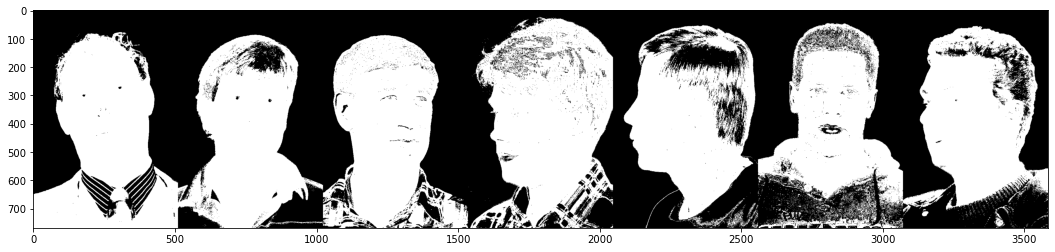

In [100]:
IMAGE = np.hstack([ np.hstack([np.hstack([np.hstack([np.hstack([np.hstack([cv2.imread("../Data/sfa/ORI/img (6).jpg"),
                                                                           cv2.imread("../Data/sfa/ORI/img (25).jpg")]),
                                                                cv2.imread("../Data/sfa/ORI/img (55).jpg")]),
                                                     cv2.imread("../Data/sfa/ORI/img (75).jpg")]),
                                          cv2.imread("../Data/sfa/ORI/img (89).jpg")]),
                             cv2.imread("../Data/sfa/ORI/img (118).jpg")]),
                  cv2.imread("../Data/sfa/ORI/img (110).jpg")])
MASK = getMask(cv2.cvtColor(cv2.cvtColor(IMAGE,cv2.COLOR_BGR2YCR_CB),cv2.COLOR_BGR2RGB))
plt.figure(figsize = (20,4))
plt.imshow(MASK,cmap='gray')

In [68]:
with open('Result BO.pkl', 'wb') as f:
    pickle.dump(ELLIPSES, f)

In [8]:
with open('Result BO.pkl', 'rb') as f:
    ELLIPSES = pickle.load(f)

In [9]:
%matplotlib qt
import random
 
def color_generator(seed):
    random.seed(seed*20+5)
    r = random.randint(0, 255)
    g = random.randint(0, 255)
    b = random.randint(0, 255)
    return (r/255, g/255, b/255)

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.set_xlabel('Cb')
ax.set_ylabel('Cr')
ax.set_zlabel('Y')

for i in range(256):
    for ELLI in ELLIPSES[i]:
        u=ELLI.HMoy      #x-position of the center
        v=ELLI.SMoy      #y-position of the center
        a=ELLI.Th*ELLI.HEct       #radius on the x-axis
        b=ELLI.Th*ELLI.SEct      #radius on the y-axis
        t_rot=ELLI.thet #rotation angle

        t = np.linspace(0, 2*pi, 100)
        Ell = np.array([a*np.cos(t) , b*np.sin(t)])  
        R_rot = np.array([[cos(t_rot) , -sin(t_rot)],[sin(t_rot) , cos(t_rot)]])  
    #2-D rotation matrix

        Ell_rot = np.zeros((2,Ell.shape[1]))
        for j in range(Ell.shape[1]):
            Ell_rot[:,j] = np.dot(R_rot,Ell[:,j])

        ax.plot( u + Ell_rot[0,:] , v + Ell_rot[1,:],np.ones((Ell_rot[0].shape))*i,color=color_generator(ELLI.cluster) )
plt.show()